In [ ]:
# This notebook has everything you need to create datasets/dataloaders, create models, hyperparameter tune with optuna 
# train a model and evaluate it

In [1]:
#Uses manual feature extraction and then an LSTM
modelType = "ManualLSTM"

In [2]:
modelTypedict = {"ManualGRU": ["Manual", "GRU"], "ManualLSTM": ["Manual", "LSTM"], "ActiNetGRU": ["ActiNet", "GRU"], "ActiNetLSTM": ["ActiNet", "LSTM"]}
acc_preprocess = modelTypedict[modelType][0]
RNN_type = modelTypedict[modelType][1]

In [3]:
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchmetrics.classification import MulticlassCohenKappa
from IPython.display import clear_output
import optuna
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, cohen_kappa_score, roc_auc_score, confusion_matrix
import seaborn as sns
from collections import Counter
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers.wandb import WandbLogger
import wandb
from x_transformers import ContinuousTransformerWrapper, Encoder
torch.set_float32_matmul_precision('medium')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from wearables import Wearables

/ext3/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Set up Datasets

In [4]:
data_dir = '/scratch/npr264/BioDeepL/dreamt/physionet.org/files/dreamt/2.0.0/data_64Hz'

In [5]:
participant_info_df = pd.read_csv('/scratch/npr264/BioDeepL/dreamt/physionet.org/files/dreamt/2.0.0/participant_info.csv')
subjects_all = participant_info_df['SID']

subjects_all_shuffled = participant_info_df['SID'].sample(frac=1, random_state=42).reset_index(drop=True)
subjects_train = subjects_all_shuffled[:int(len(subjects_all_shuffled)*0.8)]
subjects_val = subjects_all_shuffled[int(len(subjects_all_shuffled)*0.8):int(len(subjects_all_shuffled)*0.9)]
subjects_test = subjects_all_shuffled[int(len(subjects_all_shuffled)*0.9):]
print(f"number of subjects in train: {len(subjects_train)}")
print(f"number of subjects in val: {len(subjects_val)}")
print(f"number of subjects in test: {len(subjects_test)}")

number of subjects in train: 80
number of subjects in val: 10
number of subjects in test: 10


In [16]:
non_acc_freq = 0.2
acc_freq = 32
chunk_duration = 6000 # chunk duration in seconds
chunk_stride = 3000
train_dataset_mixed = Wearables(subjects_list=subjects_train,
                                 data_dir=data_dir,
                                 chunk_duration=chunk_duration,
                                 chunk_stride=chunk_stride,
                                 downsample_freq=non_acc_freq,
                                 acc_freq=acc_freq,
                                 debug=False)
print(f"Total samples in train dataset: {len(train_dataset_mixed)}")
val_dataset_mixed = Wearables(subjects_list=subjects_val,
                                 data_dir=data_dir,
                                 chunk_duration=chunk_duration,
                                 chunk_stride=chunk_stride,
                                 downsample_freq=non_acc_freq, 
                                 acc_freq=acc_freq,
                                 debug=False)
print(f"Total samples in val dataset: {len(val_dataset_mixed)}")
test_dataset_mixed = Wearables(subjects_list=subjects_test,
                                 data_dir=data_dir,
                                 chunk_duration=chunk_duration,
                                 chunk_stride=chunk_stride,
                                 downsample_freq=non_acc_freq,
                                 acc_freq=acc_freq,
                                 debug=False)
print(f"Total samples in test dataset: {len(test_dataset_mixed)}")

Total samples in train dataset: 202
Total samples in val dataset: 28
Total samples in test dataset: 27


In [17]:
#OPTIONAL, save datasets as they take a long time to create
torch.save(train_dataset_mixed, f'/home/npr264/DeepLearning/project/cleaned/datasets/trainset_{chunk_duration}s.pt')
torch.save(val_dataset_mixed, f'/home/npr264/DeepLearning/project/cleaned/datasets/valset_{chunk_duration}s.pt')
torch.save(test_dataset_mixed, f'/home/npr264/DeepLearning/project/cleaned/datasets/testset_{chunk_duration}s.pt')

### Loading in and class weights

In [ ]:
chunk_duration = 6000
train_dataset_mixed = torch.load(f'/home/npr264/DeepLearning/project/cleaned/datasets/trainset_{chunk_duration}s.pt')
val_dataset_mixed = torch.load(f'/home/npr264/DeepLearning/project/cleaned/datasets/valset_{chunk_duration}s.pt')

In [7]:
# get class weights for weighted loss
all_labels = []
for batch in DataLoader(train_dataset_mixed, batch_size=1):
    labels = batch[2].numpy()
    all_labels.extend(labels.flatten())
all_labels = np.array(all_labels)
valid_labels = all_labels[all_labels != -1]
classes = np.arange(4)
class_counts = Counter(valid_labels)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=valid_labels
)
print(f"Class counts: {class_counts}")
print(f"Class weights: {class_weights}")

Class counts: Counter({np.int64(1): 155342, np.int64(0): 53092, np.int64(3): 24240, np.int64(2): 9372})
Class weights: [1.13974798 0.38953728 6.45662612 2.49634901]


In [8]:
weight_tensor = torch.tensor(class_weights, dtype=torch.float32)

### Model Definitions

#### Acc Models

In [9]:
#"Manual" model
def extract_features(acc, window_size=160):
    # acc: [batch_size, seq_len, 3]
    batch_size, seq_len, dims = acc.shape
    assert seq_len % window_size == 0, "seq_len must be divisible by window_size"

    # Reshape: [batch_size, seq_len // window_size, window_size, 3]
    acc = acc.view(batch_size, seq_len // window_size, window_size, dims)

    # Compute features along the window dimension (dim=2)
    mean = acc.mean(dim=2)
    abs_mean = acc.abs().mean(dim=2)
    max_val = acc.max(dim=2).values
    min_val = acc.min(dim=2).values
    range_val = max_val - min_val
    var = acc.var(dim=2, unbiased=False)
    rms = torch.sqrt((acc ** 2).mean(dim=2))
    iqr = torch.quantile(acc, 0.75, dim=2) - torch.quantile(acc, 0.25, dim=2)
    q25 = torch.quantile(acc, 0.25, dim=2)
    q50 = torch.quantile(acc, 0.50, dim=2)
    q75 = torch.quantile(acc, 0.75, dim=2)

    # Concatenate all features along the last dimension
    features = torch.cat([
        mean, abs_mean, max_val, min_val, range_val, var, rms, iqr, q25, q50, q75
    ], dim=-1)  # shape: [batch_size, seq_len // 160, 33]

    return features

In [10]:
class DeepACTINeT(nn.Module):
    def __init__(self, cnn_output_channels, dropout=0.25):
        super(DeepACTINeT, self).__init__()
        # Define the layers as per the structure provided
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=16, kernel_size=512, stride=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=256, stride=2)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=256, stride=2)
        self.conv4 = nn.Conv1d(in_channels=16, out_channels=cnn_output_channels, kernel_size=32, stride=2)
        
        self.dropout = nn.Dropout(dropout)
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.batch_norm2 = nn.BatchNorm1d(16)
        self.batch_norm3 = nn.BatchNorm1d(16)
        self.batch_norm4 = nn.BatchNorm1d(cnn_output_channels)
    
    def forward(self, x):
        assert not torch.isnan(x).any(), "NaN detected in CNN input"
        print(x.shape)
        x = x.permute(0,2, 1) #flip channels and num samples [batch, ch, num samples]

        initial_samples = x.shape[2]
        #you want to end up with one every 5 seconds 
        final_samples = initial_samples // (32*5)

        x = F.relu(self.conv1(x))
        #print(f"Input shape after conv1: {x.shape}")
        x = self.dropout(x)
        #print(f"Input shape after, dropout: {x.shape}")
        x = self.batch_norm1(x)
        #print(f"Input shape after conv1,dropout,batchnorm: {x.shape}")
        x = F.max_pool1d(x, kernel_size=2, stride = 2)
        #print(f"Input shape after maxpool: {x.shape}")
        
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.batch_norm2(x)
        #print(f"Input shape after conv2: {x.shape}")
        
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = self.batch_norm3(x)
        #print(f"Input shape after conv3: {x.shape}")
        
        x = F.max_pool1d(x, kernel_size=2, stride = 2)
        #print(f"Input shape after maxpool: {x.shape}")
        
        x = F.relu(self.conv4(x))
        x = self.dropout(x)
        x = self.batch_norm4(x)
        #print(f"before avg pooling shape: {x.shape}")

        x = F.adaptive_avg_pool1d(x, final_samples)
        #print(f"Final output shape: {x.shape}")
        
        return x

#### LSTM model 

In [11]:
#acc_preprocess = "ActiNet" or "Manual"
class SleepStager(pl.LightningModule):
    def __init__(self,
                non_acc_dim:         int,
                acc_preprocess = acc_preprocess,
                RNN_type = RNN_type,
                bidirectional = True,
                cnn_output_channels: int = 16,
                dropout_embed:   float = 0.25,
                dropout_rnn: float = 0.25,
                dropout_hidden2: float= 0.25,
                pre_rnn_embedding_size: int = 16,
                rnn_hidden_size:   int = 128,
                hidden_size2:       int = 64,
                num_sleep_stages:   int = 4,
                lr:                  float = 1e-3,
                weight_tensor:      torch.Tensor = None,
                debug:            bool = False):
        super().__init__()
        if acc_preprocess == "ActiNet":
            self.mode = "ActiNet"
            self.acc_processing = DeepACTINeT(cnn_output_channels)
            self.acc_channels = cnn_output_channels
        elif acc_preprocess == "Manual":
            self.mode = "Manual"
            self.acc_processing = extract_features
            self.acc_channels = 33
        else:
            raise ValueError("ActiNet or Manual are the only valid options")
        
        self.RNN_type = RNN_type
        self.non_acc_dim = non_acc_dim
        self.embeddingLayer = nn.Linear(self.non_acc_dim, pre_rnn_embedding_size)
        self.cnn_output_channels = cnn_output_channels

        #add non linearity to the bvp and temp before lstm 
        self.pre_rnn_embedding_size = pre_rnn_embedding_size

        self.rnn_hidden_size = rnn_hidden_size
        self.hidden_size2 = hidden_size2

        self.dropout_embed = nn.Dropout(p=dropout_embed)
        self.dropout_rnn = dropout_rnn
        self.dropout_hidden2 = nn.Dropout(p=dropout_hidden2)

        self.rnn_input_size = self.pre_rnn_embedding_size + self.acc_channels
        self.rnn_hidden_size = rnn_hidden_size

        if self.RNN_type == "GRU":
            rnn = nn.GRU
        elif self.RNN_type == "LSTM":
            rnn = nn.LSTM
        else:
            raise Exception("[Error] Unknown RnnType. Currently supported:GRU,LSTM")

        self.rnn = rnn(input_size=self.rnn_input_size,
                            hidden_size=self.rnn_hidden_size,
                            dropout = self.dropout_rnn,
                            num_layers = 2,
                            bias = True,
                            batch_first=False,
                            bidirectional = True)
       
        self.hidden2 = nn.Linear(rnn_hidden_size*2, hidden_size2)
        classifier_in = hidden_size2
        self.classifier = nn.Linear(classifier_in, num_sleep_stages)
    
        self.train_criterion = nn.CrossEntropyLoss(weight=weight_tensor, ignore_index=-1)
        self.val_criterion = nn.CrossEntropyLoss(weight=weight_tensor, ignore_index=-1)
        
        self.lr        = lr
        self.debug      = debug
        self.kappa = MulticlassCohenKappa(num_classes=num_sleep_stages)

    def forward(self, acc, non_acc):
        """
        non_acc: (batch, non_acc_length, non_acc_dim)
        acc:     (batch, acc_length)  or  (batch, acc_length, 1)
        returns:
          y_hat (output_length, batch, num_sleep_stages)
        """
        # ensure ACC has a channel dim
        if acc.dim() == 2:
            acc = acc.unsqueeze(-1)          # now (batch, T, 1)
        
        # 1) ACC → CNN → (batch, num_cnn_feats, cnn_output_length)
        acc_feats = self.acc_processing(acc)
        
        if self.debug:
            print(f"[DEBUG] ACC CNN output shape: {acc_feats.shape}") # (batch, num_cnn_feats, cnn_output_length)
            print(f"[DEBUG] NON_ACC input shape: {non_acc.shape}") # (batch, non_acc_length, non_acc_dim)
        
        #embed the non_acc data 
        emb_non_acc = self.embeddingLayer(non_acc)
        emb_non_acc = self.dropout_embed(emb_non_acc)
        #emb_non_acc = non_acc
        # 3) build LSTM input: (T', batch, feature_dim)
        if self.mode == "ActiNet":
            a = acc_feats.permute(2, 0, 1)     
        elif self.mode == "Manual":
            a = acc_feats.permute(1,0,2)
        b = emb_non_acc.permute(1, 0, 2)       

        if self.debug:
            print(f"[DEBUG] ACC CNN reshaped shape: {a.shape}") 
            print(f"[DEBUG] NON_ACC reshaped shape: {b.shape}")
       
        rnn_in = torch.cat([a, b], dim = 2)    # (lstm_seq_len, batch, C_cnn + D_nonacc)
        # without batch_first = true, LSTM input shape is (seq_len, batch_size, features)


        if self.debug:
            print(f"[DEBUG] RNN input shape: {rnn_in.shape}")
            print(f"[DEBUG] RNN hidden size: {self.rnn_hidden_size}")
    
        output,_ = self.rnn(rnn_in)
        output = self.hidden2(output)
        output = self.dropout_hidden2(output)
        if self.debug:
            print(f"[DEBUG] hidden2 shape: {output.shape}")
        y_hat = self.classifier(output)     # (lstm_seq_len, batch, num_sleep_stages)
        if self.debug:
            print(f"[DEBUG] Classifier output shape: {y_hat.shape}")
        return y_hat
            
    def training_step(self, batch, batch_idx):
        non_acc, acc, labels = batch
        '''
        non_acc: (batch, non_acc_length, non_acc_dim)
        acc:     (batch, acc_length)  or  (batch, acc_length, 1)
        labels:  (batch, non_acc_length)
        '''
        y_hat = self(acc, non_acc)            # (lstm_seq_len, batch, num_sleep_stages)
        y_hat = y_hat.permute(1, 0, 2)        # (batch, lstm_seq_len, num_sleep_stages)
    
        # flatten
        batch_size, output_length, num_sleep_stages = y_hat.shape
        y_hat_flat = y_hat.reshape(batch_size * output_length, num_sleep_stages)
        labels_flat  = labels.reshape(batch_size * output_length)
        
        # calculate loss
        loss = self.train_criterion(y_hat_flat, labels_flat)
    
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        non_acc, acc, labels = batch
            
        '''
        non_acc: (batch, non_acc_length, non_acc_dim)
        acc:     (batch, acc_length)  or  (batch, acc_length, 1)
        labels:  (batch, non_acc_length)
        '''
        y_hat = self(acc, non_acc)            # (lstm_seq_len, batch, num_sleep_stages)
        y_hat = y_hat.permute(1, 0, 2)        # (batch, lstm_seq_len, num_sleep_stages)
    
        # flatten
        batch_size, output_length, num_sleep_stages = y_hat.shape
        y_hat_flat = y_hat.reshape(batch_size * output_length, num_sleep_stages)
        labels_flat  = labels.reshape(batch_size * output_length)
        
        # calculate loss
        loss = self.val_criterion(y_hat_flat, labels_flat)
    
        # calculate accuracy
        predictions = torch.argmax(y_hat_flat, dim=1)
        mask = labels_flat != -1
        masked_preds = predictions[mask]
        masked_labels = labels_flat[mask]
        if masked_labels.numel() > 0:
            acc = (masked_preds == masked_labels).float().mean().item()
        else:
            acc = 0.0
    
        # calculate cohen's kappa
        mask = labels_flat != -1
        y_valid = labels_flat[mask]
        preds_valid = predictions[mask]
        if y_valid.numel() > 0:
            ckappa = self.kappa.update(preds_valid, y_valid)
        else:
            ckappa = torch.tensor(0.0, device=self.device)

        # log metrics
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc",  acc,  prog_bar=True)
        
        return {"val_loss": loss, "val_acc": acc}
        
    def on_validation_epoch_end(self):
        k = self.kappa.compute()
        self.log("val_cohen_kappa", torch.nan_to_num(k,0.0), prog_bar=True)
        self.kappa.reset()
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.3, patience=3, verbose=True, min_lr=1e-6
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',  # must match your validation metric
                'interval': 'epoch',
                'frequency': 1
            }
        }


### Optuna

In [ ]:
accelerator = "gpu" if torch.cuda.is_available() else "cpu"
def objective(trial, acc_preprocess, RNN_type, modelType):
    acc_preprocess = acc_preprocess
    RNN_type = RNN_type
    
    # Dropouts
    dropout_embed = trial.suggest_float('dropout_embed', 0.1, 0.55)
    dropout_rnn = trial.suggest_float('dropout_rnn', 0.1, 0.55)
    dropout_hidden2 = trial.suggest_float('dropout_hidden2', 0.1, 0.55)
    
    #label_smoothing = trial.suggest_float("label_smoothing", 0.0, 0.1)
    #Sizes
    pre_rnn_size = 16
    pre_rnn_size = trial.suggest_categorical("pre_rnn_embedding_size", [4, 8, 16, 32, 64])
    rnn_hidden_size = trial.suggest_categorical("rnn_hidden_size", [32, 64, 128, 256, 512])
    hidden_size2 = trial.suggest_categorical("hidden_size2", [4, 8, 16, 32, 64])

    #other
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [2, 4, 8, 16, 32, 64])
    
    #bidirectional = trial.suggest_categorical("bidirectional", [True, False])
    #Conditional logic for acc_preprocess-specific parameters
    if acc_preprocess == "ActiNet":
        cnn_output_channels = trial.suggest_categorical("cnn_output_channels", [8, 16, 32, 64])
        cnn_name_piece = f"_cnn{cnn_output_channels}"
    else:
        cnn_output_channels = None  # Not relevant for "Manual"
        cnn_name_piece = ""
    
    size_piece = f"prernn{pre_rnn_size}_rnn{rnn_hidden_size}_hidden{hidden_size2}"
    other_piece = f"lr{learning_rate}_batchsize{batch_size}"
    dropout_piece = f"dropoutembed{dropout_embed}_dropoutRNN{dropout_rnn}_dropouthidden2{dropout_hidden2}"
    name = size_piece+other_piece+dropout_piece+cnn_name_piece
    
    wandb_logger = WandbLogger(name, project = modelType)
    #wandb.define_metric("best_val_loss", summary="min")
    checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath=f'/scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/{trial.number}/',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
    )
    early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=4,
    verbose=True,
    mode='min'
    )
    trainer = pl.Trainer(
    max_epochs=20,
    devices=1,
    accelerator=accelerator,
    logger=wandb_logger,
    callbacks=[checkpoint_callback, early_stop_callback],
    log_every_n_steps=2,
    )
    model = SleepStager(non_acc_dim = 5,
                        acc_preprocess = acc_preprocess,
                        RNN_type = RNN_type,
                        dropout_embed = dropout_embed,
                        dropout_rnn = dropout_rnn,
                        dropout_hidden2 = dropout_hidden2,
                        pre_rnn_embedding_size= pre_rnn_size,
                        rnn_hidden_size= rnn_hidden_size,
                        hidden_size2= hidden_size2,
                        lr = learning_rate,
                        weight_tensor=weight_tensor.to(device),
                    debug= False)
    train_loader = DataLoader(train_dataset_mixed, batch_size=batch_size, shuffle=True, num_workers = 8)
    val_loader = DataLoader(val_dataset_mixed, batch_size=batch_size, shuffle=False, num_workers = 8)
    trainer.fit(model, train_loader, val_loader)
    

    #we will pull the best model, even if it overtrained a little, so we need to go pull that best model to understand its performance
    best_model_path = checkpoint_callback.best_model_path
    print(f"Best model path: {best_model_path}")
    
    # Load the model
    best_model = SleepStager.load_from_checkpoint(best_model_path,non_acc_dim = 5,
                            acc_preprocess = acc_preprocess,
                            RNN_type = RNN_type,
                            dropout_embed = dropout_embed,
                            dropout_rnn = dropout_rnn,
                            dropout_hidden2 = dropout_hidden2,
                            pre_rnn_embedding_size= pre_rnn_size,
                            rnn_hidden_size= rnn_hidden_size,
                            hidden_size2= hidden_size2,
                            lr = learning_rate,
                            weight_tensor=weight_tensor.to(device),
                        debug= False)
    # Evaluate the best model
    trainer_best = pl.Trainer(devices=1, accelerator=accelerator)
    val_result = trainer_best.validate(best_model, val_loader, verbose=False)
    val_loss = val_result[0]["val_loss"]
    #log needed things
    wandb_logger.experiment.config.update(trial.params)
    wandb_logger.experiment.config.update({"trial_number": trial.number})
    wandb_logger.experiment.log({"best_val_loss": val_loss})
    wandb.finish()

    return val_loss

study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, acc_preprocess, RNN_type, modelType), n_trials=500)
best_trial = study.best_trial
print("Best trial:")
print(f"  Value: {best_trial.value}")
print("  Params:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-04-29 16:18:11,344] A new study created in memory with name: no-name-c012c4eb-694c-47f5-90d8-101163910c0e
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/projec

Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  5.25it/s, v_num=gyad, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  3.53it/s, v_num=gyad, train_loss_step=1.370, val_loss=1.380, val_acc=0.265, val_cohen_kappa=0.0645, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.383


Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  3.86it/s, v_num=gyad, train_loss_step=1.380, val_loss=1.380, val_acc=0.265, val_cohen_kappa=0.0645, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:02<00:00,  2.80it/s, v_num=gyad, train_loss_step=1.380, val_loss=1.350, val_acc=0.313, val_cohen_kappa=0.104, train_loss_epoch=1.370] 

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 1.350


Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  3.79it/s, v_num=gyad, train_loss_step=1.360, val_loss=1.350, val_acc=0.313, val_cohen_kappa=0.104, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:02<00:00,  2.81it/s, v_num=gyad, train_loss_step=1.360, val_loss=1.330, val_acc=0.276, val_cohen_kappa=0.0715, train_loss_epoch=1.350]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.329


Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  3.78it/s, v_num=gyad, train_loss_step=1.290, val_loss=1.330, val_acc=0.276, val_cohen_kappa=0.0715, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:02<00:00,  2.73it/s, v_num=gyad, train_loss_step=1.290, val_loss=1.310, val_acc=0.279, val_cohen_kappa=0.0768, train_loss_epoch=1.330]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.311


Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  3.80it/s, v_num=gyad, train_loss_step=1.330, val_loss=1.310, val_acc=0.279, val_cohen_kappa=0.0768, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:02<00:00,  2.78it/s, v_num=gyad, train_loss_step=1.330, val_loss=1.260, val_acc=0.289, val_cohen_kappa=0.0765, train_loss_epoch=1.310]

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 1.263


Epoch 5: 100%|██████████| 7/7 [00:01<00:00,  3.80it/s, v_num=gyad, train_loss_step=1.420, val_loss=1.260, val_acc=0.289, val_cohen_kappa=0.0765, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:02<00:00,  2.77it/s, v_num=gyad, train_loss_step=1.420, val_loss=1.230, val_acc=0.231, val_cohen_kappa=0.0762, train_loss_epoch=1.280]

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 1.226


Epoch 6: 100%|██████████| 7/7 [00:01<00:00,  3.68it/s, v_num=gyad, train_loss_step=1.280, val_loss=1.230, val_acc=0.231, val_cohen_kappa=0.0762, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 7/7 [00:01<00:00,  3.77it/s, v_num=gyad, train_loss_step=1.220, val_loss=1.280, val_acc=0.244, val_cohen_kappa=0.0691, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 7/7 [00:01<00:00,  3.74it/s, v_num=gyad, train_loss_step=1.100, val_loss=1.250, val_acc=0.262, val_cohen_kappa=0.0996, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 7/7 [00:01<00:00,  3.82it/s, v_num=gyad, train_loss_step=1.130, val_loss=1.310, val_acc=0.272, val_cohen_kappa=0.0941, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 7/7 [00:02<00:00,  2.79it/s, v_num=gyad, train_loss_step=1.130, val_loss=1.350, val_acc=0.266, val_cohen_kappa=0.0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.226. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 7/7 [00:02<00:00,  2.78it/s, v_num=gyad, train_loss_step=1.130, val_loss=1.350, val_acc=0.266, val_cohen_kappa=0.0814, train_loss_epoch=1.210]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/0/best-checkpoint-v14.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▇▇▆▅▄▃▂▂▁
train_loss_step,▇█▇▇▇▇▇▇▇▆▇▆▆▆▅▅▆▅▅▅▆▅█▅▅▅▄▃▄▃▂▄▃▂▂▂▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,█▃▆▄▄▅▁▂▃▄▃
val_cohen_kappa,▁▅█▅▆▆▆▅█▇▆
val_loss,█▇▆▅▄▂▁▃▂▄▆
best_val_loss,1.22601
epoch,9
train_loss_epoch,1.20754


[I 2025-04-29 16:18:40,123] Trial 0 finished with value: 1.22601318359375 and parameters: {'dropout_embed': 0.41547711206477256, 'dropout_rnn': 0.5184089195483433, 'dropout_hidden2': 0.1623179156563449, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 0.00029219815258416055, 'batch_size': 32}. Best is trial 0 with value: 1.22601318359375.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s, v_num=6qdp, train_loss_step=1.460]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s, v_num=6qdp, train_loss_step=1.460, val_loss=1.430, val_acc=0.614, val_cohen_kappa=0.000, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.431


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, v_num=6qdp, train_loss_step=1.350, val_loss=1.430, val_acc=0.614, val_cohen_kappa=0.000, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s, v_num=6qdp, train_loss_step=1.350, val_loss=1.400, val_acc=0.499, val_cohen_kappa=-0.0559, train_loss_epoch=1.390]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.404


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, v_num=6qdp, train_loss_step=1.400, val_loss=1.400, val_acc=0.499, val_cohen_kappa=-0.0559, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.66it/s, v_num=6qdp, train_loss_step=1.400, val_loss=1.390, val_acc=0.403, val_cohen_kappa=-0.0625, train_loss_epoch=1.390]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.391


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, v_num=6qdp, train_loss_step=1.370, val_loss=1.390, val_acc=0.403, val_cohen_kappa=-0.0625, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s, v_num=6qdp, train_loss_step=1.370, val_loss=1.380, val_acc=0.366, val_cohen_kappa=-0.0666, train_loss_epoch=1.380]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.384


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, v_num=6qdp, train_loss_step=1.380, val_loss=1.380, val_acc=0.366, val_cohen_kappa=-0.0666, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, v_num=6qdp, train_loss_step=1.350, val_loss=1.390, val_acc=0.398, val_cohen_kappa=-0.0584, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s, v_num=6qdp, train_loss_step=1.350, val_loss=1.390, val_acc=0.380, val_cohen_kappa=-0.0475, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.36it/s, v_num=6qdp, train_loss_step=1.400, val_loss=1.390, val_acc=0.374, val_cohen_kappa=-0.0294, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s, v_num=6qdp, train_loss_step=1.400, val_loss=1.400, val_acc=0.369, val_cohen_kappa

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.384. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s, v_num=6qdp, train_loss_step=1.400, val_loss=1.400, val_acc=0.369, val_cohen_kappa=-0.00368, train_loss_epoch=1.360]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/1/best-checkpoint-v10.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss_epoch,█▆▅▄▄▃▂▁
train_loss_step,▃█▄▁▃▄▃▃▃▃▃▁▂▁▂▄
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█████
val_acc,█▅▂▁▂▁▁▁
val_cohen_kappa,█▂▁▁▂▃▅█
val_loss,█▄▂▁▁▁▂▃
best_val_loss,1.38373
epoch,7
train_loss_epoch,1.36246


[I 2025-04-29 16:19:02,941] Trial 1 finished with value: 1.3837320804595947 and parameters: {'dropout_embed': 0.11522288305609546, 'dropout_rnn': 0.2317803229054127, 'dropout_hidden2': 0.4619138055354033, 'rnn_hidden_size': 256, 'hidden_size2': 4, 'learning_rate': 0.00021861766151705234, 'batch_size': 64}. Best is trial 0 with value: 1.22601318359375.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Epoch 0: 100%|██████████| 26/26 [00:02<00:00,  9.96it/s, v_num=6hbc, train_loss_step=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 26/26 [00:03<00:00,  7.70it/s, v_num=6hbc, train_loss_step=1.290, val_loss=1.420, val_acc=0.270, val_cohen_kappa=0.0813, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.418


Epoch 1: 100%|██████████| 26/26 [00:03<00:00,  8.33it/s, v_num=6hbc, train_loss_step=1.400, val_loss=1.420, val_acc=0.270, val_cohen_kappa=0.0813, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 26/26 [00:03<00:00,  6.62it/s, v_num=6hbc, train_loss_step=1.400, val_loss=1.360, val_acc=0.226, val_cohen_kappa=0.055, train_loss_epoch=1.350] 

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 1.360


Epoch 2: 100%|██████████| 26/26 [00:03<00:00,  8.11it/s, v_num=6hbc, train_loss_step=1.410, val_loss=1.360, val_acc=0.226, val_cohen_kappa=0.055, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 26/26 [00:03<00:00,  8.21it/s, v_num=6hbc, train_loss_step=1.510, val_loss=1.430, val_acc=0.256, val_cohen_kappa=0.0791, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 26/26 [00:03<00:00,  6.54it/s, v_num=6hbc, train_loss_step=1.510, val_loss=1.300, val_acc=0.363, val_cohen_kappa=0.129, train_loss_epoch=1.290] 

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 1.295


Epoch 4: 100%|██████████| 26/26 [00:03<00:00,  8.25it/s, v_num=6hbc, train_loss_step=1.380, val_loss=1.300, val_acc=0.363, val_cohen_kappa=0.129, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 26/26 [00:03<00:00,  8.22it/s, v_num=6hbc, train_loss_step=1.310, val_loss=1.370, val_acc=0.290, val_cohen_kappa=0.0903, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 26/26 [00:03<00:00,  8.21it/s, v_num=6hbc, train_loss_step=1.220, val_loss=1.380, val_acc=0.359, val_cohen_kappa=0.0946, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 26/26 [00:03<00:00,  8.19it/s, v_num=6hbc, train_loss_step=1.420, val_loss=1.390, val_acc=0.242, val_cohen_kappa=0.0884, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 26/26 [00:03<00:00,  6.60it/s, v_num=6hbc, train_loss_step=1.420, val_loss=1.360, val_acc=0.329, val_cohen_

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.295. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 26/26 [00:03<00:00,  6.60it/s, v_num=6hbc, train_loss_step=1.420, val_loss=1.360, val_acc=0.329, val_cohen_kappa=0.0612, train_loss_epoch=1.260]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/2/best-checkpoint-v10.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 17.69it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇███
train_loss_epoch,█▆▅▃▂▃▁▂
train_loss_step,█▇▆▆▇▃▆▆▅█▆▇▆▅▄▄▅▄▄▃▆▆▅▂▃▅▃▂▂▄▄▅▃▃▂▁▄▄▁▇
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
val_acc,▃▁▃█▄█▂▆
val_cohen_kappa,▃▁▃█▄▅▄▂
val_loss,▇▄█▁▅▅▆▄
best_val_loss,1.29533
epoch,7
train_loss_epoch,1.26309


[I 2025-04-29 16:19:37,861] Trial 2 finished with value: 1.2953262329101562 and parameters: {'dropout_embed': 0.41743492529129056, 'dropout_rnn': 0.3513475234039104, 'dropout_hidden2': 0.26115162290871363, 'rnn_hidden_size': 256, 'hidden_size2': 16, 'learning_rate': 0.002898465202426442, 'batch_size': 8}. Best is trial 0 with value: 1.22601318359375.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  3.11it/s, v_num=qtgh, train_loss_step=1.450]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s, v_num=qtgh, train_loss_step=1.450, val_loss=1.430, val_acc=0.112, val_cohen_kappa=0.000, train_loss_epoch=1.420]

Metric val_loss improved. New best score: 1.434


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, v_num=qtgh, train_loss_step=1.400, val_loss=1.430, val_acc=0.112, val_cohen_kappa=0.000, train_loss_epoch=1.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s, v_num=qtgh, train_loss_step=1.400, val_loss=1.430, val_acc=0.112, val_cohen_kappa=0.000, train_loss_epoch=1.410]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.428


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s, v_num=qtgh, train_loss_step=1.490, val_loss=1.430, val_acc=0.112, val_cohen_kappa=0.000, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s, v_num=qtgh, train_loss_step=1.490, val_loss=1.420, val_acc=0.112, val_cohen_kappa=0.000, train_loss_epoch=1.410]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.422


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, v_num=qtgh, train_loss_step=1.390, val_loss=1.420, val_acc=0.112, val_cohen_kappa=0.000, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.66it/s, v_num=qtgh, train_loss_step=1.390, val_loss=1.420, val_acc=0.112, val_cohen_kappa=0.000, train_loss_epoch=1.400]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.416


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, v_num=qtgh, train_loss_step=1.340, val_loss=1.420, val_acc=0.112, val_cohen_kappa=0.000, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s, v_num=qtgh, train_loss_step=1.340, val_loss=1.410, val_acc=0.112, val_cohen_kappa=0.000, train_loss_epoch=1.400]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.410


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, v_num=qtgh, train_loss_step=1.420, val_loss=1.410, val_acc=0.112, val_cohen_kappa=0.000, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s, v_num=qtgh, train_loss_step=1.420, val_loss=1.410, val_acc=0.112, val_cohen_kappa=0.000, train_loss_epoch=1.400]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.406


Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, v_num=qtgh, train_loss_step=1.430, val_loss=1.410, val_acc=0.112, val_cohen_kappa=0.000, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s, v_num=qtgh, train_loss_step=1.430, val_loss=1.400, val_acc=0.113, val_cohen_kappa=0.000973, train_loss_epoch=1.390]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.402


Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, v_num=qtgh, train_loss_step=1.410, val_loss=1.400, val_acc=0.113, val_cohen_kappa=0.000973, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s, v_num=qtgh, train_loss_step=1.410, val_loss=1.400, val_acc=0.116, val_cohen_kappa=0.00346, train_loss_epoch=1.390] 

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.396


Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, v_num=qtgh, train_loss_step=1.350, val_loss=1.400, val_acc=0.116, val_cohen_kappa=0.00346, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s, v_num=qtgh, train_loss_step=1.350, val_loss=1.390, val_acc=0.121, val_cohen_kappa=0.00551, train_loss_epoch=1.380]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.391


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, v_num=qtgh, train_loss_step=1.380, val_loss=1.390, val_acc=0.121, val_cohen_kappa=0.00551, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.66it/s, v_num=qtgh, train_loss_step=1.380, val_loss=1.390, val_acc=0.140, val_cohen_kappa=0.0216, train_loss_epoch=1.380] 

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.387


Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, v_num=qtgh, train_loss_step=1.360, val_loss=1.390, val_acc=0.140, val_cohen_kappa=0.0216, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s, v_num=qtgh, train_loss_step=1.360, val_loss=1.380, val_acc=0.164, val_cohen_kappa=0.0427, train_loss_epoch=1.380]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.384


Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s, v_num=qtgh, train_loss_step=1.380, val_loss=1.380, val_acc=0.164, val_cohen_kappa=0.0427, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s, v_num=qtgh, train_loss_step=1.380, val_loss=1.380, val_acc=0.176, val_cohen_kappa=0.0505, train_loss_epoch=1.370]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.380


Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s, v_num=qtgh, train_loss_step=1.370, val_loss=1.380, val_acc=0.176, val_cohen_kappa=0.0505, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.66it/s, v_num=qtgh, train_loss_step=1.370, val_loss=1.380, val_acc=0.180, val_cohen_kappa=0.0474, train_loss_epoch=1.370]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.378


Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, v_num=qtgh, train_loss_step=1.360, val_loss=1.380, val_acc=0.180, val_cohen_kappa=0.0474, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s, v_num=qtgh, train_loss_step=1.360, val_loss=1.370, val_acc=0.182, val_cohen_kappa=0.0462, train_loss_epoch=1.370]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.375


Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, v_num=qtgh, train_loss_step=1.340, val_loss=1.370, val_acc=0.182, val_cohen_kappa=0.0462, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s, v_num=qtgh, train_loss_step=1.340, val_loss=1.370, val_acc=0.187, val_cohen_kappa=0.0478, train_loss_epoch=1.360]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.372


Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s, v_num=qtgh, train_loss_step=1.360, val_loss=1.370, val_acc=0.187, val_cohen_kappa=0.0478, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.68it/s, v_num=qtgh, train_loss_step=1.360, val_loss=1.370, val_acc=0.188, val_cohen_kappa=0.0513, train_loss_epoch=1.360]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.368


Epoch 16: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, v_num=qtgh, train_loss_step=1.330, val_loss=1.370, val_acc=0.188, val_cohen_kappa=0.0513, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s, v_num=qtgh, train_loss_step=1.330, val_loss=1.360, val_acc=0.190, val_cohen_kappa=0.054, train_loss_epoch=1.360] 

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.364


Epoch 17: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, v_num=qtgh, train_loss_step=1.340, val_loss=1.360, val_acc=0.190, val_cohen_kappa=0.054, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s, v_num=qtgh, train_loss_step=1.340, val_loss=1.360, val_acc=0.189, val_cohen_kappa=0.0539, train_loss_epoch=1.350]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.363


Epoch 18: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, v_num=qtgh, train_loss_step=1.360, val_loss=1.360, val_acc=0.189, val_cohen_kappa=0.0539, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s, v_num=qtgh, train_loss_step=1.360, val_loss=1.360, val_acc=0.187, val_cohen_kappa=0.0528, train_loss_epoch=1.350]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.361


Epoch 19: 100%|██████████| 4/4 [00:01<00:00,  2.36it/s, v_num=qtgh, train_loss_step=1.360, val_loss=1.360, val_acc=0.187, val_cohen_kappa=0.0528, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s, v_num=qtgh, train_loss_step=1.360, val_loss=1.360, val_acc=0.185, val_cohen_kappa=0.0543, train_loss_epoch=1.350]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.355
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=qtgh, train_loss_step=1.360, val_loss=1.360, val_acc=0.185, val_cohen_kappa=0.0543, train_loss_epoch=1.350]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/3/best-checkpoint-v10.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.12it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█████
train_loss_epoch,██▇▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁
train_loss_step,▄▆▄▄▅█▃▃▄▁▄▅▄▅▄▅▃▂▄▃▃▂▃▃▃▃▃▂▂▂▂▂▂▁▂▂▂▃▂▂
trainer/global_step,▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█████
val_acc,▁▁▁▁▁▁▁▁▂▄▆▇▇▇██████
val_cohen_kappa,▁▁▁▁▁▁▁▁▂▄▆█▇▇▇█████
val_loss,█▇▇▆▆▆▅▅▄▄▄▃▃▃▃▂▂▂▁▁
best_val_loss,1.35516
epoch,19
train_loss_epoch,1.34795


[I 2025-04-29 16:20:32,290] Trial 3 finished with value: 1.3551572561264038 and parameters: {'dropout_embed': 0.31095254506063263, 'dropout_rnn': 0.11473570482842943, 'dropout_hidden2': 0.12347610491060179, 'rnn_hidden_size': 256, 'hidden_size2': 8, 'learning_rate': 5.466074049842608e-05, 'batch_size': 64}. Best is trial 0 with value: 1.22601318359375.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Epoch 0: 100%|██████████| 26/26 [00:02<00:00,  9.86it/s, v_num=58xc, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 26/26 [00:03<00:00,  7.62it/s, v_num=58xc, train_loss_step=1.390, val_loss=1.380, val_acc=0.191, val_cohen_kappa=0.00544, train_loss_epoch=1.420]

Metric val_loss improved. New best score: 1.382


Epoch 1: 100%|██████████| 26/26 [00:03<00:00,  8.28it/s, v_num=58xc, train_loss_step=1.430, val_loss=1.380, val_acc=0.191, val_cohen_kappa=0.00544, train_loss_epoch=1.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 26/26 [00:03<00:00,  6.58it/s, v_num=58xc, train_loss_step=1.430, val_loss=1.330, val_acc=0.281, val_cohen_kappa=0.0556, train_loss_epoch=1.380] 

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 1.331


Epoch 2: 100%|██████████| 26/26 [00:03<00:00,  8.14it/s, v_num=58xc, train_loss_step=1.220, val_loss=1.330, val_acc=0.281, val_cohen_kappa=0.0556, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 26/26 [00:04<00:00,  6.46it/s, v_num=58xc, train_loss_step=1.220, val_loss=1.300, val_acc=0.206, val_cohen_kappa=0.0637, train_loss_epoch=1.360]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 1.297


Epoch 3: 100%|██████████| 26/26 [00:03<00:00,  8.14it/s, v_num=58xc, train_loss_step=1.290, val_loss=1.300, val_acc=0.206, val_cohen_kappa=0.0637, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 26/26 [00:03<00:00,  6.56it/s, v_num=58xc, train_loss_step=1.290, val_loss=1.290, val_acc=0.244, val_cohen_kappa=0.0658, train_loss_epoch=1.330]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.293


Epoch 4: 100%|██████████| 26/26 [00:03<00:00,  8.37it/s, v_num=58xc, train_loss_step=1.270, val_loss=1.290, val_acc=0.244, val_cohen_kappa=0.0658, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 26/26 [00:03<00:00,  6.68it/s, v_num=58xc, train_loss_step=1.270, val_loss=1.290, val_acc=0.225, val_cohen_kappa=0.0557, train_loss_epoch=1.330]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.293


Epoch 5: 100%|██████████| 26/26 [00:03<00:00,  8.30it/s, v_num=58xc, train_loss_step=1.340, val_loss=1.290, val_acc=0.225, val_cohen_kappa=0.0557, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 26/26 [00:03<00:00,  8.32it/s, v_num=58xc, train_loss_step=1.350, val_loss=1.310, val_acc=0.235, val_cohen_kappa=0.0642, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 26/26 [00:03<00:00,  8.16it/s, v_num=58xc, train_loss_step=1.310, val_loss=1.310, val_acc=0.254, val_cohen_kappa=0.0791, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 26/26 [00:03<00:00,  8.32it/s, v_num=58xc, train_loss_step=1.410, val_loss=1.370, val_acc=0.299, val_cohen_kappa=0.0835, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 26/26 [00:03<00:00,  6.65it/s, v_num=58xc, train_loss_step=1.410, val_loss=1.290, val_acc=0.231, val_cohen

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.293. Signaling Trainer to stop.


Epoch 8: 100%|██████████| 26/26 [00:03<00:00,  6.65it/s, v_num=58xc, train_loss_step=1.410, val_loss=1.290, val_acc=0.231, val_cohen_kappa=0.0879, train_loss_epoch=1.290]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/4/best-checkpoint-v10.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 17.89it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
train_loss_epoch,█▆▅▃▃▃▂▂▁
train_loss_step,██▅▆▆▅▅▅▆▆▄▆▅▅▅▄▅▃▅▅▆▃▄▅▁▂▆▅▅▃▄▁▅▆▃▅▄▃▅▅
trainer/global_step,▁▁▁▁▁▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
val_acc,▁▇▂▄▃▄▅█▄
val_cohen_kappa,▁▅▆▆▅▆▇██
val_loss,█▄▁▁▁▂▃▇▁
best_val_loss,1.2928
epoch,8
train_loss_epoch,1.2905


[I 2025-04-29 16:21:11,399] Trial 4 finished with value: 1.2927992343902588 and parameters: {'dropout_embed': 0.3829850015399625, 'dropout_rnn': 0.2697054572740947, 'dropout_hidden2': 0.4881136928433377, 'rnn_hidden_size': 256, 'hidden_size2': 4, 'learning_rate': 0.00022565288829170643, 'batch_size': 8}. Best is trial 0 with value: 1.22601318359375.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/5 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 158 K  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Epoch 0: 100%|██████████| 7/7 [00:00<00:00,  9.31it/s, v_num=v1ls, train_loss_step=1.450]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  4.99it/s, v_num=v1ls, train_loss_step=1.450, val_loss=1.410, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.410]

Metric val_loss improved. New best score: 1.405


Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  5.81it/s, v_num=v1ls, train_loss_step=1.380, val_loss=1.410, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  3.78it/s, v_num=v1ls, train_loss_step=1.380, val_loss=1.400, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.410]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.403


Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  5.89it/s, v_num=v1ls, train_loss_step=1.400, val_loss=1.400, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  3.86it/s, v_num=v1ls, train_loss_step=1.400, val_loss=1.400, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.400]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.400


Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  5.92it/s, v_num=v1ls, train_loss_step=1.420, val_loss=1.400, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  3.81it/s, v_num=v1ls, train_loss_step=1.420, val_loss=1.400, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.400]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.398


Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  5.95it/s, v_num=v1ls, train_loss_step=1.390, val_loss=1.400, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  3.80it/s, v_num=v1ls, train_loss_step=1.390, val_loss=1.400, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.400]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.395


Epoch 5: 100%|██████████| 7/7 [00:01<00:00,  5.93it/s, v_num=v1ls, train_loss_step=1.410, val_loss=1.400, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:01<00:00,  3.78it/s, v_num=v1ls, train_loss_step=1.410, val_loss=1.390, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.400]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.393


Epoch 6: 100%|██████████| 7/7 [00:01<00:00,  5.89it/s, v_num=v1ls, train_loss_step=1.390, val_loss=1.390, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 7/7 [00:01<00:00,  3.86it/s, v_num=v1ls, train_loss_step=1.390, val_loss=1.390, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.390]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.391


Epoch 7: 100%|██████████| 7/7 [00:01<00:00,  6.10it/s, v_num=v1ls, train_loss_step=1.410, val_loss=1.390, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 7/7 [00:01<00:00,  3.92it/s, v_num=v1ls, train_loss_step=1.410, val_loss=1.390, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.390]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.389


Epoch 8: 100%|██████████| 7/7 [00:01<00:00,  5.81it/s, v_num=v1ls, train_loss_step=1.370, val_loss=1.390, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 7/7 [00:01<00:00,  3.90it/s, v_num=v1ls, train_loss_step=1.370, val_loss=1.390, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.390]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.387


Epoch 9: 100%|██████████| 7/7 [00:01<00:00,  5.91it/s, v_num=v1ls, train_loss_step=1.400, val_loss=1.390, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 7/7 [00:01<00:00,  3.98it/s, v_num=v1ls, train_loss_step=1.400, val_loss=1.380, val_acc=0.209, val_cohen_kappa=0.000552, train_loss_epoch=1.390]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.384


Epoch 10: 100%|██████████| 7/7 [00:01<00:00,  5.87it/s, v_num=v1ls, train_loss_step=1.410, val_loss=1.380, val_acc=0.209, val_cohen_kappa=0.000552, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 7/7 [00:01<00:00,  3.89it/s, v_num=v1ls, train_loss_step=1.410, val_loss=1.380, val_acc=0.213, val_cohen_kappa=0.00776, train_loss_epoch=1.380] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.382


Epoch 11: 100%|██████████| 7/7 [00:01<00:00,  5.76it/s, v_num=v1ls, train_loss_step=1.380, val_loss=1.380, val_acc=0.213, val_cohen_kappa=0.00776, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 7/7 [00:01<00:00,  3.79it/s, v_num=v1ls, train_loss_step=1.380, val_loss=1.380, val_acc=0.223, val_cohen_kappa=0.0197, train_loss_epoch=1.380] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.380


Epoch 12: 100%|██████████| 7/7 [00:01<00:00,  5.97it/s, v_num=v1ls, train_loss_step=1.380, val_loss=1.380, val_acc=0.223, val_cohen_kappa=0.0197, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 7/7 [00:01<00:00,  3.83it/s, v_num=v1ls, train_loss_step=1.380, val_loss=1.380, val_acc=0.247, val_cohen_kappa=0.0347, train_loss_epoch=1.380]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.378


Epoch 13: 100%|██████████| 7/7 [00:01<00:00,  5.86it/s, v_num=v1ls, train_loss_step=1.350, val_loss=1.380, val_acc=0.247, val_cohen_kappa=0.0347, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 7/7 [00:01<00:00,  3.87it/s, v_num=v1ls, train_loss_step=1.350, val_loss=1.380, val_acc=0.274, val_cohen_kappa=0.0539, train_loss_epoch=1.380]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.376


Epoch 14: 100%|██████████| 7/7 [00:01<00:00,  5.93it/s, v_num=v1ls, train_loss_step=1.370, val_loss=1.380, val_acc=0.274, val_cohen_kappa=0.0539, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 7/7 [00:01<00:00,  3.87it/s, v_num=v1ls, train_loss_step=1.370, val_loss=1.370, val_acc=0.312, val_cohen_kappa=0.0864, train_loss_epoch=1.380]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.372


Epoch 15: 100%|██████████| 7/7 [00:01<00:00,  5.78it/s, v_num=v1ls, train_loss_step=1.360, val_loss=1.370, val_acc=0.312, val_cohen_kappa=0.0864, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 7/7 [00:01<00:00,  3.72it/s, v_num=v1ls, train_loss_step=1.360, val_loss=1.370, val_acc=0.333, val_cohen_kappa=0.103, train_loss_epoch=1.370] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.369


Epoch 16: 100%|██████████| 7/7 [00:01<00:00,  6.27it/s, v_num=v1ls, train_loss_step=1.390, val_loss=1.370, val_acc=0.333, val_cohen_kappa=0.103, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 7/7 [00:01<00:00,  3.84it/s, v_num=v1ls, train_loss_step=1.390, val_loss=1.370, val_acc=0.340, val_cohen_kappa=0.109, train_loss_epoch=1.370]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.366


Epoch 17: 100%|██████████| 7/7 [00:01<00:00,  5.87it/s, v_num=v1ls, train_loss_step=1.350, val_loss=1.370, val_acc=0.340, val_cohen_kappa=0.109, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 7/7 [00:01<00:00,  3.85it/s, v_num=v1ls, train_loss_step=1.350, val_loss=1.360, val_acc=0.358, val_cohen_kappa=0.116, train_loss_epoch=1.370]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.364


Epoch 18: 100%|██████████| 7/7 [00:01<00:00,  5.96it/s, v_num=v1ls, train_loss_step=1.370, val_loss=1.360, val_acc=0.358, val_cohen_kappa=0.116, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 7/7 [00:01<00:00,  3.88it/s, v_num=v1ls, train_loss_step=1.370, val_loss=1.360, val_acc=0.368, val_cohen_kappa=0.118, train_loss_epoch=1.370]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.361


Epoch 19: 100%|██████████| 7/7 [00:01<00:00,  5.88it/s, v_num=v1ls, train_loss_step=1.360, val_loss=1.360, val_acc=0.368, val_cohen_kappa=0.118, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 7/7 [00:01<00:00,  3.87it/s, v_num=v1ls, train_loss_step=1.360, val_loss=1.360, val_acc=0.365, val_cohen_kappa=0.108, train_loss_epoch=1.360]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.359
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 7/7 [00:01<00:00,  3.83it/s, v_num=v1ls, train_loss_step=1.360, val_loss=1.360, val_acc=0.365, val_cohen_kappa=0.108, train_loss_epoch=1.360]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/5/best-checkpoint-v10.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.10it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train_loss_epoch,██▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▁▁
train_loss_step,▇▄▄█▅▆▃▇▄▄▇▆▄▄▂▄▃▇▄▄▃▄▅▃▃▁▃▂▄▄▂▃▃▄▃▁▂▂▁▂
trainer/global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
val_acc,▁▁▁▁▁▁▁▁▁▁▁▂▃▄▆▆▇███
val_cohen_kappa,▁▁▁▁▁▁▁▁▁▁▁▂▃▄▆▇▇██▇
val_loss,██▇▇▆▆▆▆▅▅▅▄▄▄▃▃▂▂▁▁
best_val_loss,1.35859
epoch,19
train_loss_epoch,1.36409


[I 2025-04-29 16:21:50,858] Trial 5 finished with value: 1.3585870265960693 and parameters: {'dropout_embed': 0.2462322832291147, 'dropout_rnn': 0.393038049155908, 'dropout_hidden2': 0.5227130861430275, 'rnn_hidden_size': 64, 'hidden_size2': 16, 'learning_rate': 7.368553344001117e-05, 'batch_size': 32}. Best is trial 0 with value: 1.22601318359375.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/6 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 158 K  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  5.08it/s, v_num=h25y, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s, v_num=h25y, train_loss_step=1.380, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.365


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  3.29it/s, v_num=h25y, train_loss_step=1.420, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, v_num=h25y, train_loss_step=1.420, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.365


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s, v_num=h25y, train_loss_step=1.380, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, v_num=h25y, train_loss_step=1.380, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.365


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s, v_num=h25y, train_loss_step=1.380, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, v_num=h25y, train_loss_step=1.380, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.365


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s, v_num=h25y, train_loss_step=1.410, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, v_num=h25y, train_loss_step=1.410, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.365


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s, v_num=h25y, train_loss_step=1.420, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, v_num=h25y, train_loss_step=1.420, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.365


Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  3.28it/s, v_num=h25y, train_loss_step=1.390, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s, v_num=h25y, train_loss_step=1.400, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s, v_num=h25y, train_loss_step=1.390, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.27it/s, v_num=h25y, train_loss_step=1.380, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s, v_num=h25y, train_loss_step=1.380, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.365


Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s, v_num=h25y, train_loss_step=1.380, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=h25y, train_loss_step=1.380, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.365


Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s, v_num=h25y, train_loss_step=1.360, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, v_num=h25y, train_loss_step=1.360, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.365


Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s, v_num=h25y, train_loss_step=1.390, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, v_num=h25y, train_loss_step=1.390, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.365


Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s, v_num=h25y, train_loss_step=1.400, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=h25y, train_loss_step=1.400, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.365


Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  3.29it/s, v_num=h25y, train_loss_step=1.350, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, v_num=h25y, train_loss_step=1.350, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.365


Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s, v_num=h25y, train_loss_step=1.390, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, v_num=h25y, train_loss_step=1.390, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.365


Epoch 16: 100%|██████████| 4/4 [00:01<00:00,  3.27it/s, v_num=h25y, train_loss_step=1.390, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s, v_num=h25y, train_loss_step=1.390, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.365


Epoch 17: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s, v_num=h25y, train_loss_step=1.380, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, v_num=h25y, train_loss_step=1.380, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.365


Epoch 18: 100%|██████████| 4/4 [00:01<00:00,  3.33it/s, v_num=h25y, train_loss_step=1.390, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=h25y, train_loss_step=1.390, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.365


Epoch 19: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s, v_num=h25y, train_loss_step=1.380, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, v_num=h25y, train_loss_step=1.380, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.365
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=h25y, train_loss_step=1.380, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/6/best-checkpoint-v10.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▇▇▇▇▇▇▇███
train_loss_epoch,█▆▆▅▄▄▄▃▃▃▂▂▁▂▃▂▂▁▁▁
train_loss_step,▅▅▅█▄▅▅▄▅▇▅█▅▅▅▆▄▅▄▄▆▄▄▂▅▅▆▆▆▁▆▅▆▅▅▄▄▅▅▅
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_cohen_kappa,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▆▅▅▅▅▅▅▄▃▂▂▂▂▂▁▁▁
best_val_loss,1.36503
epoch,19
train_loss_epoch,1.38738


[I 2025-04-29 16:22:30,433] Trial 6 finished with value: 1.3650315999984741 and parameters: {'dropout_embed': 0.322139848296959, 'dropout_rnn': 0.114373848737593, 'dropout_hidden2': 0.3008096315851255, 'rnn_hidden_size': 64, 'hidden_size2': 16, 'learning_rate': 2.230563076026596e-05, 'batch_size': 64}. Best is trial 0 with value: 1.22601318359375.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/7 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 578 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Epoch 0: 100%|██████████| 7/7 [00:00<00:00,  7.73it/s, v_num=gkl0, train_loss_step=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  4.53it/s, v_num=gkl0, train_loss_step=1.410, val_loss=1.400, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.398


Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  5.12it/s, v_num=gkl0, train_loss_step=1.400, val_loss=1.400, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:02<00:00,  3.46it/s, v_num=gkl0, train_loss_step=1.400, val_loss=1.390, val_acc=0.236, val_cohen_kappa=0.014, train_loss_epoch=1.390]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.393


Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  5.29it/s, v_num=gkl0, train_loss_step=1.370, val_loss=1.390, val_acc=0.236, val_cohen_kappa=0.014, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  3.57it/s, v_num=gkl0, train_loss_step=1.370, val_loss=1.390, val_acc=0.306, val_cohen_kappa=0.0415, train_loss_epoch=1.380]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.388


Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  5.06it/s, v_num=gkl0, train_loss_step=1.390, val_loss=1.390, val_acc=0.306, val_cohen_kappa=0.0415, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:02<00:00,  3.44it/s, v_num=gkl0, train_loss_step=1.390, val_loss=1.380, val_acc=0.354, val_cohen_kappa=0.0783, train_loss_epoch=1.380]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.379


Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  5.20it/s, v_num=gkl0, train_loss_step=1.370, val_loss=1.380, val_acc=0.354, val_cohen_kappa=0.0783, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:02<00:00,  3.42it/s, v_num=gkl0, train_loss_step=1.370, val_loss=1.370, val_acc=0.380, val_cohen_kappa=0.116, train_loss_epoch=1.370] 

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.366


Epoch 5: 100%|██████████| 7/7 [00:01<00:00,  5.24it/s, v_num=gkl0, train_loss_step=1.330, val_loss=1.370, val_acc=0.380, val_cohen_kappa=0.116, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:01<00:00,  3.64it/s, v_num=gkl0, train_loss_step=1.330, val_loss=1.360, val_acc=0.398, val_cohen_kappa=0.133, train_loss_epoch=1.360]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.357


Epoch 6: 100%|██████████| 7/7 [00:01<00:00,  5.14it/s, v_num=gkl0, train_loss_step=1.380, val_loss=1.360, val_acc=0.398, val_cohen_kappa=0.133, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s, v_num=gkl0, train_loss_step=1.380, val_loss=1.350, val_acc=0.425, val_cohen_kappa=0.130, train_loss_epoch=1.350]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.350


Epoch 7: 100%|██████████| 7/7 [00:01<00:00,  4.96it/s, v_num=gkl0, train_loss_step=1.350, val_loss=1.350, val_acc=0.425, val_cohen_kappa=0.130, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 7/7 [00:02<00:00,  3.44it/s, v_num=gkl0, train_loss_step=1.350, val_loss=1.330, val_acc=0.425, val_cohen_kappa=0.148, train_loss_epoch=1.340]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.330


Epoch 8: 100%|██████████| 7/7 [00:01<00:00,  5.20it/s, v_num=gkl0, train_loss_step=1.310, val_loss=1.330, val_acc=0.425, val_cohen_kappa=0.148, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 7/7 [00:02<00:00,  3.46it/s, v_num=gkl0, train_loss_step=1.310, val_loss=1.300, val_acc=0.382, val_cohen_kappa=0.126, train_loss_epoch=1.320]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.302


Epoch 9: 100%|██████████| 7/7 [00:01<00:00,  5.18it/s, v_num=gkl0, train_loss_step=1.270, val_loss=1.300, val_acc=0.382, val_cohen_kappa=0.126, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 7/7 [00:01<00:00,  3.54it/s, v_num=gkl0, train_loss_step=1.270, val_loss=1.300, val_acc=0.339, val_cohen_kappa=0.106, train_loss_epoch=1.300]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.297


Epoch 10: 100%|██████████| 7/7 [00:01<00:00,  5.08it/s, v_num=gkl0, train_loss_step=1.270, val_loss=1.300, val_acc=0.339, val_cohen_kappa=0.106, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 7/7 [00:02<00:00,  3.43it/s, v_num=gkl0, train_loss_step=1.270, val_loss=1.280, val_acc=0.262, val_cohen_kappa=0.0847, train_loss_epoch=1.280]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.284


Epoch 11: 100%|██████████| 7/7 [00:01<00:00,  5.26it/s, v_num=gkl0, train_loss_step=1.350, val_loss=1.280, val_acc=0.262, val_cohen_kappa=0.0847, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s, v_num=gkl0, train_loss_step=1.350, val_loss=1.280, val_acc=0.251, val_cohen_kappa=0.090, train_loss_epoch=1.270] 

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.277


Epoch 12: 100%|██████████| 7/7 [00:01<00:00,  5.23it/s, v_num=gkl0, train_loss_step=1.170, val_loss=1.280, val_acc=0.251, val_cohen_kappa=0.090, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 7/7 [00:01<00:00,  5.26it/s, v_num=gkl0, train_loss_step=1.140, val_loss=1.330, val_acc=0.260, val_cohen_kappa=0.079, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 7/7 [00:01<00:00,  5.23it/s, v_num=gkl0, train_loss_step=1.120, val_loss=1.290, val_acc=0.236, val_cohen_kappa=0.0736, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 7/7 [00:01<00:00,  5.13it/s, v_num=gkl0, train_loss_step=0.975, val_loss=1.310, val_acc=0.229, val_cohen_kappa=0.0811, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 7/7 [00:01<00:00,  3.51it/s, v_num=gkl0, train_loss_step=0.975, val_loss=1.300, val_acc=0.254, val_cohen_kappa=

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.277. Signaling Trainer to stop.


Epoch 15: 100%|██████████| 7/7 [00:01<00:00,  3.50it/s, v_num=gkl0, train_loss_step=0.975, val_loss=1.300, val_acc=0.254, val_cohen_kappa=0.0965, train_loss_epoch=1.230]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/7/best-checkpoint-v10.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.36it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██████
train_loss_epoch,███▇▇▇▆▆▅▄▃▃▂▁▁▁
train_loss_step,██████▇█▇██▇█▇▇▆▇▇▆▆▅▆▆▅▅▅▃▄▄▃▂▆▁▄▃▂▄▂▅▃
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇█████
val_acc,▁▂▄▆▇▇██▇▅▃▂▃▂▂▂
val_cohen_kappa,▁▂▃▅▆▇▇█▇▆▅▅▅▄▅▆
val_loss,██▇▇▆▆▅▄▂▂▁▁▄▂▃▂
best_val_loss,1.27718
epoch,15
train_loss_epoch,1.23401


[I 2025-04-29 16:23:05,747] Trial 7 finished with value: 1.277175784111023 and parameters: {'dropout_embed': 0.47056673645221403, 'dropout_rnn': 0.5211764394299262, 'dropout_hidden2': 0.2500183415867053, 'rnn_hidden_size': 128, 'hidden_size2': 16, 'learning_rate': 0.0001834060718874036, 'batch_size': 32}. Best is trial 0 with value: 1.22601318359375.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/8 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  5.21it/s, v_num=xv48, train_loss_step=1.460]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:02<00:00,  3.46it/s, v_num=xv48, train_loss_step=1.460, val_loss=1.380, val_acc=0.112, val_cohen_kappa=0.000, train_loss_epoch=1.430]

Metric val_loss improved. New best score: 1.381


Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  3.75it/s, v_num=xv48, train_loss_step=1.380, val_loss=1.380, val_acc=0.112, val_cohen_kappa=0.000, train_loss_epoch=1.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:02<00:00,  2.74it/s, v_num=xv48, train_loss_step=1.380, val_loss=1.380, val_acc=0.113, val_cohen_kappa=1.18e-5, train_loss_epoch=1.410]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.375


Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  3.76it/s, v_num=xv48, train_loss_step=1.380, val_loss=1.380, val_acc=0.113, val_cohen_kappa=1.18e-5, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  3.78it/s, v_num=xv48, train_loss_step=1.390, val_loss=1.380, val_acc=0.142, val_cohen_kappa=0.0182, train_loss_epoch=1.390] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  3.75it/s, v_num=xv48, train_loss_step=1.380, val_loss=1.380, val_acc=0.168, val_cohen_kappa=0.035, train_loss_epoch=1.390] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:02<00:00,  2.73it/s, v_num=xv48, train_loss_step=1.380, val_loss=1.370, val_acc=0.178, val_cohen_kappa=0.0505, train_loss_epoch=1.380]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.374


Epoch 5: 100%|██████████| 7/7 [00:01<00:00,  3.83it/s, v_num=xv48, train_loss_step=1.340, val_loss=1.370, val_acc=0.178, val_cohen_kappa=0.0505, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:02<00:00,  2.73it/s, v_num=xv48, train_loss_step=1.340, val_loss=1.370, val_acc=0.195, val_cohen_kappa=0.0686, train_loss_epoch=1.370]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.368


Epoch 6: 100%|██████████| 7/7 [00:01<00:00,  3.69it/s, v_num=xv48, train_loss_step=1.340, val_loss=1.370, val_acc=0.195, val_cohen_kappa=0.0686, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 7/7 [00:02<00:00,  2.66it/s, v_num=xv48, train_loss_step=1.340, val_loss=1.370, val_acc=0.204, val_cohen_kappa=0.0718, train_loss_epoch=1.370]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.365


Epoch 7: 100%|██████████| 7/7 [00:01<00:00,  3.73it/s, v_num=xv48, train_loss_step=1.400, val_loss=1.370, val_acc=0.204, val_cohen_kappa=0.0718, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 7/7 [00:02<00:00,  2.74it/s, v_num=xv48, train_loss_step=1.400, val_loss=1.360, val_acc=0.198, val_cohen_kappa=0.0698, train_loss_epoch=1.360]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.360


Epoch 8: 100%|██████████| 7/7 [00:01<00:00,  3.78it/s, v_num=xv48, train_loss_step=1.340, val_loss=1.360, val_acc=0.198, val_cohen_kappa=0.0698, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 7/7 [00:02<00:00,  2.78it/s, v_num=xv48, train_loss_step=1.340, val_loss=1.350, val_acc=0.197, val_cohen_kappa=0.063, train_loss_epoch=1.360] 

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.351


Epoch 9: 100%|██████████| 7/7 [00:01<00:00,  3.74it/s, v_num=xv48, train_loss_step=1.310, val_loss=1.350, val_acc=0.197, val_cohen_kappa=0.063, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 7/7 [00:02<00:00,  2.75it/s, v_num=xv48, train_loss_step=1.310, val_loss=1.340, val_acc=0.206, val_cohen_kappa=0.0708, train_loss_epoch=1.350]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.338


Epoch 10: 100%|██████████| 7/7 [00:01<00:00,  3.76it/s, v_num=xv48, train_loss_step=1.330, val_loss=1.340, val_acc=0.206, val_cohen_kappa=0.0708, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 7/7 [00:02<00:00,  2.74it/s, v_num=xv48, train_loss_step=1.330, val_loss=1.320, val_acc=0.199, val_cohen_kappa=0.0674, train_loss_epoch=1.340]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.323


Epoch 11: 100%|██████████| 7/7 [00:01<00:00,  3.82it/s, v_num=xv48, train_loss_step=1.290, val_loss=1.320, val_acc=0.199, val_cohen_kappa=0.0674, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 7/7 [00:02<00:00,  2.79it/s, v_num=xv48, train_loss_step=1.290, val_loss=1.320, val_acc=0.196, val_cohen_kappa=0.0749, train_loss_epoch=1.330]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.315


Epoch 12: 100%|██████████| 7/7 [00:01<00:00,  3.83it/s, v_num=xv48, train_loss_step=1.330, val_loss=1.320, val_acc=0.196, val_cohen_kappa=0.0749, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 7/7 [00:02<00:00,  2.79it/s, v_num=xv48, train_loss_step=1.330, val_loss=1.310, val_acc=0.205, val_cohen_kappa=0.0794, train_loss_epoch=1.320]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.310


Epoch 13: 100%|██████████| 7/7 [00:01<00:00,  3.76it/s, v_num=xv48, train_loss_step=1.320, val_loss=1.310, val_acc=0.205, val_cohen_kappa=0.0794, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 7/7 [00:02<00:00,  2.68it/s, v_num=xv48, train_loss_step=1.320, val_loss=1.290, val_acc=0.201, val_cohen_kappa=0.0779, train_loss_epoch=1.310]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.290


Epoch 14: 100%|██████████| 7/7 [00:01<00:00,  3.70it/s, v_num=xv48, train_loss_step=1.370, val_loss=1.290, val_acc=0.201, val_cohen_kappa=0.0779, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 7/7 [00:01<00:00,  3.86it/s, v_num=xv48, train_loss_step=1.320, val_loss=1.330, val_acc=0.196, val_cohen_kappa=0.063, train_loss_epoch=1.300] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 7/7 [00:01<00:00,  3.69it/s, v_num=xv48, train_loss_step=1.320, val_loss=1.290, val_acc=0.221, val_cohen_kappa=0.091, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 7/7 [00:01<00:00,  3.76it/s, v_num=xv48, train_loss_step=1.240, val_loss=1.300, val_acc=0.201, val_cohen_kappa=0.075, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 7/7 [00:02<00:00,  2.75it/s, v_num=xv48, train_loss_step=1.240, val_loss=1.300, val_acc=0.219, val_cohen_kappa=

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.290. Signaling Trainer to stop.


Epoch 17: 100%|██████████| 7/7 [00:02<00:00,  2.74it/s, v_num=xv48, train_loss_step=1.240, val_loss=1.300, val_acc=0.219, val_cohen_kappa=0.0859, train_loss_epoch=1.280]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/8/best-checkpoint-v10.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.18it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
train_loss_epoch,█▇▆▆▆▅▅▅▅▄▄▃▃▂▂▂▁▁
train_loss_step,█▆▆▆▆▆▆▇▆▆▆▅▆▆▅▅▅▆▅▄▅▄▃▃▃▃▅▃▄▃▄▄▄▃▂▂▄▃▂▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_acc,▁▁▃▅▅▆▇▇▆▇▇▆▇▇▆█▇█
val_cohen_kappa,▁▁▂▄▅▆▇▆▆▆▆▇▇▇▆█▇█
val_loss,████▇▇▇▆▆▅▄▃▃▁▄▁▂▂
best_val_loss,1.28986
epoch,17
train_loss_epoch,1.28472


[I 2025-04-29 16:23:56,538] Trial 8 finished with value: 1.2898648977279663 and parameters: {'dropout_embed': 0.30021515337930804, 'dropout_rnn': 0.30528546547403246, 'dropout_hidden2': 0.37765735599289596, 'rnn_hidden_size': 256, 'hidden_size2': 4, 'learning_rate': 0.00011835018512814524, 'batch_size': 32}. Best is trial 0 with value: 1.22601318359375.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/9 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 578 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  4.55it/s, v_num=bvra, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.66it/s, v_num=bvra, train_loss_step=1.390, val_loss=1.490, val_acc=0.330, val_cohen_kappa=0.0223, train_loss_epoch=1.440]

Metric val_loss improved. New best score: 1.490


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  3.03it/s, v_num=bvra, train_loss_step=1.360, val_loss=1.490, val_acc=0.330, val_cohen_kappa=0.0223, train_loss_epoch=1.440]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s, v_num=bvra, train_loss_step=1.360, val_loss=1.410, val_acc=0.278, val_cohen_kappa=0.0805, train_loss_epoch=1.410]

Metric val_loss improved by 0.077 >= min_delta = 0.0. New best score: 1.413


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s, v_num=bvra, train_loss_step=1.350, val_loss=1.410, val_acc=0.278, val_cohen_kappa=0.0805, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s, v_num=bvra, train_loss_step=1.350, val_loss=1.340, val_acc=0.353, val_cohen_kappa=0.104, train_loss_epoch=1.320] 

Metric val_loss improved by 0.078 >= min_delta = 0.0. New best score: 1.335


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  3.09it/s, v_num=bvra, train_loss_step=1.330, val_loss=1.340, val_acc=0.353, val_cohen_kappa=0.104, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s, v_num=bvra, train_loss_step=1.330, val_loss=1.310, val_acc=0.313, val_cohen_kappa=0.0591, train_loss_epoch=1.310]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.314


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.96it/s, v_num=bvra, train_loss_step=1.270, val_loss=1.310, val_acc=0.313, val_cohen_kappa=0.0591, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.98it/s, v_num=bvra, train_loss_step=1.410, val_loss=1.340, val_acc=0.244, val_cohen_kappa=0.0654, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  3.01it/s, v_num=bvra, train_loss_step=1.220, val_loss=1.410, val_acc=0.235, val_cohen_kappa=0.0451, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.96it/s, v_num=bvra, train_loss_step=1.300, val_loss=1.410, val_acc=0.343, val_cohen_kappa=0.0972, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s, v_num=bvra, train_loss_step=1.300, val_loss=1.360, val_acc=0.292, val_cohen_kappa=0.0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.314. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s, v_num=bvra, train_loss_step=1.300, val_loss=1.360, val_acc=0.292, val_cohen_kappa=0.0776, train_loss_epoch=1.250]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/9/best-checkpoint-v10.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.31it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss_epoch,█▇▄▃▂▂▂▁
train_loss_step,█▄▅▄▃▄▂▃▂▂▂▅▃▁▁▃
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█████
val_acc,▇▄█▆▂▁▇▄
val_cohen_kappa,▁▆█▄▅▃▇▆
val_loss,█▅▂▁▂▅▅▃
best_val_loss,1.31372
epoch,7
train_loss_epoch,1.24741


[I 2025-04-29 16:24:15,332] Trial 9 finished with value: 1.3137229681015015 and parameters: {'dropout_embed': 0.35172794210349245, 'dropout_rnn': 0.41605741184771394, 'dropout_hidden2': 0.271372681599125, 'rnn_hidden_size': 128, 'hidden_size2': 16, 'learning_rate': 0.00806033680344182, 'batch_size': 64}. Best is trial 0 with value: 1.22601318359375.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/10 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 13/13 [00:03<00:00,  3.80it/s, v_num=1j23, train_loss_step=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:04<00:00,  3.08it/s, v_num=1j23, train_loss_step=1.400, val_loss=1.340, val_acc=0.182, val_cohen_kappa=0.0555, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.341


Epoch 1: 100%|██████████| 13/13 [00:03<00:00,  3.25it/s, v_num=1j23, train_loss_step=1.280, val_loss=1.340, val_acc=0.182, val_cohen_kappa=0.0555, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s, v_num=1j23, train_loss_step=1.280, val_loss=1.280, val_acc=0.293, val_cohen_kappa=0.0817, train_loss_epoch=1.350]

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 1.281


Epoch 2: 100%|██████████| 13/13 [00:04<00:00,  3.23it/s, v_num=1j23, train_loss_step=1.360, val_loss=1.280, val_acc=0.293, val_cohen_kappa=0.0817, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s, v_num=1j23, train_loss_step=1.360, val_loss=1.260, val_acc=0.253, val_cohen_kappa=0.0636, train_loss_epoch=1.290]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.255


Epoch 3: 100%|██████████| 13/13 [00:04<00:00,  3.18it/s, v_num=1j23, train_loss_step=1.290, val_loss=1.260, val_acc=0.253, val_cohen_kappa=0.0636, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.27it/s, v_num=1j23, train_loss_step=1.250, val_loss=1.340, val_acc=0.341, val_cohen_kappa=0.0864, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s, v_num=1j23, train_loss_step=1.290, val_loss=1.320, val_acc=0.354, val_cohen_kappa=0.0886, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:04<00:00,  3.19it/s, v_num=1j23, train_loss_step=1.250, val_loss=1.270, val_acc=0.232, val_cohen_kappa=0.0848, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s, v_num=1j23, train_loss_step=1.250, val_loss=1.300, val_acc=0.230, val_cohen

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.255. Signaling Trainer to stop.


Epoch 6: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s, v_num=1j23, train_loss_step=1.250, val_loss=1.300, val_acc=0.230, val_cohen_kappa=0.0911, train_loss_epoch=1.240]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/10/best-checkpoint-v10.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  8.03it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█████
train_loss_epoch,█▆▃▄▂▂▁
train_loss_step,▅▅█▆▅▆▆▄▆▄▅▄▆▅▄▃▂▄▂▄▄▃▄▄▃▆▃▅▃▃▃▁▄▁▄▄▃▅▄▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,▁▆▄▇█▃▃
val_cohen_kappa,▁▆▃▇█▇█
val_loss,█▃▁█▆▂▅
best_val_loss,1.2552
epoch,6
train_loss_epoch,1.24073


[I 2025-04-29 16:24:54,833] Trial 10 finished with value: 1.2551956176757812 and parameters: {'dropout_embed': 0.5299002904651553, 'dropout_rnn': 0.5492617098168395, 'dropout_hidden2': 0.10384356094742564, 'rnn_hidden_size': 512, 'hidden_size2': 32, 'learning_rate': 0.001049268406075348, 'batch_size': 16}. Best is trial 0 with value: 1.22601318359375.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/11 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 13/13 [00:03<00:00,  3.77it/s, v_num=4eeh, train_loss_step=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:04<00:00,  3.00it/s, v_num=4eeh, train_loss_step=1.350, val_loss=1.350, val_acc=0.303, val_cohen_kappa=0.0674, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.348


Epoch 1: 100%|██████████| 13/13 [00:04<00:00,  3.24it/s, v_num=4eeh, train_loss_step=1.270, val_loss=1.350, val_acc=0.303, val_cohen_kappa=0.0674, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s, v_num=4eeh, train_loss_step=1.270, val_loss=1.260, val_acc=0.273, val_cohen_kappa=0.102, train_loss_epoch=1.340] 

Metric val_loss improved by 0.087 >= min_delta = 0.0. New best score: 1.260


Epoch 2: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s, v_num=4eeh, train_loss_step=1.380, val_loss=1.260, val_acc=0.273, val_cohen_kappa=0.102, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s, v_num=4eeh, train_loss_step=1.380, val_loss=1.250, val_acc=0.251, val_cohen_kappa=0.0953, train_loss_epoch=1.270]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.248


Epoch 3: 100%|██████████| 13/13 [00:04<00:00,  3.23it/s, v_num=4eeh, train_loss_step=1.220, val_loss=1.250, val_acc=0.251, val_cohen_kappa=0.0953, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:04<00:00,  3.22it/s, v_num=4eeh, train_loss_step=1.430, val_loss=1.310, val_acc=0.249, val_cohen_kappa=0.0745, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:03<00:00,  3.26it/s, v_num=4eeh, train_loss_step=1.410, val_loss=1.250, val_acc=0.244, val_cohen_kappa=0.0897, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:04<00:00,  3.18it/s, v_num=4eeh, train_loss_step=1.260, val_loss=1.260, val_acc=0.237, val_cohen_kappa=0.106, train_loss_epoch=1.240] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, v_num=4eeh, train_loss_step=1.260, val_loss=1.350, val_acc=0.239, val_cohen

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.248. Signaling Trainer to stop.


Epoch 6: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, v_num=4eeh, train_loss_step=1.260, val_loss=1.350, val_acc=0.239, val_cohen_kappa=0.0921, train_loss_epoch=1.210]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/11/best-checkpoint-v10.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████
train_loss_epoch,█▆▄▃▃▂▁
train_loss_step,▇█▆▆▆▆▇▆▅▆▅▄▂▅▄▄▅▂▅▃▃▄▆▃▄▁▄▃▅▅▂▄▃▅▇▃▃▄▁▄
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
val_acc,█▅▃▂▂▁▁
val_cohen_kappa,▁▇▆▂▅█▆
val_loss,█▂▁▅▁▂█
best_val_loss,1.24814
epoch,6
train_loss_epoch,1.20808


[I 2025-04-29 16:25:34,640] Trial 11 finished with value: 1.2481423616409302 and parameters: {'dropout_embed': 0.53955451630143, 'dropout_rnn': 0.5183074494718997, 'dropout_hidden2': 0.10315645383585623, 'rnn_hidden_size': 512, 'hidden_size2': 32, 'learning_rate': 0.0007777780205172578, 'batch_size': 16}. Best is trial 0 with value: 1.22601318359375.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/12 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 13/13 [00:03<00:00,  3.81it/s, v_num=5hba, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:04<00:00,  3.07it/s, v_num=5hba, train_loss_step=1.370, val_loss=1.350, val_acc=0.271, val_cohen_kappa=0.0699, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.348


Epoch 1: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s, v_num=5hba, train_loss_step=1.380, val_loss=1.350, val_acc=0.271, val_cohen_kappa=0.0699, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:04<00:00,  2.67it/s, v_num=5hba, train_loss_step=1.380, val_loss=1.340, val_acc=0.220, val_cohen_kappa=0.0659, train_loss_epoch=1.320]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.343


Epoch 2: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s, v_num=5hba, train_loss_step=1.300, val_loss=1.340, val_acc=0.220, val_cohen_kappa=0.0659, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s, v_num=5hba, train_loss_step=1.300, val_loss=1.300, val_acc=0.180, val_cohen_kappa=0.0731, train_loss_epoch=1.300]

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 1.302


Epoch 3: 100%|██████████| 13/13 [00:03<00:00,  3.26it/s, v_num=5hba, train_loss_step=1.370, val_loss=1.300, val_acc=0.180, val_cohen_kappa=0.0731, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s, v_num=5hba, train_loss_step=1.370, val_loss=1.230, val_acc=0.224, val_cohen_kappa=0.107, train_loss_epoch=1.270] 

Metric val_loss improved by 0.073 >= min_delta = 0.0. New best score: 1.228


Epoch 4: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s, v_num=5hba, train_loss_step=1.410, val_loss=1.230, val_acc=0.224, val_cohen_kappa=0.107, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:04<00:00,  3.18it/s, v_num=5hba, train_loss_step=1.240, val_loss=1.250, val_acc=0.216, val_cohen_kappa=0.106, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:04<00:00,  3.23it/s, v_num=5hba, train_loss_step=1.140, val_loss=1.260, val_acc=0.246, val_cohen_kappa=0.101, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:04<00:00,  3.15it/s, v_num=5hba, train_loss_step=1.130, val_loss=1.330, val_acc=0.200, val_cohen_kappa=0.0865, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s, v_num=5hba, train_loss_step=1.130, val_loss=1.300, val_acc=0.366, val_cohen_ka

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.228. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s, v_num=5hba, train_loss_step=1.130, val_loss=1.300, val_acc=0.366, val_cohen_kappa=0.117, train_loss_epoch=1.220]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/12/best-checkpoint-v10.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  7.98it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇█████
train_loss_epoch,█▅▅▃▂▂▂▁
train_loss_step,█▇▇▆█▆▆▄▅▇▅▅▇▇▆▆▂▄▆▆▄▃▃▄▃▃▇▄▂▄▃▄▅▆▂▂▅▁▃▁
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▄▃▁▃▂▃▂█
val_cohen_kappa,▂▁▂▇▆▆▄█
val_loss,██▅▁▂▃▇▅
best_val_loss,1.22845
epoch,7
train_loss_epoch,1.21718


[I 2025-04-29 16:26:19,580] Trial 12 finished with value: 1.2284528017044067 and parameters: {'dropout_embed': 0.49769218433026846, 'dropout_rnn': 0.47281315341723407, 'dropout_hidden2': 0.17583320502094846, 'rnn_hidden_size': 512, 'hidden_size2': 32, 'learning_rate': 0.000822857324910397, 'batch_size': 16}. Best is trial 0 with value: 1.22601318359375.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/13 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 13/13 [00:03<00:00,  3.73it/s, v_num=6f5y, train_loss_step=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:04<00:00,  2.94it/s, v_num=6f5y, train_loss_step=1.280, val_loss=1.340, val_acc=0.201, val_cohen_kappa=0.0573, train_loss_epoch=1.370]

Metric val_loss improved. New best score: 1.338


Epoch 1: 100%|██████████| 13/13 [00:04<00:00,  3.25it/s, v_num=6f5y, train_loss_step=1.220, val_loss=1.340, val_acc=0.201, val_cohen_kappa=0.0573, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s, v_num=6f5y, train_loss_step=1.300, val_loss=1.400, val_acc=0.271, val_cohen_kappa=0.0799, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, v_num=6f5y, train_loss_step=1.300, val_loss=1.300, val_acc=0.224, val_cohen_kappa=0.079, train_loss_epoch=1.290] 

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 1.299


Epoch 3: 100%|██████████| 13/13 [00:04<00:00,  3.22it/s, v_num=6f5y, train_loss_step=1.190, val_loss=1.300, val_acc=0.224, val_cohen_kappa=0.079, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s, v_num=6f5y, train_loss_step=1.190, val_loss=1.240, val_acc=0.246, val_cohen_kappa=0.108, train_loss_epoch=1.250]

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 1.244


Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.27it/s, v_num=6f5y, train_loss_step=1.250, val_loss=1.240, val_acc=0.246, val_cohen_kappa=0.108, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s, v_num=6f5y, train_loss_step=1.290, val_loss=1.310, val_acc=0.364, val_cohen_kappa=0.117, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:03<00:00,  3.25it/s, v_num=6f5y, train_loss_step=1.200, val_loss=1.370, val_acc=0.239, val_cohen_kappa=0.0871, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:03<00:00,  3.30it/s, v_num=6f5y, train_loss_step=1.160, val_loss=1.340, val_acc=0.287, val_cohen_kappa=0.115, train_loss_epoch=1.250] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s, v_num=6f5y, train_loss_step=1.160, val_loss=1.360, val_acc=0.264, val_cohen_k

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.244. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s, v_num=6f5y, train_loss_step=1.160, val_loss=1.360, val_acc=0.264, val_cohen_kappa=0.075, train_loss_epoch=1.230]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/13/best-checkpoint-v10.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  8.05it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train_loss_epoch,█▅▄▂▁▂▂▁
train_loss_step,▇▇▆▆▆▃█▅▃▃▂▁▆▇▆▃▃▅▂▃▂▂▃▄▁▂▄▅▅▄▅▁▂▅▃▂▆▃▃▁
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇████
val_acc,▁▄▂▃█▃▅▄
val_cohen_kappa,▁▄▄▇█▄█▃
val_loss,▅█▄▁▄▇▆▆
best_val_loss,1.24384
epoch,7
train_loss_epoch,1.22516


[I 2025-04-29 16:27:03,831] Trial 13 finished with value: 1.243836522102356 and parameters: {'dropout_embed': 0.45429376752121525, 'dropout_rnn': 0.4559587384243583, 'dropout_hidden2': 0.18690642562998172, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.0007603257901859879, 'batch_size': 16}. Best is trial 0 with value: 1.22601318359375.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/14 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 13/13 [00:03<00:00,  3.73it/s, v_num=medm, train_loss_step=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:04<00:00,  2.99it/s, v_num=medm, train_loss_step=1.400, val_loss=1.330, val_acc=0.321, val_cohen_kappa=0.092, train_loss_epoch=1.410]

Metric val_loss improved. New best score: 1.329


Epoch 1: 100%|██████████| 13/13 [00:04<00:00,  3.19it/s, v_num=medm, train_loss_step=1.420, val_loss=1.330, val_acc=0.321, val_cohen_kappa=0.092, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s, v_num=medm, train_loss_step=1.420, val_loss=1.310, val_acc=0.216, val_cohen_kappa=0.0452, train_loss_epoch=1.330]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.307


Epoch 2: 100%|██████████| 13/13 [00:03<00:00,  3.26it/s, v_num=medm, train_loss_step=1.300, val_loss=1.310, val_acc=0.216, val_cohen_kappa=0.0452, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s, v_num=medm, train_loss_step=1.300, val_loss=1.280, val_acc=0.266, val_cohen_kappa=0.0964, train_loss_epoch=1.320]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.284


Epoch 3: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s, v_num=medm, train_loss_step=1.280, val_loss=1.280, val_acc=0.266, val_cohen_kappa=0.0964, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s, v_num=medm, train_loss_step=1.330, val_loss=1.290, val_acc=0.198, val_cohen_kappa=0.0929, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:04<00:00,  3.15it/s, v_num=medm, train_loss_step=1.110, val_loss=1.340, val_acc=0.260, val_cohen_kappa=0.0698, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:04<00:00,  3.22it/s, v_num=medm, train_loss_step=1.230, val_loss=1.290, val_acc=0.228, val_cohen_kappa=0.0984, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, v_num=medm, train_loss_step=1.230, val_loss=1.370, val_acc=0.217, val_cohen

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.284. Signaling Trainer to stop.


Epoch 6: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, v_num=medm, train_loss_step=1.230, val_loss=1.370, val_acc=0.217, val_cohen_kappa=0.067, train_loss_epoch=1.240]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/14/best-checkpoint-v9.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  7.76it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train_loss_epoch,█▅▅▃▂▂▁
train_loss_step,█▆█▆▆▆▄▇▅▆▅▇▅▄▆▅▆▄▄▄▄█▄▄▄▅▅▃▃▅▃▄▃▃▁▂▆▁▄▄
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
val_acc,█▂▅▁▅▃▂
val_cohen_kappa,▇▁█▇▄█▄
val_loss,▅▃▁▁▅▁█
best_val_loss,1.28428
epoch,6
train_loss_epoch,1.23609


[I 2025-04-29 16:27:43,663] Trial 14 finished with value: 1.2842848300933838 and parameters: {'dropout_embed': 0.4807822732136967, 'dropout_rnn': 0.4710103681949094, 'dropout_hidden2': 0.20066096660962768, 'rnn_hidden_size': 512, 'hidden_size2': 32, 'learning_rate': 0.0022912022862857646, 'batch_size': 16}. Best is trial 0 with value: 1.22601318359375.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/15 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 7/7 [00:02<00:00,  2.51it/s, v_num=rgpa, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s, v_num=rgpa, train_loss_step=1.380, val_loss=1.380, val_acc=0.282, val_cohen_kappa=0.0646, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.375


Epoch 1: 100%|██████████| 7/7 [00:03<00:00,  2.07it/s, v_num=rgpa, train_loss_step=1.310, val_loss=1.380, val_acc=0.282, val_cohen_kappa=0.0646, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:03<00:00,  2.07it/s, v_num=rgpa, train_loss_step=1.330, val_loss=1.380, val_acc=0.273, val_cohen_kappa=0.0599, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s, v_num=rgpa, train_loss_step=1.330, val_loss=1.320, val_acc=0.235, val_cohen_kappa=0.0736, train_loss_epoch=1.310]

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 1.317


Epoch 3: 100%|██████████| 7/7 [00:03<00:00,  2.07it/s, v_num=rgpa, train_loss_step=1.410, val_loss=1.320, val_acc=0.235, val_cohen_kappa=0.0736, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:03<00:00,  2.07it/s, v_num=rgpa, train_loss_step=1.280, val_loss=1.350, val_acc=0.197, val_cohen_kappa=0.0515, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s, v_num=rgpa, train_loss_step=1.280, val_loss=1.270, val_acc=0.292, val_cohen_kappa=0.0959, train_loss_epoch=1.260]

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 1.272


Epoch 5: 100%|██████████| 7/7 [00:03<00:00,  2.04it/s, v_num=rgpa, train_loss_step=1.210, val_loss=1.270, val_acc=0.292, val_cohen_kappa=0.0959, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 7/7 [00:03<00:00,  2.03it/s, v_num=rgpa, train_loss_step=1.280, val_loss=1.330, val_acc=0.249, val_cohen_kappa=0.0801, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 7/7 [00:03<00:00,  2.05it/s, v_num=rgpa, train_loss_step=1.190, val_loss=1.360, val_acc=0.332, val_cohen_kappa=0.115, train_loss_epoch=1.230] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 7/7 [00:03<00:00,  2.04it/s, v_num=rgpa, train_loss_step=1.220, val_loss=1.390, val_acc=0.323, val_cohen_kappa=0.097, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s, v_num=rgpa, train_loss_step=1.220, val_loss=1.370, val_acc=0.261, val_cohen_kappa=0.08

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.272. Signaling Trainer to stop.


Epoch 8: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s, v_num=rgpa, train_loss_step=1.220, val_loss=1.370, val_acc=0.261, val_cohen_kappa=0.084, train_loss_epoch=1.210]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/15/best-checkpoint-v9.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
train_loss_epoch,█▆▅▃▃▃▂▁▁
train_loss_step,█▇▇▆▆▆▅▅▅▂▆▂▄█▄▂▄▃▃▆▂▃▂▄▁▂▂▂▂▃▄
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_acc,▅▅▃▁▆▄██▄
val_cohen_kappa,▂▂▃▁▆▄█▆▅
val_loss,▇█▄▆▁▄▆█▇
best_val_loss,1.27229
epoch,8
train_loss_epoch,1.21126


[I 2025-04-29 16:28:27,086] Trial 15 finished with value: 1.2722915410995483 and parameters: {'dropout_embed': 0.22566816995909816, 'dropout_rnn': 0.46770203508923647, 'dropout_hidden2': 0.38201811555925425, 'rnn_hidden_size': 512, 'hidden_size2': 32, 'learning_rate': 0.00048651862933718937, 'batch_size': 32}. Best is trial 0 with value: 1.22601318359375.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/16 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 158 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 16.44it/s, v_num=9gme, train_loss_step=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:01<00:00,  8.27it/s, v_num=9gme, train_loss_step=1.410, val_loss=1.380, val_acc=0.614, val_cohen_kappa=0.00131, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.383


Epoch 1: 100%|██████████| 13/13 [00:01<00:00,  9.45it/s, v_num=9gme, train_loss_step=1.390, val_loss=1.380, val_acc=0.614, val_cohen_kappa=0.00131, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  6.19it/s, v_num=9gme, train_loss_step=1.390, val_loss=1.380, val_acc=0.614, val_cohen_kappa=0.00168, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.383


Epoch 2: 100%|██████████| 13/13 [00:01<00:00,  9.57it/s, v_num=9gme, train_loss_step=1.400, val_loss=1.380, val_acc=0.614, val_cohen_kappa=0.00168, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  6.18it/s, v_num=9gme, train_loss_step=1.400, val_loss=1.380, val_acc=0.614, val_cohen_kappa=0.00189, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.382


Epoch 3: 100%|██████████| 13/13 [00:01<00:00,  9.53it/s, v_num=9gme, train_loss_step=1.380, val_loss=1.380, val_acc=0.614, val_cohen_kappa=0.00189, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  6.12it/s, v_num=9gme, train_loss_step=1.380, val_loss=1.380, val_acc=0.614, val_cohen_kappa=0.00189, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.382


Epoch 4: 100%|██████████| 13/13 [00:01<00:00,  9.58it/s, v_num=9gme, train_loss_step=1.400, val_loss=1.380, val_acc=0.614, val_cohen_kappa=0.00189, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  6.26it/s, v_num=9gme, train_loss_step=1.400, val_loss=1.380, val_acc=0.614, val_cohen_kappa=0.00236, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.382


Epoch 5: 100%|██████████| 13/13 [00:01<00:00,  9.34it/s, v_num=9gme, train_loss_step=1.380, val_loss=1.380, val_acc=0.614, val_cohen_kappa=0.00236, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  5.26it/s, v_num=9gme, train_loss_step=1.380, val_loss=1.380, val_acc=0.614, val_cohen_kappa=0.0024, train_loss_epoch=1.390] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.381


Epoch 6: 100%|██████████| 13/13 [00:01<00:00,  9.31it/s, v_num=9gme, train_loss_step=1.380, val_loss=1.380, val_acc=0.614, val_cohen_kappa=0.0024, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  6.10it/s, v_num=9gme, train_loss_step=1.380, val_loss=1.380, val_acc=0.614, val_cohen_kappa=0.00273, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.381


Epoch 7: 100%|██████████| 13/13 [00:01<00:00,  9.70it/s, v_num=9gme, train_loss_step=1.400, val_loss=1.380, val_acc=0.614, val_cohen_kappa=0.00273, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  6.24it/s, v_num=9gme, train_loss_step=1.400, val_loss=1.380, val_acc=0.614, val_cohen_kappa=0.00306, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.381


Epoch 8: 100%|██████████| 13/13 [00:01<00:00,  9.60it/s, v_num=9gme, train_loss_step=1.390, val_loss=1.380, val_acc=0.614, val_cohen_kappa=0.00306, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:02<00:00,  6.06it/s, v_num=9gme, train_loss_step=1.390, val_loss=1.380, val_acc=0.614, val_cohen_kappa=0.00323, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.380


Epoch 9: 100%|██████████| 13/13 [00:01<00:00,  9.48it/s, v_num=9gme, train_loss_step=1.400, val_loss=1.380, val_acc=0.614, val_cohen_kappa=0.00323, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:01<00:00,  6.51it/s, v_num=9gme, train_loss_step=1.400, val_loss=1.380, val_acc=0.614, val_cohen_kappa=0.00372, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.380


Epoch 10: 100%|██████████| 13/13 [00:01<00:00, 10.25it/s, v_num=9gme, train_loss_step=1.380, val_loss=1.380, val_acc=0.614, val_cohen_kappa=0.00372, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:01<00:00,  6.92it/s, v_num=9gme, train_loss_step=1.380, val_loss=1.380, val_acc=0.613, val_cohen_kappa=0.00392, train_loss_epoch=1.380]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.380


Epoch 11: 100%|██████████| 13/13 [00:01<00:00, 10.52it/s, v_num=9gme, train_loss_step=1.380, val_loss=1.380, val_acc=0.613, val_cohen_kappa=0.00392, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 13/13 [00:01<00:00,  7.15it/s, v_num=9gme, train_loss_step=1.380, val_loss=1.380, val_acc=0.613, val_cohen_kappa=0.00523, train_loss_epoch=1.380]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.379


Epoch 12: 100%|██████████| 13/13 [00:01<00:00, 10.57it/s, v_num=9gme, train_loss_step=1.380, val_loss=1.380, val_acc=0.613, val_cohen_kappa=0.00523, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 13/13 [00:01<00:00,  7.06it/s, v_num=9gme, train_loss_step=1.380, val_loss=1.380, val_acc=0.613, val_cohen_kappa=0.00648, train_loss_epoch=1.380]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.379


Epoch 13: 100%|██████████| 13/13 [00:01<00:00, 10.57it/s, v_num=9gme, train_loss_step=1.380, val_loss=1.380, val_acc=0.613, val_cohen_kappa=0.00648, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 13/13 [00:01<00:00,  7.08it/s, v_num=9gme, train_loss_step=1.380, val_loss=1.380, val_acc=0.614, val_cohen_kappa=0.0152, train_loss_epoch=1.380] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.379


Epoch 14: 100%|██████████| 13/13 [00:01<00:00, 10.83it/s, v_num=9gme, train_loss_step=1.380, val_loss=1.380, val_acc=0.614, val_cohen_kappa=0.0152, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 13/13 [00:01<00:00,  7.21it/s, v_num=9gme, train_loss_step=1.380, val_loss=1.380, val_acc=0.610, val_cohen_kappa=0.0148, train_loss_epoch=1.380]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.378


Epoch 15: 100%|██████████| 13/13 [00:01<00:00, 10.93it/s, v_num=9gme, train_loss_step=1.400, val_loss=1.380, val_acc=0.610, val_cohen_kappa=0.0148, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 13/13 [00:01<00:00,  7.01it/s, v_num=9gme, train_loss_step=1.400, val_loss=1.380, val_acc=0.606, val_cohen_kappa=0.0156, train_loss_epoch=1.380]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.378


Epoch 16: 100%|██████████| 13/13 [00:01<00:00, 11.13it/s, v_num=9gme, train_loss_step=1.380, val_loss=1.380, val_acc=0.606, val_cohen_kappa=0.0156, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 13/13 [00:01<00:00,  7.34it/s, v_num=9gme, train_loss_step=1.380, val_loss=1.380, val_acc=0.599, val_cohen_kappa=0.0146, train_loss_epoch=1.380]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.377


Epoch 17: 100%|██████████| 13/13 [00:01<00:00, 10.49it/s, v_num=9gme, train_loss_step=1.380, val_loss=1.380, val_acc=0.599, val_cohen_kappa=0.0146, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 13/13 [00:01<00:00,  7.18it/s, v_num=9gme, train_loss_step=1.380, val_loss=1.380, val_acc=0.596, val_cohen_kappa=0.0199, train_loss_epoch=1.380]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.377


Epoch 18: 100%|██████████| 13/13 [00:01<00:00, 11.06it/s, v_num=9gme, train_loss_step=1.380, val_loss=1.380, val_acc=0.596, val_cohen_kappa=0.0199, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 13/13 [00:01<00:00,  7.17it/s, v_num=9gme, train_loss_step=1.380, val_loss=1.380, val_acc=0.596, val_cohen_kappa=0.0281, train_loss_epoch=1.380]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.377


Epoch 19: 100%|██████████| 13/13 [00:01<00:00, 10.12it/s, v_num=9gme, train_loss_step=1.380, val_loss=1.380, val_acc=0.596, val_cohen_kappa=0.0281, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 13/13 [00:01<00:00,  6.73it/s, v_num=9gme, train_loss_step=1.380, val_loss=1.380, val_acc=0.595, val_cohen_kappa=0.0328, train_loss_epoch=1.380]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.376
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 13/13 [00:01<00:00,  6.66it/s, v_num=9gme, train_loss_step=1.380, val_loss=1.380, val_acc=0.595, val_cohen_kappa=0.0328, train_loss_epoch=1.380]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/16/best-checkpoint-v9.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 25.44it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇█████
train_loss_epoch,█▇▇▇▆▆▅▅▅▄▄▄▄▃▃▃▂▂▁▁
train_loss_step,▃▄█▆▄▄▅▄▄▄▃▄▃▇▂▁▇▄▄▁▂▃▄▃▂▅▁▃▁▂▃▁▄▁▂▂▂▁▃▃
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇████
val_acc,██████████████▆▅▂▁▁▁
val_cohen_kappa,▁▁▁▁▁▁▁▁▁▂▂▂▂▄▄▄▄▅▇█
val_loss,██▇▇▆▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
best_val_loss,1.37626
epoch,19
train_loss_epoch,1.37948


[I 2025-04-29 16:29:10,071] Trial 16 finished with value: 1.3762588500976562 and parameters: {'dropout_embed': 0.41996058659567276, 'dropout_rnn': 0.3984388849949093, 'dropout_hidden2': 0.17733145133850375, 'rnn_hidden_size': 64, 'hidden_size2': 32, 'learning_rate': 1.3963023446923707e-05, 'batch_size': 16}. Best is trial 0 with value: 1.22601318359375.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/17 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 578 K  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 7/7 [00:00<00:00,  7.99it/s, v_num=82d9, train_loss_step=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  4.48it/s, v_num=82d9, train_loss_step=1.330, val_loss=1.370, val_acc=0.311, val_cohen_kappa=0.0611, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.374


Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  5.10it/s, v_num=82d9, train_loss_step=1.380, val_loss=1.370, val_acc=0.311, val_cohen_kappa=0.0611, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:02<00:00,  3.42it/s, v_num=82d9, train_loss_step=1.380, val_loss=1.320, val_acc=0.495, val_cohen_kappa=0.120, train_loss_epoch=1.360] 

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 1.324


Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  5.01it/s, v_num=82d9, train_loss_step=1.300, val_loss=1.320, val_acc=0.495, val_cohen_kappa=0.120, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  4.95it/s, v_num=82d9, train_loss_step=1.240, val_loss=1.340, val_acc=0.190, val_cohen_kappa=0.0567, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:02<00:00,  3.39it/s, v_num=82d9, train_loss_step=1.240, val_loss=1.320, val_acc=0.186, val_cohen_kappa=0.0706, train_loss_epoch=1.290]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.319


Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  5.09it/s, v_num=82d9, train_loss_step=1.220, val_loss=1.320, val_acc=0.186, val_cohen_kappa=0.0706, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:01<00:00,  5.10it/s, v_num=82d9, train_loss_step=1.200, val_loss=1.450, val_acc=0.211, val_cohen_kappa=0.0504, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s, v_num=82d9, train_loss_step=1.200, val_loss=1.320, val_acc=0.255, val_cohen_kappa=0.0937, train_loss_epoch=1.230]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.318


Epoch 6: 100%|██████████| 7/7 [00:01<00:00,  5.15it/s, v_num=82d9, train_loss_step=1.210, val_loss=1.320, val_acc=0.255, val_cohen_kappa=0.0937, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 7/7 [00:01<00:00,  5.15it/s, v_num=82d9, train_loss_step=1.070, val_loss=1.350, val_acc=0.303, val_cohen_kappa=0.083, train_loss_epoch=1.230] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 7/7 [00:01<00:00,  5.06it/s, v_num=82d9, train_loss_step=1.240, val_loss=1.460, val_acc=0.254, val_cohen_kappa=0.0908, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 7/7 [00:01<00:00,  5.30it/s, v_num=82d9, train_loss_step=1.180, val_loss=1.500, val_acc=0.278, val_cohen_kappa=0.0634, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s, v_num=82d9, train_loss_step=1.180, val_loss=1.420, val_acc=0.245, val_cohen_kappa=0.0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.318. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s, v_num=82d9, train_loss_step=1.180, val_loss=1.420, val_acc=0.245, val_cohen_kappa=0.0768, train_loss_epoch=1.170]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/17/best-checkpoint-v9.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.50it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▇▆▅▄▃▃▂▂▁
train_loss_step,█▇█▇▇▇▇▆▇▆▆▆▄▅▄▅▅▄▄▅▄▅▄▄▄▁▃▁▄▄▃▃▁▅▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,▄█▁▁▂▃▄▃▃▂
val_cohen_kappa,▂█▂▃▁▅▄▅▂▄
val_loss,▃▁▂▁▆▁▂▆█▅
best_val_loss,1.31762
epoch,9
train_loss_epoch,1.16582


[I 2025-04-29 16:29:33,361] Trial 17 finished with value: 1.3176225423812866 and parameters: {'dropout_embed': 0.5078864145220406, 'dropout_rnn': 0.5063925331875306, 'dropout_hidden2': 0.34983965219671054, 'rnn_hidden_size': 128, 'hidden_size2': 8, 'learning_rate': 0.0016847856317686398, 'batch_size': 32}. Best is trial 0 with value: 1.22601318359375.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/18 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 26/26 [00:05<00:00,  5.09it/s, v_num=paz3, train_loss_step=1.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 26/26 [00:06<00:00,  4.30it/s, v_num=paz3, train_loss_step=1.430, val_loss=1.400, val_acc=0.259, val_cohen_kappa=0.0251, train_loss_epoch=1.560]

Metric val_loss improved. New best score: 1.400


Epoch 1: 100%|██████████| 26/26 [00:05<00:00,  4.63it/s, v_num=paz3, train_loss_step=1.310, val_loss=1.400, val_acc=0.259, val_cohen_kappa=0.0251, train_loss_epoch=1.560]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 26/26 [00:06<00:00,  3.96it/s, v_num=paz3, train_loss_step=1.310, val_loss=1.390, val_acc=0.217, val_cohen_kappa=0.0509, train_loss_epoch=1.370]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.395


Epoch 2: 100%|██████████| 26/26 [00:05<00:00,  4.61it/s, v_num=paz3, train_loss_step=1.230, val_loss=1.390, val_acc=0.217, val_cohen_kappa=0.0509, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 26/26 [00:05<00:00,  4.65it/s, v_num=paz3, train_loss_step=nan.0, val_loss=1.550, val_acc=0.242, val_cohen_kappa=0.0356, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 26/26 [00:06<00:00,  3.97it/s, v_num=paz3, train_loss_step=nan.0, val_loss=nan.0, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=nan.0] 

Monitored metric val_loss = nan is not finite. Previous best value was 1.395. Signaling Trainer to stop.


Epoch 3: 100%|██████████| 26/26 [00:06<00:00,  3.97it/s, v_num=paz3, train_loss_step=nan.0, val_loss=nan.0, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=nan.0]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/18/best-checkpoint-v9.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 10.98it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆██████████
train_loss_epoch,█▂▁
train_loss_step,█▂▃▃▂▂▂▂▁▂▁▂▁▁▁▁▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
val_acc,█▂▆▁
val_cohen_kappa,▄█▆▁
val_loss,▁▁█
best_val_loss,1.39472
epoch,3
train_loss_epoch,nan


[I 2025-04-29 16:30:03,986] Trial 18 finished with value: 1.3947221040725708 and parameters: {'dropout_embed': 0.4113657595115756, 'dropout_rnn': 0.3598695905165126, 'dropout_hidden2': 0.16007401441481167, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.007180479285384756, 'batch_size': 8}. Best is trial 0 with value: 1.22601318359375.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/19 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  5.08it/s, v_num=bp10, train_loss_step=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:02<00:00,  3.32it/s, v_num=bp10, train_loss_step=1.360, val_loss=1.350, val_acc=0.308, val_cohen_kappa=0.0917, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.351


Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  3.71it/s, v_num=bp10, train_loss_step=1.340, val_loss=1.350, val_acc=0.308, val_cohen_kappa=0.0917, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:02<00:00,  2.66it/s, v_num=bp10, train_loss_step=1.340, val_loss=1.300, val_acc=0.332, val_cohen_kappa=0.0879, train_loss_epoch=1.350]

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 1.304


Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  3.56it/s, v_num=bp10, train_loss_step=1.270, val_loss=1.300, val_acc=0.332, val_cohen_kappa=0.0879, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:02<00:00,  2.56it/s, v_num=bp10, train_loss_step=1.270, val_loss=1.270, val_acc=0.253, val_cohen_kappa=0.0485, train_loss_epoch=1.320]

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 1.267


Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  3.56it/s, v_num=bp10, train_loss_step=1.220, val_loss=1.270, val_acc=0.253, val_cohen_kappa=0.0485, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:02<00:00,  2.59it/s, v_num=bp10, train_loss_step=1.220, val_loss=1.240, val_acc=0.196, val_cohen_kappa=0.0634, train_loss_epoch=1.290]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.242


Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  3.66it/s, v_num=bp10, train_loss_step=1.340, val_loss=1.240, val_acc=0.196, val_cohen_kappa=0.0634, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:01<00:00,  3.64it/s, v_num=bp10, train_loss_step=1.200, val_loss=1.330, val_acc=0.220, val_cohen_kappa=0.0806, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 7/7 [00:01<00:00,  3.76it/s, v_num=bp10, train_loss_step=1.340, val_loss=1.300, val_acc=0.246, val_cohen_kappa=0.0811, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 7/7 [00:01<00:00,  3.79it/s, v_num=bp10, train_loss_step=1.320, val_loss=1.260, val_acc=0.250, val_cohen_kappa=0.0908, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 7/7 [00:02<00:00,  2.77it/s, v_num=bp10, train_loss_step=1.320, val_loss=1.300, val_acc=0.269, val_cohen_kappa=0.1

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.242. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 7/7 [00:02<00:00,  2.76it/s, v_num=bp10, train_loss_step=1.320, val_loss=1.300, val_acc=0.269, val_cohen_kappa=0.110, train_loss_epoch=1.210]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/19/best-checkpoint-v9.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.89it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train_loss_epoch,█▇▅▄▃▂▂▁
train_loss_step,████▇▇▇▇▆▆▆▅▇▄▄▅▅▅▆▃▃▆▁▄▃▃▅▆
trainer/global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_acc,▇█▄▁▂▄▄▅
val_cohen_kappa,▆▅▁▃▅▅▆█
val_loss,█▅▃▁▇▅▂▅
best_val_loss,1.24164
epoch,7
train_loss_epoch,1.21455


[I 2025-04-29 16:30:28,661] Trial 19 finished with value: 1.241636872291565 and parameters: {'dropout_embed': 0.3722974303767083, 'dropout_rnn': 0.19175077691124698, 'dropout_hidden2': 0.22083271066390253, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 0.0004306221584921226, 'batch_size': 32}. Best is trial 0 with value: 1.22601318359375.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/20 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 13/13 [00:03<00:00,  3.77it/s, v_num=rvbe, train_loss_step=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:04<00:00,  2.99it/s, v_num=rvbe, train_loss_step=1.260, val_loss=1.370, val_acc=0.276, val_cohen_kappa=0.0992, train_loss_epoch=1.410]

Metric val_loss improved. New best score: 1.373


Epoch 1: 100%|██████████| 13/13 [00:04<00:00,  3.19it/s, v_num=rvbe, train_loss_step=1.340, val_loss=1.370, val_acc=0.276, val_cohen_kappa=0.0992, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s, v_num=rvbe, train_loss_step=1.340, val_loss=1.330, val_acc=0.184, val_cohen_kappa=0.0621, train_loss_epoch=1.370]

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.327


Epoch 2: 100%|██████████| 13/13 [00:04<00:00,  3.23it/s, v_num=rvbe, train_loss_step=1.250, val_loss=1.330, val_acc=0.184, val_cohen_kappa=0.0621, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s, v_num=rvbe, train_loss_step=1.250, val_loss=1.280, val_acc=0.220, val_cohen_kappa=0.0891, train_loss_epoch=1.300]

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 1.277


Epoch 3: 100%|██████████| 13/13 [00:04<00:00,  3.24it/s, v_num=rvbe, train_loss_step=1.320, val_loss=1.280, val_acc=0.220, val_cohen_kappa=0.0891, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s, v_num=rvbe, train_loss_step=1.280, val_loss=1.330, val_acc=0.199, val_cohen_kappa=0.0825, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s, v_num=rvbe, train_loss_step=1.370, val_loss=1.340, val_acc=0.208, val_cohen_kappa=0.0774, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:04<00:00,  3.22it/s, v_num=rvbe, train_loss_step=1.220, val_loss=1.370, val_acc=0.303, val_cohen_kappa=0.101, train_loss_epoch=1.230] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s, v_num=rvbe, train_loss_step=1.220, val_loss=1.220, val_acc=0.246, val_cohen

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 1.219


Epoch 7: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s, v_num=rvbe, train_loss_step=1.150, val_loss=1.220, val_acc=0.246, val_cohen_kappa=0.118, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s, v_num=rvbe, train_loss_step=1.120, val_loss=1.290, val_acc=0.330, val_cohen_kappa=0.107, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s, v_num=rvbe, train_loss_step=1.170, val_loss=1.370, val_acc=0.339, val_cohen_kappa=0.140, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s, v_num=rvbe, train_loss_step=1.760, val_loss=1.390, val_acc=0.260, val_cohen_kappa=0.0902, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s, v_num=rvbe, train_loss_step=1.760, val_loss=1.610, val_acc=0.309, val_cohen_

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.219. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s, v_num=rvbe, train_loss_step=1.760, val_loss=1.610, val_acc=0.309, val_cohen_kappa=0.102, train_loss_epoch=1.170]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/20/best-checkpoint-v9.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  8.00it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇██
train_loss_epoch,█▇▅▅▄▃▃▃▂▁▂
train_loss_step,▇▇▆▇▆▆▇▇▆▆▄▅▃█▆▅▅▄▄▃▄▇▆▄▃▃▃▁▃▅▃▃▂▂▁▃▄▃▅▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
val_acc,▅▁▃▂▂▆▄██▄▇
val_cohen_kappa,▄▁▃▃▂▄▆▅█▄▅
val_loss,▄▃▂▃▃▄▁▂▄▄█
best_val_loss,1.21922
epoch,10
train_loss_epoch,1.16651


[I 2025-04-29 16:31:28,766] Trial 20 finished with value: 1.21921706199646 and parameters: {'dropout_embed': 0.4546650684256704, 'dropout_rnn': 0.43799684562763763, 'dropout_hidden2': 0.1487460230847897, 'rnn_hidden_size': 512, 'hidden_size2': 32, 'learning_rate': 0.004411841866276204, 'batch_size': 16}. Best is trial 20 with value: 1.21921706199646.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/21 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s, v_num=grwl, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:04<00:00,  2.99it/s, v_num=grwl, train_loss_step=1.390, val_loss=1.430, val_acc=0.401, val_cohen_kappa=0.135, train_loss_epoch=1.430]

Metric val_loss improved. New best score: 1.428


Epoch 1: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s, v_num=grwl, train_loss_step=1.260, val_loss=1.430, val_acc=0.401, val_cohen_kappa=0.135, train_loss_epoch=1.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s, v_num=grwl, train_loss_step=1.330, val_loss=1.490, val_acc=0.228, val_cohen_kappa=0.0243, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s, v_num=grwl, train_loss_step=1.330, val_loss=1.340, val_acc=0.284, val_cohen_kappa=0.0791, train_loss_epoch=1.350]

Metric val_loss improved by 0.092 >= min_delta = 0.0. New best score: 1.336


Epoch 3: 100%|██████████| 13/13 [00:03<00:00,  3.26it/s, v_num=grwl, train_loss_step=1.280, val_loss=1.340, val_acc=0.284, val_cohen_kappa=0.0791, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s, v_num=grwl, train_loss_step=1.370, val_loss=1.350, val_acc=0.270, val_cohen_kappa=0.0945, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:04<00:00,  2.65it/s, v_num=grwl, train_loss_step=1.370, val_loss=1.280, val_acc=0.224, val_cohen_kappa=0.0885, train_loss_epoch=1.270]

Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 1.277


Epoch 5: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s, v_num=grwl, train_loss_step=1.240, val_loss=1.280, val_acc=0.224, val_cohen_kappa=0.0885, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s, v_num=grwl, train_loss_step=1.290, val_loss=1.330, val_acc=0.248, val_cohen_kappa=0.086, train_loss_epoch=1.260] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:04<00:00,  3.19it/s, v_num=grwl, train_loss_step=1.400, val_loss=1.340, val_acc=0.259, val_cohen_kappa=0.0879, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s, v_num=grwl, train_loss_step=1.260, val_loss=1.320, val_acc=0.335, val_cohen_kappa=0.105, train_loss_epoch=1.210] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s, v_num=grwl, train_loss_step=1.260, val_loss=1.260, val_acc=0.242, val_cohen

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.257


Epoch 9: 100%|██████████| 13/13 [00:04<00:00,  3.19it/s, v_num=grwl, train_loss_step=1.160, val_loss=1.260, val_acc=0.242, val_cohen_kappa=0.098, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:04<00:00,  3.15it/s, v_num=grwl, train_loss_step=1.150, val_loss=1.410, val_acc=0.441, val_cohen_kappa=0.150, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 13/13 [00:04<00:00,  3.23it/s, v_num=grwl, train_loss_step=1.040, val_loss=1.290, val_acc=0.380, val_cohen_kappa=0.163, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s, v_num=grwl, train_loss_step=1.100, val_loss=1.270, val_acc=0.352, val_cohen_kappa=0.132, train_loss_epoch=1.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s, v_num=grwl, train_loss_step=1.100, val_loss=1.450, val_acc=0.358, val_cohen

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.257. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s, v_num=grwl, train_loss_step=1.100, val_loss=1.450, val_acc=0.358, val_cohen_kappa=0.0885, train_loss_epoch=1.090]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/21/best-checkpoint-v9.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  7.99it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▅▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇███
train_loss_epoch,█▆▆▆▅▄▄▃▄▃▃▂▁
train_loss_step,▆▆▆▆▆▆▅█▆▅▅▅▇▅▅▄▅▄▄▅▄▅▄▄▄▄▄▅▆▃▄▄▃▃▃▄▂▂▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
val_acc,▇▁▃▂▁▂▂▅▂█▆▅▅
val_cohen_kappa,▇▁▄▅▄▄▄▅▅▇█▆▄
val_loss,▆█▃▄▂▃▄▃▁▆▂▁▇
best_val_loss,1.25716
epoch,12
train_loss_epoch,1.09224


[I 2025-04-29 16:32:39,909] Trial 21 finished with value: 1.2571555376052856 and parameters: {'dropout_embed': 0.44721732412349946, 'dropout_rnn': 0.4379638436028784, 'dropout_hidden2': 0.15709181293687094, 'rnn_hidden_size': 512, 'hidden_size2': 32, 'learning_rate': 0.0036591810391310227, 'batch_size': 16}. Best is trial 20 with value: 1.21921706199646.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/22 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 13/13 [00:03<00:00,  3.79it/s, v_num=l6po, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:04<00:00,  3.03it/s, v_num=l6po, train_loss_step=1.380, val_loss=1.380, val_acc=0.226, val_cohen_kappa=0.0212, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.382


Epoch 1: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s, v_num=l6po, train_loss_step=1.290, val_loss=1.380, val_acc=0.226, val_cohen_kappa=0.0212, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s, v_num=l6po, train_loss_step=1.290, val_loss=1.370, val_acc=0.272, val_cohen_kappa=0.0581, train_loss_epoch=1.330]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.366


Epoch 2: 100%|██████████| 13/13 [00:04<00:00,  3.18it/s, v_num=l6po, train_loss_step=1.260, val_loss=1.370, val_acc=0.272, val_cohen_kappa=0.0581, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, v_num=l6po, train_loss_step=1.260, val_loss=1.270, val_acc=0.252, val_cohen_kappa=0.0862, train_loss_epoch=1.300]

Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 1.271


Epoch 3: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s, v_num=l6po, train_loss_step=1.410, val_loss=1.270, val_acc=0.252, val_cohen_kappa=0.0862, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s, v_num=l6po, train_loss_step=1.310, val_loss=1.500, val_acc=0.325, val_cohen_kappa=0.0817, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s, v_num=l6po, train_loss_step=1.310, val_loss=1.260, val_acc=0.241, val_cohen_kappa=0.104, train_loss_epoch=1.280] 

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.260


Epoch 5: 100%|██████████| 13/13 [00:04<00:00,  3.19it/s, v_num=l6po, train_loss_step=1.330, val_loss=1.260, val_acc=0.241, val_cohen_kappa=0.104, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:04<00:00,  3.19it/s, v_num=l6po, train_loss_step=1.300, val_loss=1.370, val_acc=0.239, val_cohen_kappa=0.0969, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s, v_num=l6po, train_loss_step=1.320, val_loss=1.260, val_acc=0.208, val_cohen_kappa=0.0875, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s, v_num=l6po, train_loss_step=1.250, val_loss=1.310, val_acc=0.219, val_cohen_kappa=0.0915, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s, v_num=l6po, train_loss_step=1.250, val_loss=1.400, val_acc=0.212, val_cohen_

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.260. Signaling Trainer to stop.


Epoch 8: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s, v_num=l6po, train_loss_step=1.250, val_loss=1.400, val_acc=0.212, val_cohen_kappa=0.0869, train_loss_epoch=1.210]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/22/best-checkpoint-v9.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  7.99it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇█
train_loss_epoch,█▆▅▄▄▂▄▂▁
train_loss_step,█▇▇▆▆▆▆▅▅▅▅▄▆▄▂▅▃▇▄▆▅▄▄▅▅▄▅▃▄▃▄▂▄▃▃▂▁▄▄▃
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
val_acc,▂▅▄█▃▃▁▂▁
val_cohen_kappa,▁▄▇▆█▇▇▇▇
val_loss,▅▄▁█▁▄▁▂▅
best_val_loss,1.25989
epoch,8
train_loss_epoch,1.21048


[I 2025-04-29 16:33:30,094] Trial 22 finished with value: 1.2598882913589478 and parameters: {'dropout_embed': 0.49437772810009895, 'dropout_rnn': 0.49163275087799596, 'dropout_hidden2': 0.14193563447612742, 'rnn_hidden_size': 512, 'hidden_size2': 32, 'learning_rate': 0.0013136731612072145, 'batch_size': 16}. Best is trial 20 with value: 1.21921706199646.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/23 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 13/13 [00:03<00:00,  3.70it/s, v_num=e3uo, train_loss_step=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:04<00:00,  2.94it/s, v_num=e3uo, train_loss_step=1.320, val_loss=1.370, val_acc=0.435, val_cohen_kappa=0.122, train_loss_epoch=1.470]

Metric val_loss improved. New best score: 1.370


Epoch 1: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s, v_num=e3uo, train_loss_step=1.320, val_loss=1.370, val_acc=0.435, val_cohen_kappa=0.122, train_loss_epoch=1.470]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, v_num=e3uo, train_loss_step=1.320, val_loss=1.290, val_acc=0.359, val_cohen_kappa=0.123, train_loss_epoch=1.360]

Metric val_loss improved by 0.075 >= min_delta = 0.0. New best score: 1.294


Epoch 2: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s, v_num=e3uo, train_loss_step=1.550, val_loss=1.290, val_acc=0.359, val_cohen_kappa=0.123, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s, v_num=e3uo, train_loss_step=1.550, val_loss=1.270, val_acc=0.182, val_cohen_kappa=0.080, train_loss_epoch=1.320]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.273


Epoch 3: 100%|██████████| 13/13 [00:03<00:00,  3.27it/s, v_num=e3uo, train_loss_step=1.340, val_loss=1.270, val_acc=0.182, val_cohen_kappa=0.080, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s, v_num=e3uo, train_loss_step=1.310, val_loss=1.380, val_acc=0.218, val_cohen_kappa=0.0799, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:04<00:00,  3.22it/s, v_num=e3uo, train_loss_step=1.290, val_loss=1.330, val_acc=0.289, val_cohen_kappa=0.0881, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s, v_num=e3uo, train_loss_step=1.280, val_loss=1.320, val_acc=0.340, val_cohen_kappa=0.132, train_loss_epoch=1.250] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s, v_num=e3uo, train_loss_step=1.280, val_loss=1.330, val_acc=0.411, val_cohen_

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.273. Signaling Trainer to stop.


Epoch 6: 100%|██████████| 13/13 [00:04<00:00,  2.63it/s, v_num=e3uo, train_loss_step=1.280, val_loss=1.330, val_acc=0.411, val_cohen_kappa=0.111, train_loss_epoch=1.260]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/23/best-checkpoint-v9.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  8.07it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss_epoch,█▄▃▃▂▁▁
train_loss_step,█▃▅▃▄▄▃▃▃▃▂▃▂▂▂▃▂▃▃▂▂▂▂▃▂▂▂▂▂▃▁▂▂▁▂▁▃▂▂▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
val_acc,█▆▁▂▄▅▇
val_cohen_kappa,▇▇▁▁▂█▅
val_loss,▇▂▁█▅▄▅
best_val_loss,1.27267
epoch,6
train_loss_epoch,1.26105


[I 2025-04-29 16:34:09,897] Trial 23 finished with value: 1.2726690769195557 and parameters: {'dropout_embed': 0.43876966017469593, 'dropout_rnn': 0.5356103555840139, 'dropout_hidden2': 0.22507245902011472, 'rnn_hidden_size': 512, 'hidden_size2': 32, 'learning_rate': 0.0042173116631327254, 'batch_size': 16}. Best is trial 20 with value: 1.21921706199646.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/24 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 13/13 [00:03<00:00,  3.74it/s, v_num=l6bo, train_loss_step=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:04<00:00,  3.00it/s, v_num=l6bo, train_loss_step=1.340, val_loss=1.310, val_acc=0.251, val_cohen_kappa=0.0508, train_loss_epoch=1.370]

Metric val_loss improved. New best score: 1.306


Epoch 1: 100%|██████████| 13/13 [00:04<00:00,  3.19it/s, v_num=l6bo, train_loss_step=1.390, val_loss=1.310, val_acc=0.251, val_cohen_kappa=0.0508, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s, v_num=l6bo, train_loss_step=1.390, val_loss=1.250, val_acc=0.256, val_cohen_kappa=0.113, train_loss_epoch=1.320] 

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 1.254


Epoch 2: 100%|██████████| 13/13 [00:04<00:00,  3.15it/s, v_num=l6bo, train_loss_step=1.310, val_loss=1.250, val_acc=0.256, val_cohen_kappa=0.113, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s, v_num=l6bo, train_loss_step=1.310, val_loss=1.250, val_acc=0.288, val_cohen_kappa=0.105, train_loss_epoch=1.280]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.253


Epoch 3: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s, v_num=l6bo, train_loss_step=1.310, val_loss=1.250, val_acc=0.288, val_cohen_kappa=0.105, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s, v_num=l6bo, train_loss_step=1.330, val_loss=1.280, val_acc=0.303, val_cohen_kappa=0.0923, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:04<00:00,  3.19it/s, v_num=l6bo, train_loss_step=1.190, val_loss=1.270, val_acc=0.259, val_cohen_kappa=0.093, train_loss_epoch=1.270] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s, v_num=l6bo, train_loss_step=1.290, val_loss=1.300, val_acc=0.259, val_cohen_kappa=0.0827, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s, v_num=l6bo, train_loss_step=1.290, val_loss=1.290, val_acc=0.355, val_cohen_

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.253. Signaling Trainer to stop.


Epoch 6: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s, v_num=l6bo, train_loss_step=1.290, val_loss=1.290, val_acc=0.355, val_cohen_kappa=0.136, train_loss_epoch=1.220]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/24/best-checkpoint-v9.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  8.02it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██████
train_loss_epoch,█▆▄▄▃▂▁
train_loss_step,█▇▇█▆▇█▆▆▆▅█▄▄▃▄▆▅▆▃▅█▆▆▄▅▃▆▅▄▂▇▄▄▃▁▂▄▃▅
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
val_acc,▁▁▃▅▂▂█
val_cohen_kappa,▁▆▅▄▄▄█
val_loss,█▁▁▄▃▇▆
best_val_loss,1.25298
epoch,6
train_loss_epoch,1.21857


[I 2025-04-29 16:34:49,892] Trial 24 finished with value: 1.2529760599136353 and parameters: {'dropout_embed': 0.3875128981970721, 'dropout_rnn': 0.4295867732447265, 'dropout_hidden2': 0.30617769014557183, 'rnn_hidden_size': 512, 'hidden_size2': 32, 'learning_rate': 0.0005652745282900433, 'batch_size': 16}. Best is trial 20 with value: 1.21921706199646.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/25 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 13/13 [00:01<00:00,  7.01it/s, v_num=l6ka, train_loss_step=1.440]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  4.81it/s, v_num=l6ka, train_loss_step=1.440, val_loss=1.370, val_acc=0.200, val_cohen_kappa=0.0382, train_loss_epoch=1.450]

Metric val_loss improved. New best score: 1.366


Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  5.22it/s, v_num=l6ka, train_loss_step=1.240, val_loss=1.370, val_acc=0.200, val_cohen_kappa=0.0382, train_loss_epoch=1.450]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:03<00:00,  3.85it/s, v_num=l6ka, train_loss_step=1.240, val_loss=1.360, val_acc=0.390, val_cohen_kappa=0.122, train_loss_epoch=1.360] 

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.360


Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  5.12it/s, v_num=l6ka, train_loss_step=1.280, val_loss=1.360, val_acc=0.390, val_cohen_kappa=0.122, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:03<00:00,  3.87it/s, v_num=l6ka, train_loss_step=1.280, val_loss=1.280, val_acc=0.443, val_cohen_kappa=0.157, train_loss_epoch=1.300]

Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 1.279


Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  5.21it/s, v_num=l6ka, train_loss_step=1.200, val_loss=1.280, val_acc=0.443, val_cohen_kappa=0.157, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  5.43it/s, v_num=l6ka, train_loss_step=1.290, val_loss=1.390, val_acc=0.229, val_cohen_kappa=0.0663, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  4.03it/s, v_num=l6ka, train_loss_step=1.290, val_loss=1.270, val_acc=0.237, val_cohen_kappa=0.0858, train_loss_epoch=1.250]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.275


Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  5.38it/s, v_num=l6ka, train_loss_step=1.200, val_loss=1.270, val_acc=0.237, val_cohen_kappa=0.0858, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  5.36it/s, v_num=l6ka, train_loss_step=1.220, val_loss=1.320, val_acc=0.245, val_cohen_kappa=0.097, train_loss_epoch=1.230] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  5.45it/s, v_num=l6ka, train_loss_step=1.260, val_loss=1.340, val_acc=0.239, val_cohen_kappa=0.0837, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:02<00:00,  5.38it/s, v_num=l6ka, train_loss_step=1.080, val_loss=1.320, val_acc=0.336, val_cohen_kappa=0.128, train_loss_epoch=1.190] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:03<00:00,  4.00it/s, v_num=l6ka, train_loss_step=1.080, val_loss=1.330, val_acc=0.293, val_cohen

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.275. Signaling Trainer to stop.


Epoch 8: 100%|██████████| 13/13 [00:03<00:00,  3.99it/s, v_num=l6ka, train_loss_step=1.080, val_loss=1.330, val_acc=0.293, val_cohen_kappa=0.125, train_loss_epoch=1.180]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/25/best-checkpoint-v9.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 12.64it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇█████
train_loss_epoch,█▆▄▃▃▂▂▁▁
train_loss_step,█▄▃▃▃▃▃▃▂▂▃▃▃▃▃▃▂▂▂▂▂▂▃▂▂▂▂▂▂▃▂▂▃▁▂▂▂▁▃▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,▁▆█▂▂▂▂▅▄
val_cohen_kappa,▁▆█▃▄▄▄▆▆
val_loss,▇▆▁█▁▄▅▄▅
best_val_loss,1.27492
epoch,8
train_loss_epoch,1.17714


[I 2025-04-29 16:35:22,739] Trial 25 finished with value: 1.2749249935150146 and parameters: {'dropout_embed': 0.5177266021357909, 'dropout_rnn': 0.48501543002834935, 'dropout_hidden2': 0.21516705936629463, 'rnn_hidden_size': 256, 'hidden_size2': 64, 'learning_rate': 0.005253451886268194, 'batch_size': 16}. Best is trial 20 with value: 1.21921706199646.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/26 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 578 K  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 7/7 [00:00<00:00,  7.86it/s, v_num=oxvc, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  4.35it/s, v_num=oxvc, train_loss_step=1.370, val_loss=1.360, val_acc=0.171, val_cohen_kappa=0.0383, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.364


Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  4.85it/s, v_num=oxvc, train_loss_step=1.330, val_loss=1.360, val_acc=0.171, val_cohen_kappa=0.0383, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:02<00:00,  3.26it/s, v_num=oxvc, train_loss_step=1.330, val_loss=1.330, val_acc=0.311, val_cohen_kappa=0.0726, train_loss_epoch=1.350]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.335


Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  4.90it/s, v_num=oxvc, train_loss_step=1.350, val_loss=1.330, val_acc=0.311, val_cohen_kappa=0.0726, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:02<00:00,  3.27it/s, v_num=oxvc, train_loss_step=1.350, val_loss=1.290, val_acc=0.190, val_cohen_kappa=0.0516, train_loss_epoch=1.310]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.294


Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  4.64it/s, v_num=oxvc, train_loss_step=1.220, val_loss=1.290, val_acc=0.190, val_cohen_kappa=0.0516, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s, v_num=oxvc, train_loss_step=1.220, val_loss=1.280, val_acc=0.310, val_cohen_kappa=0.101, train_loss_epoch=1.300] 

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.277


Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  4.97it/s, v_num=oxvc, train_loss_step=1.240, val_loss=1.280, val_acc=0.310, val_cohen_kappa=0.101, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:01<00:00,  5.03it/s, v_num=oxvc, train_loss_step=1.150, val_loss=1.380, val_acc=0.202, val_cohen_kappa=0.0705, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:02<00:00,  3.33it/s, v_num=oxvc, train_loss_step=1.150, val_loss=1.270, val_acc=0.283, val_cohen_kappa=0.0902, train_loss_epoch=1.260]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.267


Epoch 6: 100%|██████████| 7/7 [00:01<00:00,  4.95it/s, v_num=oxvc, train_loss_step=1.340, val_loss=1.270, val_acc=0.283, val_cohen_kappa=0.0902, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 7/7 [00:01<00:00,  4.76it/s, v_num=oxvc, train_loss_step=1.170, val_loss=1.360, val_acc=0.245, val_cohen_kappa=0.0667, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 7/7 [00:01<00:00,  4.74it/s, v_num=oxvc, train_loss_step=1.040, val_loss=1.330, val_acc=0.321, val_cohen_kappa=0.108, train_loss_epoch=1.230] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 7/7 [00:01<00:00,  4.81it/s, v_num=oxvc, train_loss_step=1.090, val_loss=1.360, val_acc=0.240, val_cohen_kappa=0.0685, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 7/7 [00:02<00:00,  3.18it/s, v_num=oxvc, train_loss_step=1.090, val_loss=1.360, val_acc=0.274, val_cohen_kappa=0.0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.267. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 7/7 [00:02<00:00,  3.18it/s, v_num=oxvc, train_loss_step=1.090, val_loss=1.360, val_acc=0.274, val_cohen_kappa=0.074, train_loss_epoch=1.200]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/26/best-checkpoint-v9.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.37it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▇▅▅▃▃▃▂▁▁
train_loss_step,███▇▇▇▇▇▇▆▅▇▆▄▅▄▆▆▅▅▃▅▄▅▄▄▄▃▄▃▅▁▅▄▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
val_acc,▁▇▂▇▂▆▄█▄▆
val_cohen_kappa,▁▄▂▇▄▆▄█▄▅
val_loss,▇▅▃▂█▁▇▅▇▇
best_val_loss,1.26692
epoch,9
train_loss_epoch,1.19521


[I 2025-04-29 16:35:47,637] Trial 26 finished with value: 1.2669247388839722 and parameters: {'dropout_embed': 0.4841606670117558, 'dropout_rnn': 0.37884826810810174, 'dropout_hidden2': 0.13989035914259842, 'rnn_hidden_size': 128, 'hidden_size2': 8, 'learning_rate': 0.001960242342226156, 'batch_size': 32}. Best is trial 20 with value: 1.21921706199646.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/27 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 158 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 26/26 [00:00<00:00, 30.06it/s, v_num=2tor, train_loss_step=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 26/26 [00:01<00:00, 16.40it/s, v_num=2tor, train_loss_step=1.300, val_loss=1.390, val_acc=0.112, val_cohen_kappa=-0.000101, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.391


Epoch 1: 100%|██████████| 26/26 [00:01<00:00, 18.47it/s, v_num=2tor, train_loss_step=1.400, val_loss=1.390, val_acc=0.112, val_cohen_kappa=-0.000101, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 26/26 [00:02<00:00, 11.97it/s, v_num=2tor, train_loss_step=1.400, val_loss=1.380, val_acc=0.207, val_cohen_kappa=-0.0065, train_loss_epoch=1.380]  

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.384


Epoch 2: 100%|██████████| 26/26 [00:01<00:00, 18.27it/s, v_num=2tor, train_loss_step=1.400, val_loss=1.380, val_acc=0.207, val_cohen_kappa=-0.0065, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 26/26 [00:02<00:00, 12.04it/s, v_num=2tor, train_loss_step=1.400, val_loss=1.370, val_acc=0.379, val_cohen_kappa=0.0255, train_loss_epoch=1.370] 

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.374


Epoch 3: 100%|██████████| 26/26 [00:01<00:00, 17.56it/s, v_num=2tor, train_loss_step=1.390, val_loss=1.370, val_acc=0.379, val_cohen_kappa=0.0255, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 26/26 [00:02<00:00, 11.55it/s, v_num=2tor, train_loss_step=1.390, val_loss=1.360, val_acc=0.426, val_cohen_kappa=0.0664, train_loss_epoch=1.360]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.358


Epoch 4: 100%|██████████| 26/26 [00:01<00:00, 17.98it/s, v_num=2tor, train_loss_step=1.330, val_loss=1.360, val_acc=0.426, val_cohen_kappa=0.0664, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 26/26 [00:02<00:00, 11.89it/s, v_num=2tor, train_loss_step=1.330, val_loss=1.350, val_acc=0.436, val_cohen_kappa=0.109, train_loss_epoch=1.350] 

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.346


Epoch 5: 100%|██████████| 26/26 [00:01<00:00, 18.04it/s, v_num=2tor, train_loss_step=1.310, val_loss=1.350, val_acc=0.436, val_cohen_kappa=0.109, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 26/26 [00:02<00:00, 12.34it/s, v_num=2tor, train_loss_step=1.310, val_loss=1.320, val_acc=0.419, val_cohen_kappa=0.120, train_loss_epoch=1.340]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.324


Epoch 6: 100%|██████████| 26/26 [00:01<00:00, 18.07it/s, v_num=2tor, train_loss_step=1.570, val_loss=1.320, val_acc=0.419, val_cohen_kappa=0.120, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 26/26 [00:02<00:00, 11.84it/s, v_num=2tor, train_loss_step=1.570, val_loss=1.300, val_acc=0.339, val_cohen_kappa=0.110, train_loss_epoch=1.320]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.297


Epoch 7: 100%|██████████| 26/26 [00:01<00:00, 18.04it/s, v_num=2tor, train_loss_step=1.300, val_loss=1.300, val_acc=0.339, val_cohen_kappa=0.110, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 26/26 [00:02<00:00, 11.94it/s, v_num=2tor, train_loss_step=1.300, val_loss=1.270, val_acc=0.263, val_cohen_kappa=0.105, train_loss_epoch=1.300]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.273


Epoch 8: 100%|██████████| 26/26 [00:01<00:00, 17.94it/s, v_num=2tor, train_loss_step=1.330, val_loss=1.270, val_acc=0.263, val_cohen_kappa=0.105, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 26/26 [00:01<00:00, 17.79it/s, v_num=2tor, train_loss_step=1.310, val_loss=1.270, val_acc=0.261, val_cohen_kappa=0.0959, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 26/26 [00:02<00:00, 11.86it/s, v_num=2tor, train_loss_step=1.310, val_loss=1.250, val_acc=0.240, val_cohen_kappa=0.0977, train_loss_epoch=1.260]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.249


Epoch 10: 100%|██████████| 26/26 [00:01<00:00, 17.48it/s, v_num=2tor, train_loss_step=1.290, val_loss=1.250, val_acc=0.240, val_cohen_kappa=0.0977, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 26/26 [00:02<00:00, 11.44it/s, v_num=2tor, train_loss_step=1.290, val_loss=1.250, val_acc=0.266, val_cohen_kappa=0.113, train_loss_epoch=1.250] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.246


Epoch 11: 100%|██████████| 26/26 [00:01<00:00, 17.98it/s, v_num=2tor, train_loss_step=1.230, val_loss=1.250, val_acc=0.266, val_cohen_kappa=0.113, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 26/26 [00:01<00:00, 17.96it/s, v_num=2tor, train_loss_step=1.310, val_loss=1.260, val_acc=0.268, val_cohen_kappa=0.107, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 26/26 [00:02<00:00, 11.92it/s, v_num=2tor, train_loss_step=1.310, val_loss=1.230, val_acc=0.251, val_cohen_kappa=0.0964, train_loss_epoch=1.230]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.226


Epoch 13: 100%|██████████| 26/26 [00:01<00:00, 17.77it/s, v_num=2tor, train_loss_step=1.080, val_loss=1.230, val_acc=0.251, val_cohen_kappa=0.0964, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 26/26 [00:01<00:00, 17.78it/s, v_num=2tor, train_loss_step=1.130, val_loss=1.270, val_acc=0.273, val_cohen_kappa=0.108, train_loss_epoch=1.220] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 26/26 [00:01<00:00, 17.49it/s, v_num=2tor, train_loss_step=1.260, val_loss=1.260, val_acc=0.284, val_cohen_kappa=0.112, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 26/26 [00:01<00:00, 17.56it/s, v_num=2tor, train_loss_step=1.450, val_loss=1.280, val_acc=0.294, val_cohen_kappa=0.118, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 26/26 [00:02<00:00, 11.45it/s, v_num=2tor, train_loss_step=1.450, val_loss=1.280, val_acc=0.306, val_co

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.226. Signaling Trainer to stop.


Epoch 16: 100%|██████████| 26/26 [00:02<00:00, 11.44it/s, v_num=2tor, train_loss_step=1.450, val_loss=1.280, val_acc=0.306, val_cohen_kappa=0.121, train_loss_epoch=1.190]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/27/best-checkpoint-v9.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 41.38it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss_epoch,██▇▇▇▆▆▅▄▃▃▃▂▂▂▁▁
train_loss_step,█▇▇▇█▇▇▇▇▇▇▆▇▆▆▆▅▆▇▇▆▅▆▇▅▇▇▆▆▃▄▃▄▆▁▅▁▃▃▄
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
val_acc,▁▃▇███▆▄▄▄▄▄▄▄▅▅▅
val_cohen_kappa,▁▁▃▅▇█▇▇▇▇█▇▇▇███
val_loss,██▇▇▆▅▄▃▃▂▂▂▁▃▃▃▃
best_val_loss,1.22645
epoch,16
train_loss_epoch,1.19156


[I 2025-04-29 16:36:27,859] Trial 27 finished with value: 1.2264498472213745 and parameters: {'dropout_embed': 0.5476501043217061, 'dropout_rnn': 0.3170227961682092, 'dropout_hidden2': 0.17189477477081352, 'rnn_hidden_size': 64, 'hidden_size2': 32, 'learning_rate': 0.000123750815688732, 'batch_size': 8}. Best is trial 20 with value: 1.21921706199646.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/28 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 158 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 26/26 [00:00<00:00, 29.07it/s, v_num=dokp, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 26/26 [00:01<00:00, 16.29it/s, v_num=dokp, train_loss_step=1.370, val_loss=1.380, val_acc=0.112, val_cohen_kappa=0.000224, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.383


Epoch 1: 100%|██████████| 26/26 [00:01<00:00, 17.53it/s, v_num=dokp, train_loss_step=1.340, val_loss=1.380, val_acc=0.112, val_cohen_kappa=0.000224, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 26/26 [00:02<00:00, 11.63it/s, v_num=dokp, train_loss_step=1.340, val_loss=1.380, val_acc=0.112, val_cohen_kappa=9.07e-5, train_loss_epoch=1.390] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.382


Epoch 2: 100%|██████████| 26/26 [00:01<00:00, 18.04it/s, v_num=dokp, train_loss_step=1.450, val_loss=1.380, val_acc=0.112, val_cohen_kappa=9.07e-5, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 26/26 [00:02<00:00, 12.10it/s, v_num=dokp, train_loss_step=1.450, val_loss=1.380, val_acc=0.112, val_cohen_kappa=3.38e-5, train_loss_epoch=1.390]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.381


Epoch 3: 100%|██████████| 26/26 [00:01<00:00, 17.82it/s, v_num=dokp, train_loss_step=1.400, val_loss=1.380, val_acc=0.112, val_cohen_kappa=3.38e-5, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 26/26 [00:02<00:00, 12.07it/s, v_num=dokp, train_loss_step=1.400, val_loss=1.380, val_acc=0.112, val_cohen_kappa=2.16e-5, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.381


Epoch 4: 100%|██████████| 26/26 [00:01<00:00, 18.12it/s, v_num=dokp, train_loss_step=1.380, val_loss=1.380, val_acc=0.112, val_cohen_kappa=2.16e-5, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 26/26 [00:02<00:00, 11.97it/s, v_num=dokp, train_loss_step=1.380, val_loss=1.380, val_acc=0.112, val_cohen_kappa=5.22e-5, train_loss_epoch=1.390]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.380


Epoch 5: 100%|██████████| 26/26 [00:01<00:00, 18.02it/s, v_num=dokp, train_loss_step=1.400, val_loss=1.380, val_acc=0.112, val_cohen_kappa=5.22e-5, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 26/26 [00:02<00:00, 11.82it/s, v_num=dokp, train_loss_step=1.400, val_loss=1.380, val_acc=0.114, val_cohen_kappa=0.00176, train_loss_epoch=1.380]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.379


Epoch 6: 100%|██████████| 26/26 [00:01<00:00, 18.08it/s, v_num=dokp, train_loss_step=1.380, val_loss=1.380, val_acc=0.114, val_cohen_kappa=0.00176, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 26/26 [00:02<00:00, 12.29it/s, v_num=dokp, train_loss_step=1.380, val_loss=1.380, val_acc=0.123, val_cohen_kappa=0.0096, train_loss_epoch=1.380] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.378


Epoch 7: 100%|██████████| 26/26 [00:01<00:00, 18.06it/s, v_num=dokp, train_loss_step=1.390, val_loss=1.380, val_acc=0.123, val_cohen_kappa=0.0096, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 26/26 [00:02<00:00, 11.67it/s, v_num=dokp, train_loss_step=1.390, val_loss=1.380, val_acc=0.144, val_cohen_kappa=0.028, train_loss_epoch=1.380] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.378


Epoch 8: 100%|██████████| 26/26 [00:01<00:00, 18.29it/s, v_num=dokp, train_loss_step=1.390, val_loss=1.380, val_acc=0.144, val_cohen_kappa=0.028, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 26/26 [00:02<00:00, 12.18it/s, v_num=dokp, train_loss_step=1.390, val_loss=1.380, val_acc=0.169, val_cohen_kappa=0.047, train_loss_epoch=1.380]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.377


Epoch 9: 100%|██████████| 26/26 [00:01<00:00, 18.60it/s, v_num=dokp, train_loss_step=1.350, val_loss=1.380, val_acc=0.169, val_cohen_kappa=0.047, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 26/26 [00:02<00:00, 12.50it/s, v_num=dokp, train_loss_step=1.350, val_loss=1.380, val_acc=0.183, val_cohen_kappa=0.0541, train_loss_epoch=1.380]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.376


Epoch 10: 100%|██████████| 26/26 [00:01<00:00, 18.09it/s, v_num=dokp, train_loss_step=1.390, val_loss=1.380, val_acc=0.183, val_cohen_kappa=0.0541, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 26/26 [00:02<00:00, 11.90it/s, v_num=dokp, train_loss_step=1.390, val_loss=1.380, val_acc=0.188, val_cohen_kappa=0.0537, train_loss_epoch=1.370]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.376


Epoch 11: 100%|██████████| 26/26 [00:01<00:00, 17.70it/s, v_num=dokp, train_loss_step=1.330, val_loss=1.380, val_acc=0.188, val_cohen_kappa=0.0537, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 26/26 [00:02<00:00, 11.74it/s, v_num=dokp, train_loss_step=1.330, val_loss=1.370, val_acc=0.197, val_cohen_kappa=0.0505, train_loss_epoch=1.370]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.375


Epoch 12: 100%|██████████| 26/26 [00:01<00:00, 18.70it/s, v_num=dokp, train_loss_step=1.350, val_loss=1.370, val_acc=0.197, val_cohen_kappa=0.0505, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 26/26 [00:02<00:00, 12.38it/s, v_num=dokp, train_loss_step=1.350, val_loss=1.370, val_acc=0.201, val_cohen_kappa=0.0499, train_loss_epoch=1.370]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.374


Epoch 13: 100%|██████████| 26/26 [00:01<00:00, 17.97it/s, v_num=dokp, train_loss_step=1.340, val_loss=1.370, val_acc=0.201, val_cohen_kappa=0.0499, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 26/26 [00:02<00:00, 11.99it/s, v_num=dokp, train_loss_step=1.340, val_loss=1.370, val_acc=0.212, val_cohen_kappa=0.0596, train_loss_epoch=1.370]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.372


Epoch 14: 100%|██████████| 26/26 [00:01<00:00, 17.91it/s, v_num=dokp, train_loss_step=1.410, val_loss=1.370, val_acc=0.212, val_cohen_kappa=0.0596, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 26/26 [00:02<00:00, 11.79it/s, v_num=dokp, train_loss_step=1.410, val_loss=1.370, val_acc=0.219, val_cohen_kappa=0.0577, train_loss_epoch=1.360]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.371


Epoch 15: 100%|██████████| 26/26 [00:01<00:00, 17.58it/s, v_num=dokp, train_loss_step=1.350, val_loss=1.370, val_acc=0.219, val_cohen_kappa=0.0577, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 26/26 [00:02<00:00, 11.70it/s, v_num=dokp, train_loss_step=1.350, val_loss=1.370, val_acc=0.234, val_cohen_kappa=0.0579, train_loss_epoch=1.360]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.371


Epoch 16: 100%|██████████| 26/26 [00:01<00:00, 18.15it/s, v_num=dokp, train_loss_step=1.320, val_loss=1.370, val_acc=0.234, val_cohen_kappa=0.0579, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 26/26 [00:02<00:00, 11.62it/s, v_num=dokp, train_loss_step=1.320, val_loss=1.370, val_acc=0.240, val_cohen_kappa=0.0599, train_loss_epoch=1.360]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.371


Epoch 17: 100%|██████████| 26/26 [00:01<00:00, 18.31it/s, v_num=dokp, train_loss_step=1.330, val_loss=1.370, val_acc=0.240, val_cohen_kappa=0.0599, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 26/26 [00:02<00:00, 12.71it/s, v_num=dokp, train_loss_step=1.330, val_loss=1.370, val_acc=0.252, val_cohen_kappa=0.0699, train_loss_epoch=1.360]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.369


Epoch 18: 100%|██████████| 26/26 [00:01<00:00, 17.47it/s, v_num=dokp, train_loss_step=1.290, val_loss=1.370, val_acc=0.252, val_cohen_kappa=0.0699, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 26/26 [00:02<00:00, 11.77it/s, v_num=dokp, train_loss_step=1.290, val_loss=1.370, val_acc=0.255, val_cohen_kappa=0.0708, train_loss_epoch=1.350]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.368


Epoch 19: 100%|██████████| 26/26 [00:01<00:00, 17.88it/s, v_num=dokp, train_loss_step=1.330, val_loss=1.370, val_acc=0.255, val_cohen_kappa=0.0708, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 26/26 [00:02<00:00, 11.72it/s, v_num=dokp, train_loss_step=1.330, val_loss=1.370, val_acc=0.261, val_cohen_kappa=0.0712, train_loss_epoch=1.350]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.367
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 26/26 [00:02<00:00, 11.60it/s, v_num=dokp, train_loss_step=1.330, val_loss=1.370, val_acc=0.261, val_cohen_kappa=0.0712, train_loss_epoch=1.350]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/28/best-checkpoint-v7.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 41.30it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇██
train_loss_epoch,█▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▂▂▂▁
train_loss_step,▆█▄▇▆▅█▆▇▄▅▆█▇██▄▆▅▇▅▅▅▇▃▇▄▂▂▅▅▄▃▄▂▃▂▁▁▆
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇█████
val_acc,▁▁▁▁▁▁▂▂▄▄▅▅▅▆▆▇▇███
val_cohen_kappa,▁▁▁▁▁▁▂▄▆▆▆▆▆▇▇▇▇███
val_loss,██▇▇▇▆▆▆▅▅▅▄▄▃▃▃▃▂▁▁
best_val_loss,1.36681
epoch,19
train_loss_epoch,1.34977


[I 2025-04-29 16:37:14,307] Trial 28 finished with value: 1.3668135404586792 and parameters: {'dropout_embed': 0.26803876193477255, 'dropout_rnn': 0.3124825933228606, 'dropout_hidden2': 0.2352921130462427, 'rnn_hidden_size': 64, 'hidden_size2': 32, 'learning_rate': 3.465273487501038e-05, 'batch_size': 8}. Best is trial 20 with value: 1.21921706199646.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/29 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 158 K  | train
4 | hidden2         | Linear               | 516    | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 26/26 [00:00<00:00, 30.48it/s, v_num=u0eq, train_loss_step=1.480]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 26/26 [00:01<00:00, 15.66it/s, v_num=u0eq, train_loss_step=1.480, val_loss=1.410, val_acc=0.266, val_cohen_kappa=0.0335, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.409


Epoch 1: 100%|██████████| 26/26 [00:01<00:00, 17.84it/s, v_num=u0eq, train_loss_step=1.320, val_loss=1.410, val_acc=0.266, val_cohen_kappa=0.0335, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 26/26 [00:02<00:00, 11.68it/s, v_num=u0eq, train_loss_step=1.320, val_loss=1.390, val_acc=0.225, val_cohen_kappa=0.0518, train_loss_epoch=1.380]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.387


Epoch 2: 100%|██████████| 26/26 [00:01<00:00, 18.09it/s, v_num=u0eq, train_loss_step=1.260, val_loss=1.390, val_acc=0.225, val_cohen_kappa=0.0518, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 26/26 [00:02<00:00, 12.11it/s, v_num=u0eq, train_loss_step=1.260, val_loss=1.370, val_acc=0.243, val_cohen_kappa=0.0845, train_loss_epoch=1.360]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.367


Epoch 3: 100%|██████████| 26/26 [00:01<00:00, 17.62it/s, v_num=u0eq, train_loss_step=1.380, val_loss=1.370, val_acc=0.243, val_cohen_kappa=0.0845, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 26/26 [00:02<00:00, 11.72it/s, v_num=u0eq, train_loss_step=1.380, val_loss=1.350, val_acc=0.239, val_cohen_kappa=0.0786, train_loss_epoch=1.350]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.349


Epoch 4: 100%|██████████| 26/26 [00:01<00:00, 17.66it/s, v_num=u0eq, train_loss_step=1.350, val_loss=1.350, val_acc=0.239, val_cohen_kappa=0.0786, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 26/26 [00:02<00:00, 11.62it/s, v_num=u0eq, train_loss_step=1.350, val_loss=1.330, val_acc=0.205, val_cohen_kappa=0.059, train_loss_epoch=1.330] 

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.334


Epoch 5: 100%|██████████| 26/26 [00:01<00:00, 17.40it/s, v_num=u0eq, train_loss_step=1.440, val_loss=1.330, val_acc=0.205, val_cohen_kappa=0.059, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 26/26 [00:02<00:00, 11.63it/s, v_num=u0eq, train_loss_step=1.440, val_loss=1.300, val_acc=0.202, val_cohen_kappa=0.0805, train_loss_epoch=1.320]

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.303


Epoch 6: 100%|██████████| 26/26 [00:01<00:00, 17.84it/s, v_num=u0eq, train_loss_step=1.210, val_loss=1.300, val_acc=0.202, val_cohen_kappa=0.0805, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 26/26 [00:01<00:00, 17.88it/s, v_num=u0eq, train_loss_step=1.300, val_loss=1.300, val_acc=0.210, val_cohen_kappa=0.0784, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 26/26 [00:01<00:00, 17.91it/s, v_num=u0eq, train_loss_step=1.370, val_loss=1.310, val_acc=0.209, val_cohen_kappa=0.0667, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 26/26 [00:02<00:00, 11.77it/s, v_num=u0eq, train_loss_step=1.370, val_loss=1.300, val_acc=0.236, val_cohen_kappa=0.0907, train_loss_epoch=1.250]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.298


Epoch 9: 100%|██████████| 26/26 [00:01<00:00, 17.87it/s, v_num=u0eq, train_loss_step=1.310, val_loss=1.300, val_acc=0.236, val_cohen_kappa=0.0907, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 26/26 [00:01<00:00, 18.03it/s, v_num=u0eq, train_loss_step=1.260, val_loss=1.350, val_acc=0.269, val_cohen_kappa=0.0815, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 26/26 [00:02<00:00, 11.89it/s, v_num=u0eq, train_loss_step=1.260, val_loss=1.300, val_acc=0.242, val_cohen_kappa=0.0784, train_loss_epoch=1.240]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.296


Epoch 11: 100%|██████████| 26/26 [00:01<00:00, 17.73it/s, v_num=u0eq, train_loss_step=1.300, val_loss=1.300, val_acc=0.242, val_cohen_kappa=0.0784, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 26/26 [00:01<00:00, 17.64it/s, v_num=u0eq, train_loss_step=1.200, val_loss=1.310, val_acc=0.273, val_cohen_kappa=0.0955, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 26/26 [00:01<00:00, 17.81it/s, v_num=u0eq, train_loss_step=1.170, val_loss=1.310, val_acc=0.265, val_cohen_kappa=0.0898, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 26/26 [00:01<00:00, 17.68it/s, v_num=u0eq, train_loss_step=1.190, val_loss=1.380, val_acc=0.269, val_cohen_kappa=0.0866, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 26/26 [00:02<00:00, 11.72it/s, v_num=u0eq, train_loss_step=1.190, val_loss=1.320, val_acc=0.257, val_

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.296. Signaling Trainer to stop.


Epoch 14: 100%|██████████| 26/26 [00:02<00:00, 11.70it/s, v_num=u0eq, train_loss_step=1.190, val_loss=1.320, val_acc=0.257, val_cohen_kappa=0.072, train_loss_epoch=1.190]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/29/best-checkpoint-v7.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 41.05it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇█
train_loss_epoch,██▇▇▆▅▅▄▃▃▃▂▂▁▁
train_loss_step,▇█▆▇▆▆▆▅▇▆▇▆█▅▅▄▅▃▇█▃▆▄▅▇▂▄█▅▄▄▄▁▃▄▂▅▅▄▃
trainer/global_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇███
val_acc,▇▃▅▅▁▁▂▂▄█▅█▇█▆
val_cohen_kappa,▁▃▇▆▄▆▆▅▇▆▆█▇▇▅
val_loss,█▇▅▄▃▁▁▂▁▄▁▂▂▆▂
best_val_loss,1.29587
epoch,14
train_loss_epoch,1.1934


[I 2025-04-29 16:37:50,381] Trial 29 finished with value: 1.2958675622940063 and parameters: {'dropout_embed': 0.16490406593474818, 'dropout_rnn': 0.23238440260746163, 'dropout_hidden2': 0.13206160642725187, 'rnn_hidden_size': 64, 'hidden_size2': 4, 'learning_rate': 0.0002623268722495317, 'batch_size': 8}. Best is trial 20 with value: 1.21921706199646.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/30 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 158 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 26/26 [00:00<00:00, 28.94it/s, v_num=xu81, train_loss_step=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 26/26 [00:01<00:00, 16.11it/s, v_num=xu81, train_loss_step=1.410, val_loss=1.380, val_acc=0.182, val_cohen_kappa=0.0137, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.380


Epoch 1: 100%|██████████| 26/26 [00:01<00:00, 17.38it/s, v_num=xu81, train_loss_step=1.400, val_loss=1.380, val_acc=0.182, val_cohen_kappa=0.0137, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 26/26 [00:02<00:00, 11.50it/s, v_num=xu81, train_loss_step=1.400, val_loss=1.370, val_acc=0.215, val_cohen_kappa=0.0371, train_loss_epoch=1.380]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.374


Epoch 2: 100%|██████████| 26/26 [00:01<00:00, 18.60it/s, v_num=xu81, train_loss_step=1.410, val_loss=1.370, val_acc=0.215, val_cohen_kappa=0.0371, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 26/26 [00:02<00:00, 12.02it/s, v_num=xu81, train_loss_step=1.410, val_loss=1.370, val_acc=0.348, val_cohen_kappa=0.0796, train_loss_epoch=1.380]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.371


Epoch 3: 100%|██████████| 26/26 [00:01<00:00, 17.91it/s, v_num=xu81, train_loss_step=1.380, val_loss=1.370, val_acc=0.348, val_cohen_kappa=0.0796, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 26/26 [00:02<00:00, 12.08it/s, v_num=xu81, train_loss_step=1.380, val_loss=1.360, val_acc=0.466, val_cohen_kappa=0.169, train_loss_epoch=1.370] 

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.360


Epoch 4: 100%|██████████| 26/26 [00:01<00:00, 17.59it/s, v_num=xu81, train_loss_step=1.320, val_loss=1.360, val_acc=0.466, val_cohen_kappa=0.169, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 26/26 [00:02<00:00, 12.09it/s, v_num=xu81, train_loss_step=1.320, val_loss=1.350, val_acc=0.464, val_cohen_kappa=0.177, train_loss_epoch=1.360]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.348


Epoch 5: 100%|██████████| 26/26 [00:01<00:00, 18.57it/s, v_num=xu81, train_loss_step=1.300, val_loss=1.350, val_acc=0.464, val_cohen_kappa=0.177, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 26/26 [00:02<00:00, 11.95it/s, v_num=xu81, train_loss_step=1.300, val_loss=1.330, val_acc=0.454, val_cohen_kappa=0.175, train_loss_epoch=1.340]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.334


Epoch 6: 100%|██████████| 26/26 [00:01<00:00, 17.75it/s, v_num=xu81, train_loss_step=1.380, val_loss=1.330, val_acc=0.454, val_cohen_kappa=0.175, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 26/26 [00:02<00:00, 11.73it/s, v_num=xu81, train_loss_step=1.380, val_loss=1.300, val_acc=0.338, val_cohen_kappa=0.113, train_loss_epoch=1.320]

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.303


Epoch 7: 100%|██████████| 26/26 [00:01<00:00, 17.60it/s, v_num=xu81, train_loss_step=1.190, val_loss=1.300, val_acc=0.338, val_cohen_kappa=0.113, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 26/26 [00:02<00:00, 11.64it/s, v_num=xu81, train_loss_step=1.190, val_loss=1.280, val_acc=0.267, val_cohen_kappa=0.0984, train_loss_epoch=1.290]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.282


Epoch 8: 100%|██████████| 26/26 [00:01<00:00, 17.34it/s, v_num=xu81, train_loss_step=1.260, val_loss=1.280, val_acc=0.267, val_cohen_kappa=0.0984, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 26/26 [00:02<00:00, 11.74it/s, v_num=xu81, train_loss_step=1.260, val_loss=1.260, val_acc=0.255, val_cohen_kappa=0.100, train_loss_epoch=1.260] 

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.262


Epoch 9: 100%|██████████| 26/26 [00:01<00:00, 17.36it/s, v_num=xu81, train_loss_step=1.390, val_loss=1.260, val_acc=0.255, val_cohen_kappa=0.100, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 26/26 [00:01<00:00, 18.25it/s, v_num=xu81, train_loss_step=1.310, val_loss=1.270, val_acc=0.251, val_cohen_kappa=0.101, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 26/26 [00:01<00:00, 17.62it/s, v_num=xu81, train_loss_step=1.110, val_loss=1.290, val_acc=0.262, val_cohen_kappa=0.0979, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 26/26 [00:01<00:00, 17.36it/s, v_num=xu81, train_loss_step=1.340, val_loss=1.260, val_acc=0.268, val_cohen_kappa=0.103, train_loss_epoch=1.240] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 26/26 [00:02<00:00, 11.99it/s, v_num=xu81, train_loss_step=1.340, val_loss=1.290, val_acc=0.276, val_coh

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.262. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 26/26 [00:02<00:00, 11.98it/s, v_num=xu81, train_loss_step=1.340, val_loss=1.290, val_acc=0.276, val_cohen_kappa=0.105, train_loss_epoch=1.220]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/30/best-checkpoint-v7.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 41.05it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▂▂▃▄▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇██████
train_loss_epoch,██▇▇▇▆▅▄▃▂▁▂▁
train_loss_step,███▇▇█▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▇▆▄▆▅▂▄▄█▅▇▇▅▂▁▅▁▇
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,▁▂▅███▅▃▃▃▃▃▃
val_cohen_kappa,▁▂▄███▅▅▅▅▅▅▅
val_loss,██▇▇▆▅▃▂▁▂▂▁▃
best_val_loss,1.26226
epoch,12
train_loss_epoch,1.22453


[I 2025-04-29 16:38:21,858] Trial 30 finished with value: 1.2622610330581665 and parameters: {'dropout_embed': 0.5450450603483052, 'dropout_rnn': 0.2682860855118406, 'dropout_hidden2': 0.2915358076661114, 'rnn_hidden_size': 64, 'hidden_size2': 32, 'learning_rate': 0.00011745462086747907, 'batch_size': 8}. Best is trial 20 with value: 1.21921706199646.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/31 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 158 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 26/26 [00:00<00:00, 29.57it/s, v_num=wrve, train_loss_step=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 26/26 [00:01<00:00, 15.82it/s, v_num=wrve, train_loss_step=1.400, val_loss=1.370, val_acc=0.338, val_cohen_kappa=0.00876, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.373


Epoch 1: 100%|██████████| 26/26 [00:01<00:00, 17.97it/s, v_num=wrve, train_loss_step=1.370, val_loss=1.370, val_acc=0.338, val_cohen_kappa=0.00876, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 26/26 [00:02<00:00, 11.74it/s, v_num=wrve, train_loss_step=1.370, val_loss=1.370, val_acc=0.382, val_cohen_kappa=0.0814, train_loss_epoch=1.380] 

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.366


Epoch 2: 100%|██████████| 26/26 [00:01<00:00, 17.73it/s, v_num=wrve, train_loss_step=1.380, val_loss=1.370, val_acc=0.382, val_cohen_kappa=0.0814, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 26/26 [00:02<00:00, 11.72it/s, v_num=wrve, train_loss_step=1.380, val_loss=1.360, val_acc=0.372, val_cohen_kappa=0.0853, train_loss_epoch=1.370]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.358


Epoch 3: 100%|██████████| 26/26 [00:01<00:00, 18.26it/s, v_num=wrve, train_loss_step=1.350, val_loss=1.360, val_acc=0.372, val_cohen_kappa=0.0853, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 26/26 [00:02<00:00, 12.20it/s, v_num=wrve, train_loss_step=1.350, val_loss=1.340, val_acc=0.347, val_cohen_kappa=0.0776, train_loss_epoch=1.360]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.339


Epoch 4: 100%|██████████| 26/26 [00:01<00:00, 17.74it/s, v_num=wrve, train_loss_step=1.330, val_loss=1.340, val_acc=0.347, val_cohen_kappa=0.0776, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 26/26 [00:02<00:00, 11.69it/s, v_num=wrve, train_loss_step=1.330, val_loss=1.320, val_acc=0.253, val_cohen_kappa=0.0464, train_loss_epoch=1.350]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.321


Epoch 5: 100%|██████████| 26/26 [00:01<00:00, 18.73it/s, v_num=wrve, train_loss_step=1.420, val_loss=1.320, val_acc=0.253, val_cohen_kappa=0.0464, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 26/26 [00:02<00:00, 12.01it/s, v_num=wrve, train_loss_step=1.420, val_loss=1.290, val_acc=0.224, val_cohen_kappa=0.0708, train_loss_epoch=1.330]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 1.288


Epoch 6: 100%|██████████| 26/26 [00:01<00:00, 18.00it/s, v_num=wrve, train_loss_step=1.380, val_loss=1.290, val_acc=0.224, val_cohen_kappa=0.0708, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 26/26 [00:02<00:00, 11.73it/s, v_num=wrve, train_loss_step=1.380, val_loss=1.270, val_acc=0.200, val_cohen_kappa=0.0674, train_loss_epoch=1.310]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.270


Epoch 7: 100%|██████████| 26/26 [00:01<00:00, 17.74it/s, v_num=wrve, train_loss_step=1.230, val_loss=1.270, val_acc=0.200, val_cohen_kappa=0.0674, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 26/26 [00:02<00:00, 11.76it/s, v_num=wrve, train_loss_step=1.230, val_loss=1.250, val_acc=0.201, val_cohen_kappa=0.0789, train_loss_epoch=1.300]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.249


Epoch 8: 100%|██████████| 26/26 [00:01<00:00, 17.36it/s, v_num=wrve, train_loss_step=1.280, val_loss=1.250, val_acc=0.201, val_cohen_kappa=0.0789, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 26/26 [00:02<00:00, 11.49it/s, v_num=wrve, train_loss_step=1.280, val_loss=1.250, val_acc=0.199, val_cohen_kappa=0.0879, train_loss_epoch=1.270]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.247


Epoch 9: 100%|██████████| 26/26 [00:01<00:00, 17.79it/s, v_num=wrve, train_loss_step=1.210, val_loss=1.250, val_acc=0.199, val_cohen_kappa=0.0879, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 26/26 [00:01<00:00, 18.40it/s, v_num=wrve, train_loss_step=1.310, val_loss=1.250, val_acc=0.209, val_cohen_kappa=0.086, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 26/26 [00:02<00:00, 12.19it/s, v_num=wrve, train_loss_step=1.310, val_loss=1.240, val_acc=0.201, val_cohen_kappa=0.0915, train_loss_epoch=1.240]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.242


Epoch 11: 100%|██████████| 26/26 [00:01<00:00, 17.69it/s, v_num=wrve, train_loss_step=1.240, val_loss=1.240, val_acc=0.201, val_cohen_kappa=0.0915, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 26/26 [00:01<00:00, 17.52it/s, v_num=wrve, train_loss_step=1.230, val_loss=1.250, val_acc=0.213, val_cohen_kappa=0.0859, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 26/26 [00:01<00:00, 17.33it/s, v_num=wrve, train_loss_step=1.200, val_loss=1.260, val_acc=0.222, val_cohen_kappa=0.0958, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 26/26 [00:01<00:00, 18.06it/s, v_num=wrve, train_loss_step=1.500, val_loss=1.260, val_acc=0.235, val_cohen_kappa=0.0988, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 26/26 [00:02<00:00, 12.25it/s, v_num=wrve, train_loss_step=1.500, val_loss=1.270, val_acc=0.244, val_

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.242. Signaling Trainer to stop.


Epoch 14: 100%|██████████| 26/26 [00:02<00:00, 12.23it/s, v_num=wrve, train_loss_step=1.500, val_loss=1.270, val_acc=0.244, val_cohen_kappa=0.0882, train_loss_epoch=1.200]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/31/best-checkpoint-v7.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 39.60it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇██
train_loss_epoch,██▇▇▆▆▅▅▄▃▃▂▂▁▁
train_loss_step,███████▇█▇▇▇▇█▇▇▆▆▅▆▇▇▅▆▄▆▃▅▇▅▄▇▅▇▂▄▃▁▅▆
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇█
val_acc,▆██▇▃▂▁▁▁▁▁▂▂▂▃
val_cohen_kappa,▁▇▇▆▄▆▆▆▇▇▇▇██▇
val_loss,██▇▆▅▃▂▁▁▁▁▁▂▂▂
best_val_loss,1.24186
epoch,14
train_loss_epoch,1.19948


[I 2025-04-29 16:38:57,657] Trial 31 finished with value: 1.241863489151001 and parameters: {'dropout_embed': 0.5114913363803482, 'dropout_rnn': 0.32944479504714874, 'dropout_hidden2': 0.19207429554354602, 'rnn_hidden_size': 64, 'hidden_size2': 32, 'learning_rate': 0.00014097362871032766, 'batch_size': 8}. Best is trial 20 with value: 1.21921706199646.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/32 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  3.01it/s, v_num=if7s, train_loss_step=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s, v_num=if7s, train_loss_step=1.400, val_loss=1.380, val_acc=0.329, val_cohen_kappa=0.0361, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.379


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, v_num=if7s, train_loss_step=1.380, val_loss=1.380, val_acc=0.329, val_cohen_kappa=0.0361, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s, v_num=if7s, train_loss_step=1.380, val_loss=1.350, val_acc=0.253, val_cohen_kappa=0.0844, train_loss_epoch=1.370]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.355


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, v_num=if7s, train_loss_step=1.370, val_loss=1.350, val_acc=0.253, val_cohen_kappa=0.0844, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s, v_num=if7s, train_loss_step=1.370, val_loss=1.340, val_acc=0.257, val_cohen_kappa=0.0881, train_loss_epoch=1.360]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.340


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, v_num=if7s, train_loss_step=1.320, val_loss=1.340, val_acc=0.257, val_cohen_kappa=0.0881, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=if7s, train_loss_step=1.320, val_loss=1.310, val_acc=0.223, val_cohen_kappa=0.0689, train_loss_epoch=1.350]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 1.308


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, v_num=if7s, train_loss_step=1.270, val_loss=1.310, val_acc=0.223, val_cohen_kappa=0.0689, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s, v_num=if7s, train_loss_step=1.270, val_loss=1.280, val_acc=0.210, val_cohen_kappa=0.0701, train_loss_epoch=1.330]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.279


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=if7s, train_loss_step=1.260, val_loss=1.280, val_acc=0.210, val_cohen_kappa=0.0701, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=if7s, train_loss_step=1.260, val_loss=1.250, val_acc=0.207, val_cohen_kappa=0.0849, train_loss_epoch=1.310]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.252


Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=if7s, train_loss_step=1.200, val_loss=1.250, val_acc=0.207, val_cohen_kappa=0.0849, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=if7s, train_loss_step=1.200, val_loss=1.220, val_acc=0.208, val_cohen_kappa=0.0915, train_loss_epoch=1.290]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.218


Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, v_num=if7s, train_loss_step=1.220, val_loss=1.220, val_acc=0.208, val_cohen_kappa=0.0915, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, v_num=if7s, train_loss_step=1.350, val_loss=1.250, val_acc=0.198, val_cohen_kappa=0.0774, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s, v_num=if7s, train_loss_step=1.060, val_loss=1.290, val_acc=0.198, val_cohen_kappa=0.0684, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, v_num=if7s, train_loss_step=1.290, val_loss=1.250, val_acc=0.222, val_cohen_kappa=0.0827, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=if7s, train_loss_step=1.290, val_loss=1.290, val_acc=0.259, val_cohen_kappa=0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.218. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=if7s, train_loss_step=1.290, val_loss=1.290, val_acc=0.259, val_cohen_kappa=0.0922, train_loss_epoch=1.220]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/32/best-checkpoint-v7.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
train_loss_epoch,█▇▇▆▆▅▄▃▂▁▁
train_loss_step,██▇█▇▇▇▆▇▅▇▅▅▄▆▄▄▇▅▁▅▆
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,█▄▄▂▂▁▂▁▁▂▄
val_cohen_kappa,▁▇▇▅▅▇█▆▅▇█
val_loss,█▇▆▅▄▂▁▂▄▂▄
best_val_loss,1.21829
epoch,10
train_loss_epoch,1.22472


[I 2025-04-29 16:39:29,296] Trial 32 finished with value: 1.2182916402816772 and parameters: {'dropout_embed': 0.46197507014229355, 'dropout_rnn': 0.45325714619912866, 'dropout_hidden2': 0.16948867794383568, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 0.00034463866072167163, 'batch_size': 64}. Best is trial 32 with value: 1.2182916402816772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/33 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.97it/s, v_num=waas, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s, v_num=waas, train_loss_step=1.380, val_loss=1.380, val_acc=0.465, val_cohen_kappa=0.00846, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.376


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, v_num=waas, train_loss_step=1.370, val_loss=1.380, val_acc=0.465, val_cohen_kappa=0.00846, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s, v_num=waas, train_loss_step=1.370, val_loss=1.350, val_acc=0.295, val_cohen_kappa=0.0977, train_loss_epoch=1.370] 

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.354


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=waas, train_loss_step=1.370, val_loss=1.350, val_acc=0.295, val_cohen_kappa=0.0977, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s, v_num=waas, train_loss_step=1.370, val_loss=1.340, val_acc=0.247, val_cohen_kappa=0.0651, train_loss_epoch=1.360]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.336


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, v_num=waas, train_loss_step=1.340, val_loss=1.340, val_acc=0.247, val_cohen_kappa=0.0651, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s, v_num=waas, train_loss_step=1.340, val_loss=1.310, val_acc=0.244, val_cohen_kappa=0.0585, train_loss_epoch=1.340]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.315


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, v_num=waas, train_loss_step=1.300, val_loss=1.310, val_acc=0.244, val_cohen_kappa=0.0585, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=waas, train_loss_step=1.300, val_loss=1.280, val_acc=0.231, val_cohen_kappa=0.0681, train_loss_epoch=1.330]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 1.282


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, v_num=waas, train_loss_step=1.250, val_loss=1.280, val_acc=0.231, val_cohen_kappa=0.0681, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=waas, train_loss_step=1.250, val_loss=1.260, val_acc=0.219, val_cohen_kappa=0.0694, train_loss_epoch=1.310]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.263


Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, v_num=waas, train_loss_step=1.250, val_loss=1.260, val_acc=0.219, val_cohen_kappa=0.0694, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s, v_num=waas, train_loss_step=1.250, val_loss=1.250, val_acc=0.220, val_cohen_kappa=0.0749, train_loss_epoch=1.280]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.253


Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, v_num=waas, train_loss_step=1.470, val_loss=1.250, val_acc=0.220, val_cohen_kappa=0.0749, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=waas, train_loss_step=1.290, val_loss=1.300, val_acc=0.210, val_cohen_kappa=0.0662, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=waas, train_loss_step=1.190, val_loss=1.360, val_acc=0.231, val_cohen_kappa=0.0588, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, v_num=waas, train_loss_step=1.220, val_loss=1.320, val_acc=0.261, val_cohen_kappa=0.0606, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s, v_num=waas, train_loss_step=1.220, val_loss=1.290, val_acc=0.267, val_cohen_kappa=0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.253. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s, v_num=waas, train_loss_step=1.220, val_loss=1.290, val_acc=0.267, val_cohen_kappa=0.0647, train_loss_epoch=1.240]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/33/best-checkpoint-v7.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
train_loss_epoch,█▇▇▆▅▄▃▂▂▁▁
train_loss_step,▆▆▆▅▅▅▅▅▅▄▄▂▃▂▂█▂▄▃▁▂▂
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,█▃▂▂▂▁▁▁▂▂▃
val_cohen_kappa,▁█▅▅▆▆▆▆▅▅▅
val_loss,█▇▆▅▃▂▁▄▇▅▃
best_val_loss,1.25333
epoch,10
train_loss_epoch,1.24032


[I 2025-04-29 16:40:01,016] Trial 33 finished with value: 1.2533318996429443 and parameters: {'dropout_embed': 0.41233361823897796, 'dropout_rnn': 0.35083781606636383, 'dropout_hidden2': 0.10018043937124502, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 0.00032453608380106493, 'batch_size': 64}. Best is trial 32 with value: 1.2182916402816772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/34 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s, v_num=xxwc, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.97it/s, v_num=xxwc, train_loss_step=1.380, val_loss=1.400, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.410]

Metric val_loss improved. New best score: 1.401


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, v_num=xxwc, train_loss_step=1.400, val_loss=1.400, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s, v_num=xxwc, train_loss_step=1.400, val_loss=1.400, val_acc=0.208, val_cohen_kappa=0.000377, train_loss_epoch=1.400]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.397


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, v_num=xxwc, train_loss_step=1.360, val_loss=1.400, val_acc=0.208, val_cohen_kappa=0.000377, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=xxwc, train_loss_step=1.360, val_loss=1.390, val_acc=0.204, val_cohen_kappa=0.00934, train_loss_epoch=1.400] 

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.394


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=xxwc, train_loss_step=1.410, val_loss=1.390, val_acc=0.204, val_cohen_kappa=0.00934, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=xxwc, train_loss_step=1.410, val_loss=1.390, val_acc=0.209, val_cohen_kappa=0.0213, train_loss_epoch=1.400] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.390


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, v_num=xxwc, train_loss_step=1.380, val_loss=1.390, val_acc=0.209, val_cohen_kappa=0.0213, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=xxwc, train_loss_step=1.380, val_loss=1.390, val_acc=0.247, val_cohen_kappa=0.0454, train_loss_epoch=1.390]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.387


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, v_num=xxwc, train_loss_step=1.400, val_loss=1.390, val_acc=0.247, val_cohen_kappa=0.0454, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=xxwc, train_loss_step=1.400, val_loss=1.380, val_acc=0.311, val_cohen_kappa=0.0772, train_loss_epoch=1.390]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.385


Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, v_num=xxwc, train_loss_step=1.380, val_loss=1.380, val_acc=0.311, val_cohen_kappa=0.0772, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s, v_num=xxwc, train_loss_step=1.380, val_loss=1.380, val_acc=0.377, val_cohen_kappa=0.0926, train_loss_epoch=1.390]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.381


Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, v_num=xxwc, train_loss_step=1.380, val_loss=1.380, val_acc=0.377, val_cohen_kappa=0.0926, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=xxwc, train_loss_step=1.380, val_loss=1.380, val_acc=0.429, val_cohen_kappa=0.113, train_loss_epoch=1.380] 

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.377


Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, v_num=xxwc, train_loss_step=1.350, val_loss=1.380, val_acc=0.429, val_cohen_kappa=0.113, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s, v_num=xxwc, train_loss_step=1.350, val_loss=1.370, val_acc=0.459, val_cohen_kappa=0.122, train_loss_epoch=1.380]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.373


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, v_num=xxwc, train_loss_step=1.400, val_loss=1.370, val_acc=0.459, val_cohen_kappa=0.122, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s, v_num=xxwc, train_loss_step=1.400, val_loss=1.370, val_acc=0.462, val_cohen_kappa=0.123, train_loss_epoch=1.370]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.368


Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, v_num=xxwc, train_loss_step=1.360, val_loss=1.370, val_acc=0.462, val_cohen_kappa=0.123, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=xxwc, train_loss_step=1.360, val_loss=1.360, val_acc=0.468, val_cohen_kappa=0.124, train_loss_epoch=1.370]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.364


Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, v_num=xxwc, train_loss_step=1.360, val_loss=1.360, val_acc=0.468, val_cohen_kappa=0.124, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=xxwc, train_loss_step=1.360, val_loss=1.360, val_acc=0.458, val_cohen_kappa=0.137, train_loss_epoch=1.370]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.360


Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=xxwc, train_loss_step=1.370, val_loss=1.360, val_acc=0.458, val_cohen_kappa=0.137, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=xxwc, train_loss_step=1.370, val_loss=1.360, val_acc=0.423, val_cohen_kappa=0.122, train_loss_epoch=1.360]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.356


Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, v_num=xxwc, train_loss_step=1.360, val_loss=1.360, val_acc=0.423, val_cohen_kappa=0.122, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s, v_num=xxwc, train_loss_step=1.360, val_loss=1.350, val_acc=0.379, val_cohen_kappa=0.107, train_loss_epoch=1.360]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.353


Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, v_num=xxwc, train_loss_step=1.330, val_loss=1.350, val_acc=0.379, val_cohen_kappa=0.107, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=xxwc, train_loss_step=1.330, val_loss=1.350, val_acc=0.347, val_cohen_kappa=0.101, train_loss_epoch=1.350]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.348


Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, v_num=xxwc, train_loss_step=1.350, val_loss=1.350, val_acc=0.347, val_cohen_kappa=0.101, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=xxwc, train_loss_step=1.350, val_loss=1.350, val_acc=0.326, val_cohen_kappa=0.104, train_loss_epoch=1.350]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.345


Epoch 16: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, v_num=xxwc, train_loss_step=1.340, val_loss=1.350, val_acc=0.326, val_cohen_kappa=0.104, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s, v_num=xxwc, train_loss_step=1.340, val_loss=1.340, val_acc=0.319, val_cohen_kappa=0.105, train_loss_epoch=1.350]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.344


Epoch 17: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=xxwc, train_loss_step=1.310, val_loss=1.340, val_acc=0.319, val_cohen_kappa=0.105, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s, v_num=xxwc, train_loss_step=1.310, val_loss=1.340, val_acc=0.319, val_cohen_kappa=0.110, train_loss_epoch=1.340]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.340


Epoch 18: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, v_num=xxwc, train_loss_step=1.340, val_loss=1.340, val_acc=0.319, val_cohen_kappa=0.110, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=xxwc, train_loss_step=1.340, val_loss=1.340, val_acc=0.311, val_cohen_kappa=0.107, train_loss_epoch=1.340]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.336


Epoch 19: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, v_num=xxwc, train_loss_step=1.350, val_loss=1.340, val_acc=0.311, val_cohen_kappa=0.107, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s, v_num=xxwc, train_loss_step=1.350, val_loss=1.330, val_acc=0.308, val_cohen_kappa=0.108, train_loss_epoch=1.330]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.330
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=xxwc, train_loss_step=1.350, val_loss=1.330, val_acc=0.308, val_cohen_kappa=0.108, train_loss_epoch=1.330]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/34/best-checkpoint-v7.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.26it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,██▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁
train_loss_step,█▅▆▆▆▄▅▇▆▅▆▆▅▅▆▅▆▃▄▆▄▄▄▄▄▅▄▄▄▂▃▃▃▃▃▁▂▃▃▃
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▁▁▁▁▂▄▆▇████▇▆▅▄▄▄▄▄
val_cohen_kappa,▁▁▁▂▃▅▆▇▇▇▇█▇▆▆▆▆▇▆▇
val_loss,██▇▇▇▆▆▆▅▅▄▄▄▃▃▂▂▂▂▁
best_val_loss,1.3301
epoch,19
train_loss_epoch,1.33001


[I 2025-04-29 16:40:58,000] Trial 34 finished with value: 1.3300974369049072 and parameters: {'dropout_embed': 0.35889733460104534, 'dropout_rnn': 0.4428607285694798, 'dropout_hidden2': 0.42970579187917857, 'rnn_hidden_size': 256, 'hidden_size2': 8, 'learning_rate': 6.775402888504495e-05, 'batch_size': 64}. Best is trial 32 with value: 1.2182916402816772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/35 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s, v_num=58u1, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.98it/s, v_num=58u1, train_loss_step=1.380, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.374


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=58u1, train_loss_step=1.380, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s, v_num=58u1, train_loss_step=1.380, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.372


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, v_num=58u1, train_loss_step=1.380, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=58u1, train_loss_step=1.380, val_loss=1.370, val_acc=0.066, val_cohen_kappa=-1.81e-5, train_loss_epoch=1.380]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.370


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, v_num=58u1, train_loss_step=1.390, val_loss=1.370, val_acc=0.066, val_cohen_kappa=-1.81e-5, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s, v_num=58u1, train_loss_step=1.390, val_loss=1.370, val_acc=0.0662, val_cohen_kappa=9.14e-5, train_loss_epoch=1.380]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.369


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, v_num=58u1, train_loss_step=1.380, val_loss=1.370, val_acc=0.0662, val_cohen_kappa=9.14e-5, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=58u1, train_loss_step=1.380, val_loss=1.370, val_acc=0.070, val_cohen_kappa=0.00228, train_loss_epoch=1.380] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.368


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, v_num=58u1, train_loss_step=1.380, val_loss=1.370, val_acc=0.070, val_cohen_kappa=0.00228, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=58u1, train_loss_step=1.380, val_loss=1.370, val_acc=0.082, val_cohen_kappa=0.00862, train_loss_epoch=1.380]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.367


Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=58u1, train_loss_step=1.380, val_loss=1.370, val_acc=0.082, val_cohen_kappa=0.00862, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s, v_num=58u1, train_loss_step=1.380, val_loss=1.370, val_acc=0.113, val_cohen_kappa=0.0256, train_loss_epoch=1.380] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.366


Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s, v_num=58u1, train_loss_step=1.360, val_loss=1.370, val_acc=0.113, val_cohen_kappa=0.0256, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=58u1, train_loss_step=1.360, val_loss=1.370, val_acc=0.141, val_cohen_kappa=0.0352, train_loss_epoch=1.380]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.365


Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, v_num=58u1, train_loss_step=1.360, val_loss=1.370, val_acc=0.141, val_cohen_kappa=0.0352, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=58u1, train_loss_step=1.360, val_loss=1.360, val_acc=0.161, val_cohen_kappa=0.037, train_loss_epoch=1.380] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.363


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s, v_num=58u1, train_loss_step=1.370, val_loss=1.360, val_acc=0.161, val_cohen_kappa=0.037, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s, v_num=58u1, train_loss_step=1.370, val_loss=1.360, val_acc=0.187, val_cohen_kappa=0.0448, train_loss_epoch=1.370]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.361


Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s, v_num=58u1, train_loss_step=1.370, val_loss=1.360, val_acc=0.187, val_cohen_kappa=0.0448, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=58u1, train_loss_step=1.370, val_loss=1.360, val_acc=0.216, val_cohen_kappa=0.0549, train_loss_epoch=1.370]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.359


Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, v_num=58u1, train_loss_step=1.380, val_loss=1.360, val_acc=0.216, val_cohen_kappa=0.0549, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=58u1, train_loss_step=1.380, val_loss=1.360, val_acc=0.249, val_cohen_kappa=0.0679, train_loss_epoch=1.370]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.357


Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, v_num=58u1, train_loss_step=1.370, val_loss=1.360, val_acc=0.249, val_cohen_kappa=0.0679, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s, v_num=58u1, train_loss_step=1.370, val_loss=1.360, val_acc=0.275, val_cohen_kappa=0.0718, train_loss_epoch=1.370]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.355


Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, v_num=58u1, train_loss_step=1.380, val_loss=1.360, val_acc=0.275, val_cohen_kappa=0.0718, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=58u1, train_loss_step=1.380, val_loss=1.350, val_acc=0.302, val_cohen_kappa=0.0831, train_loss_epoch=1.370]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.353


Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, v_num=58u1, train_loss_step=1.370, val_loss=1.350, val_acc=0.302, val_cohen_kappa=0.0831, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s, v_num=58u1, train_loss_step=1.370, val_loss=1.350, val_acc=0.322, val_cohen_kappa=0.0905, train_loss_epoch=1.360]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.351


Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, v_num=58u1, train_loss_step=1.340, val_loss=1.350, val_acc=0.322, val_cohen_kappa=0.0905, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=58u1, train_loss_step=1.340, val_loss=1.350, val_acc=0.338, val_cohen_kappa=0.0915, train_loss_epoch=1.360]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.349


Epoch 16: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=58u1, train_loss_step=1.370, val_loss=1.350, val_acc=0.338, val_cohen_kappa=0.0915, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=58u1, train_loss_step=1.370, val_loss=1.350, val_acc=0.350, val_cohen_kappa=0.0941, train_loss_epoch=1.360]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.346


Epoch 17: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s, v_num=58u1, train_loss_step=1.380, val_loss=1.350, val_acc=0.350, val_cohen_kappa=0.0941, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=58u1, train_loss_step=1.380, val_loss=1.340, val_acc=0.352, val_cohen_kappa=0.0934, train_loss_epoch=1.360]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.343


Epoch 18: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=58u1, train_loss_step=1.360, val_loss=1.340, val_acc=0.352, val_cohen_kappa=0.0934, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=58u1, train_loss_step=1.360, val_loss=1.340, val_acc=0.353, val_cohen_kappa=0.0924, train_loss_epoch=1.350]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.341


Epoch 19: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=58u1, train_loss_step=1.370, val_loss=1.340, val_acc=0.353, val_cohen_kappa=0.0924, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=58u1, train_loss_step=1.370, val_loss=1.340, val_acc=0.352, val_cohen_kappa=0.0917, train_loss_epoch=1.350]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.338
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=58u1, train_loss_step=1.370, val_loss=1.340, val_acc=0.352, val_cohen_kappa=0.0917, train_loss_epoch=1.350]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/35/best-checkpoint-v7.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.36it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇█████
train_loss_epoch,██▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▂▂▁
train_loss_step,▇▆█▆▇▆▇█▇▆▆▆▇▆▆▃▄▃▆▄▅▄▄▆▄▅▄▆▄▄▃▁▃▅▂▆▂▃▁▅
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
val_acc,▁▁▁▁▁▁▂▃▃▄▅▅▆▇▇█████
val_cohen_kappa,▁▁▁▁▁▂▃▄▄▄▅▆▆▇██████
val_loss,██▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▂▂▁
best_val_loss,1.33803
epoch,19
train_loss_epoch,1.34911


[I 2025-04-29 16:41:54,505] Trial 35 finished with value: 1.3380273580551147 and parameters: {'dropout_embed': 0.4572139437935833, 'dropout_rnn': 0.4169599900310632, 'dropout_hidden2': 0.16430496444092074, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 4.345291973649113e-05, 'batch_size': 64}. Best is trial 32 with value: 1.2182916402816772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/36 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s, v_num=g4m0, train_loss_step=1.490]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s, v_num=g4m0, train_loss_step=1.490, val_loss=1.500, val_acc=0.614, val_cohen_kappa=0.000, train_loss_epoch=1.430]

Metric val_loss improved. New best score: 1.501


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=g4m0, train_loss_step=1.450, val_loss=1.500, val_acc=0.614, val_cohen_kappa=0.000, train_loss_epoch=1.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s, v_num=g4m0, train_loss_step=1.450, val_loss=1.490, val_acc=0.614, val_cohen_kappa=0.00279, train_loss_epoch=1.420]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.493


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=g4m0, train_loss_step=1.500, val_loss=1.490, val_acc=0.614, val_cohen_kappa=0.00279, train_loss_epoch=1.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=g4m0, train_loss_step=1.500, val_loss=1.480, val_acc=0.626, val_cohen_kappa=0.0567, train_loss_epoch=1.420] 

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.484


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s, v_num=g4m0, train_loss_step=1.460, val_loss=1.480, val_acc=0.626, val_cohen_kappa=0.0567, train_loss_epoch=1.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=g4m0, train_loss_step=1.460, val_loss=1.470, val_acc=0.633, val_cohen_kappa=0.138, train_loss_epoch=1.410] 

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.475


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=g4m0, train_loss_step=1.510, val_loss=1.470, val_acc=0.633, val_cohen_kappa=0.138, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=g4m0, train_loss_step=1.510, val_loss=1.460, val_acc=0.604, val_cohen_kappa=0.167, train_loss_epoch=1.410]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.465


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, v_num=g4m0, train_loss_step=1.350, val_loss=1.460, val_acc=0.604, val_cohen_kappa=0.167, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=g4m0, train_loss_step=1.350, val_loss=1.450, val_acc=0.567, val_cohen_kappa=0.174, train_loss_epoch=1.400]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.454


Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, v_num=g4m0, train_loss_step=1.400, val_loss=1.450, val_acc=0.567, val_cohen_kappa=0.174, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=g4m0, train_loss_step=1.400, val_loss=1.440, val_acc=0.534, val_cohen_kappa=0.165, train_loss_epoch=1.400]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.443


Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, v_num=g4m0, train_loss_step=1.410, val_loss=1.440, val_acc=0.534, val_cohen_kappa=0.165, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=g4m0, train_loss_step=1.410, val_loss=1.430, val_acc=0.511, val_cohen_kappa=0.157, train_loss_epoch=1.400]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.429


Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, v_num=g4m0, train_loss_step=1.400, val_loss=1.430, val_acc=0.511, val_cohen_kappa=0.157, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=g4m0, train_loss_step=1.400, val_loss=1.420, val_acc=0.524, val_cohen_kappa=0.166, train_loss_epoch=1.390]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.416


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, v_num=g4m0, train_loss_step=1.450, val_loss=1.420, val_acc=0.524, val_cohen_kappa=0.166, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=g4m0, train_loss_step=1.450, val_loss=1.400, val_acc=0.544, val_cohen_kappa=0.166, train_loss_epoch=1.390]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.404


Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=g4m0, train_loss_step=1.410, val_loss=1.400, val_acc=0.544, val_cohen_kappa=0.166, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=g4m0, train_loss_step=1.410, val_loss=1.390, val_acc=0.545, val_cohen_kappa=0.149, train_loss_epoch=1.380]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.389


Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, v_num=g4m0, train_loss_step=1.320, val_loss=1.390, val_acc=0.545, val_cohen_kappa=0.149, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=g4m0, train_loss_step=1.320, val_loss=1.380, val_acc=0.547, val_cohen_kappa=0.144, train_loss_epoch=1.380]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.378


Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, v_num=g4m0, train_loss_step=1.370, val_loss=1.380, val_acc=0.547, val_cohen_kappa=0.144, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=g4m0, train_loss_step=1.370, val_loss=1.370, val_acc=0.545, val_cohen_kappa=0.142, train_loss_epoch=1.370]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.370


Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, v_num=g4m0, train_loss_step=1.360, val_loss=1.370, val_acc=0.545, val_cohen_kappa=0.142, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s, v_num=g4m0, train_loss_step=1.360, val_loss=1.360, val_acc=0.516, val_cohen_kappa=0.128, train_loss_epoch=1.370]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.358


Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, v_num=g4m0, train_loss_step=1.310, val_loss=1.360, val_acc=0.516, val_cohen_kappa=0.128, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s, v_num=g4m0, train_loss_step=1.310, val_loss=1.350, val_acc=0.486, val_cohen_kappa=0.126, train_loss_epoch=1.360]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.345


Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=g4m0, train_loss_step=1.360, val_loss=1.350, val_acc=0.486, val_cohen_kappa=0.126, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=g4m0, train_loss_step=1.360, val_loss=1.340, val_acc=0.472, val_cohen_kappa=0.124, train_loss_epoch=1.360]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.338


Epoch 16: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=g4m0, train_loss_step=1.370, val_loss=1.340, val_acc=0.472, val_cohen_kappa=0.124, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=g4m0, train_loss_step=1.370, val_loss=1.330, val_acc=0.473, val_cohen_kappa=0.130, train_loss_epoch=1.350]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.326


Epoch 17: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=g4m0, train_loss_step=1.240, val_loss=1.330, val_acc=0.473, val_cohen_kappa=0.130, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=g4m0, train_loss_step=1.240, val_loss=1.310, val_acc=0.460, val_cohen_kappa=0.128, train_loss_epoch=1.340]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.310


Epoch 18: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, v_num=g4m0, train_loss_step=1.370, val_loss=1.310, val_acc=0.460, val_cohen_kappa=0.128, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s, v_num=g4m0, train_loss_step=1.370, val_loss=1.310, val_acc=0.462, val_cohen_kappa=0.126, train_loss_epoch=1.340]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.308


Epoch 19: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, v_num=g4m0, train_loss_step=1.320, val_loss=1.310, val_acc=0.462, val_cohen_kappa=0.126, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=g4m0, train_loss_step=1.320, val_loss=1.300, val_acc=0.478, val_cohen_kappa=0.127, train_loss_epoch=1.330]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.305
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=g4m0, train_loss_step=1.320, val_loss=1.300, val_acc=0.478, val_cohen_kappa=0.127, train_loss_epoch=1.330]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/36/best-checkpoint-v7.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇█████
train_loss_epoch,██▇▇▆▆▆▆▅▅▄▄▄▄▃▃▂▂▁▁
train_loss_step,▇▇▄▆▆█▄▇▅█▆▄▆▅▅▅▅▅▅▆▄▅▅▃▅▄▅▄▄▃▄▄▄▄▃▁▃▄▃▃
trainer/global_step,▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
val_acc,▇▇██▇▅▄▃▄▄▄▅▄▃▂▁▂▁▁▂
val_cohen_kappa,▁▁▃▇███▇██▇▇▇▆▆▆▆▆▆▆
val_loss,██▇▇▇▆▆▅▅▅▄▄▃▃▂▂▂▁▁▁
best_val_loss,1.30462
epoch,19
train_loss_epoch,1.33458


[I 2025-04-29 16:42:51,227] Trial 36 finished with value: 1.3046222925186157 and parameters: {'dropout_embed': 0.11330736069962219, 'dropout_rnn': 0.27592553758831767, 'dropout_hidden2': 0.25764292209885925, 'rnn_hidden_size': 256, 'hidden_size2': 4, 'learning_rate': 8.216509631635769e-05, 'batch_size': 64}. Best is trial 32 with value: 1.2182916402816772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/37 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 26/26 [00:02<00:00,  9.85it/s, v_num=u9t8, train_loss_step=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 26/26 [00:03<00:00,  7.48it/s, v_num=u9t8, train_loss_step=1.360, val_loss=1.380, val_acc=0.352, val_cohen_kappa=0.0629, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.375


Epoch 1: 100%|██████████| 26/26 [00:03<00:00,  7.90it/s, v_num=u9t8, train_loss_step=1.280, val_loss=1.380, val_acc=0.352, val_cohen_kappa=0.0629, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 26/26 [00:04<00:00,  6.19it/s, v_num=u9t8, train_loss_step=1.280, val_loss=1.360, val_acc=0.291, val_cohen_kappa=0.0645, train_loss_epoch=1.350]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.363


Epoch 2: 100%|██████████| 26/26 [00:03<00:00,  8.00it/s, v_num=u9t8, train_loss_step=1.280, val_loss=1.360, val_acc=0.291, val_cohen_kappa=0.0645, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 26/26 [00:04<00:00,  6.24it/s, v_num=u9t8, train_loss_step=1.280, val_loss=1.360, val_acc=0.231, val_cohen_kappa=0.0599, train_loss_epoch=1.320]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.360


Epoch 3: 100%|██████████| 26/26 [00:03<00:00,  7.94it/s, v_num=u9t8, train_loss_step=1.440, val_loss=1.360, val_acc=0.231, val_cohen_kappa=0.0599, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 26/26 [00:04<00:00,  6.19it/s, v_num=u9t8, train_loss_step=1.440, val_loss=1.330, val_acc=0.302, val_cohen_kappa=0.0755, train_loss_epoch=1.280]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.331


Epoch 4: 100%|██████████| 26/26 [00:03<00:00,  8.03it/s, v_num=u9t8, train_loss_step=1.230, val_loss=1.330, val_acc=0.302, val_cohen_kappa=0.0755, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 26/26 [00:04<00:00,  6.28it/s, v_num=u9t8, train_loss_step=1.230, val_loss=1.330, val_acc=0.269, val_cohen_kappa=0.0878, train_loss_epoch=1.260]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.326


Epoch 5: 100%|██████████| 26/26 [00:03<00:00,  8.25it/s, v_num=u9t8, train_loss_step=1.400, val_loss=1.330, val_acc=0.269, val_cohen_kappa=0.0878, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 26/26 [00:04<00:00,  6.34it/s, v_num=u9t8, train_loss_step=1.400, val_loss=1.310, val_acc=0.262, val_cohen_kappa=0.0864, train_loss_epoch=1.250]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.311


Epoch 6: 100%|██████████| 26/26 [00:03<00:00,  8.13it/s, v_num=u9t8, train_loss_step=1.160, val_loss=1.310, val_acc=0.262, val_cohen_kappa=0.0864, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 26/26 [00:03<00:00,  7.92it/s, v_num=u9t8, train_loss_step=1.380, val_loss=1.310, val_acc=0.286, val_cohen_kappa=0.0995, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 26/26 [00:03<00:00,  8.18it/s, v_num=u9t8, train_loss_step=1.120, val_loss=1.330, val_acc=0.308, val_cohen_kappa=0.112, train_loss_epoch=1.230] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 26/26 [00:03<00:00,  8.17it/s, v_num=u9t8, train_loss_step=1.050, val_loss=1.390, val_acc=0.239, val_cohen_kappa=0.0816, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 26/26 [00:04<00:00,  6.37it/s, v_num=u9t8, train_loss_step=1.050, val_loss=1.370, val_acc=0.333, val_cohen

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.311. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 26/26 [00:04<00:00,  6.36it/s, v_num=u9t8, train_loss_step=1.050, val_loss=1.370, val_acc=0.333, val_cohen_kappa=0.137, train_loss_epoch=1.190]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/37/best-checkpoint-v7.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 17.92it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
train_loss_epoch,█▇▆▄▄▃▂▂▁▁
train_loss_step,▇▇▇▇▆▆▆▇▆▆▆▃▆▅█▄▄▄▅▅▄▇▂▄▂▄▄▄▄▅▅▄▄▇▅▄▁▃█▄
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
val_acc,█▄▁▅▃▃▄▅▁▇
val_cohen_kappa,▁▁▁▂▄▃▅▆▃█
val_loss,▇▆▆▃▂▁▁▃█▇
best_val_loss,1.31077
epoch,9
train_loss_epoch,1.19131


[I 2025-04-29 16:43:36,089] Trial 37 finished with value: 1.310773491859436 and parameters: {'dropout_embed': 0.5498859070208021, 'dropout_rnn': 0.20211754000600338, 'dropout_hidden2': 0.12063348429648568, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 0.00016930718662043435, 'batch_size': 8}. Best is trial 32 with value: 1.2182916402816772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/38 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s, v_num=en6t, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s, v_num=en6t, train_loss_step=1.390, val_loss=1.390, val_acc=0.390, val_cohen_kappa=0.0547, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.385


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, v_num=en6t, train_loss_step=1.380, val_loss=1.390, val_acc=0.390, val_cohen_kappa=0.0547, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=en6t, train_loss_step=1.380, val_loss=1.360, val_acc=0.276, val_cohen_kappa=0.0664, train_loss_epoch=1.380]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.361


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=en6t, train_loss_step=1.360, val_loss=1.360, val_acc=0.276, val_cohen_kappa=0.0664, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=en6t, train_loss_step=1.360, val_loss=1.350, val_acc=0.260, val_cohen_kappa=0.0658, train_loss_epoch=1.370]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.352


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, v_num=en6t, train_loss_step=1.330, val_loss=1.350, val_acc=0.260, val_cohen_kappa=0.0658, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=en6t, train_loss_step=1.330, val_loss=1.340, val_acc=0.233, val_cohen_kappa=0.0722, train_loss_epoch=1.360]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.341


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, v_num=en6t, train_loss_step=1.350, val_loss=1.340, val_acc=0.233, val_cohen_kappa=0.0722, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s, v_num=en6t, train_loss_step=1.350, val_loss=1.320, val_acc=0.209, val_cohen_kappa=0.0669, train_loss_epoch=1.350]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.324


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=en6t, train_loss_step=1.370, val_loss=1.320, val_acc=0.209, val_cohen_kappa=0.0669, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=en6t, train_loss_step=1.370, val_loss=1.320, val_acc=0.222, val_cohen_kappa=0.0623, train_loss_epoch=1.330]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.316


Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, v_num=en6t, train_loss_step=1.270, val_loss=1.320, val_acc=0.222, val_cohen_kappa=0.0623, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=en6t, train_loss_step=1.270, val_loss=1.300, val_acc=0.256, val_cohen_kappa=0.0866, train_loss_epoch=1.320]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.299


Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s, v_num=en6t, train_loss_step=1.240, val_loss=1.300, val_acc=0.256, val_cohen_kappa=0.0866, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=en6t, train_loss_step=1.240, val_loss=1.290, val_acc=0.269, val_cohen_kappa=0.0961, train_loss_epoch=1.290]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.294


Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=en6t, train_loss_step=1.270, val_loss=1.290, val_acc=0.269, val_cohen_kappa=0.0961, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=en6t, train_loss_step=1.200, val_loss=1.300, val_acc=0.243, val_cohen_kappa=0.0856, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=en6t, train_loss_step=1.150, val_loss=1.350, val_acc=0.230, val_cohen_kappa=0.0842, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, v_num=en6t, train_loss_step=1.410, val_loss=1.340, val_acc=0.237, val_cohen_kappa=0.0807, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s, v_num=en6t, train_loss_step=1.410, val_loss=1.340, val_acc=0.289, val_cohen_kappa=

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.294. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s, v_num=en6t, train_loss_step=1.410, val_loss=1.340, val_acc=0.289, val_cohen_kappa=0.102, train_loss_epoch=1.240]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/38/best-checkpoint-v7.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.08it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
train_loss_epoch,█▇▇▇▆▅▅▄▂▁▁▁
train_loss_step,▇▇▇▇▇▇▆▆▆▆▆▇▅▄▅▃▅▄▃▂▃▁▃█
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_acc,█▄▃▂▁▂▃▃▂▂▂▄
val_cohen_kappa,▁▃▃▄▃▂▆▇▆▅▅█
val_loss,█▆▅▅▃▃▁▁▁▅▄▄
best_val_loss,1.29364
epoch,11
train_loss_epoch,1.23937


[I 2025-04-29 16:44:11,270] Trial 38 finished with value: 1.2936357259750366 and parameters: {'dropout_embed': 0.39441876841726176, 'dropout_rnn': 0.37898581035724455, 'dropout_hidden2': 0.19614612021829875, 'rnn_hidden_size': 256, 'hidden_size2': 64, 'learning_rate': 0.0002945885325531444, 'batch_size': 64}. Best is trial 32 with value: 1.2182916402816772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/39 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 158 K  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 7/7 [00:00<00:00,  9.48it/s, v_num=dpjb, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  4.79it/s, v_num=dpjb, train_loss_step=1.390, val_loss=1.370, val_acc=0.0801, val_cohen_kappa=0.00862, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.375


Epoch 1: 100%|██████████| 7/7 [00:01<00:00,  5.35it/s, v_num=dpjb, train_loss_step=1.380, val_loss=1.370, val_acc=0.0801, val_cohen_kappa=0.00862, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:02<00:00,  3.34it/s, v_num=dpjb, train_loss_step=1.380, val_loss=1.370, val_acc=0.0815, val_cohen_kappa=0.00988, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.375


Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  5.43it/s, v_num=dpjb, train_loss_step=1.400, val_loss=1.370, val_acc=0.0815, val_cohen_kappa=0.00988, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:02<00:00,  3.42it/s, v_num=dpjb, train_loss_step=1.400, val_loss=1.370, val_acc=0.0823, val_cohen_kappa=0.0107, train_loss_epoch=1.390] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.374


Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  5.58it/s, v_num=dpjb, train_loss_step=1.400, val_loss=1.370, val_acc=0.0823, val_cohen_kappa=0.0107, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  3.60it/s, v_num=dpjb, train_loss_step=1.400, val_loss=1.370, val_acc=0.085, val_cohen_kappa=0.013, train_loss_epoch=1.390]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.374


Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  5.24it/s, v_num=dpjb, train_loss_step=1.380, val_loss=1.370, val_acc=0.085, val_cohen_kappa=0.013, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:02<00:00,  3.49it/s, v_num=dpjb, train_loss_step=1.380, val_loss=1.370, val_acc=0.0871, val_cohen_kappa=0.0146, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.374


Epoch 5: 100%|██████████| 7/7 [00:01<00:00,  5.49it/s, v_num=dpjb, train_loss_step=1.390, val_loss=1.370, val_acc=0.0871, val_cohen_kappa=0.0146, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s, v_num=dpjb, train_loss_step=1.390, val_loss=1.370, val_acc=0.0888, val_cohen_kappa=0.0159, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.374


Epoch 6: 100%|██████████| 7/7 [00:01<00:00,  5.39it/s, v_num=dpjb, train_loss_step=1.390, val_loss=1.370, val_acc=0.0888, val_cohen_kappa=0.0159, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s, v_num=dpjb, train_loss_step=1.390, val_loss=1.370, val_acc=0.0919, val_cohen_kappa=0.0175, train_loss_epoch=1.380]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.374


Epoch 7: 100%|██████████| 7/7 [00:01<00:00,  5.25it/s, v_num=dpjb, train_loss_step=1.360, val_loss=1.370, val_acc=0.0919, val_cohen_kappa=0.0175, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 7/7 [00:01<00:00,  5.50it/s, v_num=dpjb, train_loss_step=1.380, val_loss=1.370, val_acc=0.0974, val_cohen_kappa=0.0211, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 7/7 [00:01<00:00,  3.55it/s, v_num=dpjb, train_loss_step=1.380, val_loss=1.370, val_acc=0.101, val_cohen_kappa=0.0228, train_loss_epoch=1.380] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.374


Epoch 9: 100%|██████████| 7/7 [00:01<00:00,  5.49it/s, v_num=dpjb, train_loss_step=1.400, val_loss=1.370, val_acc=0.101, val_cohen_kappa=0.0228, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 7/7 [00:02<00:00,  3.44it/s, v_num=dpjb, train_loss_step=1.400, val_loss=1.370, val_acc=0.104, val_cohen_kappa=0.0243, train_loss_epoch=1.380]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.374


Epoch 10: 100%|██████████| 7/7 [00:01<00:00,  5.49it/s, v_num=dpjb, train_loss_step=1.380, val_loss=1.370, val_acc=0.104, val_cohen_kappa=0.0243, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s, v_num=dpjb, train_loss_step=1.380, val_loss=1.370, val_acc=0.110, val_cohen_kappa=0.0261, train_loss_epoch=1.380]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.374


Epoch 11: 100%|██████████| 7/7 [00:01<00:00,  5.77it/s, v_num=dpjb, train_loss_step=1.390, val_loss=1.370, val_acc=0.110, val_cohen_kappa=0.0261, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 7/7 [00:01<00:00,  3.54it/s, v_num=dpjb, train_loss_step=1.390, val_loss=1.370, val_acc=0.115, val_cohen_kappa=0.0282, train_loss_epoch=1.380]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.374


Epoch 12: 100%|██████████| 7/7 [00:01<00:00,  5.34it/s, v_num=dpjb, train_loss_step=1.380, val_loss=1.370, val_acc=0.115, val_cohen_kappa=0.0282, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 7/7 [00:02<00:00,  3.38it/s, v_num=dpjb, train_loss_step=1.380, val_loss=1.370, val_acc=0.118, val_cohen_kappa=0.0273, train_loss_epoch=1.380]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.374


Epoch 13: 100%|██████████| 7/7 [00:01<00:00,  5.39it/s, v_num=dpjb, train_loss_step=1.380, val_loss=1.370, val_acc=0.118, val_cohen_kappa=0.0273, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 7/7 [00:01<00:00,  3.51it/s, v_num=dpjb, train_loss_step=1.380, val_loss=1.370, val_acc=0.122, val_cohen_kappa=0.0279, train_loss_epoch=1.380]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.373


Epoch 14: 100%|██████████| 7/7 [00:01<00:00,  5.68it/s, v_num=dpjb, train_loss_step=1.370, val_loss=1.370, val_acc=0.122, val_cohen_kappa=0.0279, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 7/7 [00:01<00:00,  3.55it/s, v_num=dpjb, train_loss_step=1.370, val_loss=1.370, val_acc=0.130, val_cohen_kappa=0.0301, train_loss_epoch=1.380]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.373


Epoch 15: 100%|██████████| 7/7 [00:01<00:00,  5.35it/s, v_num=dpjb, train_loss_step=1.370, val_loss=1.370, val_acc=0.130, val_cohen_kappa=0.0301, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 7/7 [00:02<00:00,  3.45it/s, v_num=dpjb, train_loss_step=1.370, val_loss=1.370, val_acc=0.135, val_cohen_kappa=0.0318, train_loss_epoch=1.380]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.373


Epoch 16: 100%|██████████| 7/7 [00:01<00:00,  5.39it/s, v_num=dpjb, train_loss_step=1.380, val_loss=1.370, val_acc=0.135, val_cohen_kappa=0.0318, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 7/7 [00:02<00:00,  3.45it/s, v_num=dpjb, train_loss_step=1.380, val_loss=1.370, val_acc=0.140, val_cohen_kappa=0.0336, train_loss_epoch=1.380]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.373


Epoch 17: 100%|██████████| 7/7 [00:01<00:00,  5.46it/s, v_num=dpjb, train_loss_step=1.380, val_loss=1.370, val_acc=0.140, val_cohen_kappa=0.0336, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s, v_num=dpjb, train_loss_step=1.380, val_loss=1.370, val_acc=0.149, val_cohen_kappa=0.0384, train_loss_epoch=1.380]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.372


Epoch 18: 100%|██████████| 7/7 [00:01<00:00,  5.41it/s, v_num=dpjb, train_loss_step=1.390, val_loss=1.370, val_acc=0.149, val_cohen_kappa=0.0384, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 7/7 [00:02<00:00,  3.36it/s, v_num=dpjb, train_loss_step=1.390, val_loss=1.370, val_acc=0.157, val_cohen_kappa=0.0421, train_loss_epoch=1.380]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.372


Epoch 19: 100%|██████████| 7/7 [00:01<00:00,  5.36it/s, v_num=dpjb, train_loss_step=1.380, val_loss=1.370, val_acc=0.157, val_cohen_kappa=0.0421, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 7/7 [00:02<00:00,  3.45it/s, v_num=dpjb, train_loss_step=1.380, val_loss=1.370, val_acc=0.167, val_cohen_kappa=0.0461, train_loss_epoch=1.380]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.372
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 7/7 [00:02<00:00,  3.42it/s, v_num=dpjb, train_loss_step=1.380, val_loss=1.370, val_acc=0.167, val_cohen_kappa=0.0461, train_loss_epoch=1.380]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/39/best-checkpoint-v7.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▇▇▇▇▇▇███
train_loss_epoch,██▇▇▆▆▆▆▅▅▄▄▃▃▃▃▂▂▂▁
train_loss_step,▆▆▅▅▆▄▇▅▄▅▆▆▆▅▇▅▁▄▅▃▂█▆▄▃▆▅▄▅▃▃▅▂▄▃▃▃▄▃▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
val_acc,▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▆▇▇█
val_cohen_kappa,▁▁▁▂▂▂▃▃▄▄▄▅▄▅▅▅▆▇▇█
val_loss,███▇▇▇▇▇▆▆▆▆▅▅▄▄▃▂▂▁
best_val_loss,1.37184
epoch,19
train_loss_epoch,1.37835


[I 2025-04-29 16:44:55,168] Trial 39 finished with value: 1.3718372583389282 and parameters: {'dropout_embed': 0.3389674481877336, 'dropout_rnn': 0.49251105914926224, 'dropout_hidden2': 0.15082111262457182, 'rnn_hidden_size': 64, 'hidden_size2': 16, 'learning_rate': 2.882622173426905e-05, 'batch_size': 32}. Best is trial 32 with value: 1.2182916402816772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/40 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 26/26 [00:02<00:00,  9.79it/s, v_num=k01e, train_loss_step=1.440]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 26/26 [00:03<00:00,  7.35it/s, v_num=k01e, train_loss_step=1.440, val_loss=1.390, val_acc=0.606, val_cohen_kappa=-0.00785, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.388


Epoch 1: 100%|██████████| 26/26 [00:03<00:00,  7.98it/s, v_num=k01e, train_loss_step=1.430, val_loss=1.390, val_acc=0.606, val_cohen_kappa=-0.00785, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 26/26 [00:04<00:00,  6.20it/s, v_num=k01e, train_loss_step=1.430, val_loss=1.350, val_acc=0.497, val_cohen_kappa=0.0413, train_loss_epoch=1.380]  

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 1.353


Epoch 2: 100%|██████████| 26/26 [00:03<00:00,  7.97it/s, v_num=k01e, train_loss_step=1.290, val_loss=1.350, val_acc=0.497, val_cohen_kappa=0.0413, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 26/26 [00:04<00:00,  6.23it/s, v_num=k01e, train_loss_step=1.290, val_loss=1.330, val_acc=0.403, val_cohen_kappa=0.0462, train_loss_epoch=1.360]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.331


Epoch 3: 100%|██████████| 26/26 [00:03<00:00,  7.93it/s, v_num=k01e, train_loss_step=1.140, val_loss=1.330, val_acc=0.403, val_cohen_kappa=0.0462, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 26/26 [00:04<00:00,  6.20it/s, v_num=k01e, train_loss_step=1.140, val_loss=1.300, val_acc=0.304, val_cohen_kappa=0.0447, train_loss_epoch=1.340]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.303


Epoch 4: 100%|██████████| 26/26 [00:03<00:00,  8.01it/s, v_num=k01e, train_loss_step=1.320, val_loss=1.300, val_acc=0.304, val_cohen_kappa=0.0447, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 26/26 [00:04<00:00,  6.27it/s, v_num=k01e, train_loss_step=1.320, val_loss=1.300, val_acc=0.280, val_cohen_kappa=0.0324, train_loss_epoch=1.330]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.297


Epoch 5: 100%|██████████| 26/26 [00:03<00:00,  8.07it/s, v_num=k01e, train_loss_step=1.170, val_loss=1.300, val_acc=0.280, val_cohen_kappa=0.0324, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 26/26 [00:03<00:00,  8.09it/s, v_num=k01e, train_loss_step=1.160, val_loss=1.310, val_acc=0.310, val_cohen_kappa=0.0487, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 26/26 [00:03<00:00,  8.05it/s, v_num=k01e, train_loss_step=1.210, val_loss=1.310, val_acc=0.316, val_cohen_kappa=0.0725, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 26/26 [00:03<00:00,  7.96it/s, v_num=k01e, train_loss_step=1.220, val_loss=1.310, val_acc=0.309, val_cohen_kappa=0.0703, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 26/26 [00:04<00:00,  6.23it/s, v_num=k01e, train_loss_step=1.220, val_loss=1.310, val_acc=0.267, val_cohen

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.297. Signaling Trainer to stop.


Epoch 8: 100%|██████████| 26/26 [00:04<00:00,  6.22it/s, v_num=k01e, train_loss_step=1.220, val_loss=1.310, val_acc=0.267, val_cohen_kappa=0.0599, train_loss_epoch=1.300]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/40/best-checkpoint-v7.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 17.91it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇█████
train_loss_epoch,█▆▅▄▃▃▂▂▁
train_loss_step,██▆▇▆▇█▆▇▆▇▆▆▆▃▆▄▆▇▆▇▆▅▅▄▆▅▆▄▆▄▇▆▁▅▄▄▄▅▂
trainer/global_step,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇███
val_acc,█▆▄▂▁▂▂▂▁
val_cohen_kappa,▁▅▆▆▅▆██▇
val_loss,█▅▄▁▁▂▂▂▂
best_val_loss,1.29691
epoch,8
train_loss_epoch,1.29984


[I 2025-04-29 16:45:53,673] Trial 40 finished with value: 1.2969082593917847 and parameters: {'dropout_embed': 0.4264285529826156, 'dropout_rnn': 0.40785885446390124, 'dropout_hidden2': 0.2456701164746608, 'rnn_hidden_size': 256, 'hidden_size2': 4, 'learning_rate': 9.722462755855307e-05, 'batch_size': 8}. Best is trial 32 with value: 1.2182916402816772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/41 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 13/13 [00:03<00:00,  3.73it/s, v_num=251d, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:04<00:00,  2.99it/s, v_num=251d, train_loss_step=1.370, val_loss=1.360, val_acc=0.419, val_cohen_kappa=0.103, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.359


Epoch 1: 100%|██████████| 13/13 [00:04<00:00,  3.15it/s, v_num=251d, train_loss_step=1.420, val_loss=1.360, val_acc=0.419, val_cohen_kappa=0.103, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s, v_num=251d, train_loss_step=1.420, val_loss=1.290, val_acc=0.190, val_cohen_kappa=0.0668, train_loss_epoch=1.330]

Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 1.287


Epoch 2: 100%|██████████| 13/13 [00:04<00:00,  3.15it/s, v_num=251d, train_loss_step=1.260, val_loss=1.290, val_acc=0.190, val_cohen_kappa=0.0668, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s, v_num=251d, train_loss_step=1.260, val_loss=1.270, val_acc=0.294, val_cohen_kappa=0.0998, train_loss_epoch=1.270]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.272


Epoch 3: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s, v_num=251d, train_loss_step=1.350, val_loss=1.270, val_acc=0.294, val_cohen_kappa=0.0998, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s, v_num=251d, train_loss_step=1.220, val_loss=1.360, val_acc=0.295, val_cohen_kappa=0.0775, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s, v_num=251d, train_loss_step=1.300, val_loss=1.290, val_acc=0.257, val_cohen_kappa=0.103, train_loss_epoch=1.260] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s, v_num=251d, train_loss_step=1.300, val_loss=1.240, val_acc=0.268, val_cohen_kappa=0.117, train_loss_epoch=1.240]

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 1.237


Epoch 6: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s, v_num=251d, train_loss_step=1.090, val_loss=1.240, val_acc=0.268, val_cohen_kappa=0.117, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:04<00:00,  3.19it/s, v_num=251d, train_loss_step=1.210, val_loss=1.330, val_acc=0.244, val_cohen_kappa=0.0876, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:04<00:00,  3.22it/s, v_num=251d, train_loss_step=1.270, val_loss=1.350, val_acc=0.224, val_cohen_kappa=0.0814, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s, v_num=251d, train_loss_step=1.070, val_loss=1.270, val_acc=0.267, val_cohen_kappa=0.0908, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, v_num=251d, train_loss_step=1.070, val_loss=1.370, val_acc=0.281, val_cohen_

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.237. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s, v_num=251d, train_loss_step=1.070, val_loss=1.370, val_acc=0.281, val_cohen_kappa=0.103, train_loss_epoch=1.180]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/41/best-checkpoint-v7.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  8.12it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇█████
train_loss_epoch,█▆▄▄▄▃▃▂▂▁
train_loss_step,▇█▇▇▇▇▄▆█▃▆▃▄▇▆▄▅▅▄▆▅▄▄▄▄▆▆▅▄▃▂▅▅▄▃▆▂▃▄▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,█▁▄▄▃▃▃▂▃▄
val_cohen_kappa,▆▁▆▂▆█▄▃▄▆
val_loss,█▄▃█▄▁▆▇▃█
best_val_loss,1.23672
epoch,9
train_loss_epoch,1.18273


[I 2025-04-29 16:46:49,812] Trial 41 finished with value: 1.236717939376831 and parameters: {'dropout_embed': 0.4692655355985189, 'dropout_rnn': 0.45606061359728567, 'dropout_hidden2': 0.17117798780344642, 'rnn_hidden_size': 512, 'hidden_size2': 32, 'learning_rate': 0.0004133916454770921, 'batch_size': 16}. Best is trial 32 with value: 1.2182916402816772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/42 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s, v_num=56k0, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s, v_num=56k0, train_loss_step=1.390, val_loss=1.380, val_acc=0.295, val_cohen_kappa=0.0487, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.378


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, v_num=56k0, train_loss_step=1.370, val_loss=1.380, val_acc=0.295, val_cohen_kappa=0.0487, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=56k0, train_loss_step=1.370, val_loss=1.370, val_acc=0.318, val_cohen_kappa=0.0703, train_loss_epoch=1.380]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.370


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, v_num=56k0, train_loss_step=1.380, val_loss=1.370, val_acc=0.318, val_cohen_kappa=0.0703, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s, v_num=56k0, train_loss_step=1.380, val_loss=1.360, val_acc=0.308, val_cohen_kappa=0.0694, train_loss_epoch=1.370]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.361


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=56k0, train_loss_step=1.380, val_loss=1.360, val_acc=0.308, val_cohen_kappa=0.0694, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=56k0, train_loss_step=1.380, val_loss=1.340, val_acc=0.285, val_cohen_kappa=0.0746, train_loss_epoch=1.360]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.342


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, v_num=56k0, train_loss_step=1.370, val_loss=1.340, val_acc=0.285, val_cohen_kappa=0.0746, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=56k0, train_loss_step=1.370, val_loss=1.320, val_acc=0.267, val_cohen_kappa=0.0747, train_loss_epoch=1.350]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.319


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, v_num=56k0, train_loss_step=1.320, val_loss=1.320, val_acc=0.267, val_cohen_kappa=0.0747, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s, v_num=56k0, train_loss_step=1.320, val_loss=1.300, val_acc=0.268, val_cohen_kappa=0.0809, train_loss_epoch=1.340]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.297


Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, v_num=56k0, train_loss_step=1.340, val_loss=1.300, val_acc=0.268, val_cohen_kappa=0.0809, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=56k0, train_loss_step=1.340, val_loss=1.270, val_acc=0.254, val_cohen_kappa=0.0729, train_loss_epoch=1.320]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.275


Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, v_num=56k0, train_loss_step=1.230, val_loss=1.270, val_acc=0.254, val_cohen_kappa=0.0729, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=56k0, train_loss_step=1.230, val_loss=1.270, val_acc=0.234, val_cohen_kappa=0.0724, train_loss_epoch=1.300]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.266


Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, v_num=56k0, train_loss_step=1.200, val_loss=1.270, val_acc=0.234, val_cohen_kappa=0.0724, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=56k0, train_loss_step=1.200, val_loss=1.240, val_acc=0.217, val_cohen_kappa=0.0702, train_loss_epoch=1.280]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.238


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=56k0, train_loss_step=1.330, val_loss=1.240, val_acc=0.217, val_cohen_kappa=0.0702, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=56k0, train_loss_step=1.330, val_loss=1.220, val_acc=0.215, val_cohen_kappa=0.0637, train_loss_epoch=1.260]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.218


Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, v_num=56k0, train_loss_step=1.260, val_loss=1.220, val_acc=0.215, val_cohen_kappa=0.0637, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, v_num=56k0, train_loss_step=1.290, val_loss=1.220, val_acc=0.232, val_cohen_kappa=0.0788, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=56k0, train_loss_step=1.220, val_loss=1.240, val_acc=0.256, val_cohen_kappa=0.0891, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, v_num=56k0, train_loss_step=1.130, val_loss=1.290, val_acc=0.266, val_cohen_kappa=0.0848, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=56k0, train_loss_step=1.130, val_loss=1.300, val_acc=0.265, val_cohen_kapp

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.218. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=56k0, train_loss_step=1.130, val_loss=1.300, val_acc=0.265, val_cohen_kappa=0.0778, train_loss_epoch=1.230]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/42/best-checkpoint-v7.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.12it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
train_loss_epoch,██▇▇▆▆▅▄▃▂▂▂▁▁
train_loss_step,██████▇█▇█▇▆▆▇▆▄▅▃▅▆▄▄▄▅▅▄▄▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
val_acc,▆█▇▆▅▅▄▂▁▁▂▄▄▄
val_cohen_kappa,▁▅▅▆▆▇▅▅▅▄▆█▇▆
val_loss,██▇▆▅▄▃▃▂▁▁▂▄▅
best_val_loss,1.21811
epoch,13
train_loss_epoch,1.23313


[I 2025-04-29 16:47:30,823] Trial 42 finished with value: 1.2181133031845093 and parameters: {'dropout_embed': 0.4979115537472263, 'dropout_rnn': 0.514505870390578, 'dropout_hidden2': 0.12385840569242869, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 0.00020991705268072377, 'batch_size': 64}. Best is trial 42 with value: 1.2181133031845093.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/43 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  3.14it/s, v_num=128t, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s, v_num=128t, train_loss_step=1.390, val_loss=1.370, val_acc=0.100, val_cohen_kappa=0.0179, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.365


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=128t, train_loss_step=1.360, val_loss=1.370, val_acc=0.100, val_cohen_kappa=0.0179, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s, v_num=128t, train_loss_step=1.360, val_loss=1.360, val_acc=0.185, val_cohen_kappa=0.0574, train_loss_epoch=1.380]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.359


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, v_num=128t, train_loss_step=1.350, val_loss=1.360, val_acc=0.185, val_cohen_kappa=0.0574, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=128t, train_loss_step=1.350, val_loss=1.350, val_acc=0.203, val_cohen_kappa=0.0462, train_loss_epoch=1.370]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.349


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=128t, train_loss_step=1.390, val_loss=1.350, val_acc=0.203, val_cohen_kappa=0.0462, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=128t, train_loss_step=1.390, val_loss=1.330, val_acc=0.201, val_cohen_kappa=0.0509, train_loss_epoch=1.360]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.334


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=128t, train_loss_step=1.370, val_loss=1.330, val_acc=0.201, val_cohen_kappa=0.0509, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=128t, train_loss_step=1.370, val_loss=1.320, val_acc=0.215, val_cohen_kappa=0.060, train_loss_epoch=1.360] 

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.318


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=128t, train_loss_step=1.370, val_loss=1.320, val_acc=0.215, val_cohen_kappa=0.060, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=128t, train_loss_step=1.370, val_loss=1.310, val_acc=0.232, val_cohen_kappa=0.0588, train_loss_epoch=1.350]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.306


Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=128t, train_loss_step=1.360, val_loss=1.310, val_acc=0.232, val_cohen_kappa=0.0588, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=128t, train_loss_step=1.360, val_loss=1.290, val_acc=0.257, val_cohen_kappa=0.0683, train_loss_epoch=1.340]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.291


Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, v_num=128t, train_loss_step=1.360, val_loss=1.290, val_acc=0.257, val_cohen_kappa=0.0683, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=128t, train_loss_step=1.360, val_loss=1.270, val_acc=0.260, val_cohen_kappa=0.070, train_loss_epoch=1.330] 

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.270


Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=128t, train_loss_step=1.310, val_loss=1.270, val_acc=0.260, val_cohen_kappa=0.070, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=128t, train_loss_step=1.310, val_loss=1.250, val_acc=0.279, val_cohen_kappa=0.0753, train_loss_epoch=1.320]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.251


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s, v_num=128t, train_loss_step=1.340, val_loss=1.250, val_acc=0.279, val_cohen_kappa=0.0753, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=128t, train_loss_step=1.340, val_loss=1.240, val_acc=0.289, val_cohen_kappa=0.0847, train_loss_epoch=1.310]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.237


Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=128t, train_loss_step=1.340, val_loss=1.240, val_acc=0.289, val_cohen_kappa=0.0847, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=128t, train_loss_step=1.340, val_loss=1.230, val_acc=0.293, val_cohen_kappa=0.0921, train_loss_epoch=1.300]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.229


Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=128t, train_loss_step=1.210, val_loss=1.230, val_acc=0.293, val_cohen_kappa=0.0921, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=128t, train_loss_step=1.210, val_loss=1.210, val_acc=0.285, val_cohen_kappa=0.107, train_loss_epoch=1.280] 

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.212


Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=128t, train_loss_step=1.200, val_loss=1.210, val_acc=0.285, val_cohen_kappa=0.107, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=128t, train_loss_step=1.330, val_loss=1.240, val_acc=0.240, val_cohen_kappa=0.0911, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, v_num=128t, train_loss_step=1.210, val_loss=1.320, val_acc=0.225, val_cohen_kappa=0.0785, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=128t, train_loss_step=1.240, val_loss=1.270, val_acc=0.254, val_cohen_kappa=0.0966, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=128t, train_loss_step=1.240, val_loss=1.290, val_acc=0.267, val_cohen_kappa

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.212. Signaling Trainer to stop.


Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=128t, train_loss_step=1.240, val_loss=1.290, val_acc=0.267, val_cohen_kappa=0.0934, train_loss_epoch=1.240]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/43/best-checkpoint-v7.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
train_loss_epoch,██▇▇▇▆▆▅▅▄▄▃▂▂▂▁
train_loss_step,██▇▇▇▆▇█▆▇▇▇▆▇▆▇▅▅▅▆▃▆▃▁▄▁▃▆▄▁▃▂
trainer/global_step,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▁▄▅▅▅▆▇▇▇███▆▆▇▇
val_cohen_kappa,▁▄▃▄▄▄▅▅▆▆▇█▇▆▇▇
val_loss,██▇▇▆▅▅▄▃▂▂▁▂▆▃▅
best_val_loss,1.21189
epoch,15
train_loss_epoch,1.24494


[I 2025-04-29 16:48:17,471] Trial 43 finished with value: 1.2118873596191406 and parameters: {'dropout_embed': 0.5253417559193352, 'dropout_rnn': 0.5417182089912143, 'dropout_hidden2': 0.5418228506574514, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 0.00020664100790571092, 'batch_size': 64}. Best is trial 43 with value: 1.2118873596191406.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/44 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.98it/s, v_num=y5cr, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s, v_num=y5cr, train_loss_step=1.390, val_loss=1.360, val_acc=0.0788, val_cohen_kappa=0.0109, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.364


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, v_num=y5cr, train_loss_step=1.390, val_loss=1.360, val_acc=0.0788, val_cohen_kappa=0.0109, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=y5cr, train_loss_step=1.390, val_loss=1.360, val_acc=0.182, val_cohen_kappa=0.0413, train_loss_epoch=1.380] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.362


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, v_num=y5cr, train_loss_step=1.380, val_loss=1.360, val_acc=0.182, val_cohen_kappa=0.0413, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s, v_num=y5cr, train_loss_step=1.380, val_loss=1.360, val_acc=0.291, val_cohen_kappa=0.0563, train_loss_epoch=1.380]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.360


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, v_num=y5cr, train_loss_step=1.380, val_loss=1.360, val_acc=0.291, val_cohen_kappa=0.0563, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s, v_num=y5cr, train_loss_step=1.380, val_loss=1.360, val_acc=0.303, val_cohen_kappa=0.0682, train_loss_epoch=1.370]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.357


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, v_num=y5cr, train_loss_step=1.350, val_loss=1.360, val_acc=0.303, val_cohen_kappa=0.0682, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=y5cr, train_loss_step=1.350, val_loss=1.350, val_acc=0.303, val_cohen_kappa=0.0835, train_loss_epoch=1.370]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.350


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=y5cr, train_loss_step=1.350, val_loss=1.350, val_acc=0.303, val_cohen_kappa=0.0835, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=y5cr, train_loss_step=1.350, val_loss=1.340, val_acc=0.297, val_cohen_kappa=0.0866, train_loss_epoch=1.360]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.338


Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, v_num=y5cr, train_loss_step=1.350, val_loss=1.340, val_acc=0.297, val_cohen_kappa=0.0866, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=y5cr, train_loss_step=1.350, val_loss=1.330, val_acc=0.290, val_cohen_kappa=0.0877, train_loss_epoch=1.360]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.326


Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, v_num=y5cr, train_loss_step=1.370, val_loss=1.330, val_acc=0.290, val_cohen_kappa=0.0877, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=y5cr, train_loss_step=1.370, val_loss=1.310, val_acc=0.267, val_cohen_kappa=0.0835, train_loss_epoch=1.350]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.308


Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, v_num=y5cr, train_loss_step=1.340, val_loss=1.310, val_acc=0.267, val_cohen_kappa=0.0835, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=y5cr, train_loss_step=1.340, val_loss=1.290, val_acc=0.260, val_cohen_kappa=0.0905, train_loss_epoch=1.340]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.289


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, v_num=y5cr, train_loss_step=1.330, val_loss=1.290, val_acc=0.260, val_cohen_kappa=0.0905, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=y5cr, train_loss_step=1.330, val_loss=1.260, val_acc=0.242, val_cohen_kappa=0.090, train_loss_epoch=1.340] 

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.265


Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, v_num=y5cr, train_loss_step=1.230, val_loss=1.260, val_acc=0.242, val_cohen_kappa=0.090, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=y5cr, train_loss_step=1.230, val_loss=1.240, val_acc=0.233, val_cohen_kappa=0.0859, train_loss_epoch=1.330]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.237


Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=y5cr, train_loss_step=1.340, val_loss=1.240, val_acc=0.233, val_cohen_kappa=0.0859, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=y5cr, train_loss_step=1.340, val_loss=1.210, val_acc=0.234, val_cohen_kappa=0.0917, train_loss_epoch=1.320]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.214


Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, v_num=y5cr, train_loss_step=1.310, val_loss=1.210, val_acc=0.234, val_cohen_kappa=0.0917, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=y5cr, train_loss_step=1.310, val_loss=1.200, val_acc=0.222, val_cohen_kappa=0.082, train_loss_epoch=1.310] 

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.195


Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s, v_num=y5cr, train_loss_step=1.360, val_loss=1.200, val_acc=0.222, val_cohen_kappa=0.082, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=y5cr, train_loss_step=1.360, val_loss=1.190, val_acc=0.231, val_cohen_kappa=0.0868, train_loss_epoch=1.300]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.188


Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=y5cr, train_loss_step=1.180, val_loss=1.190, val_acc=0.231, val_cohen_kappa=0.0868, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s, v_num=y5cr, train_loss_step=1.210, val_loss=1.200, val_acc=0.243, val_cohen_kappa=0.086, train_loss_epoch=1.290] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, v_num=y5cr, train_loss_step=1.360, val_loss=1.210, val_acc=0.254, val_cohen_kappa=0.0947, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=y5cr, train_loss_step=1.230, val_loss=1.230, val_acc=0.259, val_cohen_kappa=0.0955, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=y5cr, train_loss_step=1.230, val_loss=1.240, val_acc=0.271, val_cohen_kapp

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.188. Signaling Trainer to stop.


Epoch 17: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=y5cr, train_loss_step=1.230, val_loss=1.240, val_acc=0.271, val_cohen_kappa=0.0924, train_loss_epoch=1.260]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/44/best-checkpoint-v7.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.17it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train_loss_epoch,██▇▇▇▇▆▆▆▅▅▄▄▃▃▂▂▁
train_loss_step,████▇█▇█▇▇▇▇▇▇▇▇▇▆▇▆▆▃▆▆▅▅▄▇▅▁▄▂▄▇▄▃
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▁▄█████▇▇▆▆▆▅▆▆▆▇▇
val_cohen_kappa,▁▄▅▆▇▇▇▇██▇█▇▇▇███
val_loss,████▇▇▆▆▅▄▃▂▁▁▁▂▃▃
best_val_loss,1.18814
epoch,17
train_loss_epoch,1.25648


[I 2025-04-29 16:49:08,943] Trial 44 finished with value: 1.1881402730941772 and parameters: {'dropout_embed': 0.5235079929045143, 'dropout_rnn': 0.5407734704389423, 'dropout_hidden2': 0.5139690619142279, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 0.00017058570008919797, 'batch_size': 64}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/45 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  3.13it/s, v_num=48oa, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s, v_num=48oa, train_loss_step=1.380, val_loss=1.380, val_acc=0.274, val_cohen_kappa=-0.0168, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.376


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, v_num=48oa, train_loss_step=1.380, val_loss=1.380, val_acc=0.274, val_cohen_kappa=-0.0168, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=48oa, train_loss_step=1.380, val_loss=1.370, val_acc=0.406, val_cohen_kappa=0.0567, train_loss_epoch=1.380] 

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.373


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, v_num=48oa, train_loss_step=1.370, val_loss=1.370, val_acc=0.406, val_cohen_kappa=0.0567, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=48oa, train_loss_step=1.370, val_loss=1.370, val_acc=0.351, val_cohen_kappa=0.0919, train_loss_epoch=1.380]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.367


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, v_num=48oa, train_loss_step=1.370, val_loss=1.370, val_acc=0.351, val_cohen_kappa=0.0919, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=48oa, train_loss_step=1.370, val_loss=1.360, val_acc=0.327, val_cohen_kappa=0.0894, train_loss_epoch=1.370]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.362


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s, v_num=48oa, train_loss_step=1.350, val_loss=1.360, val_acc=0.327, val_cohen_kappa=0.0894, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s, v_num=48oa, train_loss_step=1.350, val_loss=1.350, val_acc=0.294, val_cohen_kappa=0.090, train_loss_epoch=1.360] 

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.353


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=48oa, train_loss_step=1.380, val_loss=1.350, val_acc=0.294, val_cohen_kappa=0.090, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=48oa, train_loss_step=1.380, val_loss=1.340, val_acc=0.277, val_cohen_kappa=0.0996, train_loss_epoch=1.360]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.341


Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, v_num=48oa, train_loss_step=1.350, val_loss=1.340, val_acc=0.277, val_cohen_kappa=0.0996, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s, v_num=48oa, train_loss_step=1.350, val_loss=1.330, val_acc=0.245, val_cohen_kappa=0.0802, train_loss_epoch=1.350]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.325


Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s, v_num=48oa, train_loss_step=1.350, val_loss=1.330, val_acc=0.245, val_cohen_kappa=0.0802, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s, v_num=48oa, train_loss_step=1.350, val_loss=1.310, val_acc=0.251, val_cohen_kappa=0.0776, train_loss_epoch=1.340]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.309


Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=48oa, train_loss_step=1.320, val_loss=1.310, val_acc=0.251, val_cohen_kappa=0.0776, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=48oa, train_loss_step=1.320, val_loss=1.290, val_acc=0.246, val_cohen_kappa=0.0813, train_loss_epoch=1.330]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.292


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=48oa, train_loss_step=1.360, val_loss=1.290, val_acc=0.246, val_cohen_kappa=0.0813, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=48oa, train_loss_step=1.360, val_loss=1.280, val_acc=0.256, val_cohen_kappa=0.0938, train_loss_epoch=1.310]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.280


Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=48oa, train_loss_step=1.350, val_loss=1.280, val_acc=0.256, val_cohen_kappa=0.0938, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=48oa, train_loss_step=1.350, val_loss=1.280, val_acc=0.255, val_cohen_kappa=0.089, train_loss_epoch=1.300] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.277


Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=48oa, train_loss_step=1.320, val_loss=1.280, val_acc=0.255, val_cohen_kappa=0.089, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=48oa, train_loss_step=1.320, val_loss=1.250, val_acc=0.246, val_cohen_kappa=0.0852, train_loss_epoch=1.290]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.247


Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, v_num=48oa, train_loss_step=1.460, val_loss=1.250, val_acc=0.246, val_cohen_kappa=0.0852, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=48oa, train_loss_step=1.460, val_loss=1.240, val_acc=0.215, val_cohen_kappa=0.0786, train_loss_epoch=1.280]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.241


Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, v_num=48oa, train_loss_step=1.270, val_loss=1.240, val_acc=0.215, val_cohen_kappa=0.0786, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=48oa, train_loss_step=1.290, val_loss=1.320, val_acc=0.226, val_cohen_kappa=0.0807, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=48oa, train_loss_step=1.110, val_loss=1.310, val_acc=0.250, val_cohen_kappa=0.0826, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, v_num=48oa, train_loss_step=1.260, val_loss=1.270, val_acc=0.272, val_cohen_kappa=0.0989, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=48oa, train_loss_step=1.260, val_loss=1.290, val_acc=0.290, val_cohen_kapp

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.241. Signaling Trainer to stop.


Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=48oa, train_loss_step=1.260, val_loss=1.290, val_acc=0.290, val_cohen_kappa=0.106, train_loss_epoch=1.240]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/45/best-checkpoint-v7.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss_epoch,██▇▇▇▆▆▆▅▄▄▃▃▂▂▁▁
train_loss_step,▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅▅▅▆▅▆▅▅▅█▄▄▄▅▄▁▄▄
trainer/global_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇██████
val_acc,▃█▆▅▄▃▂▂▂▃▂▂▁▁▂▃▄
val_cohen_kappa,▁▅▇▇▇█▇▆▇▇▇▇▆▇▇██
val_loss,███▇▇▆▅▅▄▃▃▁▁▅▅▂▄
best_val_loss,1.24059
epoch,16
train_loss_epoch,1.24235


[I 2025-04-29 16:49:58,250] Trial 45 finished with value: 1.240586280822754 and parameters: {'dropout_embed': 0.5229364350663088, 'dropout_rnn': 0.5479056986524008, 'dropout_hidden2': 0.5465876136207654, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 0.00020739717309906, 'batch_size': 64}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/46 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s, v_num=ums2, train_loss_step=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s, v_num=ums2, train_loss_step=1.410, val_loss=1.410, val_acc=0.238, val_cohen_kappa=0.0105, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.406


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=ums2, train_loss_step=1.390, val_loss=1.410, val_acc=0.238, val_cohen_kappa=0.0105, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s, v_num=ums2, train_loss_step=1.390, val_loss=1.400, val_acc=0.364, val_cohen_kappa=0.0608, train_loss_epoch=1.380]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.401


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s, v_num=ums2, train_loss_step=1.390, val_loss=1.400, val_acc=0.364, val_cohen_kappa=0.0608, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=ums2, train_loss_step=1.390, val_loss=1.400, val_acc=0.417, val_cohen_kappa=0.0762, train_loss_epoch=1.380]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.397


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=ums2, train_loss_step=1.370, val_loss=1.400, val_acc=0.417, val_cohen_kappa=0.0762, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=ums2, train_loss_step=1.370, val_loss=1.390, val_acc=0.416, val_cohen_kappa=0.0702, train_loss_epoch=1.380]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.394


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, v_num=ums2, train_loss_step=1.350, val_loss=1.390, val_acc=0.416, val_cohen_kappa=0.0702, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=ums2, train_loss_step=1.350, val_loss=1.390, val_acc=0.421, val_cohen_kappa=0.072, train_loss_epoch=1.380] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.391


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, v_num=ums2, train_loss_step=1.390, val_loss=1.390, val_acc=0.421, val_cohen_kappa=0.072, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=ums2, train_loss_step=1.390, val_loss=1.390, val_acc=0.426, val_cohen_kappa=0.0777, train_loss_epoch=1.380]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.389


Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, v_num=ums2, train_loss_step=1.350, val_loss=1.390, val_acc=0.426, val_cohen_kappa=0.0777, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s, v_num=ums2, train_loss_step=1.350, val_loss=1.390, val_acc=0.429, val_cohen_kappa=0.0785, train_loss_epoch=1.370]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.387


Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=ums2, train_loss_step=1.350, val_loss=1.390, val_acc=0.429, val_cohen_kappa=0.0785, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=ums2, train_loss_step=1.350, val_loss=1.390, val_acc=0.420, val_cohen_kappa=0.0732, train_loss_epoch=1.370]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.385


Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s, v_num=ums2, train_loss_step=1.380, val_loss=1.390, val_acc=0.420, val_cohen_kappa=0.0732, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s, v_num=ums2, train_loss_step=1.380, val_loss=1.380, val_acc=0.400, val_cohen_kappa=0.0608, train_loss_epoch=1.370]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.384


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=ums2, train_loss_step=1.360, val_loss=1.380, val_acc=0.400, val_cohen_kappa=0.0608, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=ums2, train_loss_step=1.360, val_loss=1.380, val_acc=0.389, val_cohen_kappa=0.0534, train_loss_epoch=1.370]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.382


Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=ums2, train_loss_step=1.380, val_loss=1.380, val_acc=0.389, val_cohen_kappa=0.0534, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=ums2, train_loss_step=1.380, val_loss=1.380, val_acc=0.397, val_cohen_kappa=0.062, train_loss_epoch=1.360] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.379


Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, v_num=ums2, train_loss_step=1.350, val_loss=1.380, val_acc=0.397, val_cohen_kappa=0.062, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=ums2, train_loss_step=1.350, val_loss=1.380, val_acc=0.405, val_cohen_kappa=0.0714, train_loss_epoch=1.360]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.376


Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=ums2, train_loss_step=1.370, val_loss=1.380, val_acc=0.405, val_cohen_kappa=0.0714, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=ums2, train_loss_step=1.370, val_loss=1.370, val_acc=0.378, val_cohen_kappa=0.0729, train_loss_epoch=1.360]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.371


Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s, v_num=ums2, train_loss_step=1.360, val_loss=1.370, val_acc=0.378, val_cohen_kappa=0.0729, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s, v_num=ums2, train_loss_step=1.360, val_loss=1.370, val_acc=0.331, val_cohen_kappa=0.0761, train_loss_epoch=1.350]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.367


Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s, v_num=ums2, train_loss_step=1.340, val_loss=1.370, val_acc=0.331, val_cohen_kappa=0.0761, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=ums2, train_loss_step=1.340, val_loss=1.360, val_acc=0.299, val_cohen_kappa=0.078, train_loss_epoch=1.350] 

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.363


Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=ums2, train_loss_step=1.340, val_loss=1.360, val_acc=0.299, val_cohen_kappa=0.078, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=ums2, train_loss_step=1.340, val_loss=1.360, val_acc=0.280, val_cohen_kappa=0.0838, train_loss_epoch=1.350]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.360


Epoch 16: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=ums2, train_loss_step=1.370, val_loss=1.360, val_acc=0.280, val_cohen_kappa=0.0838, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=ums2, train_loss_step=1.370, val_loss=1.360, val_acc=0.252, val_cohen_kappa=0.079, train_loss_epoch=1.340] 

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.356


Epoch 17: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, v_num=ums2, train_loss_step=1.370, val_loss=1.360, val_acc=0.252, val_cohen_kappa=0.079, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=ums2, train_loss_step=1.370, val_loss=1.350, val_acc=0.228, val_cohen_kappa=0.0717, train_loss_epoch=1.340]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.353


Epoch 18: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=ums2, train_loss_step=1.320, val_loss=1.350, val_acc=0.228, val_cohen_kappa=0.0717, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s, v_num=ums2, train_loss_step=1.320, val_loss=1.350, val_acc=0.211, val_cohen_kappa=0.0669, train_loss_epoch=1.330]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.349


Epoch 19: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, v_num=ums2, train_loss_step=1.380, val_loss=1.350, val_acc=0.211, val_cohen_kappa=0.0669, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=ums2, train_loss_step=1.380, val_loss=1.350, val_acc=0.209, val_cohen_kappa=0.0684, train_loss_epoch=1.320]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.347
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=ums2, train_loss_step=1.380, val_loss=1.350, val_acc=0.209, val_cohen_kappa=0.0684, train_loss_epoch=1.320]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/46/best-checkpoint-v7.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.06it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████
train_loss_epoch,██▇▇▇▇▆▆▆▆▅▅▅▄▄▃▃▂▂▁
train_loss_step,▇█▇▇▆▇▆▅▆▄▆▆▆▄▅▄▅▅▄▄▅▆▅▄▄▅▄▄▄▃▄▃▃▅▃▅▂▂▁▆
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
val_acc,▂▆██████▇▇▇▇▆▅▄▃▂▂▁▁
val_cohen_kappa,▁▆▇▇▇▇▇▇▆▅▆▇▇▇▇██▇▆▇
val_loss,█▇▇▇▆▆▆▆▅▅▅▄▄▃▃▃▂▂▁▁
best_val_loss,1.34664
epoch,19
train_loss_epoch,1.32458


[I 2025-04-29 16:50:56,133] Trial 46 finished with value: 1.346639633178711 and parameters: {'dropout_embed': 0.4696189927241444, 'dropout_rnn': 0.5141054221693723, 'dropout_hidden2': 0.4946230563872399, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 6.166718927356455e-05, 'batch_size': 64}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/47 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s, v_num=d9ei, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.97it/s, v_num=d9ei, train_loss_step=1.390, val_loss=1.380, val_acc=0.162, val_cohen_kappa=-0.0241, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.377


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, v_num=d9ei, train_loss_step=1.380, val_loss=1.380, val_acc=0.162, val_cohen_kappa=-0.0241, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=d9ei, train_loss_step=1.380, val_loss=1.380, val_acc=0.304, val_cohen_kappa=-0.0444, train_loss_epoch=1.390]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.377


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=d9ei, train_loss_step=1.370, val_loss=1.380, val_acc=0.304, val_cohen_kappa=-0.0444, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s, v_num=d9ei, train_loss_step=1.370, val_loss=1.380, val_acc=0.377, val_cohen_kappa=-0.0362, train_loss_epoch=1.380]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.376


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s, v_num=d9ei, train_loss_step=1.370, val_loss=1.380, val_acc=0.377, val_cohen_kappa=-0.0362, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=d9ei, train_loss_step=1.370, val_loss=1.370, val_acc=0.386, val_cohen_kappa=0.00778, train_loss_epoch=1.380]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.373


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=d9ei, train_loss_step=1.370, val_loss=1.370, val_acc=0.386, val_cohen_kappa=0.00778, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s, v_num=d9ei, train_loss_step=1.370, val_loss=1.370, val_acc=0.354, val_cohen_kappa=0.039, train_loss_epoch=1.370]  

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.371


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=d9ei, train_loss_step=1.350, val_loss=1.370, val_acc=0.354, val_cohen_kappa=0.039, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=d9ei, train_loss_step=1.350, val_loss=1.370, val_acc=0.338, val_cohen_kappa=0.0585, train_loss_epoch=1.370]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.369


Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=d9ei, train_loss_step=1.280, val_loss=1.370, val_acc=0.338, val_cohen_kappa=0.0585, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, v_num=d9ei, train_loss_step=1.360, val_loss=1.370, val_acc=0.322, val_cohen_kappa=0.065, train_loss_epoch=1.360] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=d9ei, train_loss_step=1.360, val_loss=1.370, val_acc=0.312, val_cohen_kappa=0.0696, train_loss_epoch=1.360]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.368


Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=d9ei, train_loss_step=1.340, val_loss=1.370, val_acc=0.312, val_cohen_kappa=0.0696, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=d9ei, train_loss_step=1.340, val_loss=1.360, val_acc=0.299, val_cohen_kappa=0.0606, train_loss_epoch=1.360]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.358


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, v_num=d9ei, train_loss_step=1.380, val_loss=1.360, val_acc=0.299, val_cohen_kappa=0.0606, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s, v_num=d9ei, train_loss_step=1.380, val_loss=1.350, val_acc=0.307, val_cohen_kappa=0.0685, train_loss_epoch=1.350]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.351


Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, v_num=d9ei, train_loss_step=1.380, val_loss=1.350, val_acc=0.307, val_cohen_kappa=0.0685, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=d9ei, train_loss_step=1.380, val_loss=1.340, val_acc=0.313, val_cohen_kappa=0.0785, train_loss_epoch=1.340]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.340


Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=d9ei, train_loss_step=1.320, val_loss=1.340, val_acc=0.313, val_cohen_kappa=0.0785, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=d9ei, train_loss_step=1.320, val_loss=1.330, val_acc=0.331, val_cohen_kappa=0.0907, train_loss_epoch=1.340]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.333


Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=d9ei, train_loss_step=1.340, val_loss=1.330, val_acc=0.331, val_cohen_kappa=0.0907, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=d9ei, train_loss_step=1.340, val_loss=1.320, val_acc=0.318, val_cohen_kappa=0.0954, train_loss_epoch=1.330]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.321


Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=d9ei, train_loss_step=1.340, val_loss=1.320, val_acc=0.318, val_cohen_kappa=0.0954, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=d9ei, train_loss_step=1.340, val_loss=1.300, val_acc=0.291, val_cohen_kappa=0.0897, train_loss_epoch=1.330]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.303


Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, v_num=d9ei, train_loss_step=1.390, val_loss=1.300, val_acc=0.291, val_cohen_kappa=0.0897, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=d9ei, train_loss_step=1.390, val_loss=1.300, val_acc=0.285, val_cohen_kappa=0.0918, train_loss_epoch=1.320]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.297


Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, v_num=d9ei, train_loss_step=1.310, val_loss=1.300, val_acc=0.285, val_cohen_kappa=0.0918, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=d9ei, train_loss_step=1.310, val_loss=1.290, val_acc=0.281, val_cohen_kappa=0.0943, train_loss_epoch=1.310]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.294


Epoch 16: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, v_num=d9ei, train_loss_step=1.340, val_loss=1.290, val_acc=0.281, val_cohen_kappa=0.0943, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=d9ei, train_loss_step=1.340, val_loss=1.290, val_acc=0.266, val_cohen_kappa=0.084, train_loss_epoch=1.300] 

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.288


Epoch 17: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, v_num=d9ei, train_loss_step=1.290, val_loss=1.290, val_acc=0.266, val_cohen_kappa=0.084, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=d9ei, train_loss_step=1.290, val_loss=1.260, val_acc=0.262, val_cohen_kappa=0.0932, train_loss_epoch=1.290]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.262


Epoch 18: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, v_num=d9ei, train_loss_step=1.220, val_loss=1.260, val_acc=0.262, val_cohen_kappa=0.0932, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, v_num=d9ei, train_loss_step=1.280, val_loss=1.270, val_acc=0.257, val_cohen_kappa=0.0878, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=d9ei, train_loss_step=1.280, val_loss=1.260, val_acc=0.244, val_cohen_kappa=0.087, train_loss_epoch=1.260] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.260
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=d9ei, train_loss_step=1.280, val_loss=1.260, val_acc=0.244, val_cohen_kappa=0.087, train_loss_epoch=1.260]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/47/best-checkpoint-v7.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇█████
train_loss_epoch,██▇▇▇▇▆▆▆▆▅▅▅▅▄▃▃▂▂▁
train_loss_step,█████▇▇▇▇▇▇▆▇▃▆▇▇▆▆▇▅█▇▅▅▆▅▆▅█▅▅▄▆▃▄▅▁▃▃
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇█████
val_acc,▁▅██▇▇▆▆▅▆▆▆▆▅▅▅▄▄▄▄
val_cohen_kappa,▂▁▁▄▅▆▆▇▆▇▇█████▇███
val_loss,███████▇▇▆▆▅▅▄▃▃▃▁▁▁
best_val_loss,1.26025
epoch,19
train_loss_epoch,1.26171


[I 2025-04-29 16:51:52,982] Trial 47 finished with value: 1.2602499723434448 and parameters: {'dropout_embed': 0.502978264393127, 'dropout_rnn': 0.5300978104911903, 'dropout_hidden2': 0.4434850916594847, 'rnn_hidden_size': 256, 'hidden_size2': 16, 'learning_rate': 0.00015779343829963474, 'batch_size': 64}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/48 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  3.06it/s, v_num=rilg, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s, v_num=rilg, train_loss_step=1.390, val_loss=1.400, val_acc=0.318, val_cohen_kappa=-0.00824, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.404


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=rilg, train_loss_step=1.370, val_loss=1.400, val_acc=0.318, val_cohen_kappa=-0.00824, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s, v_num=rilg, train_loss_step=1.370, val_loss=1.400, val_acc=0.341, val_cohen_kappa=-0.00623, train_loss_epoch=1.390]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.403


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, v_num=rilg, train_loss_step=1.400, val_loss=1.400, val_acc=0.341, val_cohen_kappa=-0.00623, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=rilg, train_loss_step=1.400, val_loss=1.400, val_acc=0.350, val_cohen_kappa=-0.011, train_loss_epoch=1.390]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.403


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, v_num=rilg, train_loss_step=1.420, val_loss=1.400, val_acc=0.350, val_cohen_kappa=-0.011, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=rilg, train_loss_step=1.420, val_loss=1.400, val_acc=0.361, val_cohen_kappa=-0.0158, train_loss_epoch=1.390]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.402


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s, v_num=rilg, train_loss_step=1.370, val_loss=1.400, val_acc=0.361, val_cohen_kappa=-0.0158, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=rilg, train_loss_step=1.370, val_loss=1.400, val_acc=0.374, val_cohen_kappa=-0.0206, train_loss_epoch=1.390]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.401


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s, v_num=rilg, train_loss_step=1.370, val_loss=1.400, val_acc=0.374, val_cohen_kappa=-0.0206, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=rilg, train_loss_step=1.370, val_loss=1.400, val_acc=0.382, val_cohen_kappa=-0.0324, train_loss_epoch=1.390]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.401


Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, v_num=rilg, train_loss_step=1.370, val_loss=1.400, val_acc=0.382, val_cohen_kappa=-0.0324, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=rilg, train_loss_step=1.370, val_loss=1.400, val_acc=0.390, val_cohen_kappa=-0.0375, train_loss_epoch=1.390]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.400


Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s, v_num=rilg, train_loss_step=1.390, val_loss=1.400, val_acc=0.390, val_cohen_kappa=-0.0375, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s, v_num=rilg, train_loss_step=1.390, val_loss=1.400, val_acc=0.398, val_cohen_kappa=-0.0368, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.400


Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, v_num=rilg, train_loss_step=1.400, val_loss=1.400, val_acc=0.398, val_cohen_kappa=-0.0368, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=rilg, train_loss_step=1.400, val_loss=1.400, val_acc=0.407, val_cohen_kappa=-0.0403, train_loss_epoch=1.390]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.399


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s, v_num=rilg, train_loss_step=1.390, val_loss=1.400, val_acc=0.407, val_cohen_kappa=-0.0403, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s, v_num=rilg, train_loss_step=1.390, val_loss=1.400, val_acc=0.415, val_cohen_kappa=-0.0434, train_loss_epoch=1.390]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.399


Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=rilg, train_loss_step=1.380, val_loss=1.400, val_acc=0.415, val_cohen_kappa=-0.0434, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=rilg, train_loss_step=1.380, val_loss=1.400, val_acc=0.423, val_cohen_kappa=-0.0394, train_loss_epoch=1.380]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.398


Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, v_num=rilg, train_loss_step=1.380, val_loss=1.400, val_acc=0.423, val_cohen_kappa=-0.0394, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, v_num=rilg, train_loss_step=1.380, val_loss=1.400, val_acc=0.424, val_cohen_kappa=-0.0361, train_loss_epoch=1.380]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.398


Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=rilg, train_loss_step=1.370, val_loss=1.400, val_acc=0.424, val_cohen_kappa=-0.0361, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=rilg, train_loss_step=1.370, val_loss=1.400, val_acc=0.424, val_cohen_kappa=-0.0345, train_loss_epoch=1.380]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.397


Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s, v_num=rilg, train_loss_step=1.390, val_loss=1.400, val_acc=0.424, val_cohen_kappa=-0.0345, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=rilg, train_loss_step=1.390, val_loss=1.400, val_acc=0.422, val_cohen_kappa=-0.0355, train_loss_epoch=1.380]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.397


Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, v_num=rilg, train_loss_step=1.380, val_loss=1.400, val_acc=0.422, val_cohen_kappa=-0.0355, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=rilg, train_loss_step=1.380, val_loss=1.400, val_acc=0.418, val_cohen_kappa=-0.0381, train_loss_epoch=1.380]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.396


Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, v_num=rilg, train_loss_step=1.370, val_loss=1.400, val_acc=0.418, val_cohen_kappa=-0.0381, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=rilg, train_loss_step=1.370, val_loss=1.400, val_acc=0.417, val_cohen_kappa=-0.0401, train_loss_epoch=1.380]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.395


Epoch 16: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=rilg, train_loss_step=1.400, val_loss=1.400, val_acc=0.417, val_cohen_kappa=-0.0401, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=rilg, train_loss_step=1.400, val_loss=1.390, val_acc=0.419, val_cohen_kappa=-0.0377, train_loss_epoch=1.380]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.395


Epoch 17: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=rilg, train_loss_step=1.380, val_loss=1.390, val_acc=0.419, val_cohen_kappa=-0.0377, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=rilg, train_loss_step=1.380, val_loss=1.390, val_acc=0.418, val_cohen_kappa=-0.0384, train_loss_epoch=1.380]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.394


Epoch 18: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=rilg, train_loss_step=1.380, val_loss=1.390, val_acc=0.418, val_cohen_kappa=-0.0384, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s, v_num=rilg, train_loss_step=1.380, val_loss=1.390, val_acc=0.418, val_cohen_kappa=-0.0368, train_loss_epoch=1.380]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.393


Epoch 19: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s, v_num=rilg, train_loss_step=1.390, val_loss=1.390, val_acc=0.418, val_cohen_kappa=-0.0368, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=rilg, train_loss_step=1.390, val_loss=1.390, val_acc=0.417, val_cohen_kappa=-0.0348, train_loss_epoch=1.380]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.393
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s, v_num=rilg, train_loss_step=1.390, val_loss=1.390, val_acc=0.417, val_cohen_kappa=-0.0348, train_loss_epoch=1.380]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/48/best-checkpoint-v7.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇▇▇████
train_loss_epoch,█▇▆▆▆▆▅▅▄▄▄▄▃▃▃▂▂▁▂▁
train_loss_step,▄▄▃▁▅▅▃█▅▂▄▁▄▁▄▄▄▆▄▄▃▃▄▃▂▂▃▄▃▃▃▁▄▅▄▂▃▃▂▄
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇██
val_acc,▁▃▃▄▅▅▆▆▇▇██████████
val_cohen_kappa,██▇▆▅▃▂▂▂▁▂▂▃▃▂▂▂▂▂▃
val_loss,██▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▁▁
best_val_loss,1.39279
epoch,19
train_loss_epoch,1.38109


[I 2025-04-29 16:52:50,849] Trial 48 finished with value: 1.3927885293960571 and parameters: {'dropout_embed': 0.5290876874971475, 'dropout_rnn': 0.49760498158747635, 'dropout_hidden2': 0.49598088445404964, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 1.0507200436657676e-05, 'batch_size': 64}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/49 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s, v_num=6j7x, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s, v_num=6j7x, train_loss_step=1.380, val_loss=1.380, val_acc=0.183, val_cohen_kappa=0.0509, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.378


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=6j7x, train_loss_step=1.370, val_loss=1.380, val_acc=0.183, val_cohen_kappa=0.0509, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=6j7x, train_loss_step=1.370, val_loss=1.370, val_acc=0.187, val_cohen_kappa=0.0558, train_loss_epoch=1.380]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.372


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, v_num=6j7x, train_loss_step=1.360, val_loss=1.370, val_acc=0.187, val_cohen_kappa=0.0558, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=6j7x, train_loss_step=1.360, val_loss=1.370, val_acc=0.185, val_cohen_kappa=0.0635, train_loss_epoch=1.370]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.369


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, v_num=6j7x, train_loss_step=1.340, val_loss=1.370, val_acc=0.185, val_cohen_kappa=0.0635, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=6j7x, train_loss_step=1.340, val_loss=1.370, val_acc=0.183, val_cohen_kappa=0.0606, train_loss_epoch=1.370]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.367


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, v_num=6j7x, train_loss_step=1.380, val_loss=1.370, val_acc=0.183, val_cohen_kappa=0.0606, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=6j7x, train_loss_step=1.380, val_loss=1.360, val_acc=0.188, val_cohen_kappa=0.0629, train_loss_epoch=1.360]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.359


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, v_num=6j7x, train_loss_step=1.380, val_loss=1.360, val_acc=0.188, val_cohen_kappa=0.0629, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=6j7x, train_loss_step=1.380, val_loss=1.340, val_acc=0.186, val_cohen_kappa=0.0632, train_loss_epoch=1.350]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.340


Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=6j7x, train_loss_step=1.270, val_loss=1.340, val_acc=0.186, val_cohen_kappa=0.0632, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=6j7x, train_loss_step=1.270, val_loss=1.320, val_acc=0.188, val_cohen_kappa=0.0703, train_loss_epoch=1.340]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.317


Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s, v_num=6j7x, train_loss_step=1.380, val_loss=1.320, val_acc=0.188, val_cohen_kappa=0.0703, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=6j7x, train_loss_step=1.380, val_loss=1.300, val_acc=0.181, val_cohen_kappa=0.0686, train_loss_epoch=1.320]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.300


Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, v_num=6j7x, train_loss_step=1.350, val_loss=1.300, val_acc=0.181, val_cohen_kappa=0.0686, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=6j7x, train_loss_step=1.320, val_loss=1.300, val_acc=0.190, val_cohen_kappa=0.0706, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=6j7x, train_loss_step=1.390, val_loss=1.310, val_acc=0.194, val_cohen_kappa=0.0777, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=6j7x, train_loss_step=1.390, val_loss=1.300, val_acc=0.198, val_cohen_kappa=0.080, train_loss_epoch=1.280] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=6j7x, train_loss_step=1.390, val_loss=1.300, val_acc=0.199, val_cohen_kappa=

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.300


Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=6j7x, train_loss_step=1.340, val_loss=1.300, val_acc=0.199, val_cohen_kappa=0.0711, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s, v_num=6j7x, train_loss_step=1.340, val_loss=1.330, val_acc=0.199, val_cohen_kappa=0.0638, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=6j7x, train_loss_step=1.360, val_loss=1.310, val_acc=0.203, val_cohen_kappa=0.0678, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=6j7x, train_loss_step=1.360, val_loss=1.290, val_acc=0.214, val_cohen_kappa=0.0809, train_loss_epoch=1.260]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.292


Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s, v_num=6j7x, train_loss_step=1.220, val_loss=1.290, val_acc=0.214, val_cohen_kappa=0.0809, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s, v_num=6j7x, train_loss_step=1.220, val_loss=1.280, val_acc=0.218, val_cohen_kappa=0.0877, train_loss_epoch=1.260]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.275


Epoch 16: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=6j7x, train_loss_step=1.240, val_loss=1.280, val_acc=0.218, val_cohen_kappa=0.0877, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=6j7x, train_loss_step=1.130, val_loss=1.280, val_acc=0.222, val_cohen_kappa=0.0906, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=6j7x, train_loss_step=1.310, val_loss=1.300, val_acc=0.214, val_cohen_kappa=0.0821, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=6j7x, train_loss_step=1.380, val_loss=1.340, val_acc=0.201, val_cohen_kappa=0.0676, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=6j7x, train_loss_step=1.380, val_loss=1.330, val_acc=0.203, val_cohen_kapp

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.275. Signaling Trainer to stop.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=6j7x, train_loss_step=1.380, val_loss=1.330, val_acc=0.203, val_cohen_kappa=0.0728, train_loss_epoch=1.250]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/49/best-checkpoint-v7.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇█████
train_loss_epoch,██▇▇▇▆▆▅▄▃▃▃▂▂▂▂▁▁▁▁
train_loss_step,█████▇▇▇▇█▇█▇▅▆█▆▇▅▆▅█▄█▅▇▅▇▅▇▄▃▄▄▄▁▄▆▄█
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▂▂▁▂▂▂▁▂▃▄▄▄▅▇▇█▇▄▅
val_cohen_kappa,▁▂▃▃▃▃▄▄▄▆▆▅▃▄▆██▇▄▅
val_loss,██▇▇▇▅▄▃▃▃▃▃▅▃▂▁▁▂▅▅
best_val_loss,1.27539
epoch,19
train_loss_epoch,1.24507


[I 2025-04-29 16:53:47,822] Trial 49 finished with value: 1.2753868103027344 and parameters: {'dropout_embed': 0.4921862809749837, 'dropout_rnn': 0.5483382545251002, 'dropout_hidden2': 0.4718173452903601, 'rnn_hidden_size': 256, 'hidden_size2': 8, 'learning_rate': 0.00022065723986510526, 'batch_size': 64}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/50 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 578 K  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s, v_num=pmn2, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s, v_num=pmn2, train_loss_step=1.390, val_loss=1.380, val_acc=0.332, val_cohen_kappa=0.0895, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.377


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.74it/s, v_num=pmn2, train_loss_step=1.370, val_loss=1.380, val_acc=0.332, val_cohen_kappa=0.0895, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s, v_num=pmn2, train_loss_step=1.370, val_loss=1.360, val_acc=0.233, val_cohen_kappa=0.0683, train_loss_epoch=1.370]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.362


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s, v_num=pmn2, train_loss_step=1.380, val_loss=1.360, val_acc=0.233, val_cohen_kappa=0.0683, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s, v_num=pmn2, train_loss_step=1.380, val_loss=1.340, val_acc=0.214, val_cohen_kappa=0.0793, train_loss_epoch=1.360]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.343


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s, v_num=pmn2, train_loss_step=1.340, val_loss=1.340, val_acc=0.214, val_cohen_kappa=0.0793, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s, v_num=pmn2, train_loss_step=1.340, val_loss=1.330, val_acc=0.248, val_cohen_kappa=0.0855, train_loss_epoch=1.350]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.331


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s, v_num=pmn2, train_loss_step=1.280, val_loss=1.330, val_acc=0.248, val_cohen_kappa=0.0855, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s, v_num=pmn2, train_loss_step=1.280, val_loss=1.310, val_acc=0.256, val_cohen_kappa=0.0893, train_loss_epoch=1.330]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.314


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.68it/s, v_num=pmn2, train_loss_step=1.290, val_loss=1.310, val_acc=0.256, val_cohen_kappa=0.0893, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s, v_num=pmn2, train_loss_step=1.290, val_loss=1.300, val_acc=0.231, val_cohen_kappa=0.0902, train_loss_epoch=1.300]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.302


Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s, v_num=pmn2, train_loss_step=1.310, val_loss=1.300, val_acc=0.231, val_cohen_kappa=0.0902, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.66it/s, v_num=pmn2, train_loss_step=1.280, val_loss=1.340, val_acc=0.223, val_cohen_kappa=0.081, train_loss_epoch=1.280] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s, v_num=pmn2, train_loss_step=1.280, val_loss=1.300, val_acc=0.236, val_cohen_kappa=0.0828, train_loss_epoch=1.260]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.301


Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s, v_num=pmn2, train_loss_step=1.130, val_loss=1.300, val_acc=0.236, val_cohen_kappa=0.0828, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.66it/s, v_num=pmn2, train_loss_step=1.310, val_loss=1.340, val_acc=0.267, val_cohen_kappa=0.0839, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s, v_num=pmn2, train_loss_step=1.320, val_loss=1.360, val_acc=0.269, val_cohen_kappa=0.0605, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s, v_num=pmn2, train_loss_step=1.260, val_loss=1.380, val_acc=0.287, val_cohen_kappa=0.0649, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s, v_num=pmn2, train_loss_step=1.260, val_loss=1.410, val_acc=0.302, val_cohen_kappa=

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.301. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s, v_num=pmn2, train_loss_step=1.260, val_loss=1.410, val_acc=0.302, val_cohen_kappa=0.0845, train_loss_epoch=1.240]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/50/best-checkpoint-v7.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
train_loss_epoch,█▇▇▆▅▄▃▂▂▁▁▁
train_loss_step,██▇▇▇█▇▆▆▅▅▅▅▆▅▅▄▁▄▆▅▆▃▄
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
val_acc,█▂▁▃▃▂▂▂▄▄▅▆
val_cohen_kappa,█▃▅▇██▆▆▇▁▂▇
val_loss,▆▅▄▃▂▁▃▁▄▅▆█
best_val_loss,1.30147
epoch,11
train_loss_epoch,1.23951


[I 2025-04-29 16:54:17,503] Trial 50 finished with value: 1.3014737367630005 and parameters: {'dropout_embed': 0.43412114422259984, 'dropout_rnn': 0.520013873862868, 'dropout_hidden2': 0.5240707527197433, 'rnn_hidden_size': 128, 'hidden_size2': 32, 'learning_rate': 0.0006372441909134262, 'batch_size': 64}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/51 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s, v_num=j6ey, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s, v_num=j6ey, train_loss_step=1.380, val_loss=1.380, val_acc=0.428, val_cohen_kappa=-0.0127, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.380


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, v_num=j6ey, train_loss_step=1.370, val_loss=1.380, val_acc=0.428, val_cohen_kappa=-0.0127, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=j6ey, train_loss_step=1.370, val_loss=1.370, val_acc=0.372, val_cohen_kappa=0.107, train_loss_epoch=1.380]  

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.369


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s, v_num=j6ey, train_loss_step=1.350, val_loss=1.370, val_acc=0.372, val_cohen_kappa=0.107, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=j6ey, train_loss_step=1.350, val_loss=1.360, val_acc=0.330, val_cohen_kappa=0.0983, train_loss_epoch=1.370]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.360


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=j6ey, train_loss_step=1.330, val_loss=1.360, val_acc=0.330, val_cohen_kappa=0.0983, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=j6ey, train_loss_step=1.330, val_loss=1.360, val_acc=0.305, val_cohen_kappa=0.0933, train_loss_epoch=1.360]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.356


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, v_num=j6ey, train_loss_step=1.350, val_loss=1.360, val_acc=0.305, val_cohen_kappa=0.0933, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=j6ey, train_loss_step=1.350, val_loss=1.350, val_acc=0.295, val_cohen_kappa=0.0911, train_loss_epoch=1.350]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.352


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, v_num=j6ey, train_loss_step=1.310, val_loss=1.350, val_acc=0.295, val_cohen_kappa=0.0911, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=j6ey, train_loss_step=1.310, val_loss=1.350, val_acc=0.312, val_cohen_kappa=0.0995, train_loss_epoch=1.340]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.348


Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s, v_num=j6ey, train_loss_step=1.290, val_loss=1.350, val_acc=0.312, val_cohen_kappa=0.0995, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s, v_num=j6ey, train_loss_step=1.290, val_loss=1.330, val_acc=0.304, val_cohen_kappa=0.0963, train_loss_epoch=1.320]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.334


Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, v_num=j6ey, train_loss_step=1.260, val_loss=1.330, val_acc=0.304, val_cohen_kappa=0.0963, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=j6ey, train_loss_step=1.260, val_loss=1.310, val_acc=0.275, val_cohen_kappa=0.0878, train_loss_epoch=1.300]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.314


Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=j6ey, train_loss_step=1.370, val_loss=1.310, val_acc=0.275, val_cohen_kappa=0.0878, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=j6ey, train_loss_step=1.370, val_loss=1.290, val_acc=0.236, val_cohen_kappa=0.083, train_loss_epoch=1.290] 

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.291


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=j6ey, train_loss_step=1.270, val_loss=1.290, val_acc=0.236, val_cohen_kappa=0.083, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=j6ey, train_loss_step=1.360, val_loss=1.290, val_acc=0.222, val_cohen_kappa=0.0836, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s, v_num=j6ey, train_loss_step=1.240, val_loss=1.320, val_acc=0.219, val_cohen_kappa=0.077, train_loss_epoch=1.270] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s, v_num=j6ey, train_loss_step=1.240, val_loss=1.270, val_acc=0.235, val_cohen_kappa=0.079, train_loss_epoch=1.250]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.272


Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=j6ey, train_loss_step=1.340, val_loss=1.270, val_acc=0.235, val_cohen_kappa=0.079, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=j6ey, train_loss_step=1.340, val_loss=1.260, val_acc=0.242, val_cohen_kappa=0.0718, train_loss_epoch=1.250]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.257


Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s, v_num=j6ey, train_loss_step=1.240, val_loss=1.260, val_acc=0.242, val_cohen_kappa=0.0718, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, v_num=j6ey, train_loss_step=1.240, val_loss=1.270, val_acc=0.286, val_cohen_kappa=0.0912, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=j6ey, train_loss_step=1.280, val_loss=1.300, val_acc=0.292, val_cohen_kappa=0.093, train_loss_epoch=1.250] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=j6ey, train_loss_step=1.280, val_loss=1.270, val_acc=0.287, val_cohen_kappa=0.101, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=j6ey, train_loss_step=1.280, val_loss=1.280, val_acc=0.255, val_cohen_kappa

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.257. Signaling Trainer to stop.


Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=j6ey, train_loss_step=1.280, val_loss=1.280, val_acc=0.255, val_cohen_kappa=0.0925, train_loss_epoch=1.230]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/51/best-checkpoint-v6.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train_loss_epoch,██▇▇▆▆▅▄▄▃▃▂▂▂▂▂▁
train_loss_step,███▇▇▆▇▆▆▇▆▅▆▄▆▃▃▇▃▃▅▇▃▂▃▆▃▂▄▂▃▄▁▄
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
val_acc,█▆▅▄▄▄▄▃▂▁▁▂▂▃▃▃▂
val_cohen_kappa,▁█▇▇▇█▇▇▇▇▆▆▆▇▇█▇
val_loss,█▇▇▇▆▆▅▄▃▃▄▂▁▂▃▂▂
best_val_loss,1.25709
epoch,16
train_loss_epoch,1.23202


[I 2025-04-29 16:55:06,810] Trial 51 finished with value: 1.2570911645889282 and parameters: {'dropout_embed': 0.4555350856616841, 'dropout_rnn': 0.4743521216576917, 'dropout_hidden2': 0.5404209423988471, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 0.0002137923854656668, 'batch_size': 64}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/52 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  3.14it/s, v_num=5xa9, train_loss_step=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s, v_num=5xa9, train_loss_step=1.360, val_loss=1.360, val_acc=0.183, val_cohen_kappa=0.0447, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.355


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, v_num=5xa9, train_loss_step=1.350, val_loss=1.360, val_acc=0.183, val_cohen_kappa=0.0447, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s, v_num=5xa9, train_loss_step=1.350, val_loss=1.340, val_acc=0.289, val_cohen_kappa=0.0853, train_loss_epoch=1.370]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.336


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s, v_num=5xa9, train_loss_step=1.290, val_loss=1.340, val_acc=0.289, val_cohen_kappa=0.0853, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=5xa9, train_loss_step=1.290, val_loss=1.310, val_acc=0.314, val_cohen_kappa=0.0909, train_loss_epoch=1.350]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.310


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, v_num=5xa9, train_loss_step=1.330, val_loss=1.310, val_acc=0.314, val_cohen_kappa=0.0909, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=5xa9, train_loss_step=1.330, val_loss=1.270, val_acc=0.274, val_cohen_kappa=0.0875, train_loss_epoch=1.330]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.269


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s, v_num=5xa9, train_loss_step=1.290, val_loss=1.270, val_acc=0.274, val_cohen_kappa=0.0875, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s, v_num=5xa9, train_loss_step=1.290, val_loss=1.240, val_acc=0.231, val_cohen_kappa=0.0836, train_loss_epoch=1.310]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.241


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s, v_num=5xa9, train_loss_step=1.350, val_loss=1.240, val_acc=0.231, val_cohen_kappa=0.0836, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=5xa9, train_loss_step=1.340, val_loss=1.260, val_acc=0.223, val_cohen_kappa=0.0931, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s, v_num=5xa9, train_loss_step=1.190, val_loss=1.350, val_acc=0.232, val_cohen_kappa=0.083, train_loss_epoch=1.260] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, v_num=5xa9, train_loss_step=1.140, val_loss=1.370, val_acc=0.269, val_cohen_kappa=0.0799, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s, v_num=5xa9, train_loss_step=1.140, val_loss=1.390, val_acc=0.304, val_cohen_kappa=0.0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.241. Signaling Trainer to stop.


Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s, v_num=5xa9, train_loss_step=1.140, val_loss=1.390, val_acc=0.304, val_cohen_kappa=0.0901, train_loss_epoch=1.240]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/52/best-checkpoint-v6.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss_epoch,█▇▆▅▄▂▂▁▁
train_loss_step,█▇█▇▇▅▆▇▅▅▅▇▅▇▇▂▄▁
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
val_acc,▁▇█▆▄▃▄▆▇
val_cohen_kappa,▁▇█▇▇█▇▆█
val_loss,▆▅▄▂▁▂▆▇█
best_val_loss,1.24115
epoch,8
train_loss_epoch,1.24449


[I 2025-04-29 16:55:34,516] Trial 52 finished with value: 1.2411537170410156 and parameters: {'dropout_embed': 0.47027895703641626, 'dropout_rnn': 0.5131685281696028, 'dropout_hidden2': 0.12176582561583486, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 0.000362117536202912, 'batch_size': 64}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/53 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  5.33it/s, v_num=h8br, train_loss_step=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:02<00:00,  3.28it/s, v_num=h8br, train_loss_step=1.350, val_loss=1.420, val_acc=0.138, val_cohen_kappa=0.0364, train_loss_epoch=1.550]

Metric val_loss improved. New best score: 1.416


Epoch 1: 100%|██████████| 7/7 [00:02<00:00,  3.37it/s, v_num=h8br, train_loss_step=1.400, val_loss=1.420, val_acc=0.138, val_cohen_kappa=0.0364, train_loss_epoch=1.550]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:02<00:00,  2.39it/s, v_num=h8br, train_loss_step=1.400, val_loss=1.340, val_acc=0.248, val_cohen_kappa=0.0433, train_loss_epoch=1.410]

Metric val_loss improved by 0.074 >= min_delta = 0.0. New best score: 1.342


Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  3.68it/s, v_num=h8br, train_loss_step=1.300, val_loss=1.340, val_acc=0.248, val_cohen_kappa=0.0433, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:02<00:00,  2.63it/s, v_num=h8br, train_loss_step=1.300, val_loss=1.230, val_acc=0.188, val_cohen_kappa=0.0809, train_loss_epoch=1.330]

Metric val_loss improved by 0.116 >= min_delta = 0.0. New best score: 1.225


Epoch 3: 100%|██████████| 7/7 [00:02<00:00,  3.50it/s, v_num=h8br, train_loss_step=1.370, val_loss=1.230, val_acc=0.188, val_cohen_kappa=0.0809, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  3.58it/s, v_num=h8br, train_loss_step=1.250, val_loss=1.290, val_acc=0.214, val_cohen_kappa=0.0786, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:01<00:00,  3.63it/s, v_num=h8br, train_loss_step=1.310, val_loss=1.250, val_acc=0.194, val_cohen_kappa=0.0859, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 7/7 [00:01<00:00,  3.53it/s, v_num=h8br, train_loss_step=1.320, val_loss=1.380, val_acc=0.281, val_cohen_kappa=0.0981, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 7/7 [00:02<00:00,  2.51it/s, v_num=h8br, train_loss_step=1.320, val_loss=1.340, val_acc=0.214, val_cohen_kappa=0.0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.225. Signaling Trainer to stop.


Epoch 6: 100%|██████████| 7/7 [00:02<00:00,  2.50it/s, v_num=h8br, train_loss_step=1.320, val_loss=1.340, val_acc=0.214, val_cohen_kappa=0.0809, train_loss_epoch=1.300]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/53/best-checkpoint-v6.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.34it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
train_loss_epoch,█▄▂▃▂▁▂
train_loss_step,█▅▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▂
trainer/global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,▁▆▃▅▄█▅
val_cohen_kappa,▁▂▆▆▇█▆
val_loss,█▅▁▃▂▇▅
best_val_loss,1.22543
epoch,6
train_loss_epoch,1.29706


[I 2025-04-29 16:55:57,449] Trial 53 finished with value: 1.225429892539978 and parameters: {'dropout_embed': 0.48618256742600346, 'dropout_rnn': 0.5289212010022994, 'dropout_hidden2': 0.5151146347002672, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 0.009503449716170925, 'batch_size': 32}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/54 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  5.06it/s, v_num=9hrb, train_loss_step=1.550]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:02<00:00,  3.17it/s, v_num=9hrb, train_loss_step=1.550, val_loss=1.370, val_acc=0.166, val_cohen_kappa=0.0321, train_loss_epoch=1.590]

Metric val_loss improved. New best score: 1.372


Epoch 1: 100%|██████████| 7/7 [00:02<00:00,  3.36it/s, v_num=9hrb, train_loss_step=1.440, val_loss=1.370, val_acc=0.166, val_cohen_kappa=0.0321, train_loss_epoch=1.590]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:02<00:00,  2.39it/s, v_num=9hrb, train_loss_step=1.440, val_loss=1.360, val_acc=0.450, val_cohen_kappa=0.149, train_loss_epoch=1.380] 

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.357


Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  3.59it/s, v_num=9hrb, train_loss_step=1.370, val_loss=1.360, val_acc=0.450, val_cohen_kappa=0.149, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:02<00:00,  2.54it/s, v_num=9hrb, train_loss_step=1.370, val_loss=1.300, val_acc=0.183, val_cohen_kappa=0.0446, train_loss_epoch=1.350]

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 1.297


Epoch 3: 100%|██████████| 7/7 [00:02<00:00,  3.46it/s, v_num=9hrb, train_loss_step=1.410, val_loss=1.300, val_acc=0.183, val_cohen_kappa=0.0446, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  3.63it/s, v_num=9hrb, train_loss_step=1.290, val_loss=1.350, val_acc=0.277, val_cohen_kappa=0.075, train_loss_epoch=1.310] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:01<00:00,  3.58it/s, v_num=9hrb, train_loss_step=1.380, val_loss=1.320, val_acc=0.224, val_cohen_kappa=0.0825, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s, v_num=9hrb, train_loss_step=1.210, val_loss=1.350, val_acc=0.241, val_cohen_kappa=0.0921, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s, v_num=9hrb, train_loss_step=1.210, val_loss=1.470, val_acc=0.227, val_cohen_kappa=0.0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.297. Signaling Trainer to stop.


Epoch 6: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s, v_num=9hrb, train_loss_step=1.210, val_loss=1.470, val_acc=0.227, val_cohen_kappa=0.0648, train_loss_epoch=1.240]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/54/best-checkpoint-v6.ckpt

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.



Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
train_loss_epoch,█▄▃▂▃▂▁
train_loss_step,█▄▃▂▃▃▃▂▂▂▂▂▂▃▂▂▂▂▂▂▂▁▂▁
trainer/global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,▁█▁▄▂▃▃
val_cohen_kappa,▁█▂▄▄▅▃
val_loss,▄▃▁▃▂▃█
best_val_loss,1.29717
epoch,6
train_loss_epoch,1.23788


[I 2025-04-29 16:56:20,507] Trial 54 finished with value: 1.2971744537353516 and parameters: {'dropout_embed': 0.5279300389298712, 'dropout_rnn': 0.5334237583788334, 'dropout_hidden2': 0.5028515581235252, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 0.009517144704872003, 'batch_size': 32}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/55 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s, v_num=q86u, train_loss_step=1.530]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s, v_num=q86u, train_loss_step=1.530, val_loss=1.360, val_acc=0.277, val_cohen_kappa=0.0235, train_loss_epoch=1.450]

Metric val_loss improved. New best score: 1.357


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=q86u, train_loss_step=1.380, val_loss=1.360, val_acc=0.277, val_cohen_kappa=0.0235, train_loss_epoch=1.450]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=q86u, train_loss_step=1.170, val_loss=1.380, val_acc=0.146, val_cohen_kappa=0.017, train_loss_epoch=1.350] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=q86u, train_loss_step=1.170, val_loss=1.340, val_acc=0.232, val_cohen_kappa=0.0738, train_loss_epoch=1.320]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.336


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, v_num=q86u, train_loss_step=1.430, val_loss=1.340, val_acc=0.232, val_cohen_kappa=0.0738, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=q86u, train_loss_step=1.390, val_loss=1.390, val_acc=0.407, val_cohen_kappa=0.120, train_loss_epoch=1.300] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=q86u, train_loss_step=1.390, val_loss=1.310, val_acc=0.298, val_cohen_kappa=0.102, train_loss_epoch=1.300]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.311


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s, v_num=q86u, train_loss_step=1.240, val_loss=1.310, val_acc=0.298, val_cohen_kappa=0.102, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=q86u, train_loss_step=1.240, val_loss=1.280, val_acc=0.185, val_cohen_kappa=0.0839, train_loss_epoch=1.280]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.283


Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s, v_num=q86u, train_loss_step=1.290, val_loss=1.280, val_acc=0.185, val_cohen_kappa=0.0839, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s, v_num=q86u, train_loss_step=1.320, val_loss=1.300, val_acc=0.225, val_cohen_kappa=0.079, train_loss_epoch=1.280] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s, v_num=q86u, train_loss_step=1.320, val_loss=1.360, val_acc=0.217, val_cohen_kappa=0.0668, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s, v_num=q86u, train_loss_step=1.200, val_loss=1.350, val_acc=0.212, val_cohen_kappa=0.0769, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s, v_num=q86u, train_loss_step=1.200, val_loss=1.350, val_acc=0.253, val_cohen_kappa=0.0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.283. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s, v_num=q86u, train_loss_step=1.200, val_loss=1.350, val_acc=0.253, val_cohen_kappa=0.089, train_loss_epoch=1.210]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/55/best-checkpoint-v6.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▄▄▃▃▃▂▁▁
train_loss_step,██▄▅▃▁▂▆▄▅▃▂▃▃▂▄▂▄▂▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
val_acc,▅▁▃█▅▂▃▃▃▄
val_cohen_kappa,▁▁▅█▇▆▅▄▅▆
val_loss,▆█▅█▃▁▂▇▆▆
best_val_loss,1.28295
epoch,9
train_loss_epoch,1.21461


[I 2025-04-29 16:56:50,829] Trial 55 finished with value: 1.2829475402832031 and parameters: {'dropout_embed': 0.48444795827881554, 'dropout_rnn': 0.4538910395548383, 'dropout_hidden2': 0.5133627904125713, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 0.006518985441898897, 'batch_size': 64}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/56 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  3.01it/s, v_num=k070, train_loss_step=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s, v_num=k070, train_loss_step=1.360, val_loss=1.380, val_acc=0.288, val_cohen_kappa=0.0485, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.380


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s, v_num=k070, train_loss_step=1.380, val_loss=1.380, val_acc=0.288, val_cohen_kappa=0.0485, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, v_num=k070, train_loss_step=1.330, val_loss=1.380, val_acc=0.148, val_cohen_kappa=0.0289, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=k070, train_loss_step=1.330, val_loss=1.380, val_acc=0.175, val_cohen_kappa=0.0552, train_loss_epoch=1.340]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.377


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s, v_num=k070, train_loss_step=1.350, val_loss=1.380, val_acc=0.175, val_cohen_kappa=0.0552, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s, v_num=k070, train_loss_step=1.350, val_loss=1.300, val_acc=0.192, val_cohen_kappa=0.0705, train_loss_epoch=1.290]

Metric val_loss improved by 0.073 >= min_delta = 0.0. New best score: 1.305


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s, v_num=k070, train_loss_step=1.340, val_loss=1.300, val_acc=0.192, val_cohen_kappa=0.0705, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s, v_num=k070, train_loss_step=1.340, val_loss=1.300, val_acc=0.239, val_cohen_kappa=0.0837, train_loss_epoch=1.270]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.301


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, v_num=k070, train_loss_step=1.230, val_loss=1.300, val_acc=0.239, val_cohen_kappa=0.0837, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=k070, train_loss_step=1.230, val_loss=1.290, val_acc=0.286, val_cohen_kappa=0.0996, train_loss_epoch=1.260]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.288


Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, v_num=k070, train_loss_step=1.230, val_loss=1.290, val_acc=0.286, val_cohen_kappa=0.0996, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=k070, train_loss_step=1.230, val_loss=1.280, val_acc=0.277, val_cohen_kappa=0.102, train_loss_epoch=1.260] 

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.281


Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=k070, train_loss_step=1.210, val_loss=1.280, val_acc=0.277, val_cohen_kappa=0.102, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, v_num=k070, train_loss_step=1.220, val_loss=1.330, val_acc=0.280, val_cohen_kappa=0.0929, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, v_num=k070, train_loss_step=1.280, val_loss=1.350, val_acc=0.314, val_cohen_kappa=0.113, train_loss_epoch=1.220] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=k070, train_loss_step=1.150, val_loss=1.340, val_acc=0.316, val_cohen_kappa=0.111, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=k070, train_loss_step=1.150, val_loss=1.340, val_acc=0.396, val_cohen_kappa=0.1

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.281. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=k070, train_loss_step=1.150, val_loss=1.340, val_acc=0.396, val_cohen_kappa=0.137, train_loss_epoch=1.200]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/56/best-checkpoint-v6.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
train_loss_epoch,█▇▆▄▄▃▃▂▂▂▁
train_loss_step,█▇▇█▇▆▅▇▄▆▃▃▄▃▄▃▄▃▂▅▃▁
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▅▁▂▂▄▅▅▅▆▆█
val_cohen_kappa,▂▁▃▄▅▆▆▅▆▆█
val_loss,███▃▂▂▁▄▆▅▅
best_val_loss,1.28092
epoch,10
train_loss_epoch,1.20169


[I 2025-04-29 16:57:24,044] Trial 56 finished with value: 1.280920147895813 and parameters: {'dropout_embed': 0.5070433750982527, 'dropout_rnn': 0.5045784941645368, 'dropout_hidden2': 0.47615320644543324, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 0.0010824409080351244, 'batch_size': 64}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/57 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  5.16it/s, v_num=wz1t, train_loss_step=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:02<00:00,  3.18it/s, v_num=wz1t, train_loss_step=1.400, val_loss=1.350, val_acc=0.343, val_cohen_kappa=0.0833, train_loss_epoch=1.410]

Metric val_loss improved. New best score: 1.347


Epoch 1: 100%|██████████| 7/7 [00:02<00:00,  3.46it/s, v_num=wz1t, train_loss_step=1.310, val_loss=1.350, val_acc=0.343, val_cohen_kappa=0.0833, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:02<00:00,  2.43it/s, v_num=wz1t, train_loss_step=1.310, val_loss=1.320, val_acc=0.316, val_cohen_kappa=0.0544, train_loss_epoch=1.350]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.323


Epoch 2: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s, v_num=wz1t, train_loss_step=1.280, val_loss=1.320, val_acc=0.316, val_cohen_kappa=0.0544, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  3.53it/s, v_num=wz1t, train_loss_step=1.310, val_loss=1.330, val_acc=0.247, val_cohen_kappa=0.0866, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  3.51it/s, v_num=wz1t, train_loss_step=1.130, val_loss=1.370, val_acc=0.284, val_cohen_kappa=0.079, train_loss_epoch=1.310] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:02<00:00,  2.48it/s, v_num=wz1t, train_loss_step=1.130, val_loss=1.300, val_acc=0.227, val_cohen_kappa=0.0817, train_loss_epoch=1.260]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.301


Epoch 5: 100%|██████████| 7/7 [00:02<00:00,  3.46it/s, v_num=wz1t, train_loss_step=1.290, val_loss=1.300, val_acc=0.227, val_cohen_kappa=0.0817, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s, v_num=wz1t, train_loss_step=1.290, val_loss=1.280, val_acc=0.353, val_cohen_kappa=0.117, train_loss_epoch=1.230] 

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.282


Epoch 6: 100%|██████████| 7/7 [00:02<00:00,  3.38it/s, v_num=wz1t, train_loss_step=1.310, val_loss=1.280, val_acc=0.353, val_cohen_kappa=0.117, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 7/7 [00:02<00:00,  3.44it/s, v_num=wz1t, train_loss_step=1.210, val_loss=1.360, val_acc=0.250, val_cohen_kappa=0.102, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s, v_num=wz1t, train_loss_step=1.160, val_loss=1.300, val_acc=0.302, val_cohen_kappa=0.105, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 7/7 [00:02<00:00,  3.44it/s, v_num=wz1t, train_loss_step=1.140, val_loss=1.530, val_acc=0.306, val_cohen_kappa=0.0938, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 7/7 [00:02<00:00,  2.39it/s, v_num=wz1t, train_loss_step=1.140, val_loss=1.570, val_acc=0.338, val_cohen_kappa=0.116,

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.282. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 7/7 [00:02<00:00,  2.39it/s, v_num=wz1t, train_loss_step=1.140, val_loss=1.570, val_acc=0.338, val_cohen_kappa=0.116, train_loss_epoch=1.160]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/57/best-checkpoint-v6.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇███
train_loss_epoch,█▆▆▅▄▃▃▂▁▁
train_loss_step,▇██▇▇▇▆▇▆▆▇▅▆▆▅▇▆▄▃▅▆▃▅▄▄▅▃▄▄▃▄▂▄▁▂
trainer/global_step,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▇▆▂▄▁█▂▅▅▇
val_cohen_kappa,▄▁▅▄▄█▆▇▅█
val_loss,▃▂▂▃▁▁▃▂▇█
best_val_loss,1.28159
epoch,9
train_loss_epoch,1.15761


[I 2025-04-29 16:57:56,080] Trial 57 finished with value: 1.2815865278244019 and parameters: {'dropout_embed': 0.5178398808745517, 'dropout_rnn': 0.4819546356639887, 'dropout_hidden2': 0.4204993541026711, 'rnn_hidden_size': 256, 'hidden_size2': 64, 'learning_rate': 0.003607627781466, 'batch_size': 32}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/58 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 578 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  4.36it/s, v_num=1mlc, train_loss_step=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.39it/s, v_num=1mlc, train_loss_step=1.410, val_loss=1.350, val_acc=0.395, val_cohen_kappa=0.112, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.353


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s, v_num=1mlc, train_loss_step=1.360, val_loss=1.350, val_acc=0.395, val_cohen_kappa=0.112, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s, v_num=1mlc, train_loss_step=1.360, val_loss=1.340, val_acc=0.217, val_cohen_kappa=0.0556, train_loss_epoch=1.360]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.344


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s, v_num=1mlc, train_loss_step=1.260, val_loss=1.340, val_acc=0.217, val_cohen_kappa=0.0556, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s, v_num=1mlc, train_loss_step=1.260, val_loss=1.340, val_acc=0.199, val_cohen_kappa=0.0563, train_loss_epoch=1.320]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.341


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.66it/s, v_num=1mlc, train_loss_step=1.170, val_loss=1.340, val_acc=0.199, val_cohen_kappa=0.0563, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s, v_num=1mlc, train_loss_step=1.170, val_loss=1.290, val_acc=0.286, val_cohen_kappa=0.112, train_loss_epoch=1.290] 

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 1.287


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s, v_num=1mlc, train_loss_step=1.310, val_loss=1.290, val_acc=0.286, val_cohen_kappa=0.112, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s, v_num=1mlc, train_loss_step=1.190, val_loss=1.360, val_acc=0.277, val_cohen_kappa=0.0837, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.74it/s, v_num=1mlc, train_loss_step=1.210, val_loss=1.380, val_acc=0.251, val_cohen_kappa=0.0691, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s, v_num=1mlc, train_loss_step=1.190, val_loss=1.410, val_acc=0.237, val_cohen_kappa=0.0568, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s, v_num=1mlc, train_loss_step=1.190, val_loss=1.350, val_acc=0.279, val_cohen_kappa=0.07

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.287. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s, v_num=1mlc, train_loss_step=1.190, val_loss=1.350, val_acc=0.279, val_cohen_kappa=0.075, train_loss_epoch=1.260]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/58/best-checkpoint-v6.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.45it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss_epoch,█▆▅▃▂▁▁▂
train_loss_step,▇█▇▇▆▄▆▁▄▅▃▂▃▂▅▂
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█████
val_acc,█▂▁▄▄▃▂▄
val_cohen_kappa,█▁▁█▄▃▁▃
val_loss,▅▄▄▁▅▆█▄
best_val_loss,1.28651
epoch,7
train_loss_epoch,1.25863


[I 2025-04-29 16:58:17,128] Trial 58 finished with value: 1.2865136861801147 and parameters: {'dropout_embed': 0.40369947216848756, 'dropout_rnn': 0.5314638145309963, 'dropout_hidden2': 0.5261028719549733, 'rnn_hidden_size': 128, 'hidden_size2': 16, 'learning_rate': 0.0049095709489923225, 'batch_size': 64}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/59 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s, v_num=mafv, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s, v_num=mafv, train_loss_step=1.390, val_loss=1.380, val_acc=0.120, val_cohen_kappa=0.00972, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.382


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, v_num=mafv, train_loss_step=1.380, val_loss=1.380, val_acc=0.120, val_cohen_kappa=0.00972, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=mafv, train_loss_step=1.380, val_loss=1.380, val_acc=0.159, val_cohen_kappa=0.0561, train_loss_epoch=1.380] 

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.376


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=mafv, train_loss_step=1.370, val_loss=1.380, val_acc=0.159, val_cohen_kappa=0.0561, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s, v_num=mafv, train_loss_step=1.370, val_loss=1.370, val_acc=0.202, val_cohen_kappa=0.063, train_loss_epoch=1.380] 

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.373


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s, v_num=mafv, train_loss_step=1.370, val_loss=1.370, val_acc=0.202, val_cohen_kappa=0.063, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s, v_num=mafv, train_loss_step=1.370, val_loss=1.370, val_acc=0.221, val_cohen_kappa=0.0668, train_loss_epoch=1.370]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.369


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=mafv, train_loss_step=1.370, val_loss=1.370, val_acc=0.221, val_cohen_kappa=0.0668, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, v_num=mafv, train_loss_step=1.370, val_loss=1.360, val_acc=0.223, val_cohen_kappa=0.0661, train_loss_epoch=1.370]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.365


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=mafv, train_loss_step=1.360, val_loss=1.360, val_acc=0.223, val_cohen_kappa=0.0661, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=mafv, train_loss_step=1.360, val_loss=1.360, val_acc=0.224, val_cohen_kappa=0.0692, train_loss_epoch=1.370]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.360


Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s, v_num=mafv, train_loss_step=1.360, val_loss=1.360, val_acc=0.224, val_cohen_kappa=0.0692, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s, v_num=mafv, train_loss_step=1.360, val_loss=1.360, val_acc=0.227, val_cohen_kappa=0.0693, train_loss_epoch=1.360]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.355


Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s, v_num=mafv, train_loss_step=1.360, val_loss=1.360, val_acc=0.227, val_cohen_kappa=0.0693, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s, v_num=mafv, train_loss_step=1.360, val_loss=1.350, val_acc=0.236, val_cohen_kappa=0.0744, train_loss_epoch=1.360]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.351


Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, v_num=mafv, train_loss_step=1.350, val_loss=1.350, val_acc=0.236, val_cohen_kappa=0.0744, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s, v_num=mafv, train_loss_step=1.350, val_loss=1.340, val_acc=0.235, val_cohen_kappa=0.0759, train_loss_epoch=1.350]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.344


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s, v_num=mafv, train_loss_step=1.320, val_loss=1.340, val_acc=0.235, val_cohen_kappa=0.0759, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s, v_num=mafv, train_loss_step=1.320, val_loss=1.340, val_acc=0.228, val_cohen_kappa=0.0711, train_loss_epoch=1.350]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.337


Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s, v_num=mafv, train_loss_step=1.380, val_loss=1.340, val_acc=0.228, val_cohen_kappa=0.0711, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=mafv, train_loss_step=1.380, val_loss=1.330, val_acc=0.221, val_cohen_kappa=0.0666, train_loss_epoch=1.340]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.326


Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=mafv, train_loss_step=1.330, val_loss=1.330, val_acc=0.221, val_cohen_kappa=0.0666, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s, v_num=mafv, train_loss_step=1.330, val_loss=1.310, val_acc=0.218, val_cohen_kappa=0.0653, train_loss_epoch=1.330]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.314


Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, v_num=mafv, train_loss_step=1.330, val_loss=1.310, val_acc=0.218, val_cohen_kappa=0.0653, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=mafv, train_loss_step=1.330, val_loss=1.310, val_acc=0.217, val_cohen_kappa=0.0655, train_loss_epoch=1.320]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.305


Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s, v_num=mafv, train_loss_step=1.290, val_loss=1.310, val_acc=0.217, val_cohen_kappa=0.0655, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s, v_num=mafv, train_loss_step=1.290, val_loss=1.300, val_acc=0.219, val_cohen_kappa=0.0693, train_loss_epoch=1.310]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.300


Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, v_num=mafv, train_loss_step=1.370, val_loss=1.300, val_acc=0.219, val_cohen_kappa=0.0693, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s, v_num=mafv, train_loss_step=1.370, val_loss=1.300, val_acc=0.207, val_cohen_kappa=0.0584, train_loss_epoch=1.300]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.297


Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s, v_num=mafv, train_loss_step=1.250, val_loss=1.300, val_acc=0.207, val_cohen_kappa=0.0584, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s, v_num=mafv, train_loss_step=1.250, val_loss=1.280, val_acc=0.205, val_cohen_kappa=0.0575, train_loss_epoch=1.290]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.276


Epoch 16: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s, v_num=mafv, train_loss_step=1.310, val_loss=1.280, val_acc=0.205, val_cohen_kappa=0.0575, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s, v_num=mafv, train_loss_step=1.310, val_loss=1.260, val_acc=0.200, val_cohen_kappa=0.0569, train_loss_epoch=1.280]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.264


Epoch 17: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=mafv, train_loss_step=1.270, val_loss=1.260, val_acc=0.200, val_cohen_kappa=0.0569, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s, v_num=mafv, train_loss_step=1.330, val_loss=1.270, val_acc=0.214, val_cohen_kappa=0.0712, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, v_num=mafv, train_loss_step=1.310, val_loss=1.270, val_acc=0.222, val_cohen_kappa=0.0767, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=mafv, train_loss_step=1.310, val_loss=1.260, val_acc=0.230, val_cohen_kappa=0.0796, train_loss_epoch=1.260]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.259
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=mafv, train_loss_step=1.310, val_loss=1.260, val_acc=0.230, val_cohen_kappa=0.0796, train_loss_epoch=1.260]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/59/best-checkpoint-v6.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇██
train_loss_epoch,███▇▇▇▇▇▆▆▅▅▅▄▄▃▂▂▂▁
train_loss_step,█████▇▇▇▇▇▇▇▇▇▆▇▇▆▆▅▆█▆▅▆▆▅▄▄▇▄▂▃▅▄▃▃▅▁▅
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
val_acc,▁▃▆▇▇▇▇███▇▇▇▇▆▆▆▇▇█
val_cohen_kappa,▁▆▆▇▇▇▇▇█▇▇▇▇▇▆▆▆▇██
val_loss,██▇▇▇▇▆▆▆▅▅▄▄▃▃▂▁▁▁▁
best_val_loss,1.25945
epoch,19
train_loss_epoch,1.25681


[I 2025-04-29 16:59:16,050] Trial 59 finished with value: 1.2594470977783203 and parameters: {'dropout_embed': 0.44416950252967247, 'dropout_rnn': 0.5487909201405093, 'dropout_hidden2': 0.38853295537671473, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 9.75518678246971e-05, 'batch_size': 64}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/60 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  5.33it/s, v_num=bta2, train_loss_step=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:02<00:00,  3.26it/s, v_num=bta2, train_loss_step=1.320, val_loss=1.280, val_acc=0.246, val_cohen_kappa=0.0369, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.282


Epoch 1: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s, v_num=bta2, train_loss_step=1.230, val_loss=1.280, val_acc=0.246, val_cohen_kappa=0.0369, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:02<00:00,  2.43it/s, v_num=bta2, train_loss_step=1.230, val_loss=1.280, val_acc=0.209, val_cohen_kappa=0.0717, train_loss_epoch=1.330]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.277


Epoch 2: 100%|██████████| 7/7 [00:02<00:00,  3.44it/s, v_num=bta2, train_loss_step=1.290, val_loss=1.280, val_acc=0.209, val_cohen_kappa=0.0717, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:02<00:00,  3.36it/s, v_num=bta2, train_loss_step=1.230, val_loss=1.330, val_acc=0.198, val_cohen_kappa=0.0683, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  3.56it/s, v_num=bta2, train_loss_step=1.300, val_loss=1.390, val_acc=0.351, val_cohen_kappa=0.0763, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:01<00:00,  3.60it/s, v_num=bta2, train_loss_step=1.310, val_loss=1.300, val_acc=0.229, val_cohen_kappa=0.0765, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:02<00:00,  2.48it/s, v_num=bta2, train_loss_step=1.310, val_loss=1.280, val_acc=0.313, val_cohen_kappa=0.1

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.277. Signaling Trainer to stop.


Epoch 5: 100%|██████████| 7/7 [00:02<00:00,  2.48it/s, v_num=bta2, train_loss_step=1.310, val_loss=1.280, val_acc=0.313, val_cohen_kappa=0.116, train_loss_epoch=1.230]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/60/best-checkpoint-v6.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇██████
train_loss_epoch,█▆▄▄▂▁
train_loss_step,█▆▇▆▇▅▃▃▄▄▄▅▄▃▃▄▂▃▁▂▅
trainer/global_step,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,▃▁▁█▂▆
val_cohen_kappa,▁▄▄▅▅█
val_loss,▁▁▄█▂▁
best_val_loss,1.2769
epoch,5
train_loss_epoch,1.22555


[I 2025-04-29 16:59:36,577] Trial 60 finished with value: 1.276904821395874 and parameters: {'dropout_embed': 0.49205034910636675, 'dropout_rnn': 0.46286745357141945, 'dropout_hidden2': 0.3414870397923254, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 0.002653463515893235, 'batch_size': 32}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/61 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  4.96it/s, v_num=191n, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:02<00:00,  3.07it/s, v_num=191n, train_loss_step=1.380, val_loss=1.370, val_acc=0.102, val_cohen_kappa=0.0103, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.368


Epoch 1: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s, v_num=191n, train_loss_step=1.370, val_loss=1.370, val_acc=0.102, val_cohen_kappa=0.0103, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s, v_num=191n, train_loss_step=1.370, val_loss=1.360, val_acc=0.207, val_cohen_kappa=0.047, train_loss_epoch=1.370] 

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.363


Epoch 2: 100%|██████████| 7/7 [00:01<00:00,  3.54it/s, v_num=191n, train_loss_step=1.350, val_loss=1.360, val_acc=0.207, val_cohen_kappa=0.047, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:02<00:00,  2.52it/s, v_num=191n, train_loss_step=1.350, val_loss=1.360, val_acc=0.231, val_cohen_kappa=0.0574, train_loss_epoch=1.360]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.361


Epoch 3: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s, v_num=191n, train_loss_step=1.310, val_loss=1.360, val_acc=0.231, val_cohen_kappa=0.0574, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:02<00:00,  2.41it/s, v_num=191n, train_loss_step=1.310, val_loss=1.340, val_acc=0.241, val_cohen_kappa=0.070, train_loss_epoch=1.340] 

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.336


Epoch 4: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s, v_num=191n, train_loss_step=1.190, val_loss=1.340, val_acc=0.241, val_cohen_kappa=0.070, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:02<00:00,  2.43it/s, v_num=191n, train_loss_step=1.190, val_loss=1.280, val_acc=0.220, val_cohen_kappa=0.0843, train_loss_epoch=1.300]

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 1.277


Epoch 5: 100%|██████████| 7/7 [00:01<00:00,  3.50it/s, v_num=191n, train_loss_step=1.430, val_loss=1.280, val_acc=0.220, val_cohen_kappa=0.0843, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:02<00:00,  2.44it/s, v_num=191n, train_loss_step=1.430, val_loss=1.240, val_acc=0.254, val_cohen_kappa=0.0986, train_loss_epoch=1.280]

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 1.237


Epoch 6: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s, v_num=191n, train_loss_step=1.300, val_loss=1.240, val_acc=0.254, val_cohen_kappa=0.0986, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s, v_num=191n, train_loss_step=1.250, val_loss=1.370, val_acc=0.339, val_cohen_kappa=0.103, train_loss_epoch=1.260] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s, v_num=191n, train_loss_step=1.320, val_loss=1.290, val_acc=0.291, val_cohen_kappa=0.102, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s, v_num=191n, train_loss_step=1.190, val_loss=1.260, val_acc=0.228, val_cohen_kappa=0.088, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 7/7 [00:02<00:00,  2.42it/s, v_num=191n, train_loss_step=1.190, val_loss=1.260, val_acc=0.253, val_cohen_kappa=0.104

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.237. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 7/7 [00:02<00:00,  2.42it/s, v_num=191n, train_loss_step=1.190, val_loss=1.260, val_acc=0.253, val_cohen_kappa=0.104, train_loss_epoch=1.220]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/61/best-checkpoint-v6.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▇▇▆▄▃▂▂▂▁
train_loss_step,█▇▇▇▆▆▆▆▆▆▆▆▆▅▅▅▄▄▄▄█▃▅▃▄▄▁▄▄▃▅▃▄▂▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,▁▄▅▅▄▅█▇▅▅
val_cohen_kappa,▁▄▅▅▇███▇█
val_loss,███▆▃▁█▄▂▂
best_val_loss,1.23738
epoch,9
train_loss_epoch,1.22468


[I 2025-04-29 17:00:08,975] Trial 61 finished with value: 1.237378716468811 and parameters: {'dropout_embed': 0.4702094152272304, 'dropout_rnn': 0.5019995884430101, 'dropout_hidden2': 0.4585172241888139, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 0.0002651941293679571, 'batch_size': 32}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/62 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  5.23it/s, v_num=lumi, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:02<00:00,  3.20it/s, v_num=lumi, train_loss_step=1.390, val_loss=1.350, val_acc=0.184, val_cohen_kappa=0.049, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.351


Epoch 1: 100%|██████████| 7/7 [00:02<00:00,  3.26it/s, v_num=lumi, train_loss_step=1.360, val_loss=1.350, val_acc=0.184, val_cohen_kappa=0.049, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s, v_num=lumi, train_loss_step=1.300, val_loss=1.350, val_acc=0.268, val_cohen_kappa=0.0625, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s, v_num=lumi, train_loss_step=1.300, val_loss=1.280, val_acc=0.283, val_cohen_kappa=0.0991, train_loss_epoch=1.310]

Metric val_loss improved by 0.076 >= min_delta = 0.0. New best score: 1.275


Epoch 3: 100%|██████████| 7/7 [00:01<00:00,  3.55it/s, v_num=lumi, train_loss_step=1.170, val_loss=1.280, val_acc=0.283, val_cohen_kappa=0.0991, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s, v_num=lumi, train_loss_step=1.340, val_loss=1.330, val_acc=0.231, val_cohen_kappa=0.0854, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:02<00:00,  2.48it/s, v_num=lumi, train_loss_step=1.340, val_loss=1.260, val_acc=0.278, val_cohen_kappa=0.0881, train_loss_epoch=1.250]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.261


Epoch 5: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s, v_num=lumi, train_loss_step=1.260, val_loss=1.260, val_acc=0.278, val_cohen_kappa=0.0881, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:02<00:00,  3.36it/s, v_num=h1j7, train_loss_step=1.410, val_loss=1.380, val_acc=0.235, val_cohen_kappa=0.048, train_loss_epoch=1.340]]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:02<00:00,  2.34it/s, v_num=h1j7, train_loss_step=1.410, val_loss=1.290, val_acc=0.268, val_cohen_kappa=0.0892, train_loss_epoch=1.280]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.288


Epoch 4: 100%|██████████| 7/7 [00:02<00:00,  3.39it/s, v_num=h1j7, train_loss_step=1.310, val_loss=1.290, val_acc=0.268, val_cohen_kappa=0.0892, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:02<00:00,  3.49it/s, v_num=h1j7, train_loss_step=1.300, val_loss=1.380, val_acc=0.227, val_cohen_kappa=0.0612, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 7/7 [00:02<00:00,  3.34it/s, v_num=h1j7, train_loss_step=1.200, val_loss=1.420, val_acc=0.236, val_cohen_kappa=0.0883, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s, v_num=h1j7, train_loss_step=1.150, val_loss=1.460, val_acc=0.252, val_cohen_kappa=0.0986, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 7/7 [00:02<00:00,  2.44it/s, v_num=h1j7, train_loss_step=1.150, val_loss=1.450, val_acc=0.300, val_cohen_kappa=0.0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.288. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 7/7 [00:02<00:00,  2.44it/s, v_num=h1j7, train_loss_step=1.150, val_loss=1.450, val_acc=0.300, val_cohen_kappa=0.0997, train_loss_epoch=1.200]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/64/best-checkpoint-v6.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train_loss_epoch,█▆▅▃▂▁▂▁
train_loss_step,█▅▅▅▅▅▃▅▄▅▃▂▃▅▃▃▃▁▂▂▄▃▂▂▃▂▁▁
trainer/global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_acc,▅▁▃▆▃▃▄█
val_cohen_kappa,▅▃▁▇▃▆██
val_loss,▅▁▅▁▅▆██
best_val_loss,1.28819
epoch,7
train_loss_epoch,1.20345


[I 2025-04-29 17:01:46,012] Trial 64 finished with value: 1.2881911993026733 and parameters: {'dropout_embed': 0.42755442244513164, 'dropout_rnn': 0.5141737557181554, 'dropout_hidden2': 0.210134534609744, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 0.006592781492203951, 'batch_size': 32}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/65 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 13/13 [00:01<00:00,  6.88it/s, v_num=lg14, train_loss_step=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  4.61it/s, v_num=lg14, train_loss_step=1.400, val_loss=1.380, val_acc=0.614, val_cohen_kappa=0.000, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.385


Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  5.00it/s, v_num=lg14, train_loss_step=1.360, val_loss=1.380, val_acc=0.614, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:03<00:00,  3.73it/s, v_num=lg14, train_loss_step=1.360, val_loss=1.360, val_acc=0.560, val_cohen_kappa=0.0849, train_loss_epoch=1.380]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.358


Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  5.19it/s, v_num=lg14, train_loss_step=1.350, val_loss=1.360, val_acc=0.560, val_cohen_kappa=0.0849, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:03<00:00,  3.78it/s, v_num=lg14, train_loss_step=1.350, val_loss=1.340, val_acc=0.486, val_cohen_kappa=0.0955, train_loss_epoch=1.360]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.338


Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  5.18it/s, v_num=lg14, train_loss_step=1.350, val_loss=1.340, val_acc=0.486, val_cohen_kappa=0.0955, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:03<00:00,  3.80it/s, v_num=lg14, train_loss_step=1.350, val_loss=1.280, val_acc=0.322, val_cohen_kappa=0.0858, train_loss_epoch=1.340]

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 1.282


Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  5.10it/s, v_num=lg14, train_loss_step=1.230, val_loss=1.280, val_acc=0.322, val_cohen_kappa=0.0858, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:03<00:00,  3.76it/s, v_num=lg14, train_loss_step=1.230, val_loss=1.260, val_acc=0.220, val_cohen_kappa=0.0903, train_loss_epoch=1.310]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.256


Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  5.12it/s, v_num=lg14, train_loss_step=1.190, val_loss=1.260, val_acc=0.220, val_cohen_kappa=0.0903, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:03<00:00,  3.77it/s, v_num=lg14, train_loss_step=1.190, val_loss=1.250, val_acc=0.227, val_cohen_kappa=0.0805, train_loss_epoch=1.290]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.251


Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  5.14it/s, v_num=lg14, train_loss_step=1.420, val_loss=1.250, val_acc=0.227, val_cohen_kappa=0.0805, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  4.98it/s, v_num=lg14, train_loss_step=1.280, val_loss=1.260, val_acc=0.234, val_cohen_kappa=0.0959, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:02<00:00,  5.09it/s, v_num=lg14, train_loss_step=1.140, val_loss=1.300, val_acc=0.244, val_cohen_kappa=0.0967, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:02<00:00,  5.13it/s, v_num=lg14, train_loss_step=1.200, val_loss=1.270, val_acc=0.224, val_cohen_kappa=0.092, train_loss_epoch=1.230] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:03<00:00,  3.79it/s, v_num=lg14, train_loss_step=1.200, val_loss=1.300, val_acc=0.248, val_cohen

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.251. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 13/13 [00:03<00:00,  3.79it/s, v_num=lg14, train_loss_step=1.200, val_loss=1.300, val_acc=0.248, val_cohen_kappa=0.107, train_loss_epoch=1.230]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/65/best-checkpoint-v6.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 12.76it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
train_loss_epoch,█▇▇▆▄▄▃▂▁▁
train_loss_step,████▇▇▆▇▇▇▇▆▅▇▇▆▆▆▇▄▆▄▆▅▂▅▃▃▆▅▁▂▃▄▃▄▂▃▅▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇████
val_acc,█▇▆▃▁▁▁▁▁▁
val_cohen_kappa,▁▇▇▇▇▆▇▇▇█
val_loss,█▇▆▃▁▁▁▃▂▄
best_val_loss,1.25118
epoch,9
train_loss_epoch,1.22831


[I 2025-04-29 17:02:24,386] Trial 65 finished with value: 1.2511842250823975 and parameters: {'dropout_embed': 0.5379922046349006, 'dropout_rnn': 0.4295467705854541, 'dropout_hidden2': 0.11448979738701826, 'rnn_hidden_size': 256, 'hidden_size2': 4, 'learning_rate': 0.00018328203743736508, 'batch_size': 16}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/66 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=fts8, train_loss_step=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s, v_num=fts8, train_loss_step=1.360, val_loss=1.360, val_acc=0.200, val_cohen_kappa=0.0493, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.355


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=fts8, train_loss_step=1.360, val_loss=1.360, val_acc=0.200, val_cohen_kappa=0.0493, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=fts8, train_loss_step=1.360, val_loss=1.330, val_acc=0.241, val_cohen_kappa=0.0767, train_loss_epoch=1.360]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.334


Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=fts8, train_loss_step=1.290, val_loss=1.330, val_acc=0.241, val_cohen_kappa=0.0767, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:04<00:00,  0.93it/s, v_num=fts8, train_loss_step=1.290, val_loss=1.300, val_acc=0.233, val_cohen_kappa=0.0568, train_loss_epoch=1.330]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 1.302


Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=fts8, train_loss_step=1.430, val_loss=1.300, val_acc=0.233, val_cohen_kappa=0.0568, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=fts8, train_loss_step=1.430, val_loss=1.290, val_acc=0.216, val_cohen_kappa=0.061, train_loss_epoch=1.310] 

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.288


Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=fts8, train_loss_step=1.370, val_loss=1.290, val_acc=0.216, val_cohen_kappa=0.061, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=fts8, train_loss_step=1.310, val_loss=1.310, val_acc=0.278, val_cohen_kappa=0.0873, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.95it/s, v_num=fts8, train_loss_step=1.310, val_loss=1.270, val_acc=0.326, val_cohen_kappa=0.106, train_loss_epoch=1.260] 

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.272


Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s, v_num=fts8, train_loss_step=1.120, val_loss=1.270, val_acc=0.326, val_cohen_kappa=0.106, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:04<00:00,  0.96it/s, v_num=fts8, train_loss_step=1.120, val_loss=1.260, val_acc=0.304, val_cohen_kappa=0.106, train_loss_epoch=1.250]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.262


Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=fts8, train_loss_step=1.290, val_loss=1.260, val_acc=0.304, val_cohen_kappa=0.106, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s, v_num=fts8, train_loss_step=1.170, val_loss=1.280, val_acc=0.309, val_cohen_kappa=0.112, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s, v_num=fts8, train_loss_step=1.390, val_loss=1.310, val_acc=0.331, val_cohen_kappa=0.0963, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s, v_num=fts8, train_loss_step=1.330, val_loss=1.330, val_acc=0.298, val_cohen_kappa=0.113, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:04<00:00,  0.95it/s, v_num=fts8, train_loss_step=1.330, val_loss=1.330, val_acc=0.275, val_cohen_kappa=0.09

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.262. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 4/4 [00:04<00:00,  0.95it/s, v_num=fts8, train_loss_step=1.330, val_loss=1.330, val_acc=0.275, val_cohen_kappa=0.0997, train_loss_epoch=1.230]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/66/best-checkpoint-v6.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
train_loss_epoch,█▇▆▅▃▃▂▁▁▁▁
train_loss_step,▇▆▇▆▆▅▅█▅▇▄▅▄▁▄▅▄▂▃▇▃▆
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▁▃▃▂▅█▇▇█▆▅
val_cohen_kappa,▁▄▂▂▅▇▇█▆█▇
val_loss,█▆▄▃▄▂▁▂▄▆▆
best_val_loss,1.26228
epoch,10
train_loss_epoch,1.22616


[I 2025-04-29 17:03:16,753] Trial 66 finished with value: 1.2622817754745483 and parameters: {'dropout_embed': 0.47832940143248776, 'dropout_rnn': 0.14309205989528367, 'dropout_hidden2': 0.14586199029021427, 'rnn_hidden_size': 512, 'hidden_size2': 32, 'learning_rate': 0.0003728973528995409, 'batch_size': 64}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/67 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  5.04it/s, v_num=vzqb, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:02<00:00,  3.09it/s, v_num=vzqb, train_loss_step=1.390, val_loss=1.320, val_acc=0.130, val_cohen_kappa=0.0257, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.319


Epoch 1: 100%|██████████| 7/7 [00:02<00:00,  3.43it/s, v_num=vzqb, train_loss_step=1.330, val_loss=1.320, val_acc=0.130, val_cohen_kappa=0.0257, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:02<00:00,  2.37it/s, v_num=vzqb, train_loss_step=1.330, val_loss=1.310, val_acc=0.259, val_cohen_kappa=0.0782, train_loss_epoch=1.350]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.306


Epoch 2: 100%|██████████| 7/7 [00:02<00:00,  3.42it/s, v_num=vzqb, train_loss_step=1.260, val_loss=1.310, val_acc=0.259, val_cohen_kappa=0.0782, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:02<00:00,  2.39it/s, v_num=vzqb, train_loss_step=1.260, val_loss=1.270, val_acc=0.350, val_cohen_kappa=0.102, train_loss_epoch=1.320] 

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.272


Epoch 3: 100%|██████████| 7/7 [00:02<00:00,  3.46it/s, v_num=vzqb, train_loss_step=1.330, val_loss=1.270, val_acc=0.350, val_cohen_kappa=0.102, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:02<00:00,  3.45it/s, v_num=vzqb, train_loss_step=1.350, val_loss=1.310, val_acc=0.206, val_cohen_kappa=0.0698, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:02<00:00,  3.41it/s, v_num=vzqb, train_loss_step=1.260, val_loss=1.290, val_acc=0.304, val_cohen_kappa=0.0884, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 7/7 [00:02<00:00,  3.43it/s, v_num=vzqb, train_loss_step=1.260, val_loss=1.330, val_acc=0.336, val_cohen_kappa=0.0993, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 7/7 [00:02<00:00,  2.40it/s, v_num=vzqb, train_loss_step=1.260, val_loss=1.290, val_acc=0.273, val_cohen_kappa=0.10

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.272. Signaling Trainer to stop.


Epoch 6: 100%|██████████| 7/7 [00:02<00:00,  2.40it/s, v_num=vzqb, train_loss_step=1.260, val_loss=1.290, val_acc=0.273, val_cohen_kappa=0.102, train_loss_epoch=1.250]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/67/best-checkpoint-v6.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
train_loss_epoch,█▆▅▃▃▂▁
train_loss_step,▇▇▆▇█▆▅▄▅▅▁▃▃▅▃▁▃▂▃▂▂▃▁▃
trainer/global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,▁▅█▃▇█▆
val_cohen_kappa,▁▆█▅▇██
val_loss,▇▅▁▆▃█▃
best_val_loss,1.27189
epoch,6
train_loss_epoch,1.25248


[I 2025-04-29 17:03:40,919] Trial 67 finished with value: 1.2718912363052368 and parameters: {'dropout_embed': 0.14950510397259276, 'dropout_rnn': 0.5388486133305658, 'dropout_hidden2': 0.5097364628153952, 'rnn_hidden_size': 256, 'hidden_size2': 8, 'learning_rate': 0.0015175333882583044, 'batch_size': 32}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/68 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 578 K  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 13/13 [00:01<00:00, 12.03it/s, v_num=2xuu, train_loss_step=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:01<00:00,  6.82it/s, v_num=2xuu, train_loss_step=1.350, val_loss=1.370, val_acc=0.316, val_cohen_kappa=0.0684, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.369


Epoch 1: 100%|██████████| 13/13 [00:01<00:00,  7.58it/s, v_num=2xuu, train_loss_step=1.370, val_loss=1.370, val_acc=0.316, val_cohen_kappa=0.0684, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  5.04it/s, v_num=2xuu, train_loss_step=1.370, val_loss=1.340, val_acc=0.223, val_cohen_kappa=0.0605, train_loss_epoch=1.350]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 1.337


Epoch 2: 100%|██████████| 13/13 [00:01<00:00,  7.42it/s, v_num=2xuu, train_loss_step=1.380, val_loss=1.340, val_acc=0.223, val_cohen_kappa=0.0605, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  5.00it/s, v_num=2xuu, train_loss_step=1.380, val_loss=1.280, val_acc=0.251, val_cohen_kappa=0.086, train_loss_epoch=1.300] 

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 1.279


Epoch 3: 100%|██████████| 13/13 [00:01<00:00,  7.30it/s, v_num=2xuu, train_loss_step=1.230, val_loss=1.280, val_acc=0.251, val_cohen_kappa=0.086, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:01<00:00,  7.67it/s, v_num=2xuu, train_loss_step=1.260, val_loss=1.300, val_acc=0.273, val_cohen_kappa=0.079, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:01<00:00,  7.53it/s, v_num=2xuu, train_loss_step=1.280, val_loss=1.290, val_acc=0.273, val_cohen_kappa=0.102, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:01<00:00,  7.65it/s, v_num=2xuu, train_loss_step=1.170, val_loss=1.300, val_acc=0.324, val_cohen_kappa=0.105, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  5.04it/s, v_num=2xuu, train_loss_step=1.170, val_loss=1.350, val_acc=0.296, val_cohen_kap

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.279. Signaling Trainer to stop.


Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  5.03it/s, v_num=2xuu, train_loss_step=1.170, val_loss=1.350, val_acc=0.296, val_cohen_kappa=0.105, train_loss_epoch=1.190]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/68/best-checkpoint-v6.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 20.44it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█████
train_loss_epoch,█▇▅▄▃▂▁
train_loss_step,████▇█▇▇▇▇▆▇▆▆▅▆▄▄▅▄▃▅▅▄▄▆▃▃▅▄▁▁▄▆▅▃▅▃▁▃
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████
val_acc,▇▁▃▄▄█▆
val_cohen_kappa,▂▁▅▄▇██
val_loss,█▅▁▃▂▃▆
best_val_loss,1.27894
epoch,6
train_loss_epoch,1.19284


[I 2025-04-29 17:04:02,532] Trial 68 finished with value: 1.2789430618286133 and parameters: {'dropout_embed': 0.5075660998963443, 'dropout_rnn': 0.4732252716673906, 'dropout_hidden2': 0.13562467269081876, 'rnn_hidden_size': 128, 'hidden_size2': 32, 'learning_rate': 0.0006718715253090486, 'batch_size': 16}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/69 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s, v_num=rgvc, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s, v_num=rgvc, train_loss_step=1.390, val_loss=1.400, val_acc=0.302, val_cohen_kappa=0.0364, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.396


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s, v_num=rgvc, train_loss_step=1.370, val_loss=1.400, val_acc=0.302, val_cohen_kappa=0.0364, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s, v_num=rgvc, train_loss_step=1.370, val_loss=1.390, val_acc=0.365, val_cohen_kappa=0.0743, train_loss_epoch=1.380]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.388


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s, v_num=rgvc, train_loss_step=1.390, val_loss=1.390, val_acc=0.365, val_cohen_kappa=0.0743, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s, v_num=rgvc, train_loss_step=1.390, val_loss=1.380, val_acc=0.417, val_cohen_kappa=0.116, train_loss_epoch=1.380] 

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.383


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, v_num=rgvc, train_loss_step=1.370, val_loss=1.380, val_acc=0.417, val_cohen_kappa=0.116, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s, v_num=rgvc, train_loss_step=1.370, val_loss=1.380, val_acc=0.433, val_cohen_kappa=0.143, train_loss_epoch=1.370]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.378


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s, v_num=rgvc, train_loss_step=1.380, val_loss=1.380, val_acc=0.433, val_cohen_kappa=0.143, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s, v_num=rgvc, train_loss_step=1.380, val_loss=1.370, val_acc=0.440, val_cohen_kappa=0.147, train_loss_epoch=1.370]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.373


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s, v_num=rgvc, train_loss_step=1.390, val_loss=1.370, val_acc=0.440, val_cohen_kappa=0.147, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s, v_num=rgvc, train_loss_step=1.390, val_loss=1.370, val_acc=0.453, val_cohen_kappa=0.140, train_loss_epoch=1.370]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.370


Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s, v_num=rgvc, train_loss_step=1.360, val_loss=1.370, val_acc=0.453, val_cohen_kappa=0.140, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s, v_num=rgvc, train_loss_step=1.360, val_loss=1.370, val_acc=0.497, val_cohen_kappa=0.143, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s, v_num=rgvc, train_loss_step=1.360, val_loss=1.370, val_acc=0.487, val_cohen_kappa=0.132, train_loss_epoch=1.360]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.368


Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s, v_num=rgvc, train_loss_step=1.330, val_loss=1.370, val_acc=0.487, val_cohen_kappa=0.132, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s, v_num=rgvc, train_loss_step=1.330, val_loss=1.360, val_acc=0.448, val_cohen_kappa=0.108, train_loss_epoch=1.350]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.364


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s, v_num=rgvc, train_loss_step=1.360, val_loss=1.360, val_acc=0.448, val_cohen_kappa=0.108, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s, v_num=rgvc, train_loss_step=1.360, val_loss=1.360, val_acc=0.408, val_cohen_kappa=0.0978, train_loss_epoch=1.350]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.360


Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.99it/s, v_num=rgvc, train_loss_step=1.330, val_loss=1.360, val_acc=0.408, val_cohen_kappa=0.0978, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s, v_num=rgvc, train_loss_step=1.330, val_loss=1.350, val_acc=0.363, val_cohen_kappa=0.0972, train_loss_epoch=1.340]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.354


Epoch 11: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s, v_num=rgvc, train_loss_step=1.360, val_loss=1.350, val_acc=0.363, val_cohen_kappa=0.0972, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s, v_num=rgvc, train_loss_step=1.360, val_loss=1.350, val_acc=0.342, val_cohen_kappa=0.0957, train_loss_epoch=1.330]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.351


Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s, v_num=rgvc, train_loss_step=1.360, val_loss=1.350, val_acc=0.342, val_cohen_kappa=0.0957, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s, v_num=rgvc, train_loss_step=1.360, val_loss=1.350, val_acc=0.324, val_cohen_kappa=0.0853, train_loss_epoch=1.330]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.349


Epoch 13: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s, v_num=rgvc, train_loss_step=1.310, val_loss=1.350, val_acc=0.324, val_cohen_kappa=0.0853, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s, v_num=rgvc, train_loss_step=1.310, val_loss=1.350, val_acc=0.316, val_cohen_kappa=0.0875, train_loss_epoch=1.320]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.349


Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s, v_num=rgvc, train_loss_step=1.350, val_loss=1.350, val_acc=0.316, val_cohen_kappa=0.0875, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s, v_num=rgvc, train_loss_step=1.350, val_loss=1.340, val_acc=0.290, val_cohen_kappa=0.0856, train_loss_epoch=1.320]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.344


Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, v_num=rgvc, train_loss_step=1.370, val_loss=1.340, val_acc=0.290, val_cohen_kappa=0.0856, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s, v_num=rgvc, train_loss_step=1.320, val_loss=1.340, val_acc=0.268, val_cohen_kappa=0.0797, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s, v_num=rgvc, train_loss_step=1.270, val_loss=1.360, val_acc=0.250, val_cohen_kappa=0.0719, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, v_num=rgvc, train_loss_step=1.260, val_loss=1.370, val_acc=0.238, val_cohen_kappa=0.0655, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s, v_num=rgvc, train_loss_step=1.260, val_loss=1.360, val_acc=0.237, val_cohen_kapp

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.344. Signaling Trainer to stop.


Epoch 18: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s, v_num=rgvc, train_loss_step=1.260, val_loss=1.360, val_acc=0.237, val_cohen_kappa=0.0735, train_loss_epoch=1.290]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/69/best-checkpoint-v6.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
train_loss_epoch,██▇▇▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁
train_loss_step,██▇▇▇█▇▇▇▇▇█▆▇▆▆▅▅▅▆▅▅▅▆▄▆▄▃▃▆▅▇▃▄▄▂▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_acc,▃▄▆▆▆▇██▇▆▄▄▃▃▂▂▁▁▁
val_cohen_kappa,▁▃▆████▇▆▅▅▅▄▄▄▄▃▃▃
val_loss,█▇▆▆▅▅▅▄▄▃▂▂▂▂▁▁▃▅▃
best_val_loss,1.34392
epoch,18
train_loss_epoch,1.28747


[I 2025-04-29 17:04:59,594] Trial 69 finished with value: 1.3439210653305054 and parameters: {'dropout_embed': 0.3695773907960564, 'dropout_rnn': 0.4435860116685558, 'dropout_hidden2': 0.5491919420346552, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 0.00011231829291355224, 'batch_size': 64}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/70 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=fnem, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.12it/s, v_num=fnem, train_loss_step=1.370, val_loss=1.390, val_acc=0.319, val_cohen_kappa=0.0407, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.393


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s, v_num=fnem, train_loss_step=1.390, val_loss=1.390, val_acc=0.319, val_cohen_kappa=0.0407, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=fnem, train_loss_step=1.390, val_loss=1.390, val_acc=0.328, val_cohen_kappa=0.0345, train_loss_epoch=1.380]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.391


Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s, v_num=fnem, train_loss_step=1.390, val_loss=1.390, val_acc=0.328, val_cohen_kappa=0.0345, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=fnem, train_loss_step=1.390, val_loss=1.390, val_acc=0.357, val_cohen_kappa=0.0472, train_loss_epoch=1.380]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.387


Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=fnem, train_loss_step=1.370, val_loss=1.390, val_acc=0.357, val_cohen_kappa=0.0472, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=fnem, train_loss_step=1.370, val_loss=1.380, val_acc=0.399, val_cohen_kappa=0.0692, train_loss_epoch=1.380]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.382


Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=fnem, train_loss_step=1.390, val_loss=1.380, val_acc=0.399, val_cohen_kappa=0.0692, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.95it/s, v_num=fnem, train_loss_step=1.390, val_loss=1.380, val_acc=0.413, val_cohen_kappa=0.0807, train_loss_epoch=1.370]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.377


Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=fnem, train_loss_step=1.350, val_loss=1.380, val_acc=0.413, val_cohen_kappa=0.0807, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.92it/s, v_num=fnem, train_loss_step=1.350, val_loss=1.370, val_acc=0.441, val_cohen_kappa=0.116, train_loss_epoch=1.370] 

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.372


Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s, v_num=fnem, train_loss_step=1.360, val_loss=1.370, val_acc=0.441, val_cohen_kappa=0.116, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:04<00:00,  0.95it/s, v_num=fnem, train_loss_step=1.360, val_loss=1.370, val_acc=0.429, val_cohen_kappa=0.121, train_loss_epoch=1.370]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.368


Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=fnem, train_loss_step=1.320, val_loss=1.370, val_acc=0.429, val_cohen_kappa=0.121, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:04<00:00,  0.93it/s, v_num=fnem, train_loss_step=1.320, val_loss=1.360, val_acc=0.406, val_cohen_kappa=0.110, train_loss_epoch=1.360]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.363


Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=fnem, train_loss_step=1.340, val_loss=1.360, val_acc=0.406, val_cohen_kappa=0.110, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:04<00:00,  0.93it/s, v_num=fnem, train_loss_step=1.340, val_loss=1.360, val_acc=0.397, val_cohen_kappa=0.107, train_loss_epoch=1.360]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.358


Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s, v_num=fnem, train_loss_step=1.390, val_loss=1.360, val_acc=0.397, val_cohen_kappa=0.107, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:04<00:00,  0.97it/s, v_num=fnem, train_loss_step=1.390, val_loss=1.350, val_acc=0.391, val_cohen_kappa=0.106, train_loss_epoch=1.350]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.352


Epoch 10: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s, v_num=fnem, train_loss_step=1.340, val_loss=1.350, val_acc=0.391, val_cohen_kappa=0.106, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=fnem, train_loss_step=1.340, val_loss=1.350, val_acc=0.378, val_cohen_kappa=0.105, train_loss_epoch=1.350]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.345


Epoch 11: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s, v_num=fnem, train_loss_step=1.350, val_loss=1.350, val_acc=0.378, val_cohen_kappa=0.105, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:04<00:00,  0.95it/s, v_num=fnem, train_loss_step=1.350, val_loss=1.340, val_acc=0.358, val_cohen_kappa=0.112, train_loss_epoch=1.340]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.335


Epoch 12: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s, v_num=fnem, train_loss_step=1.380, val_loss=1.340, val_acc=0.358, val_cohen_kappa=0.112, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:04<00:00,  0.95it/s, v_num=fnem, train_loss_step=1.380, val_loss=1.330, val_acc=0.344, val_cohen_kappa=0.115, train_loss_epoch=1.340]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.326


Epoch 13: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=fnem, train_loss_step=1.330, val_loss=1.330, val_acc=0.344, val_cohen_kappa=0.115, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:04<00:00,  0.93it/s, v_num=fnem, train_loss_step=1.330, val_loss=1.320, val_acc=0.321, val_cohen_kappa=0.101, train_loss_epoch=1.330]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.316


Epoch 14: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=fnem, train_loss_step=1.330, val_loss=1.320, val_acc=0.321, val_cohen_kappa=0.101, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:04<00:00,  0.93it/s, v_num=fnem, train_loss_step=1.330, val_loss=1.300, val_acc=0.292, val_cohen_kappa=0.0944, train_loss_epoch=1.320]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.299


Epoch 15: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=fnem, train_loss_step=1.330, val_loss=1.300, val_acc=0.292, val_cohen_kappa=0.0944, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:04<00:00,  0.93it/s, v_num=fnem, train_loss_step=1.330, val_loss=1.280, val_acc=0.263, val_cohen_kappa=0.0885, train_loss_epoch=1.310]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.283


Epoch 16: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=fnem, train_loss_step=1.270, val_loss=1.280, val_acc=0.263, val_cohen_kappa=0.0885, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:04<00:00,  0.95it/s, v_num=fnem, train_loss_step=1.270, val_loss=1.270, val_acc=0.248, val_cohen_kappa=0.093, train_loss_epoch=1.300] 

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.266


Epoch 17: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=fnem, train_loss_step=1.320, val_loss=1.270, val_acc=0.248, val_cohen_kappa=0.093, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=fnem, train_loss_step=1.320, val_loss=1.250, val_acc=0.226, val_cohen_kappa=0.0913, train_loss_epoch=1.290]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.247


Epoch 18: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s, v_num=fnem, train_loss_step=1.210, val_loss=1.250, val_acc=0.226, val_cohen_kappa=0.0913, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 4/4 [00:04<00:00,  0.95it/s, v_num=fnem, train_loss_step=1.210, val_loss=1.230, val_acc=0.221, val_cohen_kappa=0.0951, train_loss_epoch=1.270]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.233


Epoch 19: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=fnem, train_loss_step=1.300, val_loss=1.230, val_acc=0.221, val_cohen_kappa=0.0951, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 4/4 [00:04<00:00,  0.93it/s, v_num=fnem, train_loss_step=1.300, val_loss=1.220, val_acc=0.224, val_cohen_kappa=0.102, train_loss_epoch=1.260] 

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.221
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 4/4 [00:04<00:00,  0.88it/s, v_num=fnem, train_loss_step=1.300, val_loss=1.220, val_acc=0.224, val_cohen_kappa=0.102, train_loss_epoch=1.260]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/70/best-checkpoint-v6.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train_loss_epoch,███▇▇▇▇▇▆▆▆▆▅▅▄▄▃▂▂▁
train_loss_step,█▇▇████▇▇█▇▇▇▇▇▅▇▆▇█▆▆▆▇▆█▅▆▅▆▄▆▄▃▄▅▄▁▂▅
trainer/global_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
val_acc,▄▄▅▇▇██▇▇▆▆▅▅▄▃▂▂▁▁▁
val_cohen_kappa,▂▁▂▄▅██▇▇▇▇▇█▆▆▅▆▆▆▆
val_loss,████▇▇▇▇▇▆▆▆▅▅▄▄▃▂▁▁
best_val_loss,1.22073
epoch,19
train_loss_epoch,1.2638


[I 2025-04-29 17:06:32,895] Trial 70 finished with value: 1.2207285165786743 and parameters: {'dropout_embed': 0.4939940744643022, 'dropout_rnn': 0.5058507612819452, 'dropout_hidden2': 0.4799018470700909, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 5.010662739601986e-05, 'batch_size': 64}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/71 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=l1ss, train_loss_step=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.12it/s, v_num=l1ss, train_loss_step=1.410, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.369


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=l1ss, train_loss_step=1.380, val_loss=1.370, val_acc=0.066, val_cohen_kappa=0.000, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=l1ss, train_loss_step=1.370, val_loss=1.370, val_acc=0.0851, val_cohen_kappa=0.00431, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=l1ss, train_loss_step=1.370, val_loss=1.370, val_acc=0.182, val_cohen_kappa=0.0379, train_loss_epoch=1.380]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=l1ss, train_loss_step=1.380, val_loss=1.370, val_acc=0.260, val_cohen_kappa=0.0511, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.95it/s, v_num=l1ss, train_loss_step=1.380, val_loss=1.370, val_acc=0.332, val_cohen_kappa=

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.369. Signaling Trainer to stop.


Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.95it/s, v_num=l1ss, train_loss_step=1.380, val_loss=1.370, val_acc=0.332, val_cohen_kappa=0.0764, train_loss_epoch=1.370]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/71/best-checkpoint-v6.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▃▃▃▃▅▅▅▅▆▆▆▆████
train_loss_epoch,█▆▄▂▁
train_loss_step,▄█▃▄▄▂▃▂▁▂
trainer/global_step,▁▂▂▂▃▃▃▃▄▅▅▅▆▆▆▆▇████
val_acc,▁▂▄▆█
val_cohen_kappa,▁▁▄▆█
val_loss,▁▄▆▆█
best_val_loss,1.36945
epoch,4
train_loss_epoch,1.37242


[I 2025-04-29 17:06:58,167] Trial 71 finished with value: 1.3694483041763306 and parameters: {'dropout_embed': 0.4933057699409165, 'dropout_rnn': 0.5040589193746605, 'dropout_hidden2': 0.18318192357209973, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 5.1254426437710496e-05, 'batch_size': 64}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/72 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=f1in, train_loss_step=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=f1in, train_loss_step=1.400, val_loss=1.410, val_acc=0.493, val_cohen_kappa=-0.0483, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.409


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=f1in, train_loss_step=1.380, val_loss=1.410, val_acc=0.493, val_cohen_kappa=-0.0483, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.95it/s, v_num=f1in, train_loss_step=1.380, val_loss=1.410, val_acc=0.485, val_cohen_kappa=0.0322, train_loss_epoch=1.390] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.406


Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s, v_num=f1in, train_loss_step=1.410, val_loss=1.410, val_acc=0.485, val_cohen_kappa=0.0322, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:04<00:00,  0.95it/s, v_num=f1in, train_loss_step=1.410, val_loss=1.400, val_acc=0.469, val_cohen_kappa=0.079, train_loss_epoch=1.390] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.403


Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=f1in, train_loss_step=1.360, val_loss=1.400, val_acc=0.469, val_cohen_kappa=0.079, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=f1in, train_loss_step=1.360, val_loss=1.400, val_acc=0.454, val_cohen_kappa=0.0872, train_loss_epoch=1.390]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.401


Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=f1in, train_loss_step=1.380, val_loss=1.400, val_acc=0.454, val_cohen_kappa=0.0872, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.91it/s, v_num=f1in, train_loss_step=1.380, val_loss=1.400, val_acc=0.435, val_cohen_kappa=0.0853, train_loss_epoch=1.390]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.399


Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=f1in, train_loss_step=1.390, val_loss=1.400, val_acc=0.435, val_cohen_kappa=0.0853, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=f1in, train_loss_step=1.390, val_loss=1.400, val_acc=0.417, val_cohen_kappa=0.0755, train_loss_epoch=1.380]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.397


Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=f1in, train_loss_step=1.400, val_loss=1.400, val_acc=0.417, val_cohen_kappa=0.0755, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:04<00:00,  0.92it/s, v_num=f1in, train_loss_step=1.400, val_loss=1.400, val_acc=0.403, val_cohen_kappa=0.0693, train_loss_epoch=1.380]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.395


Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=f1in, train_loss_step=1.400, val_loss=1.400, val_acc=0.403, val_cohen_kappa=0.0693, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=f1in, train_loss_step=1.400, val_loss=1.390, val_acc=0.388, val_cohen_kappa=0.0657, train_loss_epoch=1.380]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.393


Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=f1in, train_loss_step=1.390, val_loss=1.390, val_acc=0.388, val_cohen_kappa=0.0657, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:04<00:00,  0.93it/s, v_num=f1in, train_loss_step=1.390, val_loss=1.390, val_acc=0.381, val_cohen_kappa=0.0705, train_loss_epoch=1.380]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.390


Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=f1in, train_loss_step=1.370, val_loss=1.390, val_acc=0.381, val_cohen_kappa=0.0705, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:04<00:00,  0.91it/s, v_num=f1in, train_loss_step=1.370, val_loss=1.390, val_acc=0.373, val_cohen_kappa=0.0698, train_loss_epoch=1.380]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.388


Epoch 10: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=f1in, train_loss_step=1.380, val_loss=1.390, val_acc=0.373, val_cohen_kappa=0.0698, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:04<00:00,  0.95it/s, v_num=f1in, train_loss_step=1.380, val_loss=1.390, val_acc=0.371, val_cohen_kappa=0.0681, train_loss_epoch=1.380]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.385


Epoch 11: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=f1in, train_loss_step=1.380, val_loss=1.390, val_acc=0.371, val_cohen_kappa=0.0681, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:04<00:00,  0.93it/s, v_num=f1in, train_loss_step=1.380, val_loss=1.380, val_acc=0.370, val_cohen_kappa=0.070, train_loss_epoch=1.380] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.383


Epoch 12: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=f1in, train_loss_step=1.390, val_loss=1.380, val_acc=0.370, val_cohen_kappa=0.070, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:04<00:00,  0.92it/s, v_num=f1in, train_loss_step=1.390, val_loss=1.380, val_acc=0.368, val_cohen_kappa=0.0763, train_loss_epoch=1.380]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.380


Epoch 13: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=f1in, train_loss_step=1.370, val_loss=1.380, val_acc=0.368, val_cohen_kappa=0.0763, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=f1in, train_loss_step=1.370, val_loss=1.380, val_acc=0.366, val_cohen_kappa=0.0857, train_loss_epoch=1.380]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.378


Epoch 14: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s, v_num=f1in, train_loss_step=1.370, val_loss=1.380, val_acc=0.366, val_cohen_kappa=0.0857, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:04<00:00,  0.95it/s, v_num=f1in, train_loss_step=1.370, val_loss=1.380, val_acc=0.358, val_cohen_kappa=0.0918, train_loss_epoch=1.380]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.376


Epoch 15: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=f1in, train_loss_step=1.390, val_loss=1.380, val_acc=0.358, val_cohen_kappa=0.0918, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=f1in, train_loss_step=1.390, val_loss=1.370, val_acc=0.350, val_cohen_kappa=0.0944, train_loss_epoch=1.370]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.374


Epoch 16: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=f1in, train_loss_step=1.360, val_loss=1.370, val_acc=0.350, val_cohen_kappa=0.0944, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=f1in, train_loss_step=1.360, val_loss=1.370, val_acc=0.344, val_cohen_kappa=0.0962, train_loss_epoch=1.370]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.371


Epoch 17: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=f1in, train_loss_step=1.380, val_loss=1.370, val_acc=0.344, val_cohen_kappa=0.0962, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 4/4 [00:04<00:00,  0.92it/s, v_num=f1in, train_loss_step=1.380, val_loss=1.370, val_acc=0.340, val_cohen_kappa=0.0966, train_loss_epoch=1.370]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.369


Epoch 18: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s, v_num=f1in, train_loss_step=1.350, val_loss=1.370, val_acc=0.340, val_cohen_kappa=0.0966, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 4/4 [00:04<00:00,  0.95it/s, v_num=f1in, train_loss_step=1.350, val_loss=1.370, val_acc=0.333, val_cohen_kappa=0.0951, train_loss_epoch=1.370]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.366


Epoch 19: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=f1in, train_loss_step=1.380, val_loss=1.370, val_acc=0.333, val_cohen_kappa=0.0951, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 4/4 [00:04<00:00,  0.91it/s, v_num=f1in, train_loss_step=1.380, val_loss=1.360, val_acc=0.326, val_cohen_kappa=0.0967, train_loss_epoch=1.370]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.363
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 4/4 [00:04<00:00,  0.84it/s, v_num=f1in, train_loss_step=1.380, val_loss=1.360, val_acc=0.326, val_cohen_kappa=0.0967, train_loss_epoch=1.370]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/72/best-checkpoint-v6.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train_loss_epoch,█▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▁▁
train_loss_step,▇█▆▅▇█▇▃▅▅▅▆▆▇▅▇▅▆▅▄▅▅▅▆▄▆▅▄▅▄▄▆▄▃▄▅▄▁▄▅
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
val_acc,██▇▆▆▅▄▄▃▃▃▃▃▃▂▂▂▂▁▁
val_cohen_kappa,▁▅▇█▇▇▇▇▇▇▇▇▇▇██████
val_loss,██▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▁▁
best_val_loss,1.36289
epoch,19
train_loss_epoch,1.36868


[I 2025-04-29 17:08:35,534] Trial 72 finished with value: 1.3628931045532227 and parameters: {'dropout_embed': 0.5324909242264306, 'dropout_rnn': 0.5243735066776023, 'dropout_hidden2': 0.4845642228888931, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 1.727756932984452e-05, 'batch_size': 64}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/73 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=r79f, train_loss_step=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s, v_num=r79f, train_loss_step=1.400, val_loss=1.390, val_acc=0.615, val_cohen_kappa=0.107, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.386


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=r79f, train_loss_step=1.370, val_loss=1.390, val_acc=0.615, val_cohen_kappa=0.107, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.92it/s, v_num=r79f, train_loss_step=1.370, val_loss=1.370, val_acc=0.472, val_cohen_kappa=0.091, train_loss_epoch=1.380]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.375


Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s, v_num=r79f, train_loss_step=1.360, val_loss=1.370, val_acc=0.472, val_cohen_kappa=0.091, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:04<00:00,  0.95it/s, v_num=r79f, train_loss_step=1.360, val_loss=1.370, val_acc=0.308, val_cohen_kappa=0.0851, train_loss_epoch=1.370]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.368


Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=r79f, train_loss_step=1.350, val_loss=1.370, val_acc=0.308, val_cohen_kappa=0.0851, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.93it/s, v_num=r79f, train_loss_step=1.350, val_loss=1.360, val_acc=0.257, val_cohen_kappa=0.0791, train_loss_epoch=1.360]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.360


Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=r79f, train_loss_step=1.310, val_loss=1.360, val_acc=0.257, val_cohen_kappa=0.0791, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=r79f, train_loss_step=1.310, val_loss=1.360, val_acc=0.226, val_cohen_kappa=0.0602, train_loss_epoch=1.350]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.356


Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=r79f, train_loss_step=1.320, val_loss=1.360, val_acc=0.226, val_cohen_kappa=0.0602, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.93it/s, v_num=r79f, train_loss_step=1.320, val_loss=1.350, val_acc=0.224, val_cohen_kappa=0.0636, train_loss_epoch=1.340]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.350


Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=r79f, train_loss_step=1.250, val_loss=1.350, val_acc=0.224, val_cohen_kappa=0.0636, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=r79f, train_loss_step=1.330, val_loss=1.360, val_acc=0.247, val_cohen_kappa=0.0629, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=r79f, train_loss_step=1.330, val_loss=1.350, val_acc=0.267, val_cohen_kappa=0.071, train_loss_epoch=1.310] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.348


Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=r79f, train_loss_step=1.280, val_loss=1.350, val_acc=0.267, val_cohen_kappa=0.071, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=r79f, train_loss_step=1.390, val_loss=1.350, val_acc=0.252, val_cohen_kappa=0.0705, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=r79f, train_loss_step=1.420, val_loss=1.360, val_acc=0.245, val_cohen_kappa=0.0691, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=r79f, train_loss_step=1.420, val_loss=1.330, val_acc=0.271, val_cohen_kappa=0.0843, train_loss_epoch=1.280]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.331


Epoch 11: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=r79f, train_loss_step=1.270, val_loss=1.330, val_acc=0.271, val_cohen_kappa=0.0843, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=r79f, train_loss_step=1.140, val_loss=1.350, val_acc=0.276, val_cohen_kappa=0.101, train_loss_epoch=1.270] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=r79f, train_loss_step=1.260, val_loss=1.360, val_acc=0.272, val_cohen_kappa=0.103, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=r79f, train_loss_step=1.240, val_loss=1.380, val_acc=0.274, val_cohen_kappa=0.0994, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:04<00:00,  0.91it/s, v_num=r79f, train_loss_step=1.240, val_loss=1.360, val_acc=0.259, val_cohen_kappa

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.331. Signaling Trainer to stop.


Epoch 14: 100%|██████████| 4/4 [00:04<00:00,  0.91it/s, v_num=r79f, train_loss_step=1.240, val_loss=1.360, val_acc=0.259, val_cohen_kappa=0.0895, train_loss_epoch=1.240]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/73/best-checkpoint-v5.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇█
train_loss_epoch,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
train_loss_step,▇▇▇▇▇▇▆▆▆▅▆▅▅▄▅▆▅▄▅▇▅█▄▄▅▁▄▄▄▄
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
val_acc,█▅▃▂▁▁▁▂▁▁▂▂▂▂▂
val_cohen_kappa,█▆▅▄▁▂▁▃▃▂▅▇▇▇▅
val_loss,█▇▆▅▄▃▄▃▄▅▁▄▅▇▅
best_val_loss,1.33067
epoch,14
train_loss_epoch,1.24335


[I 2025-04-29 17:09:46,931] Trial 73 finished with value: 1.3306666612625122 and parameters: {'dropout_embed': 0.4417271322017972, 'dropout_rnn': 0.4884862033045642, 'dropout_hidden2': 0.5182165218048784, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.00014790714080500374, 'batch_size': 64}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/74 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=3grl, train_loss_step=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s, v_num=3grl, train_loss_step=1.410, val_loss=1.360, val_acc=0.144, val_cohen_kappa=0.0316, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.365


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=3grl, train_loss_step=1.340, val_loss=1.360, val_acc=0.144, val_cohen_kappa=0.0316, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=3grl, train_loss_step=1.290, val_loss=1.380, val_acc=0.223, val_cohen_kappa=0.0511, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=3grl, train_loss_step=1.260, val_loss=1.400, val_acc=0.223, val_cohen_kappa=0.0519, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=3grl, train_loss_step=1.270, val_loss=1.380, val_acc=0.270, val_cohen_kappa=0.0671, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.91it/s, v_num=3grl, train_loss_step=1.270, val_loss=1.350, val_acc=0.268, val_cohen_kappa=0.0

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.350


Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s, v_num=3grl, train_loss_step=1.190, val_loss=1.350, val_acc=0.268, val_cohen_kappa=0.0664, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=3grl, train_loss_step=1.190, val_loss=1.330, val_acc=0.260, val_cohen_kappa=0.0628, train_loss_epoch=1.270]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.326


Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=3grl, train_loss_step=1.300, val_loss=1.330, val_acc=0.260, val_cohen_kappa=0.0628, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=3grl, train_loss_step=1.280, val_loss=1.350, val_acc=0.267, val_cohen_kappa=0.0666, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:04<00:00,  0.92it/s, v_num=3grl, train_loss_step=1.280, val_loss=1.310, val_acc=0.271, val_cohen_kappa=0.0827, train_loss_epoch=1.260]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.308


Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=3grl, train_loss_step=1.300, val_loss=1.310, val_acc=0.271, val_cohen_kappa=0.0827, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:04<00:00,  0.93it/s, v_num=3grl, train_loss_step=1.300, val_loss=1.270, val_acc=0.290, val_cohen_kappa=0.102, train_loss_epoch=1.240] 

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 1.271


Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=3grl, train_loss_step=1.220, val_loss=1.270, val_acc=0.290, val_cohen_kappa=0.102, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=3grl, train_loss_step=1.300, val_loss=1.320, val_acc=0.249, val_cohen_kappa=0.0761, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=3grl, train_loss_step=1.300, val_loss=1.270, val_acc=0.271, val_cohen_kappa=0.103, train_loss_epoch=1.230] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.267


Epoch 11: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s, v_num=3grl, train_loss_step=1.170, val_loss=1.270, val_acc=0.271, val_cohen_kappa=0.103, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:04<00:00,  0.95it/s, v_num=3grl, train_loss_step=1.170, val_loss=1.220, val_acc=0.275, val_cohen_kappa=0.117, train_loss_epoch=1.210]

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 1.220


Epoch 12: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=3grl, train_loss_step=1.190, val_loss=1.220, val_acc=0.275, val_cohen_kappa=0.117, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=3grl, train_loss_step=1.270, val_loss=1.230, val_acc=0.275, val_cohen_kappa=0.113, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=3grl, train_loss_step=1.210, val_loss=1.300, val_acc=0.314, val_cohen_kappa=0.113, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s, v_num=3grl, train_loss_step=1.220, val_loss=1.320, val_acc=0.305, val_cohen_kappa=0.105, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:04<00:00,  0.95it/s, v_num=3grl, train_loss_step=1.220, val_loss=1.290, val_acc=0.324, val_cohen_kappa=0.

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.220. Signaling Trainer to stop.


Epoch 15: 100%|██████████| 4/4 [00:04<00:00,  0.95it/s, v_num=3grl, train_loss_step=1.220, val_loss=1.290, val_acc=0.324, val_cohen_kappa=0.133, train_loss_epoch=1.200]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/74/best-checkpoint-v5.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇█████
train_loss_epoch,█▇▆▆▄▄▃▃▃▂▂▁▂▁▁▁
train_loss_step,██▇▆▆▄▅▄▄▄▃▁▃▅▃▄▄▅▃▂▂▅▁▁▁▁▂▄▂▂▂▂
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,▁▄▄▆▆▆▆▆▇▅▆▆▆█▇█
val_cohen_kappa,▁▂▂▃▃▃▃▅▆▄▆▇▇▇▆█
val_loss,▇▇█▇▆▅▆▄▃▅▃▁▂▄▅▄
best_val_loss,1.21954
epoch,15
train_loss_epoch,1.20026


[I 2025-04-29 17:11:01,754] Trial 74 finished with value: 1.2195433378219604 and parameters: {'dropout_embed': 0.48095604280418014, 'dropout_rnn': 0.5375711412613119, 'dropout_hidden2': 0.15789046661665063, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.0002669727293041115, 'batch_size': 64}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/75 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=0mfa, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s, v_num=0mfa, train_loss_step=1.390, val_loss=1.370, val_acc=0.393, val_cohen_kappa=0.111, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.370


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=0mfa, train_loss_step=1.330, val_loss=1.370, val_acc=0.393, val_cohen_kappa=0.111, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.93it/s, v_num=0mfa, train_loss_step=1.330, val_loss=1.350, val_acc=0.287, val_cohen_kappa=0.0703, train_loss_epoch=1.360]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.351


Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=0mfa, train_loss_step=1.320, val_loss=1.350, val_acc=0.287, val_cohen_kappa=0.0703, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:04<00:00,  0.92it/s, v_num=0mfa, train_loss_step=1.320, val_loss=1.330, val_acc=0.262, val_cohen_kappa=0.0835, train_loss_epoch=1.340]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.332


Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=0mfa, train_loss_step=1.260, val_loss=1.330, val_acc=0.262, val_cohen_kappa=0.0835, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.92it/s, v_num=0mfa, train_loss_step=1.260, val_loss=1.320, val_acc=0.245, val_cohen_kappa=0.0687, train_loss_epoch=1.320]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.324


Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=0mfa, train_loss_step=1.280, val_loss=1.320, val_acc=0.245, val_cohen_kappa=0.0687, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=0mfa, train_loss_step=1.340, val_loss=1.340, val_acc=0.239, val_cohen_kappa=0.0695, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=0mfa, train_loss_step=1.220, val_loss=1.400, val_acc=0.224, val_cohen_kappa=0.050, train_loss_epoch=1.290] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=0mfa, train_loss_step=1.330, val_loss=1.400, val_acc=0.259, val_cohen_kappa=0.0552, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=0mfa, train_loss_step=1.330, val_loss=1.390, val_acc=0.279, val_cohen_kappa=0.0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.324. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=0mfa, train_loss_step=1.330, val_loss=1.390, val_acc=0.279, val_cohen_kappa=0.0651, train_loss_epoch=1.270]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/75/best-checkpoint-v5.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss_epoch,█▇▅▄▃▂▂▁
train_loss_step,██▇▅▅▅▅▃▄▄▆▆▃▁▃▅
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█████
val_acc,█▄▃▂▂▁▂▃
val_cohen_kappa,█▃▅▃▃▁▂▃
val_loss,▅▃▂▁▂██▇
best_val_loss,1.32393
epoch,7
train_loss_epoch,1.26644


[I 2025-04-29 17:11:40,867] Trial 75 finished with value: 1.3239318132400513 and parameters: {'dropout_embed': 0.5162816786772152, 'dropout_rnn': 0.5378615325518312, 'dropout_hidden2': 0.40798056354964024, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.000259556944996162, 'batch_size': 64}. Best is trial 44 with value: 1.1881402730941772.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/76 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=lliv, train_loss_step=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s, v_num=lliv, train_loss_step=1.410, val_loss=1.340, val_acc=0.380, val_cohen_kappa=0.131, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.343


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=lliv, train_loss_step=1.220, val_loss=1.340, val_acc=0.380, val_cohen_kappa=0.131, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=lliv, train_loss_step=1.330, val_loss=1.350, val_acc=0.279, val_cohen_kappa=0.0623, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=lliv, train_loss_step=1.320, val_loss=1.460, val_acc=0.196, val_cohen_kappa=0.040, train_loss_epoch=1.290] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.91it/s, v_num=lliv, train_loss_step=1.320, val_loss=1.330, val_acc=0.325, val_cohen_kappa=0.0583, train_loss_epoch=1.310]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.327


Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=lliv, train_loss_step=1.240, val_loss=1.330, val_acc=0.325, val_cohen_kappa=0.0583, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.92it/s, v_num=lliv, train_loss_step=1.240, val_loss=1.240, val_acc=0.279, val_cohen_kappa=0.0862, train_loss_epoch=1.300]

Metric val_loss improved by 0.085 >= min_delta = 0.0. New best score: 1.243


Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=lliv, train_loss_step=1.180, val_loss=1.240, val_acc=0.279, val_cohen_kappa=0.0862, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.93it/s, v_num=lliv, train_loss_step=1.180, val_loss=1.170, val_acc=0.259, val_cohen_kappa=0.117, train_loss_epoch=1.270] 

Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 1.172


Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=lliv, train_loss_step=1.120, val_loss=1.170, val_acc=0.259, val_cohen_kappa=0.117, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=lliv, train_loss_step=1.290, val_loss=1.200, val_acc=0.307, val_cohen_kappa=0.123, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s, v_num=lliv, train_loss_step=1.380, val_loss=1.290, val_acc=0.273, val_cohen_kappa=0.104, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=lliv, train_loss_step=1.210, val_loss=1.290, val_acc=0.263, val_cohen_kappa=0.0968, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=lliv, train_loss_step=1.210, val_loss=1.330, val_acc=0.231, val_cohen_kappa=0.0631

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.172. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=lliv, train_loss_step=1.210, val_loss=1.330, val_acc=0.231, val_cohen_kappa=0.0631, train_loss_epoch=1.220]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/76/best-checkpoint-v5.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▆▄▅▄▃▂▂▁▁
train_loss_step,▇█▆▃▆▆▅▆▆▄▅▂▅▁▄▅▄▇▂▃
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
val_acc,█▄▁▆▄▃▅▄▄▂
val_cohen_kappa,█▃▁▂▅▇▇▆▅▃
val_loss,▅▅█▅▃▁▂▄▄▅
best_val_loss,1.17216
epoch,9
train_loss_epoch,1.22469


[I 2025-04-29 17:12:29,287] Trial 76 finished with value: 1.1721560955047607 and parameters: {'dropout_embed': 0.47912142141314784, 'dropout_rnn': 0.5139485291857295, 'dropout_hidden2': 0.11110352550271838, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.000902913924861239, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/77 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=9poc, train_loss_step=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s, v_num=9poc, train_loss_step=1.310, val_loss=1.430, val_acc=0.246, val_cohen_kappa=0.0513, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.433


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=9poc, train_loss_step=1.320, val_loss=1.430, val_acc=0.246, val_cohen_kappa=0.0513, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.93it/s, v_num=9poc, train_loss_step=1.320, val_loss=1.360, val_acc=0.312, val_cohen_kappa=0.0505, train_loss_epoch=1.370]

Metric val_loss improved by 0.075 >= min_delta = 0.0. New best score: 1.358


Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=9poc, train_loss_step=1.410, val_loss=1.360, val_acc=0.312, val_cohen_kappa=0.0505, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:04<00:00,  0.92it/s, v_num=9poc, train_loss_step=1.410, val_loss=1.320, val_acc=0.288, val_cohen_kappa=0.0893, train_loss_epoch=1.330]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.317


Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=9poc, train_loss_step=1.390, val_loss=1.320, val_acc=0.288, val_cohen_kappa=0.0893, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=9poc, train_loss_step=1.390, val_loss=1.310, val_acc=0.355, val_cohen_kappa=0.127, train_loss_epoch=1.300] 

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.305


Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=9poc, train_loss_step=1.260, val_loss=1.310, val_acc=0.355, val_cohen_kappa=0.127, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=9poc, train_loss_step=1.390, val_loss=1.420, val_acc=0.306, val_cohen_kappa=0.0732, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=9poc, train_loss_step=1.270, val_loss=1.310, val_acc=0.284, val_cohen_kappa=0.0857, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:04<00:00,  0.92it/s, v_num=9poc, train_loss_step=1.270, val_loss=1.200, val_acc=0.252, val_cohen_kappa=0.115, train_loss_epoch=1.260] 

Metric val_loss improved by 0.104 >= min_delta = 0.0. New best score: 1.201


Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s, v_num=9poc, train_loss_step=1.190, val_loss=1.200, val_acc=0.252, val_cohen_kappa=0.115, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=9poc, train_loss_step=1.140, val_loss=1.220, val_acc=0.226, val_cohen_kappa=0.0979, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:04<00:00,  0.92it/s, v_num=9poc, train_loss_step=1.140, val_loss=1.180, val_acc=0.255, val_cohen_kappa=0.108, train_loss_epoch=1.260] 

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.181


Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=9poc, train_loss_step=1.060, val_loss=1.180, val_acc=0.255, val_cohen_kappa=0.108, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=9poc, train_loss_step=1.210, val_loss=1.210, val_acc=0.263, val_cohen_kappa=0.106, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=9poc, train_loss_step=1.250, val_loss=1.280, val_acc=0.259, val_cohen_kappa=0.0982, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=9poc, train_loss_step=1.170, val_loss=1.310, val_acc=0.251, val_cohen_kappa=0.0785, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=9poc, train_loss_step=1.170, val_loss=1.310, val_acc=0.237, val_cohen_kappa=0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.181. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=9poc, train_loss_step=1.170, val_loss=1.310, val_acc=0.237, val_cohen_kappa=0.0765, train_loss_epoch=1.210]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/77/best-checkpoint-v5.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss_epoch,██▆▅▄▅▃▃▃▃▂▁▁
train_loss_step,▇▆▇▆▇█▆█▆▅▆█▄▅▅▄▅▃▇▁▅▄▄▅▄▃
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
val_acc,▂▆▄█▅▄▂▁▃▃▃▂▂
val_cohen_kappa,▁▁▅█▃▄▇▅▆▆▅▄▃
val_loss,█▆▅▄█▅▂▂▁▂▄▄▅
best_val_loss,1.18064
epoch,12
train_loss_epoch,1.21078


[I 2025-04-29 17:13:32,509] Trial 77 finished with value: 1.1806362867355347 and parameters: {'dropout_embed': 0.46018299246202854, 'dropout_rnn': 0.512213869681967, 'dropout_hidden2': 0.11343965506046311, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.000838526255338967, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/78 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=attm, train_loss_step=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s, v_num=attm, train_loss_step=1.400, val_loss=1.310, val_acc=0.259, val_cohen_kappa=0.069, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.312


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s, v_num=attm, train_loss_step=1.430, val_loss=1.310, val_acc=0.259, val_cohen_kappa=0.069, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=attm, train_loss_step=1.340, val_loss=1.360, val_acc=0.166, val_cohen_kappa=0.0397, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=attm, train_loss_step=1.400, val_loss=1.330, val_acc=0.237, val_cohen_kappa=0.0636, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=attm, train_loss_step=1.340, val_loss=1.360, val_acc=0.251, val_cohen_kappa=0.0324, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.93it/s, v_num=attm, train_loss_step=1.340, val_loss=1.290, val_acc=0.348, val_cohen_kappa=0.09

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.290


Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=attm, train_loss_step=1.330, val_loss=1.290, val_acc=0.348, val_cohen_kappa=0.0942, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=attm, train_loss_step=1.330, val_loss=1.210, val_acc=0.233, val_cohen_kappa=0.0958, train_loss_epoch=1.280]

Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 1.209


Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=attm, train_loss_step=1.350, val_loss=1.210, val_acc=0.233, val_cohen_kappa=0.0958, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=attm, train_loss_step=1.190, val_loss=1.220, val_acc=0.251, val_cohen_kappa=0.0945, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=attm, train_loss_step=1.300, val_loss=1.280, val_acc=0.315, val_cohen_kappa=0.0813, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=attm, train_loss_step=1.250, val_loss=1.300, val_acc=0.258, val_cohen_kappa=0.0697, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:04<00:00,  0.91it/s, v_num=attm, train_loss_step=1.250, val_loss=1.320, val_acc=0.250, val_cohen_kappa=0.0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.209. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 4/4 [00:04<00:00,  0.91it/s, v_num=attm, train_loss_step=1.250, val_loss=1.320, val_acc=0.250, val_cohen_kappa=0.0514, train_loss_epoch=1.250]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/78/best-checkpoint-v5.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▆▆▄▄▃▂▁▂▁
train_loss_step,▇▇▅█▆▅▅▇▅▅▄▅▄▆▃▁▃▄▃▃
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
val_acc,▅▁▄▄█▄▄▇▅▄
val_cohen_kappa,▅▂▄▁███▆▅▃
val_loss,▆█▇█▅▁▂▄▅▆
best_val_loss,1.20946
epoch,9
train_loss_epoch,1.25065


[I 2025-04-29 17:14:20,783] Trial 78 finished with value: 1.2094634771347046 and parameters: {'dropout_embed': 0.4611573088246579, 'dropout_rnn': 0.48091672296972915, 'dropout_hidden2': 0.10425919424726691, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.0009701023838296302, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/79 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=qqct, train_loss_step=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s, v_num=qqct, train_loss_step=1.360, val_loss=1.440, val_acc=0.261, val_cohen_kappa=0.0438, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.438


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=qqct, train_loss_step=1.350, val_loss=1.440, val_acc=0.261, val_cohen_kappa=0.0438, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=qqct, train_loss_step=1.350, val_loss=1.340, val_acc=0.267, val_cohen_kappa=0.0764, train_loss_epoch=1.360]

Metric val_loss improved by 0.101 >= min_delta = 0.0. New best score: 1.337


Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=qqct, train_loss_step=1.340, val_loss=1.340, val_acc=0.267, val_cohen_kappa=0.0764, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=qqct, train_loss_step=1.340, val_loss=1.250, val_acc=0.205, val_cohen_kappa=0.0813, train_loss_epoch=1.300]

Metric val_loss improved by 0.089 >= min_delta = 0.0. New best score: 1.247


Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=qqct, train_loss_step=1.370, val_loss=1.250, val_acc=0.205, val_cohen_kappa=0.0813, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=qqct, train_loss_step=1.280, val_loss=1.290, val_acc=0.258, val_cohen_kappa=0.0876, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=qqct, train_loss_step=1.280, val_loss=1.220, val_acc=0.271, val_cohen_kappa=0.0993, train_loss_epoch=1.240]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.220


Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=qqct, train_loss_step=1.310, val_loss=1.220, val_acc=0.271, val_cohen_kappa=0.0993, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=qqct, train_loss_step=1.330, val_loss=1.250, val_acc=0.276, val_cohen_kappa=0.120, train_loss_epoch=1.240] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=qqct, train_loss_step=1.290, val_loss=1.300, val_acc=0.229, val_cohen_kappa=0.079, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=qqct, train_loss_step=1.210, val_loss=1.410, val_acc=0.316, val_cohen_kappa=0.0618, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:04<00:00,  0.92it/s, v_num=qqct, train_loss_step=1.210, val_loss=1.440, val_acc=0.280, val_cohen_kappa=0.06

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.220. Signaling Trainer to stop.


Epoch 8: 100%|██████████| 4/4 [00:04<00:00,  0.92it/s, v_num=qqct, train_loss_step=1.210, val_loss=1.440, val_acc=0.280, val_cohen_kappa=0.0617, train_loss_epoch=1.220]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/79/best-checkpoint-v5.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss_epoch,█▇▄▃▂▂▂▁▁
train_loss_step,█▇▆▇▄▆▁█▂▄▃▅▃▆▁▄▂▁
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
val_acc,▅▅▁▄▅▆▃█▆
val_cohen_kappa,▁▄▄▅▆█▄▃▃
val_loss,█▅▂▃▁▂▄▇█
best_val_loss,1.22042
epoch,8
train_loss_epoch,1.22213


[I 2025-04-29 17:15:04,991] Trial 79 finished with value: 1.2204195261001587 and parameters: {'dropout_embed': 0.2221215473346473, 'dropout_rnn': 0.4786563956451298, 'dropout_hidden2': 0.11068697800883483, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.0008453675073409985, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/80 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=1e34, train_loss_step=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s, v_num=1e34, train_loss_step=1.360, val_loss=1.370, val_acc=0.219, val_cohen_kappa=0.0542, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.372


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=1e34, train_loss_step=1.310, val_loss=1.370, val_acc=0.219, val_cohen_kappa=0.0542, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=1e34, train_loss_step=1.310, val_loss=1.340, val_acc=0.393, val_cohen_kappa=0.105, train_loss_epoch=1.340] 

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.344


Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=1e34, train_loss_step=1.410, val_loss=1.340, val_acc=0.393, val_cohen_kappa=0.105, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=1e34, train_loss_step=1.410, val_loss=1.320, val_acc=0.182, val_cohen_kappa=0.0515, train_loss_epoch=1.320]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.324


Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=1e34, train_loss_step=1.250, val_loss=1.320, val_acc=0.182, val_cohen_kappa=0.0515, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.91it/s, v_num=1e34, train_loss_step=1.250, val_loss=1.320, val_acc=0.194, val_cohen_kappa=0.0643, train_loss_epoch=1.290]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.317


Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=1e34, train_loss_step=1.180, val_loss=1.320, val_acc=0.194, val_cohen_kappa=0.0643, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=1e34, train_loss_step=1.180, val_loss=1.250, val_acc=0.225, val_cohen_kappa=0.0783, train_loss_epoch=1.260]

Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 1.245


Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=1e34, train_loss_step=1.320, val_loss=1.250, val_acc=0.225, val_cohen_kappa=0.0783, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=1e34, train_loss_step=1.210, val_loss=1.250, val_acc=0.253, val_cohen_kappa=0.0919, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=1e34, train_loss_step=1.230, val_loss=1.260, val_acc=0.254, val_cohen_kappa=0.103, train_loss_epoch=1.230] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=1e34, train_loss_step=1.110, val_loss=1.270, val_acc=0.286, val_cohen_kappa=0.107, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:04<00:00,  0.91it/s, v_num=1e34, train_loss_step=1.110, val_loss=1.330, val_acc=0.286, val_cohen_kappa=0.09

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.245. Signaling Trainer to stop.


Epoch 8: 100%|██████████| 4/4 [00:04<00:00,  0.91it/s, v_num=1e34, train_loss_step=1.110, val_loss=1.330, val_acc=0.286, val_cohen_kappa=0.0986, train_loss_epoch=1.220]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/80/best-checkpoint-v5.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss_epoch,█▆▅▄▂▃▁▁▁
train_loss_step,█▇▇▅▆█▅▄▅▃▆▆▄▃▄▄▃▁
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
val_acc,▂█▁▁▂▃▃▄▄
val_cohen_kappa,▁█▁▃▄▆▇█▇
val_loss,█▆▅▅▁▂▂▂▆
best_val_loss,1.2454
epoch,8
train_loss_epoch,1.22368


[I 2025-04-29 17:15:49,292] Trial 80 finished with value: 1.2453986406326294 and parameters: {'dropout_embed': 0.4615218479463497, 'dropout_rnn': 0.45858641618547097, 'dropout_hidden2': 0.1273983569659689, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.0012426053989078544, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/81 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=qmas, train_loss_step=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s, v_num=qmas, train_loss_step=1.400, val_loss=1.350, val_acc=0.307, val_cohen_kappa=0.0738, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.346


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=qmas, train_loss_step=1.260, val_loss=1.350, val_acc=0.307, val_cohen_kappa=0.0738, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.93it/s, v_num=qmas, train_loss_step=1.260, val_loss=1.340, val_acc=0.282, val_cohen_kappa=0.0548, train_loss_epoch=1.350]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.344


Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=qmas, train_loss_step=1.240, val_loss=1.340, val_acc=0.282, val_cohen_kappa=0.0548, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:04<00:00,  0.92it/s, v_num=qmas, train_loss_step=1.240, val_loss=1.330, val_acc=0.282, val_cohen_kappa=0.0626, train_loss_epoch=1.330]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.334


Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=qmas, train_loss_step=1.190, val_loss=1.330, val_acc=0.282, val_cohen_kappa=0.0626, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=qmas, train_loss_step=1.190, val_loss=1.270, val_acc=0.279, val_cohen_kappa=0.0532, train_loss_epoch=1.300]

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 1.271


Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=qmas, train_loss_step=1.270, val_loss=1.270, val_acc=0.279, val_cohen_kappa=0.0532, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=qmas, train_loss_step=1.370, val_loss=1.330, val_acc=0.279, val_cohen_kappa=0.0721, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=qmas, train_loss_step=1.220, val_loss=1.470, val_acc=0.279, val_cohen_kappa=0.0689, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s, v_num=qmas, train_loss_step=1.090, val_loss=1.310, val_acc=0.244, val_cohen_kappa=0.0783, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:04<00:00,  0.91it/s, v_num=qmas, train_loss_step=1.090, val_loss=1.270, val_acc=0.208, val_cohen_kappa=0.0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.271. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 4/4 [00:04<00:00,  0.91it/s, v_num=qmas, train_loss_step=1.090, val_loss=1.270, val_acc=0.208, val_cohen_kappa=0.0659, train_loss_epoch=1.240]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/81/best-checkpoint-v5.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss_epoch,█▆▆▄▃▂▁▁
train_loss_step,██▇▅▇▄▆▃▅▅▅▇▄▄▄▁
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█████
val_acc,█▆▆▆▆▆▄▁
val_cohen_kappa,▇▁▄▁▆▅█▅
val_loss,▄▄▃▁▃█▂▁
best_val_loss,1.27088
epoch,7
train_loss_epoch,1.23707


[I 2025-04-29 17:16:29,102] Trial 81 finished with value: 1.2708839178085327 and parameters: {'dropout_embed': 0.4473585552809185, 'dropout_rnn': 0.4965224904806796, 'dropout_hidden2': 0.15726003135903627, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.00047518760152240563, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/82 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=g3qi, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s, v_num=g3qi, train_loss_step=1.370, val_loss=1.330, val_acc=0.258, val_cohen_kappa=0.0603, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.335


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=g3qi, train_loss_step=1.310, val_loss=1.330, val_acc=0.258, val_cohen_kappa=0.0603, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.91it/s, v_num=g3qi, train_loss_step=1.310, val_loss=1.320, val_acc=0.221, val_cohen_kappa=0.0598, train_loss_epoch=1.340]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.319


Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=g3qi, train_loss_step=1.200, val_loss=1.320, val_acc=0.221, val_cohen_kappa=0.0598, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=g3qi, train_loss_step=1.240, val_loss=1.410, val_acc=0.265, val_cohen_kappa=0.0736, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=g3qi, train_loss_step=1.240, val_loss=1.340, val_acc=0.355, val_cohen_kappa=0.118, train_loss_epoch=1.300] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=g3qi, train_loss_step=1.220, val_loss=1.380, val_acc=0.337, val_cohen_kappa=0.114, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.89it/s, v_num=g3qi, train_loss_step=1.220, val_loss=1.360, val_acc=0.295, val_cohen_kappa=0.11

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.319. Signaling Trainer to stop.


Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.89it/s, v_num=g3qi, train_loss_step=1.220, val_loss=1.360, val_acc=0.295, val_cohen_kappa=0.110, train_loss_epoch=1.250]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/82/best-checkpoint-v5.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▄▄▄▄▅▅▅▅▇▇▇▇████
train_loss_epoch,█▆▃▃▂▁
train_loss_step,█▇▅▅▆▁▆▂▄▃▄▂
trainer/global_step,▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▇▇▇▇████
val_acc,▃▁▃█▇▅
val_cohen_kappa,▁▁▃██▇
val_loss,▂▁█▃▆▄
best_val_loss,1.31859
epoch,5
train_loss_epoch,1.25442


[I 2025-04-29 17:16:59,824] Trial 82 finished with value: 1.3185878992080688 and parameters: {'dropout_embed': 0.4760227473314498, 'dropout_rnn': 0.519187909655997, 'dropout_hidden2': 0.10136534341555054, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.0008143773980627062, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/83 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=og3y, train_loss_step=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.08it/s, v_num=og3y, train_loss_step=1.330, val_loss=1.420, val_acc=0.266, val_cohen_kappa=0.0206, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.418


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=og3y, train_loss_step=1.240, val_loss=1.420, val_acc=0.266, val_cohen_kappa=0.0206, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.89it/s, v_num=og3y, train_loss_step=1.240, val_loss=1.370, val_acc=0.143, val_cohen_kappa=0.0569, train_loss_epoch=1.350]

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 1.374


Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=og3y, train_loss_step=1.200, val_loss=1.370, val_acc=0.143, val_cohen_kappa=0.0569, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=og3y, train_loss_step=1.340, val_loss=1.510, val_acc=0.183, val_cohen_kappa=0.0622, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=og3y, train_loss_step=1.340, val_loss=1.320, val_acc=0.270, val_cohen_kappa=0.0947, train_loss_epoch=1.310]

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 1.322


Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=og3y, train_loss_step=1.180, val_loss=1.320, val_acc=0.270, val_cohen_kappa=0.0947, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.89it/s, v_num=og3y, train_loss_step=1.180, val_loss=1.270, val_acc=0.204, val_cohen_kappa=0.0625, train_loss_epoch=1.280]

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 1.268


Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=og3y, train_loss_step=1.220, val_loss=1.270, val_acc=0.204, val_cohen_kappa=0.0625, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=og3y, train_loss_step=1.360, val_loss=1.300, val_acc=0.229, val_cohen_kappa=0.0912, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=og3y, train_loss_step=1.110, val_loss=1.350, val_acc=0.211, val_cohen_kappa=0.0795, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=og3y, train_loss_step=1.180, val_loss=1.330, val_acc=0.227, val_cohen_kappa=0.0887, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=og3y, train_loss_step=1.180, val_loss=1.350, val_acc=0.329, val_cohen_kappa=0.1

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.268. Signaling Trainer to stop.


Epoch 8: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=og3y, train_loss_step=1.180, val_loss=1.350, val_acc=0.329, val_cohen_kappa=0.109, train_loss_epoch=1.230]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/83/best-checkpoint-v5.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss_epoch,█▆▄▅▃▃▁▁▁
train_loss_step,█▆▇▄▅▃▄▆▅▂▄▃▅▆▄▁▄▂
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
val_acc,▆▁▂▆▃▄▄▄█
val_cohen_kappa,▁▄▄▇▄▇▆▆█
val_loss,▅▄█▃▁▂▃▃▃
best_val_loss,1.26802
epoch,8
train_loss_epoch,1.22822


[I 2025-04-29 17:17:44,729] Trial 83 finished with value: 1.2680246829986572 and parameters: {'dropout_embed': 0.5014545345255373, 'dropout_rnn': 0.5414960193277083, 'dropout_hidden2': 0.13217431446770667, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.0019156568921185452, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/84 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=y6ps, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.08it/s, v_num=y6ps, train_loss_step=1.370, val_loss=1.350, val_acc=0.201, val_cohen_kappa=0.0498, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.353


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=y6ps, train_loss_step=1.340, val_loss=1.350, val_acc=0.201, val_cohen_kappa=0.0498, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.89it/s, v_num=y6ps, train_loss_step=1.340, val_loss=1.320, val_acc=0.212, val_cohen_kappa=0.0697, train_loss_epoch=1.360]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 1.321


Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=y6ps, train_loss_step=1.370, val_loss=1.320, val_acc=0.212, val_cohen_kappa=0.0697, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=y6ps, train_loss_step=1.370, val_loss=1.300, val_acc=0.227, val_cohen_kappa=0.0849, train_loss_epoch=1.340]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.301


Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=y6ps, train_loss_step=1.330, val_loss=1.300, val_acc=0.227, val_cohen_kappa=0.0849, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=y6ps, train_loss_step=1.380, val_loss=1.320, val_acc=0.266, val_cohen_kappa=0.0854, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=y6ps, train_loss_step=1.380, val_loss=1.290, val_acc=0.283, val_cohen_kappa=0.0745, train_loss_epoch=1.300]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.292


Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=y6ps, train_loss_step=1.290, val_loss=1.290, val_acc=0.283, val_cohen_kappa=0.0745, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=y6ps, train_loss_step=1.290, val_loss=1.250, val_acc=0.272, val_cohen_kappa=0.0914, train_loss_epoch=1.270]

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 1.252


Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=y6ps, train_loss_step=1.210, val_loss=1.250, val_acc=0.272, val_cohen_kappa=0.0914, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=y6ps, train_loss_step=1.310, val_loss=1.260, val_acc=0.254, val_cohen_kappa=0.0894, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=y6ps, train_loss_step=1.190, val_loss=1.340, val_acc=0.252, val_cohen_kappa=0.074, train_loss_epoch=1.240] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=y6ps, train_loss_step=1.270, val_loss=1.350, val_acc=0.267, val_cohen_kappa=0.0875, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=y6ps, train_loss_step=1.270, val_loss=1.310, val_acc=0.297, val_cohen_kappa=0.1

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.252. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=y6ps, train_loss_step=1.270, val_loss=1.310, val_acc=0.297, val_cohen_kappa=0.101, train_loss_epoch=1.230]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/84/best-checkpoint-v5.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▇▆▅▄▃▃▂▁▁
train_loss_step,█▇▇▆▇▇▅▆▅█▃▅▃▂▂▅▂▁▂▄
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
val_acc,▁▂▃▆▇▆▅▅▆█
val_cohen_kappa,▁▄▆▆▄▇▆▄▆█
val_loss,█▆▄▆▄▁▂▇▇▅
best_val_loss,1.25238
epoch,9
train_loss_epoch,1.22737


[I 2025-04-29 17:18:34,343] Trial 84 finished with value: 1.252381443977356 and parameters: {'dropout_embed': 0.41898444890053754, 'dropout_rnn': 0.5122713556357595, 'dropout_hidden2': 0.11291023952052687, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.0003210435742176536, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/85 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=894r, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.07it/s, v_num=894r, train_loss_step=1.370, val_loss=1.330, val_acc=0.337, val_cohen_kappa=0.0821, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.327


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=894r, train_loss_step=1.380, val_loss=1.330, val_acc=0.337, val_cohen_kappa=0.0821, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=894r, train_loss_step=1.380, val_loss=1.320, val_acc=0.215, val_cohen_kappa=0.0358, train_loss_epoch=1.350]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.315


Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=894r, train_loss_step=1.350, val_loss=1.320, val_acc=0.215, val_cohen_kappa=0.0358, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:04<00:00,  0.92it/s, v_num=894r, train_loss_step=1.350, val_loss=1.310, val_acc=0.239, val_cohen_kappa=0.0553, train_loss_epoch=1.310]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.315


Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=894r, train_loss_step=1.310, val_loss=1.310, val_acc=0.239, val_cohen_kappa=0.0553, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.91it/s, v_num=894r, train_loss_step=1.310, val_loss=1.270, val_acc=0.309, val_cohen_kappa=0.101, train_loss_epoch=1.290] 

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 1.266


Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=894r, train_loss_step=1.200, val_loss=1.270, val_acc=0.309, val_cohen_kappa=0.101, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=894r, train_loss_step=1.210, val_loss=1.310, val_acc=0.278, val_cohen_kappa=0.0781, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=894r, train_loss_step=1.280, val_loss=1.320, val_acc=0.246, val_cohen_kappa=0.0632, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=894r, train_loss_step=1.280, val_loss=1.330, val_acc=0.277, val_cohen_kappa=0.0843, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=894r, train_loss_step=1.280, val_loss=1.330, val_acc=0.319, val_cohen_kappa=0.10

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.266. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=894r, train_loss_step=1.280, val_loss=1.330, val_acc=0.319, val_cohen_kappa=0.106, train_loss_epoch=1.230]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/85/best-checkpoint-v5.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss_epoch,█▆▅▄▃▁▂▁
train_loss_step,█▇▇▇▆▇▄▅▂▁▃▂▂▄▂▄
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█████
val_acc,█▁▂▆▅▃▅▇
val_cohen_kappa,▆▁▃█▅▄▆█
val_loss,█▆▆▁▆▇██
best_val_loss,1.26627
epoch,7
train_loss_epoch,1.23125


[I 2025-04-29 17:19:14,735] Trial 85 finished with value: 1.2662683725357056 and parameters: {'dropout_embed': 0.4617639247959606, 'dropout_rnn': 0.4974446456371027, 'dropout_hidden2': 0.15241993531729214, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.0010181883024295206, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/86 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=803f, train_loss_step=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.07it/s, v_num=803f, train_loss_step=1.400, val_loss=1.350, val_acc=0.309, val_cohen_kappa=0.102, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.353


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=803f, train_loss_step=1.360, val_loss=1.350, val_acc=0.309, val_cohen_kappa=0.102, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.91it/s, v_num=803f, train_loss_step=1.360, val_loss=1.330, val_acc=0.306, val_cohen_kappa=0.0742, train_loss_epoch=1.360]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.333


Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=803f, train_loss_step=1.330, val_loss=1.330, val_acc=0.306, val_cohen_kappa=0.0742, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=803f, train_loss_step=1.330, val_loss=1.280, val_acc=0.193, val_cohen_kappa=0.0614, train_loss_epoch=1.320]

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 1.283


Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=803f, train_loss_step=1.240, val_loss=1.280, val_acc=0.193, val_cohen_kappa=0.0614, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=803f, train_loss_step=1.240, val_loss=1.280, val_acc=0.227, val_cohen_kappa=0.0985, train_loss_epoch=1.300]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.276


Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=803f, train_loss_step=1.330, val_loss=1.280, val_acc=0.227, val_cohen_kappa=0.0985, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.87it/s, v_num=803f, train_loss_step=1.330, val_loss=1.270, val_acc=0.312, val_cohen_kappa=0.105, train_loss_epoch=1.280] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.272


Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=803f, train_loss_step=1.280, val_loss=1.270, val_acc=0.312, val_cohen_kappa=0.105, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=803f, train_loss_step=1.280, val_loss=1.290, val_acc=0.263, val_cohen_kappa=0.0861, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:04<00:00,  0.89it/s, v_num=803f, train_loss_step=1.280, val_loss=1.270, val_acc=0.241, val_cohen_kappa=0.0908, train_loss_epoch=1.250]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.270


Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=803f, train_loss_step=1.160, val_loss=1.270, val_acc=0.241, val_cohen_kappa=0.0908, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=803f, train_loss_step=1.220, val_loss=1.310, val_acc=0.265, val_cohen_kappa=0.0952, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=803f, train_loss_step=1.160, val_loss=1.390, val_acc=0.308, val_cohen_kappa=0.0794, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=803f, train_loss_step=1.220, val_loss=1.300, val_acc=0.303, val_cohen_kappa=0.081, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=803f, train_loss_step=1.220, val_loss=1.280, val_acc=0.272, val_cohen_kappa=0.

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.270. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=803f, train_loss_step=1.220, val_loss=1.280, val_acc=0.272, val_cohen_kappa=0.106, train_loss_epoch=1.210]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/86/best-checkpoint-v5.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
train_loss_epoch,█▇▅▅▄▃▃▃▂▂▁
train_loss_step,██▇▇▅▆▄▃▆▆▄▅▅▅▃▁▃▃▄▁▂▃
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,██▁▃█▅▄▅█▇▆
val_cohen_kappa,▇▃▁▇█▅▆▆▄▄█
val_loss,▆▅▂▁▁▂▁▃█▃▂
best_val_loss,1.2698
epoch,10
train_loss_epoch,1.21408


[I 2025-04-29 17:20:09,175] Trial 86 finished with value: 1.2698026895523071 and parameters: {'dropout_embed': 0.4352081942152409, 'dropout_rnn': 0.4276013978495916, 'dropout_hidden2': 0.1675082842317632, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.0006047849289259418, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/87 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 13/13 [00:03<00:00,  3.74it/s, v_num=jnkt, train_loss_step=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:04<00:00,  2.83it/s, v_num=jnkt, train_loss_step=1.360, val_loss=1.350, val_acc=0.235, val_cohen_kappa=0.0436, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.353


Epoch 1: 100%|██████████| 13/13 [00:04<00:00,  2.98it/s, v_num=jnkt, train_loss_step=1.330, val_loss=1.350, val_acc=0.235, val_cohen_kappa=0.0436, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:05<00:00,  2.34it/s, v_num=jnkt, train_loss_step=1.330, val_loss=1.270, val_acc=0.205, val_cohen_kappa=0.0716, train_loss_epoch=1.330]

Metric val_loss improved by 0.083 >= min_delta = 0.0. New best score: 1.270


Epoch 2: 100%|██████████| 13/13 [00:04<00:00,  2.99it/s, v_num=jnkt, train_loss_step=1.250, val_loss=1.270, val_acc=0.205, val_cohen_kappa=0.0716, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s, v_num=jnkt, train_loss_step=1.250, val_loss=1.270, val_acc=0.203, val_cohen_kappa=0.0725, train_loss_epoch=1.270]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.267


Epoch 3: 100%|██████████| 13/13 [00:04<00:00,  3.04it/s, v_num=jnkt, train_loss_step=1.240, val_loss=1.270, val_acc=0.203, val_cohen_kappa=0.0725, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:04<00:00,  3.02it/s, v_num=jnkt, train_loss_step=1.240, val_loss=1.300, val_acc=0.358, val_cohen_kappa=0.109, train_loss_epoch=1.280] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:05<00:00,  2.40it/s, v_num=jnkt, train_loss_step=1.240, val_loss=1.260, val_acc=0.240, val_cohen_kappa=0.0953, train_loss_epoch=1.250]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.264


Epoch 5: 100%|██████████| 13/13 [00:04<00:00,  2.99it/s, v_num=jnkt, train_loss_step=1.230, val_loss=1.260, val_acc=0.240, val_cohen_kappa=0.0953, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:04<00:00,  2.99it/s, v_num=jnkt, train_loss_step=1.160, val_loss=1.310, val_acc=0.285, val_cohen_kappa=0.0949, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:04<00:00,  3.00it/s, v_num=jnkt, train_loss_step=1.370, val_loss=1.290, val_acc=0.249, val_cohen_kappa=0.0821, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:04<00:00,  2.99it/s, v_num=jnkt, train_loss_step=1.310, val_loss=1.280, val_acc=0.298, val_cohen_kappa=0.109, train_loss_epoch=1.220] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:05<00:00,  2.35it/s, v_num=jnkt, train_loss_step=1.310, val_loss=1.280, val_acc=0.283, val_cohen

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.264. Signaling Trainer to stop.


Epoch 8: 100%|██████████| 13/13 [00:05<00:00,  2.35it/s, v_num=jnkt, train_loss_step=1.310, val_loss=1.280, val_acc=0.283, val_cohen_kappa=0.122, train_loss_epoch=1.200]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/87/best-checkpoint-v5.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  8.04it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
train_loss_epoch,█▆▄▄▃▂▂▂▁
train_loss_step,█▇▇▇▆█▇▆▅▄▃▆▂▅▄▄▅▆▃▄▃▆▁▇▄▂▅▃▆▃▅▃▄▆▃▂▁▃▅▅
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_acc,▂▁▁█▃▅▃▅▅
val_cohen_kappa,▁▃▄▇▆▆▄▇█
val_loss,█▁▁▄▁▅▃▂▂
best_val_loss,1.26434
epoch,8
train_loss_epoch,1.20378


[I 2025-04-29 17:21:03,325] Trial 87 finished with value: 1.2643401622772217 and parameters: {'dropout_embed': 0.40449622764250487, 'dropout_rnn': 0.46617274966667543, 'dropout_hidden2': 0.14269919565699674, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.00023996055586493598, 'batch_size': 16}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/88 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=00ec, train_loss_step=1.440]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s, v_num=00ec, train_loss_step=1.440, val_loss=1.390, val_acc=0.290, val_cohen_kappa=-0.0109, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.395


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=00ec, train_loss_step=1.410, val_loss=1.390, val_acc=0.290, val_cohen_kappa=-0.0109, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=00ec, train_loss_step=1.410, val_loss=1.370, val_acc=0.363, val_cohen_kappa=0.0711, train_loss_epoch=1.370] 

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.373


Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=00ec, train_loss_step=1.370, val_loss=1.370, val_acc=0.363, val_cohen_kappa=0.0711, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:04<00:00,  0.88it/s, v_num=00ec, train_loss_step=1.370, val_loss=1.340, val_acc=0.274, val_cohen_kappa=0.0756, train_loss_epoch=1.370]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.343


Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=00ec, train_loss_step=1.370, val_loss=1.340, val_acc=0.274, val_cohen_kappa=0.0756, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.89it/s, v_num=00ec, train_loss_step=1.370, val_loss=1.320, val_acc=0.240, val_cohen_kappa=0.078, train_loss_epoch=1.360] 

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.321


Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=00ec, train_loss_step=1.390, val_loss=1.320, val_acc=0.240, val_cohen_kappa=0.078, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.88it/s, v_num=00ec, train_loss_step=1.390, val_loss=1.290, val_acc=0.196, val_cohen_kappa=0.0668, train_loss_epoch=1.350]

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.290


Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=00ec, train_loss_step=1.360, val_loss=1.290, val_acc=0.196, val_cohen_kappa=0.0668, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.89it/s, v_num=00ec, train_loss_step=1.360, val_loss=1.270, val_acc=0.212, val_cohen_kappa=0.0834, train_loss_epoch=1.340]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.270


Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=00ec, train_loss_step=1.290, val_loss=1.270, val_acc=0.212, val_cohen_kappa=0.0834, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:04<00:00,  0.88it/s, v_num=00ec, train_loss_step=1.290, val_loss=1.260, val_acc=0.252, val_cohen_kappa=0.0838, train_loss_epoch=1.320]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.261


Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=00ec, train_loss_step=1.270, val_loss=1.260, val_acc=0.252, val_cohen_kappa=0.0838, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:04<00:00,  0.89it/s, v_num=00ec, train_loss_step=1.270, val_loss=1.260, val_acc=0.282, val_cohen_kappa=0.0729, train_loss_epoch=1.300]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.260


Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=00ec, train_loss_step=1.340, val_loss=1.260, val_acc=0.282, val_cohen_kappa=0.0729, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:04<00:00,  0.87it/s, v_num=00ec, train_loss_step=1.340, val_loss=1.240, val_acc=0.287, val_cohen_kappa=0.101, train_loss_epoch=1.300] 

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.244


Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=00ec, train_loss_step=1.310, val_loss=1.240, val_acc=0.287, val_cohen_kappa=0.101, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=00ec, train_loss_step=1.120, val_loss=1.270, val_acc=0.239, val_cohen_kappa=0.0797, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=00ec, train_loss_step=1.270, val_loss=1.320, val_acc=0.224, val_cohen_kappa=0.0721, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=00ec, train_loss_step=1.310, val_loss=1.370, val_acc=0.233, val_cohen_kappa=0.0703, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:04<00:00,  0.88it/s, v_num=00ec, train_loss_step=1.310, val_loss=1.400, val_acc=0.272, val_cohen_kappa=

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.244. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 4/4 [00:04<00:00,  0.88it/s, v_num=00ec, train_loss_step=1.310, val_loss=1.400, val_acc=0.272, val_cohen_kappa=0.0773, train_loss_epoch=1.260]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/88/best-checkpoint-v5.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss_epoch,█▇▇▆▆▅▄▃▃▂▁▁▁
train_loss_step,▆█▆▇▆▆▆▆▆▇▆▆▅▅▅▄▄▆▅▅▃▁▅▄▅▅
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
val_acc,▅█▄▃▁▂▃▅▅▃▂▃▄
val_cohen_kappa,▁▆▆▇▆▇▇▆█▇▆▆▇
val_loss,█▇▅▄▃▂▂▂▁▂▄▆█
best_val_loss,1.24418
epoch,12
train_loss_epoch,1.26113


[I 2025-04-29 17:22:08,020] Trial 88 finished with value: 1.2441781759262085 and parameters: {'dropout_embed': 0.5376518277092014, 'dropout_rnn': 0.5499646860106102, 'dropout_hidden2': 0.12299098711877626, 'rnn_hidden_size': 512, 'hidden_size2': 16, 'learning_rate': 0.00019111639155204254, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/89 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=ymse, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s, v_num=ymse, train_loss_step=1.370, val_loss=1.380, val_acc=0.209, val_cohen_kappa=0.0187, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.377


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=ymse, train_loss_step=1.380, val_loss=1.380, val_acc=0.209, val_cohen_kappa=0.0187, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.88it/s, v_num=ymse, train_loss_step=1.380, val_loss=1.360, val_acc=0.280, val_cohen_kappa=0.0731, train_loss_epoch=1.370]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.364


Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=ymse, train_loss_step=1.380, val_loss=1.360, val_acc=0.280, val_cohen_kappa=0.0731, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:04<00:00,  0.89it/s, v_num=ymse, train_loss_step=1.380, val_loss=1.350, val_acc=0.315, val_cohen_kappa=0.0754, train_loss_epoch=1.360]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.351


Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=ymse, train_loss_step=1.330, val_loss=1.350, val_acc=0.315, val_cohen_kappa=0.0754, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.89it/s, v_num=ymse, train_loss_step=1.330, val_loss=1.330, val_acc=0.314, val_cohen_kappa=0.0856, train_loss_epoch=1.350]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.328


Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=ymse, train_loss_step=1.320, val_loss=1.330, val_acc=0.314, val_cohen_kappa=0.0856, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.88it/s, v_num=ymse, train_loss_step=1.320, val_loss=1.300, val_acc=0.277, val_cohen_kappa=0.0728, train_loss_epoch=1.330]

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.296


Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=ymse, train_loss_step=1.380, val_loss=1.300, val_acc=0.277, val_cohen_kappa=0.0728, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.89it/s, v_num=ymse, train_loss_step=1.380, val_loss=1.280, val_acc=0.253, val_cohen_kappa=0.0724, train_loss_epoch=1.310]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.276


Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=ymse, train_loss_step=1.350, val_loss=1.280, val_acc=0.253, val_cohen_kappa=0.0724, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=ymse, train_loss_step=1.380, val_loss=1.280, val_acc=0.230, val_cohen_kappa=0.0653, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:04<00:00,  0.87it/s, v_num=ymse, train_loss_step=1.380, val_loss=1.270, val_acc=0.236, val_cohen_kappa=0.082, train_loss_epoch=1.280] 

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.270


Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=ymse, train_loss_step=1.290, val_loss=1.270, val_acc=0.236, val_cohen_kappa=0.082, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:04<00:00,  0.88it/s, v_num=ymse, train_loss_step=1.290, val_loss=1.260, val_acc=0.253, val_cohen_kappa=0.0826, train_loss_epoch=1.260]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.260


Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=ymse, train_loss_step=1.240, val_loss=1.260, val_acc=0.253, val_cohen_kappa=0.0826, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:04<00:00,  0.88it/s, v_num=ymse, train_loss_step=1.240, val_loss=1.250, val_acc=0.248, val_cohen_kappa=0.0856, train_loss_epoch=1.250]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.249


Epoch 10: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=ymse, train_loss_step=1.280, val_loss=1.250, val_acc=0.248, val_cohen_kappa=0.0856, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=ymse, train_loss_step=1.040, val_loss=1.280, val_acc=0.249, val_cohen_kappa=0.0798, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=ymse, train_loss_step=1.320, val_loss=1.310, val_acc=0.271, val_cohen_kappa=0.0661, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=ymse, train_loss_step=1.240, val_loss=1.310, val_acc=0.285, val_cohen_kappa=0.0865, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:04<00:00,  0.89it/s, v_num=ymse, train_loss_step=1.240, val_loss=1.380, val_acc=0.297, val_cohen_kapp

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.249. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 4/4 [00:04<00:00,  0.89it/s, v_num=ymse, train_loss_step=1.240, val_loss=1.380, val_acc=0.297, val_cohen_kappa=0.0889, train_loss_epoch=1.230]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/89/best-checkpoint-v5.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
train_loss_epoch,█▇▇▆▆▅▄▃▂▂▁▂▁▁
train_loss_step,████▇█▇▇▇▇▆█▆▇▆█▅▆▆▅▆▆▅▁▄▇▄▅
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
val_acc,▁▆██▆▄▂▃▄▄▄▅▆▇
val_cohen_kappa,▁▆▇█▆▆▆▇▇█▇▆██
val_loss,█▇▇▅▄▃▃▂▂▁▃▄▄█
best_val_loss,1.24854
epoch,13
train_loss_epoch,1.23015


[I 2025-04-29 17:23:17,692] Trial 89 finished with value: 1.2485374212265015 and parameters: {'dropout_embed': 0.5160570368988753, 'dropout_rnn': 0.44823057608115796, 'dropout_hidden2': 0.18040717910716003, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.00013532895847218323, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/90 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=lz95, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s, v_num=lz95, train_loss_step=1.370, val_loss=1.390, val_acc=0.373, val_cohen_kappa=-0.0405, train_loss_epoch=1.450]

Metric val_loss improved. New best score: 1.392


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=lz95, train_loss_step=1.380, val_loss=1.390, val_acc=0.373, val_cohen_kappa=-0.0405, train_loss_epoch=1.450]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.89it/s, v_num=lz95, train_loss_step=1.380, val_loss=1.360, val_acc=0.274, val_cohen_kappa=0.0855, train_loss_epoch=1.390] 

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.361


Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=lz95, train_loss_step=1.360, val_loss=1.360, val_acc=0.274, val_cohen_kappa=0.0855, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=lz95, train_loss_step=1.280, val_loss=1.360, val_acc=0.198, val_cohen_kappa=0.0564, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.88it/s, v_num=lz95, train_loss_step=1.280, val_loss=1.330, val_acc=0.207, val_cohen_kappa=0.070, train_loss_epoch=1.340] 

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 1.325


Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=lz95, train_loss_step=1.270, val_loss=1.330, val_acc=0.207, val_cohen_kappa=0.070, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.89it/s, v_num=lz95, train_loss_step=1.270, val_loss=1.310, val_acc=0.188, val_cohen_kappa=0.0609, train_loss_epoch=1.330]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.314


Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=lz95, train_loss_step=1.310, val_loss=1.310, val_acc=0.188, val_cohen_kappa=0.0609, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=lz95, train_loss_step=1.280, val_loss=1.370, val_acc=0.175, val_cohen_kappa=0.0521, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=lz95, train_loss_step=1.380, val_loss=1.370, val_acc=0.175, val_cohen_kappa=0.0573, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=lz95, train_loss_step=1.190, val_loss=1.370, val_acc=0.181, val_cohen_kappa=0.0471, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:04<00:00,  0.89it/s, v_num=lz95, train_loss_step=1.190, val_loss=1.360, val_acc=0.193, val_cohen_kappa=0.0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.314. Signaling Trainer to stop.


Epoch 8: 100%|██████████| 4/4 [00:04<00:00,  0.89it/s, v_num=lz95, train_loss_step=1.190, val_loss=1.360, val_acc=0.193, val_cohen_kappa=0.0591, train_loss_epoch=1.280]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/90/best-checkpoint-v5.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss_epoch,█▆▄▄▃▂▂▁▁
train_loss_step,█▆▆▆▅▅▅▃▄▃▄▄▄▃▃▆▃▁
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
val_acc,█▄▂▂▁▁▁▁▂
val_cohen_kappa,▁█▆▇▇▆▆▆▇
val_loss,█▅▆▂▁▆▆▆▅
best_val_loss,1.31443
epoch,8
train_loss_epoch,1.28091


[I 2025-04-29 17:24:03,224] Trial 90 finished with value: 1.3144253492355347 and parameters: {'dropout_embed': 0.483192256390857, 'dropout_rnn': 0.3878433064620873, 'dropout_hidden2': 0.20419545922172622, 'rnn_hidden_size': 512, 'hidden_size2': 4, 'learning_rate': 0.0004046985743580913, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/91 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=tppi, train_loss_step=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s, v_num=tppi, train_loss_step=1.360, val_loss=1.360, val_acc=0.289, val_cohen_kappa=0.0603, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.358


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=tppi, train_loss_step=1.360, val_loss=1.360, val_acc=0.289, val_cohen_kappa=0.0603, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s, v_num=tppi, train_loss_step=1.300, val_loss=1.360, val_acc=0.404, val_cohen_kappa=0.0906, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=tppi, train_loss_step=1.300, val_loss=1.360, val_acc=0.331, val_cohen_kappa=0.088, train_loss_epoch=1.330] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=tppi, train_loss_step=1.180, val_loss=1.400, val_acc=0.268, val_cohen_kappa=0.0873, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=tppi, train_loss_step=1.180, val_loss=1.410, val_acc=0.348, val_cohen_kappa=0.0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.358. Signaling Trainer to stop.


Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=tppi, train_loss_step=1.180, val_loss=1.410, val_acc=0.348, val_cohen_kappa=0.0923, train_loss_epoch=1.260]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/91/best-checkpoint-v5.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▃▃▃▃▅▅▅▅▆▆▆▆████
train_loss_epoch,█▆▅▃▁
train_loss_step,█▇█▇▆▅▅▅▅▁
trainer/global_step,▁▂▂▂▃▃▃▃▄▅▅▅▆▆▆▆▇████
val_acc,▂█▄▁▅
val_cohen_kappa,▁█▇▇█
val_loss,▁▂▁▆█
best_val_loss,1.35776
epoch,4
train_loss_epoch,1.26384


[I 2025-04-29 17:24:30,839] Trial 91 finished with value: 1.3577605485916138 and parameters: {'dropout_embed': 0.2169804603571934, 'dropout_rnn': 0.47956015248759554, 'dropout_hidden2': 0.10315406132507163, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.0007160730007554426, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/92 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=m01j, train_loss_step=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s, v_num=m01j, train_loss_step=1.350, val_loss=1.350, val_acc=0.177, val_cohen_kappa=0.0512, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.347


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=m01j, train_loss_step=1.280, val_loss=1.350, val_acc=0.177, val_cohen_kappa=0.0512, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s, v_num=m01j, train_loss_step=1.190, val_loss=1.410, val_acc=0.160, val_cohen_kappa=0.0448, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=m01j, train_loss_step=1.420, val_loss=1.410, val_acc=0.174, val_cohen_kappa=0.0461, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=m01j, train_loss_step=1.280, val_loss=1.380, val_acc=0.239, val_cohen_kappa=0.0697, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.87it/s, v_num=m01j, train_loss_step=1.280, val_loss=1.290, val_acc=0.315, val_cohen_kappa=0.1

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 1.287


Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=m01j, train_loss_step=1.310, val_loss=1.290, val_acc=0.315, val_cohen_kappa=0.110, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=m01j, train_loss_step=1.310, val_loss=1.270, val_acc=0.299, val_cohen_kappa=0.130, train_loss_epoch=1.260]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.273


Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=m01j, train_loss_step=1.310, val_loss=1.270, val_acc=0.299, val_cohen_kappa=0.130, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=m01j, train_loss_step=1.260, val_loss=1.280, val_acc=0.256, val_cohen_kappa=0.104, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=m01j, train_loss_step=1.300, val_loss=1.280, val_acc=0.292, val_cohen_kappa=0.0961, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s, v_num=m01j, train_loss_step=1.210, val_loss=1.280, val_acc=0.229, val_cohen_kappa=0.0806, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=m01j, train_loss_step=1.210, val_loss=1.270, val_acc=0.278, val_cohen_kappa=0.110

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.273


Epoch 10: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=m01j, train_loss_step=1.240, val_loss=1.270, val_acc=0.278, val_cohen_kappa=0.110, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=m01j, train_loss_step=1.110, val_loss=1.290, val_acc=0.305, val_cohen_kappa=0.123, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=m01j, train_loss_step=1.070, val_loss=1.300, val_acc=0.252, val_cohen_kappa=0.103, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=m01j, train_loss_step=1.290, val_loss=1.270, val_acc=0.254, val_cohen_kappa=0.104, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:04<00:00,  0.87it/s, v_num=m01j, train_loss_step=1.290, val_loss=1.240, val_acc=0.242, val_cohen_kappa=0.

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.242


Epoch 14: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=m01j, train_loss_step=1.050, val_loss=1.240, val_acc=0.242, val_cohen_kappa=0.101, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=m01j, train_loss_step=1.220, val_loss=1.250, val_acc=0.236, val_cohen_kappa=0.0994, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=m01j, train_loss_step=1.190, val_loss=1.250, val_acc=0.258, val_cohen_kappa=0.109, train_loss_epoch=1.190] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=m01j, train_loss_step=1.320, val_loss=1.320, val_acc=0.251, val_cohen_kappa=0.103, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=m01j, train_loss_step=1.320, val_loss=1.310, val_acc=0.377, val_cohen_kappa=

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.242. Signaling Trainer to stop.


Epoch 17: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=m01j, train_loss_step=1.320, val_loss=1.310, val_acc=0.377, val_cohen_kappa=0.115, train_loss_epoch=1.170]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/92/best-checkpoint-v5.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█████
train_loss_epoch,█▆▅▄▄▄▃▃▄▃▂▂▁▂▂▂▁▁
train_loss_step,█▇▇▅▅▄▅█▅▅▄▆▄▆▅▅▄▆▆▄▄▅▄▂▃▁▅▆▅▁▃▄▃▄▃▆
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_acc,▂▁▁▄▆▅▄▅▃▅▆▄▄▄▃▄▄█
val_cohen_kappa,▂▁▁▃▆█▆▅▄▆▇▆▆▆▅▆▆▇
val_loss,▅██▇▃▂▂▃▂▂▃▃▂▁▁▁▄▄
best_val_loss,1.24173
epoch,17
train_loss_epoch,1.16905


[I 2025-04-29 17:25:58,593] Trial 92 finished with value: 1.2417289018630981 and parameters: {'dropout_embed': 0.5008173445534887, 'dropout_rnn': 0.4775392256491803, 'dropout_hidden2': 0.11318643857529442, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.0009238302348689632, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/93 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=9ijh, train_loss_step=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s, v_num=9ijh, train_loss_step=1.360, val_loss=1.430, val_acc=0.276, val_cohen_kappa=0.083, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.427


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=9ijh, train_loss_step=1.280, val_loss=1.430, val_acc=0.276, val_cohen_kappa=0.083, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=9ijh, train_loss_step=1.280, val_loss=1.250, val_acc=0.391, val_cohen_kappa=0.0864, train_loss_epoch=1.350]

Metric val_loss improved by 0.174 >= min_delta = 0.0. New best score: 1.252


Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, v_num=9ijh, train_loss_step=1.360, val_loss=1.250, val_acc=0.391, val_cohen_kappa=0.0864, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=9ijh, train_loss_step=1.240, val_loss=1.270, val_acc=0.245, val_cohen_kappa=0.0926, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=9ijh, train_loss_step=1.310, val_loss=1.270, val_acc=0.192, val_cohen_kappa=0.054, train_loss_epoch=1.290] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=9ijh, train_loss_step=1.230, val_loss=1.300, val_acc=0.236, val_cohen_kappa=0.0854, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.89it/s, v_num=9ijh, train_loss_step=1.230, val_loss=1.370, val_acc=0.254, val_cohen_kappa=0.0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.252. Signaling Trainer to stop.


Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.89it/s, v_num=9ijh, train_loss_step=1.230, val_loss=1.370, val_acc=0.254, val_cohen_kappa=0.0816, train_loss_epoch=1.260]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/93/best-checkpoint-v5.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▄▄▄▄▅▅▅▅▇▇▇▇████
train_loss_epoch,█▆▅▃▂▁
train_loss_step,█▆▆▃▄▆▄▂▃▄▃▁
trainer/global_step,▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▇▇▇▇████
val_acc,▄█▃▁▃▃
val_cohen_kappa,▆▇█▁▇▆
val_loss,█▁▂▂▃▆
best_val_loss,1.25238
epoch,5
train_loss_epoch,1.26083


[I 2025-04-29 17:26:30,575] Trial 93 finished with value: 1.252382516860962 and parameters: {'dropout_embed': 0.2336542592422348, 'dropout_rnn': 0.5243316069466165, 'dropout_hidden2': 0.13555751934977808, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.0013070742967999066, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/94 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=c4u2, train_loss_step=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s, v_num=c4u2, train_loss_step=1.330, val_loss=1.370, val_acc=0.221, val_cohen_kappa=0.0423, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.374


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s, v_num=c4u2, train_loss_step=1.440, val_loss=1.370, val_acc=0.221, val_cohen_kappa=0.0423, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.85it/s, v_num=c4u2, train_loss_step=1.440, val_loss=1.310, val_acc=0.252, val_cohen_kappa=0.0715, train_loss_epoch=1.360]

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 1.313


Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s, v_num=c4u2, train_loss_step=1.230, val_loss=1.310, val_acc=0.252, val_cohen_kappa=0.0715, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=c4u2, train_loss_step=1.230, val_loss=1.230, val_acc=0.244, val_cohen_kappa=0.109, train_loss_epoch=1.320] 

Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 1.234


Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=c4u2, train_loss_step=1.210, val_loss=1.230, val_acc=0.244, val_cohen_kappa=0.109, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.88it/s, v_num=c4u2, train_loss_step=1.210, val_loss=1.230, val_acc=0.223, val_cohen_kappa=0.082, train_loss_epoch=1.270]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.229


Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=c4u2, train_loss_step=1.430, val_loss=1.230, val_acc=0.223, val_cohen_kappa=0.082, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s, v_num=c4u2, train_loss_step=1.230, val_loss=1.350, val_acc=0.236, val_cohen_kappa=0.0655, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s, v_num=c4u2, train_loss_step=1.400, val_loss=1.320, val_acc=0.250, val_cohen_kappa=0.0543, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s, v_num=c4u2, train_loss_step=1.310, val_loss=1.270, val_acc=0.238, val_cohen_kappa=0.0713, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=c4u2, train_loss_step=1.310, val_loss=1.300, val_acc=0.247, val_cohen_kappa=0.09

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.229. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=c4u2, train_loss_step=1.310, val_loss=1.300, val_acc=0.247, val_cohen_kappa=0.0927, train_loss_epoch=1.250]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/94/best-checkpoint-v5.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss_epoch,█▇▅▂▂▂▂▁
train_loss_step,▆▅▆█▃▂▂▁▃█▂▂▂▇▃▄
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█████
val_acc,▁█▆▁▄█▅▇
val_cohen_kappa,▁▄█▅▃▂▄▆
val_loss,█▅▁▁▇▆▃▅
best_val_loss,1.22919
epoch,7
train_loss_epoch,1.25323


[I 2025-04-29 17:27:12,670] Trial 94 finished with value: 1.229188084602356 and parameters: {'dropout_embed': 0.1813096158285327, 'dropout_rnn': 0.4899326889577216, 'dropout_hidden2': 0.11107075528564415, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.0008969163653242499, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/95 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 158 K  | train
4 | hidden2         | Linear               | 1.0 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s, v_num=66hs, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, v_num=66hs, train_loss_step=1.380, val_loss=1.370, val_acc=0.119, val_cohen_kappa=0.0242, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.368


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  2.57it/s, v_num=66hs, train_loss_step=1.370, val_loss=1.370, val_acc=0.119, val_cohen_kappa=0.0242, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=66hs, train_loss_step=1.370, val_loss=1.360, val_acc=0.163, val_cohen_kappa=0.0574, train_loss_epoch=1.380]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.356


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  2.56it/s, v_num=66hs, train_loss_step=1.350, val_loss=1.360, val_acc=0.163, val_cohen_kappa=0.0574, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=66hs, train_loss_step=1.350, val_loss=1.350, val_acc=0.223, val_cohen_kappa=0.0625, train_loss_epoch=1.360]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.346


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  2.58it/s, v_num=66hs, train_loss_step=1.370, val_loss=1.350, val_acc=0.223, val_cohen_kappa=0.0625, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, v_num=66hs, train_loss_step=1.370, val_loss=1.310, val_acc=0.262, val_cohen_kappa=0.0836, train_loss_epoch=1.340]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.312


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.44it/s, v_num=66hs, train_loss_step=1.360, val_loss=1.310, val_acc=0.262, val_cohen_kappa=0.0836, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=66hs, train_loss_step=1.360, val_loss=1.270, val_acc=0.264, val_cohen_kappa=0.085, train_loss_epoch=1.330] 

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 1.271


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s, v_num=66hs, train_loss_step=1.350, val_loss=1.270, val_acc=0.264, val_cohen_kappa=0.085, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s, v_num=66hs, train_loss_step=1.350, val_loss=1.270, val_acc=0.263, val_cohen_kappa=0.0787, train_loss_epoch=1.290]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.269


Epoch 6: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s, v_num=66hs, train_loss_step=1.270, val_loss=1.270, val_acc=0.263, val_cohen_kappa=0.0787, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s, v_num=66hs, train_loss_step=1.270, val_loss=1.260, val_acc=0.232, val_cohen_kappa=0.0792, train_loss_epoch=1.270]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.260


Epoch 7: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s, v_num=66hs, train_loss_step=1.160, val_loss=1.260, val_acc=0.232, val_cohen_kappa=0.0792, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.55it/s, v_num=66hs, train_loss_step=1.170, val_loss=1.300, val_acc=0.222, val_cohen_kappa=0.0935, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.47it/s, v_num=66hs, train_loss_step=1.320, val_loss=1.430, val_acc=0.208, val_cohen_kappa=0.0684, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.52it/s, v_num=66hs, train_loss_step=1.280, val_loss=1.390, val_acc=0.235, val_cohen_kappa=0.0672, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s, v_num=66hs, train_loss_step=1.280, val_loss=1.390, val_acc=0.271, val_cohen_kappa=0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.260. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s, v_num=66hs, train_loss_step=1.280, val_loss=1.390, val_acc=0.271, val_cohen_kappa=0.0688, train_loss_epoch=1.180]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/95/best-checkpoint-v5.ckpt
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.10it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
train_loss_epoch,█▇▇▆▆▅▄▃▃▂▁
train_loss_step,███▇▇▇▇▇▆▇▅▇▅▄▃▁▃▁▂▆▂▅
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▁▃▆███▆▆▅▆█
val_cohen_kappa,▁▄▅▇▇▇▇█▅▅▅
val_loss,▆▅▅▃▁▁▁▃█▆▇
best_val_loss,1.26044
epoch,10
train_loss_epoch,1.18421


[I 2025-04-29 17:27:45,384] Trial 95 finished with value: 1.2604379653930664 and parameters: {'dropout_embed': 0.31715962323281727, 'dropout_rnn': 0.512117578869961, 'dropout_hidden2': 0.12242693195259455, 'rnn_hidden_size': 64, 'hidden_size2': 8, 'learning_rate': 0.0015332123863722278, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/96 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 578 K  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 13/13 [00:01<00:00, 12.15it/s, v_num=cy2h, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  6.13it/s, v_num=cy2h, train_loss_step=1.380, val_loss=1.360, val_acc=0.292, val_cohen_kappa=0.0775, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.364


Epoch 1: 100%|██████████| 13/13 [00:01<00:00,  6.73it/s, v_num=cy2h, train_loss_step=1.380, val_loss=1.360, val_acc=0.292, val_cohen_kappa=0.0775, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:03<00:00,  4.31it/s, v_num=cy2h, train_loss_step=1.380, val_loss=1.330, val_acc=0.263, val_cohen_kappa=0.0531, train_loss_epoch=1.360]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.334


Epoch 2: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s, v_num=cy2h, train_loss_step=1.270, val_loss=1.330, val_acc=0.263, val_cohen_kappa=0.0531, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:03<00:00,  4.29it/s, v_num=cy2h, train_loss_step=1.270, val_loss=1.260, val_acc=0.231, val_cohen_kappa=0.0679, train_loss_epoch=1.310]

Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 1.263


Epoch 3: 100%|██████████| 13/13 [00:01<00:00,  6.53it/s, v_num=cy2h, train_loss_step=1.190, val_loss=1.260, val_acc=0.231, val_cohen_kappa=0.0679, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:01<00:00,  6.67it/s, v_num=cy2h, train_loss_step=1.140, val_loss=1.350, val_acc=0.238, val_cohen_kappa=0.0857, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:01<00:00,  6.58it/s, v_num=cy2h, train_loss_step=1.240, val_loss=1.370, val_acc=0.261, val_cohen_kappa=0.0804, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:01<00:00,  6.75it/s, v_num=cy2h, train_loss_step=1.240, val_loss=1.340, val_acc=0.264, val_cohen_kappa=0.104, train_loss_epoch=1.230] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:03<00:00,  4.32it/s, v_num=cy2h, train_loss_step=1.240, val_loss=1.330, val_acc=0.300, val_cohen

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.263. Signaling Trainer to stop.


Epoch 6: 100%|██████████| 13/13 [00:03<00:00,  4.32it/s, v_num=cy2h, train_loss_step=1.240, val_loss=1.330, val_acc=0.300, val_cohen_kappa=0.093, train_loss_epoch=1.220]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/96/best-checkpoint-v5.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 17.11it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train_loss_epoch,█▇▅▃▂▁▁
train_loss_step,████▇█▇▇▆▇██▆▆▆█▅▆▄▅▄▄▅▃▄▅▄▆▂▅▁▃▃▇▄▅▃▁▆▃
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,▇▄▁▂▄▄█
val_cohen_kappa,▄▁▃▅▅█▆
val_loss,█▆▁▆█▆▅
best_val_loss,1.26262
epoch,6
train_loss_epoch,1.21842


[I 2025-04-29 17:28:10,382] Trial 96 finished with value: 1.2626221179962158 and parameters: {'dropout_embed': 0.4650426027395814, 'dropout_rnn': 0.5384068594322613, 'dropout_hidden2': 0.14705118465287206, 'rnn_hidden_size': 128, 'hidden_size2': 64, 'learning_rate': 0.0004797905263091469, 'batch_size': 16}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/97 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=enai, train_loss_step=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s, v_num=enai, train_loss_step=1.310, val_loss=1.450, val_acc=0.118, val_cohen_kappa=0.0186, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.453


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=enai, train_loss_step=1.310, val_loss=1.450, val_acc=0.118, val_cohen_kappa=0.0186, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.87it/s, v_num=enai, train_loss_step=1.310, val_loss=1.330, val_acc=0.247, val_cohen_kappa=0.088, train_loss_epoch=1.350] 

Metric val_loss improved by 0.123 >= min_delta = 0.0. New best score: 1.330


Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=enai, train_loss_step=1.260, val_loss=1.330, val_acc=0.247, val_cohen_kappa=0.088, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:04<00:00,  0.87it/s, v_num=enai, train_loss_step=1.260, val_loss=1.320, val_acc=0.202, val_cohen_kappa=0.0632, train_loss_epoch=1.310]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.319


Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=enai, train_loss_step=1.290, val_loss=1.320, val_acc=0.202, val_cohen_kappa=0.0632, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s, v_num=enai, train_loss_step=1.330, val_loss=1.320, val_acc=0.213, val_cohen_kappa=0.0618, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s, v_num=enai, train_loss_step=1.290, val_loss=1.330, val_acc=0.363, val_cohen_kappa=0.118, train_loss_epoch=1.260] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.85it/s, v_num=enai, train_loss_step=1.290, val_loss=1.270, val_acc=0.286, val_cohen_kappa=0.107, train_loss_epoch=1.250]

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 1.274


Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s, v_num=enai, train_loss_step=1.140, val_loss=1.270, val_acc=0.286, val_cohen_kappa=0.107, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=enai, train_loss_step=1.320, val_loss=1.340, val_acc=0.205, val_cohen_kappa=0.070, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=enai, train_loss_step=1.220, val_loss=1.330, val_acc=0.359, val_cohen_kappa=0.0861, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=enai, train_loss_step=1.150, val_loss=1.320, val_acc=0.334, val_cohen_kappa=0.102, train_loss_epoch=1.230] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:04<00:00,  0.87it/s, v_num=enai, train_loss_step=1.150, val_loss=1.320, val_acc=0.260, val_cohen_kappa=0.089

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.274. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 4/4 [00:04<00:00,  0.87it/s, v_num=enai, train_loss_step=1.150, val_loss=1.320, val_acc=0.260, val_cohen_kappa=0.0895, train_loss_epoch=1.240]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/97/best-checkpoint-v5.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▆▄▃▂▂▂▂▁▂
train_loss_step,█▅▆▅▄▄▅▄▄▅▄▅▄▁▃▅▃▃▃▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
val_acc,▁▅▃▄█▆▃█▇▅
val_cohen_kappa,▁▆▄▄█▇▅▆▇▆
val_loss,█▃▃▃▃▁▃▃▃▃
best_val_loss,1.27377
epoch,9
train_loss_epoch,1.24058


[I 2025-04-29 17:29:01,703] Trial 97 finished with value: 1.27377188205719 and parameters: {'dropout_embed': 0.2910929557066239, 'dropout_rnn': 0.5224725948884211, 'dropout_hidden2': 0.1629572671526392, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.0022123729536664264, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/98 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=2rhp, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s, v_num=2rhp, train_loss_step=1.390, val_loss=1.370, val_acc=0.239, val_cohen_kappa=0.0552, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.375


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=2rhp, train_loss_step=1.380, val_loss=1.370, val_acc=0.239, val_cohen_kappa=0.0552, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=2rhp, train_loss_step=1.380, val_loss=1.360, val_acc=0.250, val_cohen_kappa=0.0669, train_loss_epoch=1.370]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.362


Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=2rhp, train_loss_step=1.360, val_loss=1.360, val_acc=0.250, val_cohen_kappa=0.0669, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:04<00:00,  0.87it/s, v_num=2rhp, train_loss_step=1.360, val_loss=1.360, val_acc=0.294, val_cohen_kappa=0.0773, train_loss_epoch=1.360]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.361


Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=2rhp, train_loss_step=1.390, val_loss=1.360, val_acc=0.294, val_cohen_kappa=0.0773, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.85it/s, v_num=2rhp, train_loss_step=1.390, val_loss=1.350, val_acc=0.331, val_cohen_kappa=0.0819, train_loss_epoch=1.350]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.351


Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=2rhp, train_loss_step=1.370, val_loss=1.350, val_acc=0.331, val_cohen_kappa=0.0819, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.87it/s, v_num=2rhp, train_loss_step=1.370, val_loss=1.330, val_acc=0.308, val_cohen_kappa=0.0758, train_loss_epoch=1.340]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.328


Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=2rhp, train_loss_step=1.270, val_loss=1.330, val_acc=0.308, val_cohen_kappa=0.0758, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.87it/s, v_num=2rhp, train_loss_step=1.270, val_loss=1.310, val_acc=0.266, val_cohen_kappa=0.0725, train_loss_epoch=1.330]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.308


Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s, v_num=2rhp, train_loss_step=1.290, val_loss=1.310, val_acc=0.266, val_cohen_kappa=0.0725, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:04<00:00,  0.87it/s, v_num=2rhp, train_loss_step=1.290, val_loss=1.290, val_acc=0.226, val_cohen_kappa=0.0663, train_loss_epoch=1.320]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.287


Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=2rhp, train_loss_step=1.280, val_loss=1.290, val_acc=0.226, val_cohen_kappa=0.0663, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=2rhp, train_loss_step=1.280, val_loss=1.260, val_acc=0.213, val_cohen_kappa=0.0716, train_loss_epoch=1.300]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.258


Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=2rhp, train_loss_step=1.350, val_loss=1.260, val_acc=0.213, val_cohen_kappa=0.0716, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=2rhp, train_loss_step=1.350, val_loss=1.250, val_acc=0.218, val_cohen_kappa=0.0798, train_loss_epoch=1.280]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.252


Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=2rhp, train_loss_step=1.260, val_loss=1.250, val_acc=0.218, val_cohen_kappa=0.0798, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=2rhp, train_loss_step=1.300, val_loss=1.260, val_acc=0.222, val_cohen_kappa=0.0758, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s, v_num=2rhp, train_loss_step=1.310, val_loss=1.300, val_acc=0.238, val_cohen_kappa=0.0808, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=2rhp, train_loss_step=1.210, val_loss=1.330, val_acc=0.271, val_cohen_kappa=0.0816, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:04<00:00,  0.85it/s, v_num=2rhp, train_loss_step=1.210, val_loss=1.320, val_acc=0.339, val_cohen_kappa

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.252. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 4/4 [00:04<00:00,  0.85it/s, v_num=2rhp, train_loss_step=1.210, val_loss=1.320, val_acc=0.339, val_cohen_kappa=0.108, train_loss_epoch=1.220]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/98/best-checkpoint-v5.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss_epoch,█▇▇▇▆▆▅▄▃▂▂▁▁
train_loss_step,████▇▇▇█▇▇▆▄▅▅▅▄▆▇▂▃▁▅▁▅▃▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▂▃▅█▆▄▂▁▁▂▂▄█
val_cohen_kappa,▁▃▄▅▄▃▂▃▄▄▄▄█
val_loss,█▇▇▇▅▄▃▁▁▁▄▆▅
best_val_loss,1.25224
epoch,12
train_loss_epoch,1.22435


[I 2025-04-29 17:30:08,264] Trial 98 finished with value: 1.2522364854812622 and parameters: {'dropout_embed': 0.2655865162393506, 'dropout_rnn': 0.41305083786810315, 'dropout_hidden2': 0.11636340141056176, 'rnn_hidden_size': 512, 'hidden_size2': 64, 'learning_rate': 0.00017124099340455292, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/99 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=rt00, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s, v_num=rt00, train_loss_step=1.390, val_loss=1.360, val_acc=0.168, val_cohen_kappa=0.0527, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.363


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=rt00, train_loss_step=1.370, val_loss=1.360, val_acc=0.168, val_cohen_kappa=0.0527, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.87it/s, v_num=rt00, train_loss_step=1.370, val_loss=1.360, val_acc=0.252, val_cohen_kappa=0.0766, train_loss_epoch=1.360]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.359


Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s, v_num=rt00, train_loss_step=1.380, val_loss=1.360, val_acc=0.252, val_cohen_kappa=0.0766, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:04<00:00,  0.85it/s, v_num=rt00, train_loss_step=1.380, val_loss=1.330, val_acc=0.237, val_cohen_kappa=0.0651, train_loss_epoch=1.350]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.331


Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=rt00, train_loss_step=1.280, val_loss=1.330, val_acc=0.237, val_cohen_kappa=0.0651, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=rt00, train_loss_step=1.280, val_loss=1.300, val_acc=0.210, val_cohen_kappa=0.0462, train_loss_epoch=1.320]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.300


Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=rt00, train_loss_step=1.300, val_loss=1.300, val_acc=0.210, val_cohen_kappa=0.0462, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.87it/s, v_num=rt00, train_loss_step=1.300, val_loss=1.240, val_acc=0.193, val_cohen_kappa=0.0568, train_loss_epoch=1.290]

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 1.242


Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=rt00, train_loss_step=1.290, val_loss=1.240, val_acc=0.193, val_cohen_kappa=0.0568, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=rt00, train_loss_step=1.290, val_loss=1.210, val_acc=0.216, val_cohen_kappa=0.0865, train_loss_epoch=1.280]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.212


Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s, v_num=rt00, train_loss_step=1.250, val_loss=1.210, val_acc=0.216, val_cohen_kappa=0.0865, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:04<00:00,  0.85it/s, v_num=rt00, train_loss_step=1.250, val_loss=1.210, val_acc=0.216, val_cohen_kappa=0.085, train_loss_epoch=1.270] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.209


Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=rt00, train_loss_step=1.360, val_loss=1.210, val_acc=0.216, val_cohen_kappa=0.085, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=rt00, train_loss_step=1.310, val_loss=1.250, val_acc=0.234, val_cohen_kappa=0.086, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s, v_num=rt00, train_loss_step=1.210, val_loss=1.290, val_acc=0.271, val_cohen_kappa=0.096, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=rt00, train_loss_step=1.140, val_loss=1.280, val_acc=0.320, val_cohen_kappa=0.116, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=rt00, train_loss_step=1.140, val_loss=1.250, val_acc=0.318, val_cohen_kappa=0.128

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.209. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=rt00, train_loss_step=1.140, val_loss=1.250, val_acc=0.318, val_cohen_kappa=0.128, train_loss_epoch=1.240]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/99/best-checkpoint-v5.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
train_loss_epoch,█▇▆▅▃▃▃▂▂▂▁
train_loss_step,██▇▇▆█▆▅▄▅▅▅▅▄▄▇▅▆▄▃▄▁
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▁▅▄▃▂▃▃▄▆██
val_cohen_kappa,▂▄▃▁▂▄▄▄▅▇█
val_loss,██▇▅▂▁▁▃▅▄▃
best_val_loss,1.20892
epoch,10
train_loss_epoch,1.23726


[I 2025-04-29 17:31:05,242] Trial 99 finished with value: 1.208922028541565 and parameters: {'dropout_embed': 0.44945234468881645, 'dropout_rnn': 0.43617955331245367, 'dropout_hidden2': 0.31070694612013827, 'rnn_hidden_size': 512, 'hidden_size2': 16, 'learning_rate': 0.00029953439524525217, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/100 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, v_num=qw1d, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s, v_num=qw1d, train_loss_step=1.380, val_loss=1.380, val_acc=0.270, val_cohen_kappa=0.0635, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.376


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=qw1d, train_loss_step=1.360, val_loss=1.380, val_acc=0.270, val_cohen_kappa=0.0635, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=qw1d, train_loss_step=1.360, val_loss=1.350, val_acc=0.303, val_cohen_kappa=0.0728, train_loss_epoch=1.370]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.353


Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=qw1d, train_loss_step=1.340, val_loss=1.350, val_acc=0.303, val_cohen_kappa=0.0728, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=qw1d, train_loss_step=1.340, val_loss=1.310, val_acc=0.240, val_cohen_kappa=0.0794, train_loss_epoch=1.350]

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 1.311


Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s, v_num=qw1d, train_loss_step=1.320, val_loss=1.310, val_acc=0.240, val_cohen_kappa=0.0794, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=qw1d, train_loss_step=1.320, val_loss=1.290, val_acc=0.240, val_cohen_kappa=0.0597, train_loss_epoch=1.330]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.295


Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=qw1d, train_loss_step=1.320, val_loss=1.290, val_acc=0.240, val_cohen_kappa=0.0597, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.85it/s, v_num=qw1d, train_loss_step=1.320, val_loss=1.250, val_acc=0.193, val_cohen_kappa=0.0736, train_loss_epoch=1.290]

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.251


Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s, v_num=qw1d, train_loss_step=1.440, val_loss=1.250, val_acc=0.193, val_cohen_kappa=0.0736, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.12it/s, v_num=qw1d, train_loss_step=1.240, val_loss=1.320, val_acc=0.197, val_cohen_kappa=0.0711, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=qw1d, train_loss_step=1.250, val_loss=1.310, val_acc=0.253, val_cohen_kappa=0.0947, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s, v_num=qw1d, train_loss_step=1.210, val_loss=1.260, val_acc=0.278, val_cohen_kappa=0.116, train_loss_epoch=1.270] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:04<00:00,  0.85it/s, v_num=qw1d, train_loss_step=1.210, val_loss=1.240, val_acc=0.312, val_cohen_kappa=0.1

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.242


Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s, v_num=qw1d, train_loss_step=1.400, val_loss=1.240, val_acc=0.312, val_cohen_kappa=0.134, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s, v_num=qw1d, train_loss_step=1.290, val_loss=1.260, val_acc=0.281, val_cohen_kappa=0.119, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s, v_num=qw1d, train_loss_step=1.220, val_loss=1.310, val_acc=0.261, val_cohen_kappa=0.104, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s, v_num=qw1d, train_loss_step=1.220, val_loss=1.340, val_acc=0.331, val_cohen_kappa=0.0934, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:04<00:00,  0.84it/s, v_num=qw1d, train_loss_step=1.220, val_loss=1.310, val_acc=0.348, val_cohen_kappa=0.

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.242. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 4/4 [00:04<00:00,  0.84it/s, v_num=qw1d, train_loss_step=1.220, val_loss=1.310, val_acc=0.348, val_cohen_kappa=0.105, train_loss_epoch=1.240]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/100/best-checkpoint-v3.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
train_loss_epoch,█▇▆▅▄▃▃▃▂▁▁▁▁
train_loss_step,▆▆▆▆▅▅▆▄▃▄▄█▃▂▄▃▃▁▂▇▃▄▁▂▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▄▆▃▃▁▁▄▅▆▅▄▇█
val_cohen_kappa,▁▂▃▁▂▂▄▆█▇▅▄▅
val_loss,█▇▅▄▁▅▅▂▁▂▄▆▄
best_val_loss,1.24207
epoch,12
train_loss_epoch,1.23889


[I 2025-04-29 17:32:12,035] Trial 100 finished with value: 1.2420685291290283 and parameters: {'dropout_embed': 0.4499345504668527, 'dropout_rnn': 0.4022980099189109, 'dropout_hidden2': 0.2317401083127278, 'rnn_hidden_size': 512, 'hidden_size2': 16, 'learning_rate': 0.00030503100394429973, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/101 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=w3ny, train_loss_step=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s, v_num=w3ny, train_loss_step=1.350, val_loss=1.370, val_acc=0.406, val_cohen_kappa=0.0421, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.374


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.12it/s, v_num=w3ny, train_loss_step=1.340, val_loss=1.370, val_acc=0.406, val_cohen_kappa=0.0421, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.83it/s, v_num=w3ny, train_loss_step=1.340, val_loss=1.350, val_acc=0.249, val_cohen_kappa=0.0745, train_loss_epoch=1.360]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.352


Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.12it/s, v_num=w3ny, train_loss_step=1.260, val_loss=1.350, val_acc=0.249, val_cohen_kappa=0.0745, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.12it/s, v_num=w3ny, train_loss_step=1.210, val_loss=1.360, val_acc=0.200, val_cohen_kappa=0.0567, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s, v_num=w3ny, train_loss_step=1.260, val_loss=1.360, val_acc=0.201, val_cohen_kappa=0.0603, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.12it/s, v_num=w3ny, train_loss_step=1.360, val_loss=1.450, val_acc=0.223, val_cohen_kappa=0.0651, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.84it/s, v_num=w3ny, train_loss_step=1.360, val_loss=1.390, val_acc=0.247, val_cohen_kappa=0.0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.352. Signaling Trainer to stop.


Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.84it/s, v_num=w3ny, train_loss_step=1.360, val_loss=1.390, val_acc=0.247, val_cohen_kappa=0.0707, train_loss_epoch=1.290]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/101/best-checkpoint-v3.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▄▄▄▄▅▅▅▅▇▇▇▇████
train_loss_epoch,█▆▄▂▁▁
train_loss_step,█▇▇▆▅▃▅▁▄▃▃▇
trainer/global_step,▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▇▇▇▇████
val_acc,█▃▁▁▂▃
val_cohen_kappa,▁█▄▅▆▇
val_loss,▃▁▂▁█▄
best_val_loss,1.3517
epoch,5
train_loss_epoch,1.28689


[I 2025-04-29 17:32:45,257] Trial 101 finished with value: 1.3516980409622192 and parameters: {'dropout_embed': 0.4762656011694681, 'dropout_rnn': 0.4373289119652896, 'dropout_hidden2': 0.3155401800205779, 'rnn_hidden_size': 512, 'hidden_size2': 16, 'learning_rate': 0.0003318966632556623, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/102 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, v_num=6qne, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s, v_num=6qne, train_loss_step=1.390, val_loss=1.360, val_acc=0.137, val_cohen_kappa=0.0404, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.361


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=6qne, train_loss_step=1.380, val_loss=1.360, val_acc=0.137, val_cohen_kappa=0.0404, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=6qne, train_loss_step=1.350, val_loss=1.360, val_acc=0.213, val_cohen_kappa=0.0533, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=6qne, train_loss_step=1.350, val_loss=1.350, val_acc=0.335, val_cohen_kappa=0.0785, train_loss_epoch=1.360]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.353


Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s, v_num=6qne, train_loss_step=1.310, val_loss=1.350, val_acc=0.335, val_cohen_kappa=0.0785, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.85it/s, v_num=6qne, train_loss_step=1.310, val_loss=1.350, val_acc=0.342, val_cohen_kappa=0.0908, train_loss_epoch=1.340]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.352


Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.12it/s, v_num=6qne, train_loss_step=1.270, val_loss=1.350, val_acc=0.342, val_cohen_kappa=0.0908, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.81it/s, v_num=6qne, train_loss_step=1.270, val_loss=1.340, val_acc=0.340, val_cohen_kappa=0.088, train_loss_epoch=1.320] 

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.338


Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s, v_num=6qne, train_loss_step=1.340, val_loss=1.340, val_acc=0.340, val_cohen_kappa=0.088, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=6qne, train_loss_step=1.340, val_loss=1.310, val_acc=0.304, val_cohen_kappa=0.091, train_loss_epoch=1.300]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.311


Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.12it/s, v_num=6qne, train_loss_step=1.360, val_loss=1.310, val_acc=0.304, val_cohen_kappa=0.091, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:04<00:00,  0.83it/s, v_num=6qne, train_loss_step=1.360, val_loss=1.270, val_acc=0.269, val_cohen_kappa=0.0989, train_loss_epoch=1.270]

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.268


Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=6qne, train_loss_step=1.360, val_loss=1.270, val_acc=0.269, val_cohen_kappa=0.0989, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s, v_num=6qne, train_loss_step=1.210, val_loss=1.270, val_acc=0.237, val_cohen_kappa=0.0884, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, v_num=6qne, train_loss_step=1.330, val_loss=1.270, val_acc=0.251, val_cohen_kappa=0.0897, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s, v_num=6qne, train_loss_step=1.270, val_loss=1.310, val_acc=0.302, val_cohen_kappa=0.0979, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=6qne, train_loss_step=1.270, val_loss=1.340, val_acc=0.295, val_cohen_kappa=0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.268. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=6qne, train_loss_step=1.270, val_loss=1.340, val_acc=0.295, val_cohen_kappa=0.0859, train_loss_epoch=1.250]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/102/best-checkpoint-v3.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
train_loss_epoch,█▇▆▆▅▄▂▂▁▁▁
train_loss_step,██▇█▇▆▆▅▆▃▄▆▃▇▂▇▁▁▁▆▂▃
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▁▄███▇▅▄▅▇▆
val_cohen_kappa,▁▃▆▇▇▇█▇▇█▆
val_loss,██▇▇▆▄▁▁▁▄▆
best_val_loss,1.26797
epoch,10
train_loss_epoch,1.24863


[I 2025-04-29 17:33:42,634] Trial 102 finished with value: 1.2679718732833862 and parameters: {'dropout_embed': 0.4300407924854329, 'dropout_rnn': 0.4670314832568731, 'dropout_hidden2': 0.1293045930130771, 'rnn_hidden_size': 512, 'hidden_size2': 16, 'learning_rate': 0.00023785648887141155, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/103 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s, v_num=qm82, train_loss_step=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:04<00:00,  0.98it/s, v_num=qm82, train_loss_step=1.360, val_loss=1.360, val_acc=0.248, val_cohen_kappa=0.0583, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.361


Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.95it/s, v_num=qm82, train_loss_step=1.350, val_loss=1.360, val_acc=0.248, val_cohen_kappa=0.0583, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:04<00:00,  0.85it/s, v_num=qm82, train_loss_step=1.320, val_loss=1.360, val_acc=0.391, val_cohen_kappa=0.0666, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:06<00:00,  0.62it/s, v_num=qm82, train_loss_step=1.320, val_loss=1.350, val_acc=0.338, val_cohen_kappa=0.0527, train_loss_epoch=1.340]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.347


Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.85it/s, v_num=qm82, train_loss_step=1.320, val_loss=1.350, val_acc=0.338, val_cohen_kappa=0.0527, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:06<00:00,  0.63it/s, v_num=qm82, train_loss_step=1.320, val_loss=1.310, val_acc=0.216, val_cohen_kappa=0.0616, train_loss_epoch=1.300]

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 1.312


Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=qm82, train_loss_step=1.460, val_loss=1.310, val_acc=0.216, val_cohen_kappa=0.0616, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:06<00:00,  0.62it/s, v_num=qm82, train_loss_step=1.460, val_loss=1.280, val_acc=0.214, val_cohen_kappa=0.0725, train_loss_epoch=1.260]

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 1.275


Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.81it/s, v_num=qm82, train_loss_step=1.210, val_loss=1.280, val_acc=0.214, val_cohen_kappa=0.0725, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=qm82, train_loss_step=1.300, val_loss=1.330, val_acc=0.257, val_cohen_kappa=0.0766, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:05<00:00,  0.69it/s, v_num=qm82, train_loss_step=1.300, val_loss=1.260, val_acc=0.264, val_cohen_kappa=0.0823, train_loss_epoch=1.250]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.257


Epoch 7: 100%|██████████| 4/4 [00:04<00:00,  0.92it/s, v_num=qm82, train_loss_step=1.210, val_loss=1.260, val_acc=0.264, val_cohen_kappa=0.0823, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:05<00:00,  0.73it/s, v_num=qm82, train_loss_step=1.210, val_loss=1.210, val_acc=0.237, val_cohen_kappa=0.0865, train_loss_epoch=1.240]

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.211


Epoch 8: 100%|██████████| 4/4 [00:04<00:00,  0.91it/s, v_num=qm82, train_loss_step=1.180, val_loss=1.210, val_acc=0.237, val_cohen_kappa=0.0865, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:04<00:00,  0.81it/s, v_num=qm82, train_loss_step=1.340, val_loss=1.230, val_acc=0.264, val_cohen_kappa=0.101, train_loss_epoch=1.240] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:04<00:00,  0.85it/s, v_num=qm82, train_loss_step=1.220, val_loss=1.210, val_acc=0.264, val_cohen_kappa=0.101, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:05<00:00,  0.78it/s, v_num=qm82, train_loss_step=1.310, val_loss=1.260, val_acc=0.261, val_cohen_kappa=0.106, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:06<00:00,  0.62it/s, v_num=qm82, train_loss_step=1.310, val_loss=1.330, val_acc=0.265, val_cohen_kappa=0.

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.211. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 4/4 [00:06<00:00,  0.61it/s, v_num=qm82, train_loss_step=1.310, val_loss=1.330, val_acc=0.265, val_cohen_kappa=0.100, train_loss_epoch=1.210]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/103/best-checkpoint-v3.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
train_loss_epoch,█▇▆▅▃▂▃▂▂▂▁▁
train_loss_step,▇▅▆▅▅▅▄▅▃█▃▂▃▄▄▂▃▁▂▅▂▂▁▄
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▂█▆▁▁▃▃▂▃▃▃▃
val_cohen_kappa,▂▃▁▂▄▄▅▅▇▇█▇
val_loss,██▇▆▄▇▃▁▂▁▃▇
best_val_loss,1.21114
epoch,11
train_loss_epoch,1.20608


[I 2025-04-29 17:35:02,889] Trial 103 finished with value: 1.211144208908081 and parameters: {'dropout_embed': 0.339711160842511, 'dropout_rnn': 0.45265214873738036, 'dropout_hidden2': 0.10983354825733639, 'rnn_hidden_size': 512, 'hidden_size2': 16, 'learning_rate': 0.0005643674264230705, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/104 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 

Epoch 0: 100%|██████████| 4/4 [00:05<00:00,  0.77it/s, v_num=n6wr, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:06<00:00,  0.64it/s, v_num=n6wr, train_loss_step=1.380, val_loss=1.340, val_acc=0.231, val_cohen_kappa=0.0789, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.339


Epoch 1: 100%|██████████| 4/4 [00:06<00:00,  0.67it/s, v_num=n6wr, train_loss_step=1.300, val_loss=1.340, val_acc=0.231, val_cohen_kappa=0.0789, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:07<00:00,  0.54it/s, v_num=n6wr, train_loss_step=1.300, val_loss=1.290, val_acc=0.194, val_cohen_kappa=0.0748, train_loss_epoch=1.340]

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 1.287


Epoch 2: 100%|██████████| 4/4 [00:05<00:00,  0.71it/s, v_num=n6wr, train_loss_step=1.320, val_loss=1.290, val_acc=0.194, val_cohen_kappa=0.0748, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:06<00:00,  0.66it/s, v_num=n6wr, train_loss_step=1.300, val_loss=1.300, val_acc=0.191, val_cohen_kappa=0.0725, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:06<00:00,  0.65it/s, v_num=n6wr, train_loss_step=1.320, val_loss=1.370, val_acc=0.231, val_cohen_kappa=0.0556, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:06<00:00,  0.65it/s, v_num=n6wr, train_loss_step=1.420, val_loss=1.350, val_acc=0.318, val_cohen_kappa=0.0754, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:07<00:00,  0.55it/s, v_num=n6wr, train_loss_step=1.420, val_loss=1.290, val_acc=0.348, val_cohen_kappa=0.1

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.287. Signaling Trainer to stop.


Epoch 5: 100%|██████████| 4/4 [00:07<00:00,  0.55it/s, v_num=n6wr, train_loss_step=1.420, val_loss=1.290, val_acc=0.348, val_cohen_kappa=0.106, train_loss_epoch=1.260]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/104/best-checkpoint-v3.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▄▄▄▄▅▅▅▅▇▇▇▇████
train_loss_epoch,█▆▄▂▁▁
train_loss_step,▆▆▅▃▃▄▂▃▂▄▁█
trainer/global_step,▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▇▇▇▇████
val_acc,▃▁▁▃▇█
val_cohen_kappa,▄▄▃▁▄█
val_loss,▅▁▂█▆▁
best_val_loss,1.28668
epoch,5
train_loss_epoch,1.26324


[I 2025-04-29 17:35:52,760] Trial 104 finished with value: 1.2866789102554321 and parameters: {'dropout_embed': 0.5220552353792316, 'dropout_rnn': 0.45082114505371035, 'dropout_hidden2': 0.3302607558539365, 'rnn_hidden_size': 512, 'hidden_size2': 16, 'learning_rate': 0.0005336238397502564, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/105 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 

Epoch 0: 100%|██████████| 26/26 [00:04<00:00,  5.42it/s, v_num=7toe, train_loss_step=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 26/26 [00:05<00:00,  4.34it/s, v_num=7toe, train_loss_step=1.350, val_loss=1.360, val_acc=0.368, val_cohen_kappa=0.0907, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.360


Epoch 1: 100%|██████████| 26/26 [00:05<00:00,  4.45it/s, v_num=7toe, train_loss_step=1.300, val_loss=1.360, val_acc=0.368, val_cohen_kappa=0.0907, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 26/26 [00:07<00:00,  3.71it/s, v_num=7toe, train_loss_step=1.300, val_loss=1.320, val_acc=0.304, val_cohen_kappa=0.108, train_loss_epoch=1.340] 

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 1.325


Epoch 2: 100%|██████████| 26/26 [00:05<00:00,  4.55it/s, v_num=7toe, train_loss_step=1.260, val_loss=1.320, val_acc=0.304, val_cohen_kappa=0.108, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 26/26 [00:06<00:00,  3.75it/s, v_num=7toe, train_loss_step=1.260, val_loss=1.300, val_acc=0.343, val_cohen_kappa=0.103, train_loss_epoch=1.300]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.299


Epoch 3: 100%|██████████| 26/26 [00:05<00:00,  4.38it/s, v_num=7toe, train_loss_step=1.400, val_loss=1.300, val_acc=0.343, val_cohen_kappa=0.103, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 26/26 [00:05<00:00,  4.37it/s, v_num=7toe, train_loss_step=1.080, val_loss=1.370, val_acc=0.227, val_cohen_kappa=0.0741, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 26/26 [00:05<00:00,  4.60it/s, v_num=7toe, train_loss_step=1.380, val_loss=1.300, val_acc=0.288, val_cohen_kappa=0.104, train_loss_epoch=1.260] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 26/26 [00:06<00:00,  3.84it/s, v_num=7toe, train_loss_step=1.380, val_loss=1.280, val_acc=0.330, val_cohen_kappa=0.110, train_loss_epoch=1.240]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.280


Epoch 6: 100%|██████████| 26/26 [00:05<00:00,  4.70it/s, v_num=7toe, train_loss_step=1.310, val_loss=1.280, val_acc=0.330, val_cohen_kappa=0.110, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 26/26 [00:05<00:00,  4.89it/s, v_num=7toe, train_loss_step=1.270, val_loss=1.310, val_acc=0.282, val_cohen_kappa=0.121, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 26/26 [00:05<00:00,  4.84it/s, v_num=7toe, train_loss_step=1.280, val_loss=1.350, val_acc=0.262, val_cohen_kappa=0.0705, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 26/26 [00:04<00:00,  5.59it/s, v_num=7toe, train_loss_step=0.962, val_loss=1.370, val_acc=0.375, val_cohen_kappa=0.116, train_loss_epoch=1.190] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 26/26 [00:05<00:00,  4.75it/s, v_num=7toe, train_loss_step=0.962, val_loss=1.400, val_acc=0.247, val_cohen_k

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.280. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 26/26 [00:05<00:00,  4.74it/s, v_num=7toe, train_loss_step=0.962, val_loss=1.400, val_acc=0.247, val_cohen_kappa=0.0812, train_loss_epoch=1.180]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/105/best-checkpoint-v3.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 11.96it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇██
train_loss_epoch,█▆▅▄▄▃▂▂▁▁
train_loss_step,█▇▇▇▇▇▆▄▇█▄▅▇▅▆▆▅▂▅▅▄▃▅▇▇▇▃▆▁▆▂▆▃▄▃▃▇▂▃▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇██
val_acc,█▅▆▁▄▆▄▃█▂
val_cohen_kappa,▄▆▅▁▆▆█▁▇▂
val_loss,▆▄▂▆▂▁▃▅▆█
best_val_loss,1.28035
epoch,9
train_loss_epoch,1.18499


[I 2025-04-29 17:37:03,760] Trial 105 finished with value: 1.2803528308868408 and parameters: {'dropout_embed': 0.48653034962804986, 'dropout_rnn': 0.4204609052896989, 'dropout_hidden2': 0.13959439050458505, 'rnn_hidden_size': 256, 'hidden_size2': 16, 'learning_rate': 0.00027296528216404345, 'batch_size': 8}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/106 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 158 K  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 

Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 13.94it/s, v_num=zre2, train_loss_step=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:01<00:00,  7.32it/s, v_num=zre2, train_loss_step=1.360, val_loss=1.370, val_acc=0.180, val_cohen_kappa=0.0441, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.371


Epoch 1: 100%|██████████| 13/13 [00:01<00:00,  7.72it/s, v_num=zre2, train_loss_step=1.370, val_loss=1.370, val_acc=0.180, val_cohen_kappa=0.0441, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  4.80it/s, v_num=zre2, train_loss_step=1.370, val_loss=1.370, val_acc=0.220, val_cohen_kappa=0.0375, train_loss_epoch=1.380]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.370


Epoch 2: 100%|██████████| 13/13 [00:01<00:00,  7.16it/s, v_num=zre2, train_loss_step=1.380, val_loss=1.370, val_acc=0.220, val_cohen_kappa=0.0375, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  4.47it/s, v_num=zre2, train_loss_step=1.380, val_loss=1.350, val_acc=0.251, val_cohen_kappa=0.0606, train_loss_epoch=1.360]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.349


Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  6.42it/s, v_num=zre2, train_loss_step=1.340, val_loss=1.350, val_acc=0.251, val_cohen_kappa=0.0606, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  4.70it/s, v_num=zre2, train_loss_step=1.340, val_loss=1.340, val_acc=0.301, val_cohen_kappa=0.095, train_loss_epoch=1.340] 

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.343


Epoch 4: 100%|██████████| 13/13 [00:01<00:00,  7.17it/s, v_num=zre2, train_loss_step=1.340, val_loss=1.340, val_acc=0.301, val_cohen_kappa=0.095, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  4.97it/s, v_num=zre2, train_loss_step=1.340, val_loss=1.320, val_acc=0.285, val_cohen_kappa=0.107, train_loss_epoch=1.300]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.323


Epoch 5: 100%|██████████| 13/13 [00:01<00:00,  8.27it/s, v_num=zre2, train_loss_step=1.200, val_loss=1.320, val_acc=0.285, val_cohen_kappa=0.107, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  5.17it/s, v_num=zre2, train_loss_step=1.200, val_loss=1.280, val_acc=0.285, val_cohen_kappa=0.114, train_loss_epoch=1.270]

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 1.279


Epoch 6: 100%|██████████| 13/13 [00:01<00:00,  7.31it/s, v_num=zre2, train_loss_step=1.210, val_loss=1.280, val_acc=0.285, val_cohen_kappa=0.114, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  6.48it/s, v_num=zre2, train_loss_step=1.340, val_loss=1.360, val_acc=0.239, val_cohen_kappa=0.0891, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:01<00:00,  6.74it/s, v_num=zre2, train_loss_step=1.230, val_loss=1.330, val_acc=0.264, val_cohen_kappa=0.0912, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:01<00:00,  7.75it/s, v_num=zre2, train_loss_step=1.270, val_loss=1.370, val_acc=0.251, val_cohen_kappa=0.0928, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:02<00:00,  4.94it/s, v_num=zre2, train_loss_step=1.270, val_loss=1.410, val_acc=0.241, val_cohen_

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.279. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 13/13 [00:02<00:00,  4.92it/s, v_num=zre2, train_loss_step=1.270, val_loss=1.410, val_acc=0.241, val_cohen_kappa=0.0836, train_loss_epoch=1.190]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/106/best-checkpoint-v3.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 10.53it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██████
train_loss_epoch,██▇▆▅▄▃▂▂▁
train_loss_step,██████▇██▇▇█▇▇▇▇▆▄▆▆▆▆▄▄▅▄▅▄▃▃▆▃▄▄▃▁▂▃▄▃
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
val_acc,▁▃▅█▇▇▄▆▅▅
val_cohen_kappa,▂▁▃▆▇█▆▆▆▅
val_loss,▆▆▅▄▃▁▅▄▆█
best_val_loss,1.27865
epoch,9
train_loss_epoch,1.18568


[I 2025-04-29 17:37:34,439] Trial 106 finished with value: 1.2786502838134766 and parameters: {'dropout_embed': 0.3441349762505558, 'dropout_rnn': 0.3376342286014064, 'dropout_hidden2': 0.3547511667593539, 'rnn_hidden_size': 64, 'hidden_size2': 16, 'learning_rate': 0.00042982871742348796, 'batch_size': 16}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/107 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 

Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.08it/s, v_num=tr1r, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:04<00:00,  0.84it/s, v_num=tr1r, train_loss_step=1.370, val_loss=1.390, val_acc=0.511, val_cohen_kappa=0.0637, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.386


Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=tr1r, train_loss_step=1.360, val_loss=1.390, val_acc=0.511, val_cohen_kappa=0.0637, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:05<00:00,  0.74it/s, v_num=tr1r, train_loss_step=1.360, val_loss=1.360, val_acc=0.326, val_cohen_kappa=0.0798, train_loss_epoch=1.370]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.363


Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s, v_num=tr1r, train_loss_step=1.350, val_loss=1.360, val_acc=0.326, val_cohen_kappa=0.0798, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=tr1r, train_loss_step=1.310, val_loss=1.360, val_acc=0.316, val_cohen_kappa=0.0766, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:05<00:00,  0.72it/s, v_num=tr1r, train_loss_step=1.310, val_loss=1.360, val_acc=0.299, val_cohen_kappa=0.0463, train_loss_epoch=1.350]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.362


Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.89it/s, v_num=tr1r, train_loss_step=1.320, val_loss=1.360, val_acc=0.299, val_cohen_kappa=0.0463, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:05<00:00,  0.79it/s, v_num=tr1r, train_loss_step=1.300, val_loss=1.360, val_acc=0.258, val_cohen_kappa=0.0437, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:04<00:00,  0.87it/s, v_num=tr1r, train_loss_step=1.330, val_loss=1.370, val_acc=0.246, val_cohen_kappa=0.0484, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:05<00:00,  0.71it/s, v_num=tr1r, train_loss_step=1.330, val_loss=1.340, val_acc=0.274, val_cohen_kappa=0.0559, train_loss_epoch=1.320]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.344


Epoch 7: 100%|██████████| 4/4 [00:05<00:00,  0.79it/s, v_num=tr1r, train_loss_step=1.170, val_loss=1.340, val_acc=0.274, val_cohen_kappa=0.0559, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:06<00:00,  0.65it/s, v_num=tr1r, train_loss_step=1.170, val_loss=1.310, val_acc=0.261, val_cohen_kappa=0.0879, train_loss_epoch=1.290]

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 1.306


Epoch 8: 100%|██████████| 4/4 [00:04<00:00,  0.85it/s, v_num=tr1r, train_loss_step=1.390, val_loss=1.310, val_acc=0.261, val_cohen_kappa=0.0879, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:04<00:00,  0.88it/s, v_num=tr1r, train_loss_step=1.250, val_loss=1.340, val_acc=0.247, val_cohen_kappa=0.067, train_loss_epoch=1.290] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:04<00:00,  0.80it/s, v_num=tr1r, train_loss_step=1.120, val_loss=1.380, val_acc=0.264, val_cohen_kappa=0.0797, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=tr1r, train_loss_step=1.040, val_loss=1.340, val_acc=0.264, val_cohen_kappa=0.0867, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:05<00:00,  0.70it/s, v_num=tr1r, train_loss_step=1.040, val_loss=1.340, val_acc=0.254, val_cohen_kappa=

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.306. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 4/4 [00:05<00:00,  0.70it/s, v_num=tr1r, train_loss_step=1.040, val_loss=1.340, val_acc=0.254, val_cohen_kappa=0.103, train_loss_epoch=1.260]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/107/best-checkpoint-v3.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
train_loss_epoch,█▇▆▆▅▅▄▃▂▂▁▁
train_loss_step,███▇█▇█▇▇▇▇▆▆▇▆▄▇█▆▅▅▃▆▁
trainer/global_step,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
val_acc,█▃▃▂▁▁▂▁▁▁▁▁
val_cohen_kappa,▃▅▅▁▁▂▂▆▄▅▆█
val_loss,█▆▆▆▆▇▄▁▄█▄▄
best_val_loss,1.30555
epoch,11
train_loss_epoch,1.26436


[I 2025-04-29 17:38:51,500] Trial 107 finished with value: 1.3055464029312134 and parameters: {'dropout_embed': 0.4560223982461643, 'dropout_rnn': 0.4391674568982414, 'dropout_hidden2': 0.1514000806765432, 'rnn_hidden_size': 512, 'hidden_size2': 16, 'learning_rate': 0.00021286675858565794, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/108 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 

Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s, v_num=7lob, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s, v_num=7lob, train_loss_step=1.390, val_loss=1.380, val_acc=0.314, val_cohen_kappa=0.0799, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.377


Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s, v_num=7lob, train_loss_step=1.350, val_loss=1.380, val_acc=0.314, val_cohen_kappa=0.0799, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s, v_num=7lob, train_loss_step=1.330, val_loss=1.380, val_acc=0.315, val_cohen_kappa=0.0675, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s, v_num=7lob, train_loss_step=1.320, val_loss=1.380, val_acc=0.307, val_cohen_kappa=0.0621, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s, v_num=7lob, train_loss_step=1.320, val_loss=1.380, val_acc=0.335, val_cohen_kappa=0.0635, train_loss_epoch=1.350]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.377


Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s, v_num=7lob, train_loss_step=1.320, val_loss=1.380, val_acc=0.335, val_cohen_kappa=0.0635, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s, v_num=7lob, train_loss_step=1.320, val_loss=1.370, val_acc=0.383, val_cohen_kappa=0.071, train_loss_epoch=1.340] 

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.369


Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s, v_num=7lob, train_loss_step=1.280, val_loss=1.370, val_acc=0.383, val_cohen_kappa=0.071, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=7lob, train_loss_step=1.350, val_loss=1.380, val_acc=0.380, val_cohen_kappa=0.0601, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s, v_num=7lob, train_loss_step=1.290, val_loss=1.390, val_acc=0.288, val_cohen_kappa=0.0305, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s, v_num=7lob, train_loss_step=1.280, val_loss=1.380, val_acc=0.244, val_cohen_kappa=0.0442, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s, v_num=7lob, train_loss_step=1.280, val_loss=1.390, val_acc=0.219, val_cohen_kappa=0.05

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.369. Signaling Trainer to stop.


Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s, v_num=7lob, train_loss_step=1.280, val_loss=1.390, val_acc=0.219, val_cohen_kappa=0.0515, train_loss_epoch=1.280]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/108/best-checkpoint-v3.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss_epoch,█▇▆▆▅▄▄▂▁
train_loss_step,██▇▆▆▄▇▄▄▄▅▁▃▆▃▂▃▁
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
val_acc,▅▅▅▆██▄▂▁
val_cohen_kappa,█▆▅▆▇▅▁▃▄
val_loss,▄▆▇▄▁▆█▄█
best_val_loss,1.36857
epoch,8
train_loss_epoch,1.27963


[I 2025-04-29 17:39:28,723] Trial 108 finished with value: 1.3685656785964966 and parameters: {'dropout_embed': 0.38564010130568177, 'dropout_rnn': 0.5315868641386684, 'dropout_hidden2': 0.19124881023416995, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 0.00035885988015752, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/109 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 578 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 

Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.61it/s, v_num=oh6r, train_loss_step=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s, v_num=oh6r, train_loss_step=1.350, val_loss=1.390, val_acc=0.555, val_cohen_kappa=0.0649, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.392


Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s, v_num=oh6r, train_loss_step=1.380, val_loss=1.390, val_acc=0.555, val_cohen_kappa=0.0649, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s, v_num=oh6r, train_loss_step=1.380, val_loss=1.380, val_acc=0.407, val_cohen_kappa=0.0921, train_loss_epoch=1.380]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.382


Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s, v_num=oh6r, train_loss_step=1.360, val_loss=1.380, val_acc=0.407, val_cohen_kappa=0.0921, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=oh6r, train_loss_step=1.360, val_loss=1.360, val_acc=0.322, val_cohen_kappa=0.0925, train_loss_epoch=1.360]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.363


Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s, v_num=oh6r, train_loss_step=1.370, val_loss=1.360, val_acc=0.322, val_cohen_kappa=0.0925, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s, v_num=oh6r, train_loss_step=1.370, val_loss=1.340, val_acc=0.230, val_cohen_kappa=0.0653, train_loss_epoch=1.350]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.344


Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s, v_num=oh6r, train_loss_step=1.290, val_loss=1.340, val_acc=0.230, val_cohen_kappa=0.0653, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s, v_num=oh6r, train_loss_step=1.290, val_loss=1.340, val_acc=0.211, val_cohen_kappa=0.0653, train_loss_epoch=1.340]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.338


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  2.37it/s, v_num=oh6r, train_loss_step=1.330, val_loss=1.340, val_acc=0.211, val_cohen_kappa=0.0653, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s, v_num=oh6r, train_loss_step=1.330, val_loss=1.330, val_acc=0.206, val_cohen_kappa=0.0694, train_loss_epoch=1.320]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.333


Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s, v_num=oh6r, train_loss_step=1.310, val_loss=1.330, val_acc=0.206, val_cohen_kappa=0.0694, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s, v_num=oh6r, train_loss_step=1.280, val_loss=1.360, val_acc=0.212, val_cohen_kappa=0.0751, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s, v_num=oh6r, train_loss_step=1.230, val_loss=1.410, val_acc=0.193, val_cohen_kappa=0.0639, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s, v_num=oh6r, train_loss_step=1.130, val_loss=1.370, val_acc=0.190, val_cohen_kappa=0.0668, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s, v_num=oh6r, train_loss_step=1.130, val_loss=1.330, val_acc=0.195, val_cohen_kappa=0.0

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.332


Epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s, v_num=oh6r, train_loss_step=1.160, val_loss=1.330, val_acc=0.195, val_cohen_kappa=0.0667, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s, v_num=oh6r, train_loss_step=1.260, val_loss=1.370, val_acc=0.207, val_cohen_kappa=0.0601, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  2.52it/s, v_num=oh6r, train_loss_step=1.270, val_loss=1.340, val_acc=0.224, val_cohen_kappa=0.0648, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, v_num=oh6r, train_loss_step=1.270, val_loss=1.270, val_acc=0.251, val_cohen_kappa=0.0877, train_loss_epoch=1.210]

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 1.271


Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s, v_num=oh6r, train_loss_step=1.160, val_loss=1.270, val_acc=0.251, val_cohen_kappa=0.0877, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s, v_num=oh6r, train_loss_step=1.080, val_loss=1.280, val_acc=0.277, val_cohen_kappa=0.114, train_loss_epoch=1.210] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, v_num=oh6r, train_loss_step=1.000, val_loss=1.310, val_acc=0.272, val_cohen_kappa=0.106, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.99it/s, v_num=oh6r, train_loss_step=1.100, val_loss=1.330, val_acc=0.255, val_cohen_kappa=0.0999, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s, v_num=oh6r, train_loss_step=1.100, val_loss=1.350, val_acc=0.252, val_cohen_kappa

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.271. Signaling Trainer to stop.


Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s, v_num=oh6r, train_loss_step=1.100, val_loss=1.350, val_acc=0.252, val_cohen_kappa=0.0928, train_loss_epoch=1.170]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/109/best-checkpoint-v3.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train_loss_epoch,██▇▇▆▆▅▄▄▃▃▃▂▂▂▁▁
train_loss_step,█▇██▇▇▇▇▇▆▇▇▆▆▅▆▅▅▅▃▅▄▅▅▆▆▄▄▅▂▄▁▃▃
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇█████
val_acc,█▅▄▂▁▁▁▁▁▁▁▂▂▃▃▂▂
val_cohen_kappa,▂▅▅▂▂▂▃▂▂▂▁▂▅█▇▆▅
val_loss,▇▆▆▅▄▄▅█▆▄▆▄▁▁▃▄▅
best_val_loss,1.27134
epoch,16
train_loss_epoch,1.17109


[I 2025-04-29 17:40:23,243] Trial 109 finished with value: 1.2713382244110107 and parameters: {'dropout_embed': 0.5094530346887021, 'dropout_rnn': 0.2869412098830864, 'dropout_hidden2': 0.1722336329928787, 'rnn_hidden_size': 128, 'hidden_size2': 16, 'learning_rate': 0.0005725705515463515, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/110 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 

Epoch 0: 100%|██████████| 4/4 [00:04<00:00,  0.84it/s, v_num=kkz6, train_loss_step=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:05<00:00,  0.69it/s, v_num=kkz6, train_loss_step=1.330, val_loss=1.340, val_acc=0.266, val_cohen_kappa=0.0721, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.342


Epoch 1: 100%|██████████| 4/4 [00:05<00:00,  0.67it/s, v_num=kkz6, train_loss_step=1.280, val_loss=1.340, val_acc=0.266, val_cohen_kappa=0.0721, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:07<00:00,  0.54it/s, v_num=kkz6, train_loss_step=1.280, val_loss=1.320, val_acc=0.356, val_cohen_kappa=0.0964, train_loss_epoch=1.350]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.323


Epoch 2: 100%|██████████| 4/4 [00:05<00:00,  0.67it/s, v_num=kkz6, train_loss_step=1.420, val_loss=1.320, val_acc=0.356, val_cohen_kappa=0.0964, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:07<00:00,  0.57it/s, v_num=kkz6, train_loss_step=1.420, val_loss=1.250, val_acc=0.318, val_cohen_kappa=0.0927, train_loss_epoch=1.300]

Metric val_loss improved by 0.075 >= min_delta = 0.0. New best score: 1.248


Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.92it/s, v_num=kkz6, train_loss_step=1.270, val_loss=1.250, val_acc=0.318, val_cohen_kappa=0.0927, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s, v_num=kkz6, train_loss_step=1.280, val_loss=1.430, val_acc=0.364, val_cohen_kappa=0.103, train_loss_epoch=1.280] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.92it/s, v_num=kkz6, train_loss_step=1.140, val_loss=1.310, val_acc=0.296, val_cohen_kappa=0.105, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:05<00:00,  0.73it/s, v_num=kkz6, train_loss_step=1.140, val_loss=1.200, val_acc=0.237, val_cohen_kappa=0.104, train_loss_epoch=1.250]

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 1.198


Epoch 6: 100%|██████████| 4/4 [00:04<00:00,  0.89it/s, v_num=kkz6, train_loss_step=1.220, val_loss=1.200, val_acc=0.237, val_cohen_kappa=0.104, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:04<00:00,  0.83it/s, v_num=kkz6, train_loss_step=1.190, val_loss=1.220, val_acc=0.284, val_cohen_kappa=0.122, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:05<00:00,  0.78it/s, v_num=kkz6, train_loss_step=1.250, val_loss=1.290, val_acc=0.299, val_cohen_kappa=0.0988, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:05<00:00,  0.74it/s, v_num=kkz6, train_loss_step=1.050, val_loss=1.290, val_acc=0.317, val_cohen_kappa=0.104, train_loss_epoch=1.230] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:06<00:00,  0.61it/s, v_num=kkz6, train_loss_step=1.050, val_loss=1.280, val_acc=0.272, val_cohen_kappa=0.109

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.198. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 4/4 [00:06<00:00,  0.61it/s, v_num=kkz6, train_loss_step=1.050, val_loss=1.280, val_acc=0.272, val_cohen_kappa=0.109, train_loss_epoch=1.210]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/110/best-checkpoint-v3.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▇▅▄▄▃▃▃▂▁
train_loss_step,▇▆▇▅▅█▆▅▆▅▄▃▆▄▅▄▄▅▄▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
val_acc,▃█▅█▄▁▄▄▅▃
val_cohen_kappa,▁▄▄▅▆▆█▅▆▆
val_loss,▅▅▃█▅▁▂▄▄▄
best_val_loss,1.19753
epoch,9
train_loss_epoch,1.20934


[I 2025-04-29 17:41:29,999] Trial 110 finished with value: 1.1975308656692505 and parameters: {'dropout_embed': 0.4414605347697469, 'dropout_rnn': 0.5049949563530052, 'dropout_hidden2': 0.10530813721003142, 'rnn_hidden_size': 512, 'hidden_size2': 32, 'learning_rate': 0.001098990240064033, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/111 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 

Epoch 0: 100%|██████████| 4/4 [00:04<00:00,  0.80it/s, v_num=c1oq, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:05<00:00,  0.67it/s, v_num=c1oq, train_loss_step=1.370, val_loss=1.360, val_acc=0.367, val_cohen_kappa=0.0987, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.362


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.07it/s, v_num=c1oq, train_loss_step=1.320, val_loss=1.360, val_acc=0.367, val_cohen_kappa=0.0987, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.82it/s, v_num=c1oq, train_loss_step=1.320, val_loss=1.330, val_acc=0.358, val_cohen_kappa=0.0953, train_loss_epoch=1.360]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.334


Epoch 2: 100%|██████████| 4/4 [00:06<00:00,  0.67it/s, v_num=c1oq, train_loss_step=1.300, val_loss=1.330, val_acc=0.358, val_cohen_kappa=0.0953, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.85it/s, v_num=c1oq, train_loss_step=1.240, val_loss=1.430, val_acc=0.275, val_cohen_kappa=0.078, train_loss_epoch=1.320] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:05<00:00,  0.69it/s, v_num=c1oq, train_loss_step=1.240, val_loss=1.290, val_acc=0.296, val_cohen_kappa=0.0769, train_loss_epoch=1.300]

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 1.295


Epoch 4: 100%|██████████| 4/4 [00:05<00:00,  0.67it/s, v_num=c1oq, train_loss_step=1.320, val_loss=1.290, val_acc=0.296, val_cohen_kappa=0.0769, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.81it/s, v_num=c1oq, train_loss_step=1.190, val_loss=1.300, val_acc=0.263, val_cohen_kappa=0.0923, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:06<00:00,  0.67it/s, v_num=c1oq, train_loss_step=1.330, val_loss=1.310, val_acc=0.254, val_cohen_kappa=0.101, train_loss_epoch=1.250] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:04<00:00,  0.82it/s, v_num=c1oq, train_loss_step=1.040, val_loss=1.310, val_acc=0.242, val_cohen_kappa=0.0925, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:05<00:00,  0.67it/s, v_num=c1oq, train_loss_step=1.040, val_loss=1.250, val_acc=0.267, val_cohen_kappa=0.1

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 1.247


Epoch 8: 100%|██████████| 4/4 [00:05<00:00,  0.69it/s, v_num=c1oq, train_loss_step=1.230, val_loss=1.250, val_acc=0.267, val_cohen_kappa=0.107, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:05<00:00,  0.78it/s, v_num=c1oq, train_loss_step=1.300, val_loss=1.270, val_acc=0.309, val_cohen_kappa=0.117, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:05<00:00,  0.67it/s, v_num=c1oq, train_loss_step=1.170, val_loss=1.310, val_acc=0.376, val_cohen_kappa=0.141, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:04<00:00,  0.82it/s, v_num=c1oq, train_loss_step=0.985, val_loss=1.370, val_acc=0.293, val_cohen_kappa=0.109, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:05<00:00,  0.68it/s, v_num=c1oq, train_loss_step=0.985, val_loss=1.370, val_acc=0.356, val_cohen_kappa=0.12

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.247. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 4/4 [00:05<00:00,  0.68it/s, v_num=c1oq, train_loss_step=0.985, val_loss=1.370, val_acc=0.356, val_cohen_kappa=0.120, train_loss_epoch=1.210]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/111/best-checkpoint-v3.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
train_loss_epoch,█▇▅▄▃▂▂▂▂▁▁▁
train_loss_step,█▇▇▆▆▆▆▅▆▆▅▄▄▆▅▂▅▅▄▆▅▄▅▁
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,█▇▃▄▂▂▁▂▅█▄▇
val_cohen_kappa,▃▃▁▁▃▄▃▄▅█▅▆
val_loss,▅▄█▃▃▃▃▁▂▄▆▆
best_val_loss,1.24697
epoch,11
train_loss_epoch,1.20597


[I 2025-04-29 17:42:53,400] Trial 111 finished with value: 1.2469675540924072 and parameters: {'dropout_embed': 0.47657377945563806, 'dropout_rnn': 0.5054745672609918, 'dropout_hidden2': 0.10782786370267679, 'rnn_hidden_size': 512, 'hidden_size2': 32, 'learning_rate': 0.001198847888951169, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/112 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 

Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s, v_num=mdyu, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:04<00:00,  0.82it/s, v_num=mdyu, train_loss_step=1.390, val_loss=1.320, val_acc=0.249, val_cohen_kappa=0.0919, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.322


Epoch 1: 100%|██████████| 4/4 [00:05<00:00,  0.67it/s, v_num=mdyu, train_loss_step=1.360, val_loss=1.320, val_acc=0.249, val_cohen_kappa=0.0919, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:06<00:00,  0.57it/s, v_num=mdyu, train_loss_step=1.360, val_loss=1.280, val_acc=0.333, val_cohen_kappa=0.115, train_loss_epoch=1.340] 

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.281


Epoch 2: 100%|██████████| 4/4 [00:06<00:00,  0.63it/s, v_num=mdyu, train_loss_step=1.260, val_loss=1.280, val_acc=0.333, val_cohen_kappa=0.115, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:05<00:00,  0.77it/s, v_num=mdyu, train_loss_step=1.250, val_loss=1.420, val_acc=0.216, val_cohen_kappa=0.0756, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:05<00:00,  0.67it/s, v_num=mdyu, train_loss_step=1.280, val_loss=1.300, val_acc=0.312, val_cohen_kappa=0.0545, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.87it/s, v_num=mdyu, train_loss_step=1.200, val_loss=1.280, val_acc=0.270, val_cohen_kappa=0.0606, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:05<00:00,  0.70it/s, v_num=mdyu, train_loss_step=1.200, val_loss=1.270, val_acc=0.236, val_cohen_kappa=0.07

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.269


Epoch 6: 100%|██████████| 4/4 [00:05<00:00,  0.68it/s, v_num=mdyu, train_loss_step=1.240, val_loss=1.270, val_acc=0.236, val_cohen_kappa=0.0709, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:06<00:00,  0.58it/s, v_num=mdyu, train_loss_step=1.240, val_loss=1.270, val_acc=0.240, val_cohen_kappa=0.0827, train_loss_epoch=1.250]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.267


Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.07it/s, v_num=mdyu, train_loss_step=1.250, val_loss=1.270, val_acc=0.240, val_cohen_kappa=0.0827, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=mdyu, train_loss_step=1.270, val_loss=1.300, val_acc=0.274, val_cohen_kappa=0.0813, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=mdyu, train_loss_step=1.240, val_loss=1.310, val_acc=0.286, val_cohen_kappa=0.092, train_loss_epoch=1.220] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=mdyu, train_loss_step=1.180, val_loss=1.280, val_acc=0.352, val_cohen_kappa=0.0992, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:05<00:00,  0.70it/s, v_num=mdyu, train_loss_step=1.180, val_loss=1.260, val_acc=0.285, val_cohen_kappa=0

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.258


Epoch 11: 100%|██████████| 4/4 [00:04<00:00,  0.84it/s, v_num=mdyu, train_loss_step=1.050, val_loss=1.260, val_acc=0.285, val_cohen_kappa=0.0936, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:04<00:00,  0.84it/s, v_num=mdyu, train_loss_step=1.270, val_loss=1.310, val_acc=0.262, val_cohen_kappa=0.0952, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=mdyu, train_loss_step=1.160, val_loss=1.300, val_acc=0.376, val_cohen_kappa=0.134, train_loss_epoch=1.200] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=mdyu, train_loss_step=1.180, val_loss=1.320, val_acc=0.353, val_cohen_kappa=0.118, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:05<00:00,  0.69it/s, v_num=mdyu, train_loss_step=1.180, val_loss=1.280, val_acc=0.284, val_cohen_kappa

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.258. Signaling Trainer to stop.


Epoch 14: 100%|██████████| 4/4 [00:05<00:00,  0.69it/s, v_num=mdyu, train_loss_step=1.180, val_loss=1.280, val_acc=0.284, val_cohen_kappa=0.119, train_loss_epoch=1.190]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/112/best-checkpoint-v3.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
train_loss_epoch,█▇▅▅▄▄▃▂▂▃▂▁▂▁▁
train_loss_step,██▇▇▆▅▇▅▆▆▅▄▅▅▄▅▄▆▄▅▄▄▅▁▃▆▄▃▃▄
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
val_acc,▂▆▁▅▃▂▂▄▄▇▄▃█▇▄
val_cohen_kappa,▄▆▃▁▂▂▃▃▄▅▄▅█▇▇
val_loss,▄▂█▃▂▁▁▃▃▂▁▃▃▄▂
best_val_loss,1.25847
epoch,14
train_loss_epoch,1.18566


[I 2025-04-29 17:44:31,661] Trial 112 finished with value: 1.2584675550460815 and parameters: {'dropout_embed': 0.44384138802923734, 'dropout_rnn': 0.4908557043313947, 'dropout_hidden2': 0.10133267240894127, 'rnn_hidden_size': 512, 'hidden_size2': 32, 'learning_rate': 0.0006920924918222675, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/113 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 

Epoch 0: 100%|██████████| 4/4 [00:05<00:00,  0.75it/s, v_num=m6g4, train_loss_step=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:06<00:00,  0.62it/s, v_num=m6g4, train_loss_step=1.300, val_loss=1.390, val_acc=0.133, val_cohen_kappa=0.0255, train_loss_epoch=1.440]

Metric val_loss improved. New best score: 1.393


Epoch 1: 100%|██████████| 4/4 [00:05<00:00,  0.67it/s, v_num=m6g4, train_loss_step=1.370, val_loss=1.390, val_acc=0.133, val_cohen_kappa=0.0255, train_loss_epoch=1.440]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:07<00:00,  0.56it/s, v_num=m6g4, train_loss_step=1.370, val_loss=1.390, val_acc=0.434, val_cohen_kappa=0.0748, train_loss_epoch=1.430]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.389


Epoch 2: 100%|██████████| 4/4 [00:05<00:00,  0.67it/s, v_num=m6g4, train_loss_step=1.380, val_loss=1.390, val_acc=0.434, val_cohen_kappa=0.0748, train_loss_epoch=1.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:07<00:00,  0.54it/s, v_num=m6g4, train_loss_step=1.380, val_loss=1.280, val_acc=0.227, val_cohen_kappa=0.063, train_loss_epoch=1.340] 

Metric val_loss improved by 0.112 >= min_delta = 0.0. New best score: 1.277


Epoch 3: 100%|██████████| 4/4 [00:05<00:00,  0.77it/s, v_num=m6g4, train_loss_step=1.420, val_loss=1.280, val_acc=0.227, val_cohen_kappa=0.063, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:06<00:00,  0.66it/s, v_num=m6g4, train_loss_step=1.280, val_loss=1.370, val_acc=0.254, val_cohen_kappa=0.0733, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:05<00:00,  0.67it/s, v_num=m6g4, train_loss_step=1.240, val_loss=1.310, val_acc=0.331, val_cohen_kappa=0.104, train_loss_epoch=1.300] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:05<00:00,  0.76it/s, v_num=m6g4, train_loss_step=1.250, val_loss=1.350, val_acc=0.268, val_cohen_kappa=0.0936, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:06<00:00,  0.65it/s, v_num=m6g4, train_loss_step=1.250, val_loss=1.370, val_acc=0.246, val_cohen_kappa=0.06

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.277. Signaling Trainer to stop.


Epoch 6: 100%|██████████| 4/4 [00:06<00:00,  0.65it/s, v_num=m6g4, train_loss_step=1.250, val_loss=1.370, val_acc=0.246, val_cohen_kappa=0.0678, train_loss_epoch=1.280]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/113/best-checkpoint-v3.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss_epoch,██▄▁▂▁▁
train_loss_step,█▂▃▄▃▄▂▅▃▂▁▁▃▁
trainer/global_step,▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
val_acc,▁█▃▄▆▄▄
val_cohen_kappa,▁▅▄▅█▇▅
val_loss,██▁▇▃▅▆
best_val_loss,1.2766
epoch,6
train_loss_epoch,1.28107


[I 2025-04-29 17:45:25,735] Trial 113 finished with value: 1.2766004800796509 and parameters: {'dropout_embed': 0.46444923864986776, 'dropout_rnn': 0.5415486469286519, 'dropout_hidden2': 0.12588903786109257, 'rnn_hidden_size': 512, 'hidden_size2': 32, 'learning_rate': 0.0031220090950494447, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/114 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 

Epoch 0: 100%|██████████| 4/4 [00:05<00:00,  0.74it/s, v_num=z921, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:06<00:00,  0.62it/s, v_num=z921, train_loss_step=1.390, val_loss=1.340, val_acc=0.280, val_cohen_kappa=0.059, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.336


Epoch 1: 100%|██████████| 4/4 [00:06<00:00,  0.66it/s, v_num=z921, train_loss_step=1.370, val_loss=1.340, val_acc=0.280, val_cohen_kappa=0.059, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:05<00:00,  0.77it/s, v_num=z921, train_loss_step=1.310, val_loss=1.350, val_acc=0.246, val_cohen_kappa=0.0546, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:06<00:00,  0.66it/s, v_num=z921, train_loss_step=1.310, val_loss=1.270, val_acc=0.257, val_cohen_kappa=0.082, train_loss_epoch=1.330] 

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 1.267


Epoch 3: 100%|██████████| 4/4 [00:06<00:00,  0.62it/s, v_num=z921, train_loss_step=1.320, val_loss=1.270, val_acc=0.257, val_cohen_kappa=0.082, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:07<00:00,  0.53it/s, v_num=z921, train_loss_step=1.320, val_loss=1.200, val_acc=0.233, val_cohen_kappa=0.0813, train_loss_epoch=1.310]

Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 1.202


Epoch 4: 100%|██████████| 4/4 [00:05<00:00,  0.67it/s, v_num=z921, train_loss_step=1.160, val_loss=1.200, val_acc=0.233, val_cohen_kappa=0.0813, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:05<00:00,  0.67it/s, v_num=z921, train_loss_step=1.280, val_loss=1.310, val_acc=0.190, val_cohen_kappa=0.0794, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:04<00:00,  0.90it/s, v_num=z921, train_loss_step=1.280, val_loss=1.290, val_acc=0.362, val_cohen_kappa=0.128, train_loss_epoch=1.270] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:05<00:00,  0.67it/s, v_num=z921, train_loss_step=1.210, val_loss=1.230, val_acc=0.215, val_cohen_kappa=0.0718, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:07<00:00,  0.56it/s, v_num=z921, train_loss_step=1.210, val_loss=1.320, val_acc=0.212, val_cohen_kappa=0.0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.202. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 4/4 [00:07<00:00,  0.56it/s, v_num=z921, train_loss_step=1.210, val_loss=1.320, val_acc=0.212, val_cohen_kappa=0.0736, train_loss_epoch=1.240]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/114/best-checkpoint-v3.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss_epoch,█▆▅▄▂▂▁▁
train_loss_step,██▇▇▆▅▆▆▄▁▃▅▃▅▁▃
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█████
val_acc,▅▃▄▃▁█▂▂
val_cohen_kappa,▁▁▄▄▃█▃▃
val_loss,▇█▄▁▆▅▂▆
best_val_loss,1.20193
epoch,7
train_loss_epoch,1.24367


[I 2025-04-29 17:46:26,259] Trial 114 finished with value: 1.2019319534301758 and parameters: {'dropout_embed': 0.41207663992134685, 'dropout_rnn': 0.5159365009364851, 'dropout_hidden2': 0.1378084314247929, 'rnn_hidden_size': 512, 'hidden_size2': 32, 'learning_rate': 0.0011031931947152681, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/115 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.2 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 

Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s, v_num=79c0, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=79c0, train_loss_step=1.380, val_loss=1.350, val_acc=0.290, val_cohen_kappa=0.0664, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.349


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s, v_num=79c0, train_loss_step=1.390, val_loss=1.350, val_acc=0.290, val_cohen_kappa=0.0664, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s, v_num=79c0, train_loss_step=1.390, val_loss=1.300, val_acc=0.230, val_cohen_kappa=0.0809, train_loss_epoch=1.360]

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 1.297


Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s, v_num=79c0, train_loss_step=1.340, val_loss=1.300, val_acc=0.230, val_cohen_kappa=0.0809, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s, v_num=79c0, train_loss_step=1.340, val_loss=1.270, val_acc=0.217, val_cohen_kappa=0.0569, train_loss_epoch=1.320]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.269


Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.32it/s, v_num=79c0, train_loss_step=1.340, val_loss=1.270, val_acc=0.217, val_cohen_kappa=0.0569, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s, v_num=79c0, train_loss_step=1.340, val_loss=1.240, val_acc=0.223, val_cohen_kappa=0.0775, train_loss_epoch=1.310]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.240


Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s, v_num=79c0, train_loss_step=1.410, val_loss=1.240, val_acc=0.223, val_cohen_kappa=0.0775, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s, v_num=79c0, train_loss_step=1.260, val_loss=1.350, val_acc=0.246, val_cohen_kappa=0.0822, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s, v_num=79c0, train_loss_step=1.390, val_loss=1.380, val_acc=0.367, val_cohen_kappa=0.0944, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, v_num=79c0, train_loss_step=1.150, val_loss=1.360, val_acc=0.364, val_cohen_kappa=0.0999, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s, v_num=79c0, train_loss_step=1.150, val_loss=1.360, val_acc=0.277, val_cohen_kappa=0.0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.240. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.12it/s, v_num=79c0, train_loss_step=1.150, val_loss=1.360, val_acc=0.277, val_cohen_kappa=0.0886, train_loss_epoch=1.240]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/115/best-checkpoint-v3.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss_epoch,█▇▅▄▂▃▁▁
train_loss_step,▇▇▇█▅▆▆▆▃█▅▄▄▇▃▁
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█████
val_acc,▄▂▁▁▂██▄
val_cohen_kappa,▃▅▁▄▅▇█▆
val_loss,▆▄▂▁▇█▇▇
best_val_loss,1.24039
epoch,7
train_loss_epoch,1.23985


[I 2025-04-29 17:47:01,221] Trial 115 finished with value: 1.2403879165649414 and parameters: {'dropout_embed': 0.4196004125054518, 'dropout_rnn': 0.5152194340679871, 'dropout_hidden2': 0.2812133952771377, 'rnn_hidden_size': 256, 'hidden_size2': 32, 'learning_rate': 0.0010577948655934848, 'batch_size': 64}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/116 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 

Epoch 0: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s, v_num=0tph, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s, v_num=0tph, train_loss_step=1.380, val_loss=1.380, val_acc=0.355, val_cohen_kappa=0.0558, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.383


Epoch 1: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s, v_num=0tph, train_loss_step=1.300, val_loss=1.380, val_acc=0.355, val_cohen_kappa=0.0558, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s, v_num=0tph, train_loss_step=1.300, val_loss=1.290, val_acc=0.253, val_cohen_kappa=0.0862, train_loss_epoch=1.340]

Metric val_loss improved by 0.092 >= min_delta = 0.0. New best score: 1.291


Epoch 2: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s, v_num=0tph, train_loss_step=1.430, val_loss=1.290, val_acc=0.253, val_cohen_kappa=0.0862, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s, v_num=0tph, train_loss_step=1.210, val_loss=1.380, val_acc=0.427, val_cohen_kappa=0.116, train_loss_epoch=1.310] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s, v_num=0tph, train_loss_step=1.390, val_loss=1.330, val_acc=0.220, val_cohen_kappa=0.0685, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s, v_num=0tph, train_loss_step=1.390, val_loss=1.260, val_acc=0.259, val_cohen_kappa=0.0889, train_loss_epoch=1.270]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.257


Epoch 5: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s, v_num=0tph, train_loss_step=1.350, val_loss=1.260, val_acc=0.259, val_cohen_kappa=0.0889, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s, v_num=0tph, train_loss_step=1.320, val_loss=1.290, val_acc=0.254, val_cohen_kappa=0.108, train_loss_epoch=1.270] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s, v_num=0tph, train_loss_step=1.320, val_loss=1.210, val_acc=0.284, val_cohen_kappa=0.118, train_loss_epoch=1.260]

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.211


Epoch 7: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s, v_num=0tph, train_loss_step=1.140, val_loss=1.210, val_acc=0.284, val_cohen_kappa=0.118, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s, v_num=0tph, train_loss_step=1.140, val_loss=1.200, val_acc=0.302, val_cohen_kappa=0.133, train_loss_epoch=1.230]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.201


Epoch 8: 100%|██████████| 13/13 [00:06<00:00,  1.98it/s, v_num=0tph, train_loss_step=1.240, val_loss=1.200, val_acc=0.302, val_cohen_kappa=0.133, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s, v_num=0tph, train_loss_step=1.110, val_loss=1.290, val_acc=0.396, val_cohen_kappa=0.141, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s, v_num=0tph, train_loss_step=1.210, val_loss=1.260, val_acc=0.289, val_cohen_kappa=0.105, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s, v_num=0tph, train_loss_step=1.140, val_loss=1.310, val_acc=0.269, val_cohen_kappa=0.119, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s, v_num=0tph, train_loss_step=1.140, val_loss=1.230, val_acc=0.269, val_cohen_

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.201. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s, v_num=0tph, train_loss_step=1.140, val_loss=1.230, val_acc=0.269, val_cohen_kappa=0.136, train_loss_epoch=1.150]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/116/best-checkpoint-v3.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇██
train_loss_epoch,█▆▅▆▄▄▄▃▃▂▂▁
train_loss_step,▇███▇▇▅▇▆▅▆██▇▆▇▆▄▆▅▄▅▃▆▅▇▆▄▅▁▆▅▅▂▄▁▅▅▂▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▆▂█▁▂▂▃▄▇▃▃▃
val_cohen_kappa,▁▃▆▂▄▅▆▇█▅▆█
val_loss,█▄█▆▃▄▁▁▅▃▅▂
best_val_loss,1.20112
epoch,11
train_loss_epoch,1.15342


[I 2025-04-29 17:48:55,414] Trial 116 finished with value: 1.2011247873306274 and parameters: {'dropout_embed': 0.4383511472016359, 'dropout_rnn': 0.4609974915593527, 'dropout_hidden2': 0.1190760120165563, 'rnn_hidden_size': 512, 'hidden_size2': 32, 'learning_rate': 0.0017860777796171762, 'batch_size': 16}. Best is trial 76 with value: 1.1721560955047607.
/state/partition1/job-59909443/ipykernel_1846193/2471999137.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/117 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 

Epoch 0: 100%|██████████| 4/4 [00:05<00:00,  0.74it/s, v_num=0i9x, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:06<00:00,  0.62it/s, v_num=0i9x, train_loss_step=1.380, val_loss=1.370, val_acc=0.342, val_cohen_kappa=0.0297, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.365


Epoch 1: 100%|██████████| 4/4 [00:05<00:00,  0.74it/s, v_num=0i9x, train_loss_step=1.370, val_loss=1.370, val_acc=0.342, val_cohen_kappa=0.0297, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:06<00:00,  0.63it/s, v_num=0i9x, train_loss_step=1.300, val_loss=1.390, val_acc=0.245, val_cohen_kappa=0.0502, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:06<00:00,  0.66it/s, v_num=0i9x, train_loss_step=1.340, val_loss=1.380, val_acc=0.272, val_cohen_kappa=0.0768, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:07<00:00,  0.56it/s, v_num=0i9x, train_loss_step=1.340, val_loss=1.350, val_acc=0.267, val_cohen_kappa=0.0515, train_loss_epoch=1.330]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.351


Epoch 4: 100%|██████████| 4/4 [00:06<00:00,  0.67it/s, v_num=0i9x, train_loss_step=1.310, val_loss=1.350, val_acc=0.267, val_cohen_kappa=0.0515, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:07<00:00,  0.56it/s, v_num=0i9x, train_loss_step=1.310, val_loss=1.340, val_acc=0.188, val_cohen_kappa=0.0535, train_loss_epoch=1.300]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.342


Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.88it/s, v_num=0i9x, train_loss_step=1.250, val_loss=1.340, val_acc=0.188, val_cohen_kappa=0.0535, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:05<00:00,  0.71it/s, v_num=0i9x, train_loss_step=1.250, val_loss=1.300, val_acc=0.200, val_cohen_kappa=0.071, train_loss_epoch=1.260] 

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 1.297


Epoch 6: 100%|██████████| 4/4 [00:06<00:00,  0.67it/s, v_num=0i9x, train_loss_step=1.130, val_loss=1.300, val_acc=0.200, val_cohen_kappa=0.071, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:06<00:00,  0.66it/s, v_num=0i9x, train_loss_step=1.500, val_loss=1.310, val_acc=0.208, val_cohen_kappa=0.0743, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:06<00:00,  0.67it/s, v_num=0i9x, train_loss_step=1.190, val_loss=1.370, val_acc=0.267, val_cohen_kappa=0.0627, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:04<00:00,  0.86it/s, v_num=0i9x, train_loss_step=1.320, val_loss=1.350, val_acc=0.349, val_cohen_kappa=0.0967, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s, v_num=uq2w, train_loss_step=1.360]al_loss=1.360, val_acc=0.264, val_cohen_kappa=0.08

Metric val_loss improved. New best score: 1.498


Epoch 1: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s, v_num=uq2w, train_loss_step=1.340, val_loss=1.500, val_acc=0.380, val_cohen_kappa=0.0681, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s, v_num=uq2w, train_loss_step=1.340, val_loss=1.320, val_acc=0.225, val_cohen_kappa=0.0806, train_loss_epoch=1.370]

Metric val_loss improved by 0.181 >= min_delta = 0.0. New best score: 1.317


Epoch 2: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s, v_num=uq2w, train_loss_step=1.310, val_loss=1.320, val_acc=0.225, val_cohen_kappa=0.0806, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s, v_num=uq2w, train_loss_step=1.340, val_loss=1.410, val_acc=0.241, val_cohen_kappa=0.0566, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s, v_num=uq2w, train_loss_step=1.230, val_loss=1.380, val_acc=0.218, val_cohen_kappa=0.0705, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5:  69%|██████▉   | 9/13 [00:05<00:02,  1.60it/s, v_num=uq2w, train_loss_step=1.230, val_loss=1.350, val_acc=0.209, val_cohen_kappa=0.0647, train_loss_epoch=1.290] 

### Train

In [12]:
acc_preprocess = acc_preprocess
RNN_type = RNN_type

batch_size = 2
hidden_size2 = 32
rnn_hidden_size = 512
pre_rnn_size = 8

lr = 1e-3

dropout_embed = 0.15
dropout_rnn = 0.2
dropout_hidden2 = 0.25
num_workers = 4



In [13]:
def train_model(batch_size,acc_preprocess,RNN_type,lr,rnn_hidden_size,pre_rnn_size,hidden_size2,dropout_embed,dropout_rnn,dropout_hidden2, modelType, nameAppend):
    # Train the acc aware model
    wandb_logger = WandbLogger(project=f"{modelType}_training")
    loss_checkpoint = ModelCheckpoint(
        monitor='val_loss',
        dirpath=f'/scratch/npr264/BioDeepL/project/checkpoints/{modelType}/loss',
        filename='best-checkpoint',
        save_top_k=1,
        mode='min'
    )
    early_stop_callback = EarlyStopping(
        monitor='val_loss',
        patience=4,
        verbose=True,
        mode='min'
    )
    trainer = pl.Trainer(
        max_epochs=100,
        devices=1,
        accelerator='gpu',
        logger=wandb_logger,
        log_every_n_steps=1,
        precision="16-mixed",
        callbacks=[loss_checkpoint,early_stop_callback]
    )
    model = SleepStager(non_acc_dim = 5,
                            acc_preprocess = acc_preprocess,
                            RNN_type = RNN_type,
                            dropout_embed = dropout_embed,
                            dropout_rnn = dropout_rnn,
                            dropout_hidden2 = dropout_hidden2,
                            pre_rnn_embedding_size= pre_rnn_size,
                            rnn_hidden_size= rnn_hidden_size,
                            hidden_size2= hidden_size2,
                            lr = lr,
                            weight_tensor=weight_tensor.to(device),
                        debug= False)
    
    #train_dataset_mixed = torch.load('datasets/train_dataset_mixed.pt')
    #val_dataset_mixed = torch.load('datasets/val_dataset_mixed.pt')
    train_loader = DataLoader(train_dataset_mixed, batch_size=batch_size, shuffle=True, num_workers = num_workers)
    val_loader = DataLoader(val_dataset_mixed, batch_size=batch_size, shuffle=False, num_workers = num_workers)
    start_time = time.time()
    trainer.fit(model, train_loader, val_loader)
    end_time = time.time()
    training_time_seconds = end_time - start_time
    wandb.finish()
    best_model_path = loss_checkpoint.best_model_path
    print(f"Best model path: {best_model_path}")
    
    # Load the model
    model = SleepStager.load_from_checkpoint(best_model_path,non_acc_dim = 5,
                            acc_preprocess = acc_preprocess,
                            RNN_type = RNN_type,
                            dropout_embed = dropout_embed,
                            dropout_rnn = dropout_rnn,
                            dropout_hidden2 = dropout_hidden2,
                            pre_rnn_embedding_size= pre_rnn_size,
                            rnn_hidden_size= rnn_hidden_size,
                            hidden_size2= hidden_size2,
                            lr = lr,
                            weight_tensor=weight_tensor.to(device),
                        debug= False)
    
    torch.save(model.state_dict(), f"/home/npr264/DeepLearning/project/cleaned/models/{modelType}/{nameAppend}.pth")
    return model, training_time_seconds

### Test

In [14]:
test_dataset_mixed = torch.load(f'/home/npr264/DeepLearning/project/cleaned/datasets/testset_{chunk_duration}s.pt')
test_loader = DataLoader(test_dataset_mixed, batch_size=batch_size, shuffle=False, num_workers = num_workers)


/state/partition1/job-59945766/ipykernel_1008835/2699598398.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_dataset_mixed = torch.load(f'/home/npr264/DeepLearning/p

In [15]:
#class_mapping is a dictionary that maps the class number to the class string like shown below


def plot_confusion_matrix_with_metrics(y_true, y_pred, modelType, run = ""):
    class_mapping = {
    0: "Wake",    # Wake
    1: "N1/N2",  # non-REM stage 1 (light)
    2: "Deep",   # non-REM stage 3 (deep)
    3: "REM"   # REM
    }
    class_vals = [i for i in class_mapping.keys()]
    class_names = [class_mapping[i] for i in range(len(class_vals))]
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_vals)))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100  # row-wise percentage (sensitivity)

    # Calculate Sensitivity (Recall) and PPV (Precision)
    sensitivity = np.diag(cm) / np.sum(cm, axis=1)
    ppv = np.diag(cm) / np.sum(cm, axis=0)

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=False, fmt='g', cmap='Blues', cbar=False, ax=ax)

    # Labels inside the boxes
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            perc = cm_perc[i, j]
            ax.text(j + 0.5, i + 0.3, f"{count:,}", 
                    ha='center', va='center', color='black', fontsize=10)
            ax.text(j + 0.5, i + 0.7, f"{perc:.0f}%", 
                    ha='center', va='center', color='black', fontsize=8)

    # Set axis labels
    ax.set_xlabel('Prediction', fontsize=12)
    ax.set_ylabel('Reference', fontsize=12)

    # Set ticks
    ax.set_xticks(np.arange(len(class_vals)) + 0.5)
    ax.set_yticks(np.arange(len(class_vals)) + 0.5)

    ax.set_xticklabels(class_names, rotation=0, ha="center")
    ax.set_yticklabels(class_names, rotation=0)

    # Plot PPV (precision) on top
    for j, p in enumerate(ppv):
        ax.text(j + 0.5, -0.2, f"{int(p*100) if not np.isnan(p) else 0}%", 
                ha='center', va='center', color='black', fontsize=10)

    # Plot Sensitivity (recall) on right
    for i, s in enumerate(sensitivity):
        ax.text(len(class_names) + 0.1, i + 0.5, f"{int(s*100) if not np.isnan(s) else 0}%", 
                ha='left', va='center', color='black', fontsize=10)

    # Center "PPV" label on top
    ax.text(len(class_vals) / 2, -0.5, "PPV", fontsize=14, ha='center', va='center')

    # Center "Sensitivity" label on the right
    ax.text(len(class_vals) + 0.5, len(class_vals) / 2, "Sensitivity", fontsize=14, ha='center', va='center', rotation=90)

    plt.tight_layout()
    plt.show()
    save_path = f"/home/npr264/DeepLearning/project/cleaned/figures/{modelType}/cms/cm_model{run}.png"
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to {save_path}")

    return fig, ax


In [16]:
def evaluate_model(model, dataloader, modelType, run):
    # figure out where the model lives (cpu or cuda)
    device = next(model.parameters()).device
    model.eval()

    all_labels = []
    all_preds  = []
    all_probs  = []

    start_time = time.time()

    with torch.no_grad():
        for non_acc, acc, labels in dataloader:
            # move inputs to model's device
            non_acc = non_acc.to(device)
            acc     = acc.to(device)

            # forward
            y_hat = model(acc, non_acc)           # (seq_len, batch, C)
            y_hat = y_hat.permute(1, 0, 2)        # (batch, seq_len, C)
            B, T, C = y_hat.shape

            # flatten
            logits = y_hat.reshape(B*T, C)
            probs  = torch.softmax(logits, dim=1).cpu().numpy()
            preds  = probs.argmax(axis=1)
            labs   = labels.reshape(-1).numpy()

            # filter out padding (-1)
            mask = (labs != -1)
            all_labels.extend(labs[mask])
            all_preds.extend(preds[mask])
            all_probs.append(probs[mask])
    end_time = time.time()
    inference_time_seconds = end_time - start_time
    all_probs = np.concatenate(all_probs, axis=0)
    acc   = accuracy_score(all_labels, all_preds)
    kappa = cohen_kappa_score(all_labels, all_preds)
    auroc = roc_auc_score(all_labels, all_probs, multi_class='ovo', average='macro')
    cm, ax  = plot_confusion_matrix_with_metrics(all_labels, all_preds, modelType, run)
    return acc, kappa, auroc, cm, inference_time_seconds

### Loop for eval

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: npr264 (npr264-new-york-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/ManualLSTM/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | va

Epoch 0: 100%|██████████| 101/101 [00:19<00:00,  5.25it/s, v_num=c57x, train_loss_step=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:21<00:00,  4.69it/s, v_num=c57x, train_loss_step=1.340, val_loss=1.390, val_acc=0.310, val_cohen_kappa=0.0756, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.390


Epoch 1: 100%|██████████| 101/101 [00:21<00:00,  4.68it/s, v_num=c57x, train_loss_step=1.400, val_loss=1.390, val_acc=0.310, val_cohen_kappa=0.0756, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 101/101 [00:24<00:00,  4.10it/s, v_num=c57x, train_loss_step=1.400, val_loss=1.360, val_acc=0.524, val_cohen_kappa=0.161, train_loss_epoch=1.340] 

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.361


Epoch 2: 100%|██████████| 101/101 [00:25<00:00,  3.93it/s, v_num=c57x, train_loss_step=1.510, val_loss=1.360, val_acc=0.524, val_cohen_kappa=0.161, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:28<00:00,  3.54it/s, v_num=c57x, train_loss_step=1.510, val_loss=1.350, val_acc=0.271, val_cohen_kappa=0.0637, train_loss_epoch=1.340]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.352


Epoch 3: 100%|██████████| 101/101 [00:25<00:00,  3.91it/s, v_num=c57x, train_loss_step=1.380, val_loss=1.350, val_acc=0.271, val_cohen_kappa=0.0637, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:28<00:00,  3.51it/s, v_num=c57x, train_loss_step=1.380, val_loss=1.330, val_acc=0.330, val_cohen_kappa=0.0895, train_loss_epoch=1.310]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.332


Epoch 4: 100%|██████████| 101/101 [00:25<00:00,  3.98it/s, v_num=c57x, train_loss_step=1.190, val_loss=1.330, val_acc=0.330, val_cohen_kappa=0.0895, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:28<00:00,  3.60it/s, v_num=c57x, train_loss_step=1.190, val_loss=1.320, val_acc=0.422, val_cohen_kappa=0.158, train_loss_epoch=1.290] 

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.315


Epoch 5: 100%|██████████| 101/101 [00:25<00:00,  3.89it/s, v_num=c57x, train_loss_step=1.330, val_loss=1.320, val_acc=0.422, val_cohen_kappa=0.158, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, v_num=c57x, train_loss_step=1.330, val_loss=1.310, val_acc=0.353, val_cohen_kappa=0.117, train_loss_epoch=1.270]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.306


Epoch 6: 100%|██████████| 101/101 [00:25<00:00,  4.04it/s, v_num=c57x, train_loss_step=1.130, val_loss=1.310, val_acc=0.353, val_cohen_kappa=0.117, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:28<00:00,  3.59it/s, v_num=c57x, train_loss_step=1.130, val_loss=1.290, val_acc=0.386, val_cohen_kappa=0.149, train_loss_epoch=1.250]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.292


Epoch 7: 100%|██████████| 101/101 [00:25<00:00,  4.03it/s, v_num=c57x, train_loss_step=1.190, val_loss=1.290, val_acc=0.386, val_cohen_kappa=0.149, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:28<00:00,  3.60it/s, v_num=c57x, train_loss_step=1.190, val_loss=1.270, val_acc=0.441, val_cohen_kappa=0.188, train_loss_epoch=1.240]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.275


Epoch 8: 100%|██████████| 101/101 [00:26<00:00,  3.86it/s, v_num=c57x, train_loss_step=0.927, val_loss=1.270, val_acc=0.441, val_cohen_kappa=0.188, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 101/101 [00:24<00:00,  4.14it/s, v_num=c57x, train_loss_step=1.040, val_loss=1.300, val_acc=0.377, val_cohen_kappa=0.158, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 101/101 [00:24<00:00,  4.15it/s, v_num=c57x, train_loss_step=0.888, val_loss=1.410, val_acc=0.365, val_cohen_kappa=0.145, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 101/101 [00:25<00:00,  3.91it/s, v_num=c57x, train_loss_step=1.220, val_loss=1.300, val_acc=0.305, val_cohen_kappa=0.142, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 101/101 [00:28<00:00,  3.52it/s, v_num=c57x, train_loss_step=1.220, val_loss=1.300, val_acc=0.488, 

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.275. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 101/101 [00:28<00:00,  3.51it/s, v_num=c57x, train_loss_step=1.220, val_loss=1.300, val_acc=0.488, val_cohen_kappa=0.233, train_loss_epoch=1.170]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▂▂▂▂▂▂▂▂▂▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss_epoch,█▇▇▆▅▅▄▃▃▂▁▁
train_loss_step,▇▇▄█▇▂█▅▄▆▆▇▄▅▂▄▄▇▄▄▂▄▃▃▃▃▃▄▃▇▆▂▄▁▂▄▁▁▁▂
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇██
val_acc,▂█▁▃▅▃▄▆▄▄▂▇
val_cohen_kappa,▁▅▁▂▅▃▅▆▅▄▄█
val_loss,▇▆▅▄▃▃▂▁▃█▃▂
epoch,11
train_loss_epoch,1.17053
train_loss_step,1.22175
trainer/global_step,1211


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/ManualLSTM/loss/best-checkpoint-v31.ckpt
Trained model 0 in 342.66794300079346 seconds


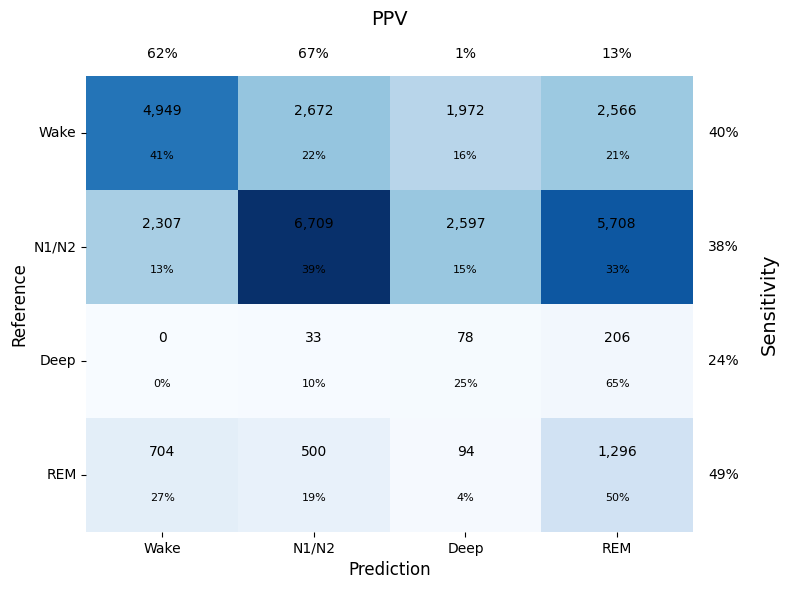

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/ManualLSTM/cms/cm_model0.png
Done with loop 0


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/ManualLSTM/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | va

Epoch 0: 100%|██████████| 101/101 [00:24<00:00,  4.17it/s, v_num=d7qa, train_loss_step=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:26<00:00,  3.75it/s, v_num=d7qa, train_loss_step=1.340, val_loss=1.380, val_acc=0.403, val_cohen_kappa=0.0943, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.383


Epoch 1: 100%|██████████| 101/101 [00:25<00:00,  3.90it/s, v_num=d7qa, train_loss_step=1.360, val_loss=1.380, val_acc=0.403, val_cohen_kappa=0.0943, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 101/101 [00:29<00:00,  3.48it/s, v_num=d7qa, train_loss_step=1.360, val_loss=1.350, val_acc=0.383, val_cohen_kappa=0.111, train_loss_epoch=1.380] 

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 1.350


Epoch 2: 100%|██████████| 101/101 [00:25<00:00,  4.02it/s, v_num=d7qa, train_loss_step=1.270, val_loss=1.350, val_acc=0.383, val_cohen_kappa=0.111, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:27<00:00,  3.64it/s, v_num=d7qa, train_loss_step=1.270, val_loss=1.340, val_acc=0.476, val_cohen_kappa=0.154, train_loss_epoch=1.350]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.344


Epoch 3: 100%|██████████| 101/101 [00:25<00:00,  3.89it/s, v_num=d7qa, train_loss_step=1.300, val_loss=1.340, val_acc=0.476, val_cohen_kappa=0.154, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:28<00:00,  3.56it/s, v_num=d7qa, train_loss_step=1.300, val_loss=1.300, val_acc=0.333, val_cohen_kappa=0.0857, train_loss_epoch=1.320]

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 1.299


Epoch 4: 100%|██████████| 101/101 [00:26<00:00,  3.82it/s, v_num=d7qa, train_loss_step=1.310, val_loss=1.300, val_acc=0.333, val_cohen_kappa=0.0857, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:24<00:00,  4.18it/s, v_num=d7qa, train_loss_step=1.220, val_loss=1.310, val_acc=0.481, val_cohen_kappa=0.130, train_loss_epoch=1.300] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:24<00:00,  4.08it/s, v_num=d7qa, train_loss_step=1.270, val_loss=1.320, val_acc=0.421, val_cohen_kappa=0.120, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:25<00:00,  3.91it/s, v_num=d7qa, train_loss_step=1.050, val_loss=1.420, val_acc=0.277, val_cohen_kappa=0.0679, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:28<00:00,  3.55it/s, v_num=d7qa, train_loss_step=1.050, val_loss=1.310, val_acc=0.273, 

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.299. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 101/101 [00:28<00:00,  3.55it/s, v_num=d7qa, train_loss_step=1.050, val_loss=1.310, val_acc=0.273, val_cohen_kappa=0.103, train_loss_epoch=1.280]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
train_loss_epoch,█▇▅▄▂▁▁▁
train_loss_step,█▅▅▅▆▅▅▄█▃▅▄▄▅▂▃▂▅▄▃▁▅▁▃▆▂▄▃▄▃▄▄▃▃▃▇▁▃▆▇
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇█████
val_acc,▅▅█▃█▆▁▁
val_cohen_kappa,▃▄█▂▆▅▁▄
val_loss,▆▄▄▁▁▂█▁
epoch,7
train_loss_epoch,1.27885
train_loss_step,1.04825
trainer/global_step,807


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/ManualLSTM/loss/best-checkpoint-v32.ckpt
Trained model 1 in 230.30852222442627 seconds


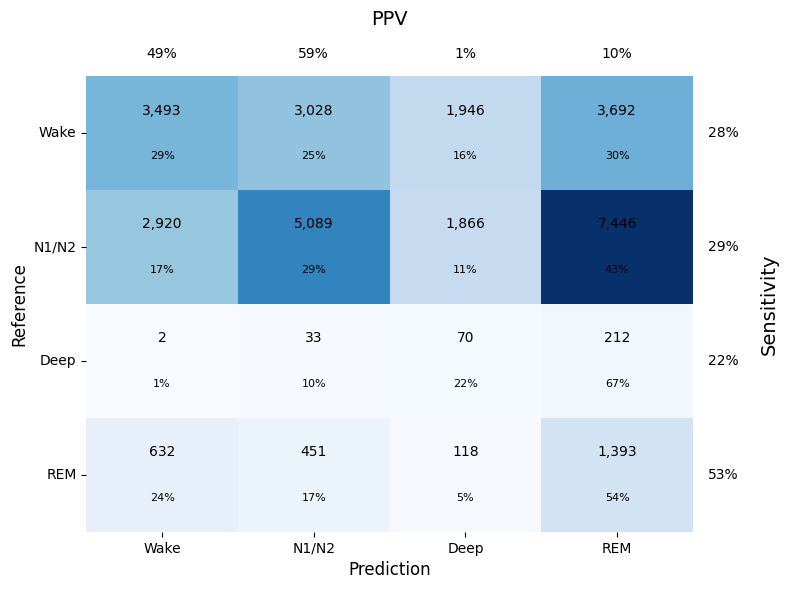

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/ManualLSTM/cms/cm_model1.png
Done with loop 1


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/ManualLSTM/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | va

Epoch 0: 100%|██████████| 101/101 [00:24<00:00,  4.14it/s, v_num=s9f3, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:27<00:00,  3.68it/s, v_num=s9f3, train_loss_step=1.370, val_loss=1.380, val_acc=0.271, val_cohen_kappa=0.0447, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.382


Epoch 1: 100%|██████████| 101/101 [00:25<00:00,  3.91it/s, v_num=s9f3, train_loss_step=1.260, val_loss=1.380, val_acc=0.271, val_cohen_kappa=0.0447, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 101/101 [00:29<00:00,  3.42it/s, v_num=s9f3, train_loss_step=1.260, val_loss=1.340, val_acc=0.398, val_cohen_kappa=0.141, train_loss_epoch=1.350] 

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 1.343


Epoch 2: 100%|██████████| 101/101 [00:24<00:00,  4.13it/s, v_num=s9f3, train_loss_step=1.250, val_loss=1.340, val_acc=0.398, val_cohen_kappa=0.141, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:26<00:00,  3.82it/s, v_num=s9f3, train_loss_step=1.310, val_loss=1.380, val_acc=0.382, val_cohen_kappa=0.142, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:29<00:00,  3.39it/s, v_num=s9f3, train_loss_step=1.310, val_loss=1.310, val_acc=0.473, val_cohen_kappa=0.140, train_loss_epoch=1.310]

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 1.306


Epoch 4: 100%|██████████| 101/101 [00:25<00:00,  4.02it/s, v_num=s9f3, train_loss_step=1.450, val_loss=1.310, val_acc=0.473, val_cohen_kappa=0.140, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:25<00:00,  3.97it/s, v_num=s9f3, train_loss_step=1.100, val_loss=1.330, val_acc=0.266, val_cohen_kappa=0.0891, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:26<00:00,  3.84it/s, v_num=s9f3, train_loss_step=1.160, val_loss=1.350, val_acc=0.324, val_cohen_kappa=0.076, train_loss_epoch=1.290] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:25<00:00,  3.98it/s, v_num=s9f3, train_loss_step=1.180, val_loss=1.310, val_acc=0.380, val_cohen_kappa=0.133, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:28<00:00,  3.55it/s, v_num=s9f3, train_loss_step=1.180, val_loss=1.280, val_acc=0.384, v

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.281


Epoch 8: 100%|██████████| 101/101 [00:25<00:00,  3.89it/s, v_num=s9f3, train_loss_step=1.080, val_loss=1.280, val_acc=0.384, val_cohen_kappa=0.131, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 101/101 [00:24<00:00,  4.10it/s, v_num=s9f3, train_loss_step=1.230, val_loss=1.290, val_acc=0.347, val_cohen_kappa=0.121, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s, v_num=s9f3, train_loss_step=1.230, val_loss=1.280, val_acc=0.359, val_cohen_kappa=0.145, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 101/101 [00:25<00:00,  3.94it/s, v_num=s9f3, train_loss_step=1.190, val_loss=1.300, val_acc=0.329, val_cohen_kappa=0.100, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 101/101 [00:29<00:00,  3.46it/s, v_num=s9f3, train_loss_step=1.190, val_loss=1.400, val_acc=0.343, 

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.281. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 101/101 [00:29<00:00,  3.46it/s, v_num=s9f3, train_loss_step=1.190, val_loss=1.400, val_acc=0.343, val_cohen_kappa=0.143, train_loss_epoch=1.170]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▂▂▂▂▂▂▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▇▇▇▇▇▇▇▇▇▇▇███
train_loss_epoch,█▇▆▆▅▅▄▄▃▃▂▁
train_loss_step,▄▃▃▄▄▄▂█▄▄▂▄▂▄▃▃▃▂▃▅▂▃▂▂▆▃▂▂▄▄▂▂▃▃▁▁▄▂▅▂
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
val_acc,▁▅▅█▁▃▅▅▄▄▃▄
val_cohen_kappa,▁███▄▃▇▇▆█▅█
val_loss,▇▅▇▂▄▅▃▁▂▁▂█
epoch,11
train_loss_epoch,1.17216
train_loss_step,1.19082
trainer/global_step,1211


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/ManualLSTM/loss/best-checkpoint-v33.ckpt
Trained model 2 in 348.0442924499512 seconds


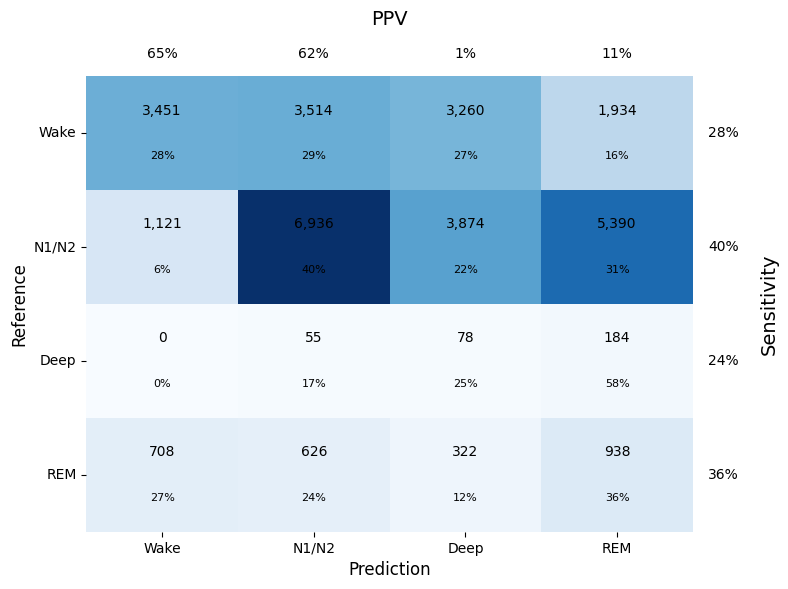

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/ManualLSTM/cms/cm_model2.png
Done with loop 2


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/ManualLSTM/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | va

Epoch 0: 100%|██████████| 101/101 [00:25<00:00,  4.01it/s, v_num=w4c3, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:29<00:00,  3.47it/s, v_num=w4c3, train_loss_step=1.390, val_loss=1.410, val_acc=0.485, val_cohen_kappa=0.129, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.414


Epoch 1: 100%|██████████| 101/101 [00:25<00:00,  3.90it/s, v_num=w4c3, train_loss_step=1.150, val_loss=1.410, val_acc=0.485, val_cohen_kappa=0.129, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:21<00:00,  4.69it/s, v_num=w4c3, train_loss_step=1.450, val_loss=1.420, val_acc=0.480, val_cohen_kappa=0.120, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:24<00:00,  4.19it/s, v_num=w4c3, train_loss_step=1.450, val_loss=1.300, val_acc=0.332, val_cohen_kappa=0.098, train_loss_epoch=1.330]

Metric val_loss improved by 0.116 >= min_delta = 0.0. New best score: 1.298


Epoch 3: 100%|██████████| 101/101 [00:20<00:00,  4.90it/s, v_num=w4c3, train_loss_step=1.340, val_loss=1.300, val_acc=0.332, val_cohen_kappa=0.098, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:20<00:00,  4.90it/s, v_num=w4c3, train_loss_step=1.200, val_loss=1.310, val_acc=0.286, val_cohen_kappa=0.0817, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, v_num=w4c3, train_loss_step=1.250, val_loss=1.320, val_acc=0.323, val_cohen_kappa=0.088, train_loss_epoch=1.300] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:19<00:00,  5.06it/s, v_num=w4c3, train_loss_step=1.340, val_loss=1.340, val_acc=0.404, val_cohen_kappa=0.0921, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:22<00:00,  4.54it/s, v_num=w4c3, train_loss_step=1.340, val_loss=1.330, val_acc=0.357, 

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.298. Signaling Trainer to stop.


Epoch 6: 100%|██████████| 101/101 [00:22<00:00,  4.54it/s, v_num=w4c3, train_loss_step=1.340, val_loss=1.330, val_acc=0.357, val_cohen_kappa=0.0885, train_loss_epoch=1.270]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
train_loss_epoch,█▅▄▃▃▁▁
train_loss_step,▆▅▅▅▅▅▅▇▅▄▅▆▅█▄▅▆▆▆▃▆▄▂▄▄▅▃▂▅▆█▁▆▃▃▂▅▅▆▅
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
val_acc,██▃▁▂▅▄
val_cohen_kappa,█▇▃▁▂▃▂
val_loss,██▁▁▂▄▃
epoch,6
train_loss_epoch,1.2718
train_loss_step,1.34161
trainer/global_step,706


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/ManualLSTM/loss/best-checkpoint-v34.ckpt
Trained model 3 in 175.49481058120728 seconds


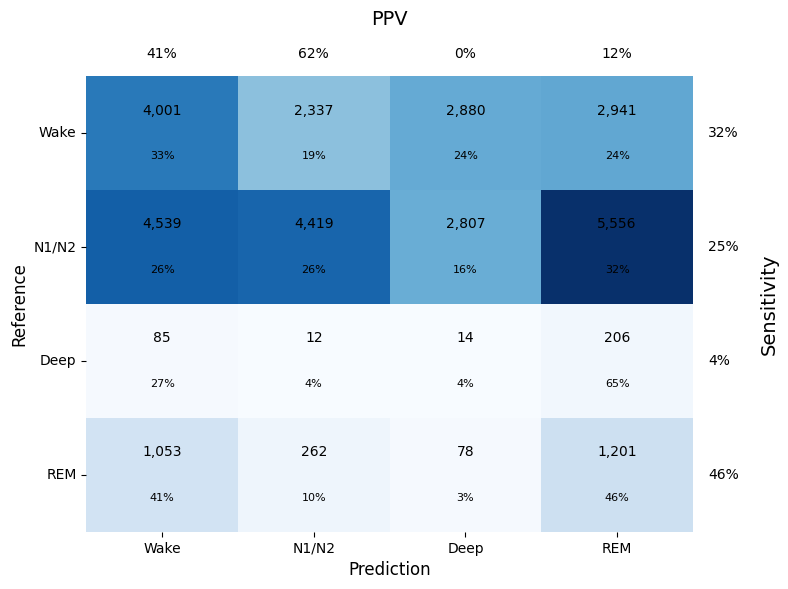

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/ManualLSTM/cms/cm_model3.png
Done with loop 3


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/ManualLSTM/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | va

Epoch 0: 100%|██████████| 101/101 [00:19<00:00,  5.26it/s, v_num=grsm, train_loss_step=1.450]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:21<00:00,  4.66it/s, v_num=grsm, train_loss_step=1.450, val_loss=1.370, val_acc=0.289, val_cohen_kappa=0.0468, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.371


Epoch 1: 100%|██████████| 101/101 [00:20<00:00,  4.96it/s, v_num=grsm, train_loss_step=1.350, val_loss=1.370, val_acc=0.289, val_cohen_kappa=0.0468, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 101/101 [00:22<00:00,  4.45it/s, v_num=grsm, train_loss_step=1.350, val_loss=1.320, val_acc=0.286, val_cohen_kappa=0.0541, train_loss_epoch=1.350]

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 1.320


Epoch 2: 100%|██████████| 101/101 [00:20<00:00,  4.91it/s, v_num=grsm, train_loss_step=1.210, val_loss=1.320, val_acc=0.286, val_cohen_kappa=0.0541, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:23<00:00,  4.29it/s, v_num=grsm, train_loss_step=1.210, val_loss=1.310, val_acc=0.353, val_cohen_kappa=0.102, train_loss_epoch=1.330] 

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.305


Epoch 3: 100%|██████████| 101/101 [00:20<00:00,  4.99it/s, v_num=grsm, train_loss_step=1.460, val_loss=1.310, val_acc=0.353, val_cohen_kappa=0.102, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:20<00:00,  4.93it/s, v_num=grsm, train_loss_step=1.290, val_loss=1.320, val_acc=0.351, val_cohen_kappa=0.0937, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:20<00:00,  4.83it/s, v_num=grsm, train_loss_step=1.280, val_loss=1.360, val_acc=0.263, val_cohen_kappa=0.068, train_loss_epoch=1.290] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, v_num=grsm, train_loss_step=0.906, val_loss=1.320, val_acc=0.206, val_cohen_kappa=0.0566, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:22<00:00,  4.54it/s, v_num=grsm, train_loss_step=0.906, val_loss=1.340, val_acc=0.323, 

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.305. Signaling Trainer to stop.


Epoch 6: 100%|██████████| 101/101 [00:22<00:00,  4.53it/s, v_num=grsm, train_loss_step=0.906, val_loss=1.340, val_acc=0.323, val_cohen_kappa=0.0809, train_loss_epoch=1.290]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▅▅▅▆▆▆▆▆▆▆▆▇▇▇███████
train_loss_epoch,█▆▄▃▂▁▁
train_loss_step,▆▅▆▄▅▄▆▆▄▁▃▃█▃▇▅█▆▄▅▂▅▂▃▄▅▃█▄▅▄▆▅▃▂▃▃▄▂▁
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇███
val_acc,▅▅██▄▁▇
val_cohen_kappa,▁▂█▇▄▂▅
val_loss,█▃▁▂▇▃▅
epoch,6
train_loss_epoch,1.28826
train_loss_step,0.90648
trainer/global_step,706


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/ManualLSTM/loss/best-checkpoint-v35.ckpt
Trained model 4 in 161.94531774520874 seconds


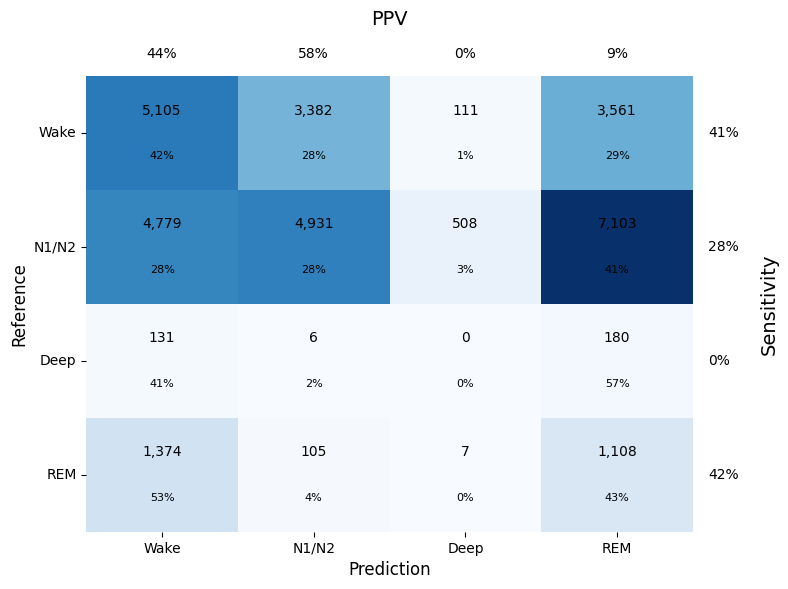

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/ManualLSTM/cms/cm_model4.png
Done with loop 4


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/ManualLSTM/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.6 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | va

Epoch 0: 100%|██████████| 101/101 [00:18<00:00,  5.32it/s, v_num=cu5f, train_loss_step=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:21<00:00,  4.71it/s, v_num=cu5f, train_loss_step=1.290, val_loss=1.360, val_acc=0.422, val_cohen_kappa=0.118, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.358


Epoch 1: 100%|██████████| 101/101 [00:20<00:00,  4.89it/s, v_num=cu5f, train_loss_step=1.220, val_loss=1.360, val_acc=0.422, val_cohen_kappa=0.118, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, v_num=cu5f, train_loss_step=1.410, val_loss=1.420, val_acc=0.176, val_cohen_kappa=0.0351, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:21<00:00,  4.64it/s, v_num=cu5f, train_loss_step=1.410, val_loss=1.290, val_acc=0.422, val_cohen_kappa=0.0965, train_loss_epoch=1.340]

Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 1.292


Epoch 3: 100%|██████████| 101/101 [00:20<00:00,  4.86it/s, v_num=cu5f, train_loss_step=1.240, val_loss=1.290, val_acc=0.422, val_cohen_kappa=0.0965, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:20<00:00,  4.99it/s, v_num=cu5f, train_loss_step=1.160, val_loss=1.300, val_acc=0.420, val_cohen_kappa=0.132, train_loss_epoch=1.320] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, v_num=cu5f, train_loss_step=1.280, val_loss=1.310, val_acc=0.298, val_cohen_kappa=0.109, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6:  42%|████▏     | 42/101 [00:09<00:13,  4.52it/s, v_num=cu5f, train_loss_step=1.410, val_loss=1.360, val_acc=0.253, val_cohen_kappa=0.0697, train_loss_epoch=1.300] 

In [ ]:
accs = []
kappas = []
aurocs = []
cms = []
train_times = []
test_times = []
for i in range(10):
    model, train_time = train_model(
        batch_size = batch_size,
        acc_preprocess = acc_preprocess,
        RNN_type = RNN_type,
        lr = lr,
        rnn_hidden_size = rnn_hidden_size,
        pre_rnn_size = pre_rnn_size,
        hidden_size2 = hidden_size2,
        dropout_embed = dropout_embed,
        dropout_rnn = dropout_rnn,
        dropout_hidden2 = dropout_hidden2,
        modelType = modelType,
        nameAppend = f"model{i}")
    print(f"Trained model {i} in {train_time} seconds")
    acc, kappa, auroc, cm, inference_time_seconds = evaluate_model(model, test_loader, modelType, i)
    accs.append(acc)
    kappas.append(kappa)
    aurocs.append(auroc)
    cms.append(cms)
    train_times.append(train_time)
    test_times.append(inference_time_seconds)
    print(f"Done with loop {i}")

In [20]:
acc_mean, acc_std = np.mean(accs), np.std(accs)
kappa_mean, kappa_std = np.mean(kappas), np.std(kappas)
auroc_mean, auroc_std = np.mean(aurocs), np.std(aurocs)
train_time_mean, train_time_std = np.mean(train_times), np.std(train_times)
test_time_mean, test_time_std = np.mean(test_times), np.std(test_times)

# Print the statistics
print(f"Accuracy: Mean = {acc_mean:.3f}, StdDev = {acc_std:.3f}")
print(f"Kappa: Mean = {kappa_mean:.3f}, StdDev = {kappa_std:.3f}")
print(f"AUROC: Mean = {auroc_mean:.3f}, StdDev = {auroc_std:.3f}")

# Find the index of the best kappa
best_kappa_index = np.argmax(kappas)
print(f"Best Kappa Index: {best_kappa_index}")

# Find the index of the best acc
best_acc_index = np.argmax(accs)
print(f"Best Accuracy Index: {best_acc_index}")

# Find the index of the best AUROC
best_auroc_index = np.argmax(aurocs)
print(f"Best AUROC Index: {best_auroc_index}")

Accuracy: Mean = 0.329, StdDev = 0.036
Kappa: Mean = 0.091, StdDev = 0.039
AUROC: Mean = 0.537, StdDev = 0.035
Best Kappa Index: 0
Best Accuracy Index: 0
Best AUROC Index: 7
